```
---
title: BioPAX molecules connecting chemical reactions
tags: BioPAX, smallMolecules, SPARQL, Reactome, ChEBI
lang: en
version: 0.38
date: 2025-01-22
---
```

In [1]:
import importlib
import IPython
import json
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import pandas
import rdflib
import rdflib.namespace
import scipy.stats
import sparqldataframe
import statsmodels.stats.multitest
from SPARQLWrapper import SPARQLWrapper, JSON
import sys

In [2]:
reactomeVersion = 79 # (reactome v91) #38 # was 83 # was 81
#chebiVersion = 238 # 222 # was 219 # was 207 #now retrieved from the ChEBI file
#endpointURL = "http://localhost:3030/reactome/query"
#endpointURL = "http://localhost:3030/chebi/query"
endpointURL = "http://localhost:3030/reactomeChEBI/query"
rdfFormat = "turtle"

In [3]:
prefixes = """
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs:<http://www.w3.org/2000/01/rdf-schema#>
PREFIX owl: <http://www.w3.org/2002/07/owl#>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
PREFIX dc: <http://purl.org/dc/elements/1.1/>
PREFIX dcterms: <http://purl.org/dc/terms/>

PREFIX chebi: <http://purl.obolibrary.org/obo/chebi/>
PREFIX chebidb: <http://purl.obolibrary.org/obo/CHEBI_>
PREFIX chebirel: <http://purl.obolibrary.org/obo/CHEBI#>

PREFIX bp3: <http://www.biopax.org/release/biopax-level3.owl#>

# Homo_sapiens-20170221.owl
#PREFIX reactome: <http://www.reactome.org/biopax/59/48887#> 
#
# Homo_sapiens-20210608.owl
#PREFIX reactome: <http://www.reactome.org/biopax/77/48887#>
#
# Homo_sapiens-20220614.owl
#PREFIX reactome: <http://www.reactome.org/biopax/81/48887#>
#
# Homo_sapiens-20221130.owl
#PREFIX reactome: <http://www.reactome.org/biopax/83/48887#>

PREFIX reactome: <http://www.reactome.org/biopax/{}/48887#>
""".format(reactomeVersion)

owlNS = "http://www.w3.org/2002/07/owl#"
biopaxNS = "http://www.biopax.org/release/biopax-level3.owl#"
reactomeNS = "http://www.reactome.org/biopax/{}/48887#".format(reactomeVersion)
chebiNS = "http://purl.obolibrary.org/obo/CHEBI_"
uniprotNS = "http://purl.uniprot.org/uniprot/"

In [4]:
query="""
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs:<http://www.w3.org/2000/01/rdf-schema#>
PREFIX owl: <http://www.w3.org/2002/07/owl#>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
PREFIX dc: <http://purl.org/dc/elements/1.1/>
PREFIX dcterms: <http://purl.org/dc/terms/>

SELECT ?ontology ?versionIRI (REPLACE(REPLACE(STR(?versionIRI), 'http://purl.obolibrary.org/obo/chebi/', ''), '/chebi.owl', '') AS ?versionNumber)
WHERE {
  ?ontology rdf:type owl:Ontology .
  ?ontology owl:versionIRI ?versionIRI .
}
"""

sparql = SPARQLWrapper(endpointURL)
sparql.setQuery(prefixes+query)
sparql.setReturnFormat(JSON)
results = sparql.query().convert()

chebiVersion = int(results["results"]["bindings"][0]["versionNumber"]["value"])
print("ChEBI version: {}".format(chebiVersion))

ChEBI version: 238


In [5]:
def displaySparqlResults(results):
    '''
    Displays as HTML the result of a SPARQLWrapper query in a Jupyter notebook.
    
        Parameters:
            results (dictionnary): the result of a call to SPARQLWrapper.query().convert()
    '''
    variableNames = results['head']['vars']
    tableCode = '<table><tr><th>{}</th></tr><tr>{}</tr></table>'.format('</th><th>'.join(variableNames), '</tr><tr>'.join('<td>{}</td>'.format('</td><td>'.join([row[vName]['value'] if vName in row.keys() else "&nbsp;" for vName in variableNames]))for row in results["results"]["bindings"]))
    IPython.display.display(IPython.display.HTML(tableCode))

In [6]:
def getEntityLabel(entityURI):
    query="""
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs:<http://www.w3.org/2000/01/rdf-schema#>
PREFIX owl: <http://www.w3.org/2002/07/owl#>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
PREFIX dc: <http://purl.org/dc/elements/1.1/>
PREFIX dcterms: <http://purl.org/dc/terms/>

SELECT DISTINCT ?entityLabel
WHERE {
  VALUES ?entityURI { <""" + entityURI + """> }
  ?entityURI rdfs:label ?entityLabel .
}
"""
    sparql = SPARQLWrapper(endpointURL)
    sparql.setQuery(prefixes+query)
    sparql.setReturnFormat(JSON)
    results = sparql.query().convert()
    entityName = None
    if len(results["results"]["bindings"]) > 0:
        entityName = results["results"]["bindings"][0]['entityLabel']['value']
    return entityName

In [7]:
def getEntityNameByIdentifier(entityIdent, dbName="Reactome"):
    query="""
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs:<http://www.w3.org/2000/01/rdf-schema#>
PREFIX owl: <http://www.w3.org/2002/07/owl#>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
PREFIX dc: <http://purl.org/dc/elements/1.1/>
PREFIX dcterms: <http://purl.org/dc/terms/>

SELECT DISTINCT ?entityName
WHERE {
  VALUES ?entityIdent { \"""" + entityIdent + """\" }
  
  ?entityURI bp3:xref [
    rdf:type bp3:UnificationXref ;
    bp3:db \"""" + dbName + """\" ;
    bp3:id ?entityIdent
  ] .
  
  OPTIONAL { ?entityURI bp3:name ?entityBpName } .
  OPTIONAL { ?entityURI bp3:displayName ?entityBpDisplayName } .
  OPTIONAL { ?entityURI rdfs:label ?entityLabel } .
  BIND (COALESCE(?entityBpDisplayName, ?entityBpName, ?entityLabel ) AS ?entityName )
}
"""
    sparql = SPARQLWrapper(endpointURL)
    sparql.setQuery(prefixes+query)
    sparql.setReturnFormat(JSON)
    results = sparql.query().convert()
    entityName = None
    if len(results["results"]["bindings"]) > 0:
        entityName = results["results"]["bindings"][0]['entityName']['value']
    return entityName

In [8]:
def getEntityTypeByIdentifier(entityIdent, dbName="Reactome"):
    query="""
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs:<http://www.w3.org/2000/01/rdf-schema#>
PREFIX owl: <http://www.w3.org/2002/07/owl#>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
PREFIX dc: <http://purl.org/dc/elements/1.1/>
PREFIX dcterms: <http://purl.org/dc/terms/>

SELECT DISTINCT ?entityType
WHERE {
  VALUES ?entityIdent { \"""" + entityIdent + """\" }
  
  ?entityURI bp3:xref [
    rdf:type bp3:UnificationXref ;
    bp3:db \"""" + dbName + """\" ;
    bp3:id ?entityIdent
  ] .
  
  ?entityURI rdf:type ?entityType .
}
"""
    sparql = SPARQLWrapper(endpointURL)
    sparql.setQuery(prefixes+query)
    sparql.setReturnFormat(JSON)
    results = sparql.query().convert()
    entityType = None
    if len(results["results"]["bindings"]) > 0:
        entityType = results["results"]["bindings"][0]['entityType']['value']
    return entityType

In [9]:
def getEntityReactomeStableIdentifier(entityURI):
    query="""
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs:<http://www.w3.org/2000/01/rdf-schema#>
PREFIX owl: <http://www.w3.org/2002/07/owl#>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
PREFIX dc: <http://purl.org/dc/elements/1.1/>
PREFIX dcterms: <http://purl.org/dc/terms/>

SELECT DISTINCT ?entityIdent
WHERE {
  VALUES ?entityURI { <""" + entityURI + """> }
  ?entityURI bp3:xref [
    rdf:type bp3:UnificationXref ;
    bp3:db "Reactome" ;
    bp3:id ?entityIdent
  ]
}
"""
    sparql = SPARQLWrapper(endpointURL)
    sparql.setQuery(prefixes+query)
    sparql.setReturnFormat(JSON)
    results = sparql.query().convert()
    entityName = None
    if len(results["results"]["bindings"]) > 0:
        entityIdent = results["results"]["bindings"][0]['entityIdent']['value']
    return entityIdent

In [10]:
def getEntityExternalIdentifier(entityIdent, dbName):
    query="""
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs:<http://www.w3.org/2000/01/rdf-schema#>
PREFIX owl: <http://www.w3.org/2002/07/owl#>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
PREFIX dc: <http://purl.org/dc/elements/1.1/>
PREFIX dcterms: <http://purl.org/dc/terms/>

SELECT DISTINCT ?entityStableIdent
WHERE {
  VALUES ?entityIdent { \"""" + entityIdent + """\" }
  
  ?entityURI bp3:xref [
    rdf:type bp3:UnificationXref ;
    bp3:id ?entityIdent
  ] .
  
  ?entityURI bp3:entityReference/bp3:xref [
    rdf:type bp3:UnificationXref ;
    bp3:db \"""" + dbName + """\" ;
    bp3:id ?entityStableIdent
  ]
}
"""
    sparql = SPARQLWrapper(endpointURL)
    sparql.setQuery(prefixes+query)
    sparql.setReturnFormat(JSON)
    results = sparql.query().convert()
    if len(results["results"]["bindings"]) > 0:
        return results["results"]["bindings"][0]['entityStableIdent']['value']
    return entityIdent

In [11]:
def addMoleculeToGraph(graph, moleculeIdent, moleculeBlacklist = []):
    if moleculeIdent in graph.nodes():
        return
    moleculeName = getEntityLabel(moleculeIdent.replace("CHEBI:", chebiNS))
    if moleculeName == None:
        moleculeName = ""
    if moleculeName != "":
        moleculeName += " "
    moleculeName += "({})".format(moleculeIdent)
    isBlacklisted = moleculeIdent in moleculeBlacklist
    graph.add_node(moleculeIdent, type="SmallMolecule", label=moleculeName, isBlacklisted=isBlacklisted)  

In [12]:
def addMoleculeToGraphFIXED(graph, moleculeIdent, moleculeBlacklist = []):
    if moleculeIdent == "R-COV-9694537":
        print("***** adding to the graph: R-COV-9694537")
    moleculeRefIdent = moleculeIdent
    moleculeType = getEntityTypeByIdentifier(moleculeIdent, dbName="Reactome")
    if moleculeType == None:
        moleculeType = ""
    moleculeType = moleculeType.replace(biopaxNS, "")
    if moleculeType == "SmallMolecule":
        moleculeRefIdent = getEntityExternalIdentifier(moleculeIdent, dbName="ChEBI")
    elif moleculeType == "Protein":
        moleculeRefIdent = getEntityExternalIdentifier(moleculeIdent, dbName="UniProt")
        if moleculeRefIdent == moleculeIdent:
            moleculeRefIdent = getEntityExternalIdentifier(moleculeIdent, dbName="UniProt Isoform")
    if moleculeIdent == "R-COV-9694537":
        print("***** moleculeRefIdent: {}".format(moleculeRefIdent))
    if moleculeRefIdent == None:
        moleculeRefIdent = moleculeIdent
    if moleculeIdent == "R-COV-9694537":
        print("***** moleculeRefIdent: {}".format(moleculeRefIdent))
    if moleculeRefIdent in graph.nodes():
        return
    moleculeName = getEntityNameByIdentifier(moleculeIdent)
    if moleculeName == None:
        moleculeName = ""
    if moleculeName != "":
        moleculeName += " "
    #if moleculeType == "SmallMolecule":
    #    moleculeName += "({})".format(getEntityExternalIdentifier(moleculeIdent, dbName="ChEBI"))
    #elif moleculeType == "Protein":
    #    moleculeName += "({})".format(getEntityExternalIdentifier(moleculeIdent, dbName="UniProt"))
    if moleculeType == "SmallMolecule":
        moleculeName += "({})".format(moleculeRefIdent)
    elif moleculeType == "Protein":
        moleculeName += "({})".format(moleculeRefIdent)
    else:
        moleculeName += "({})".format(moleculeIdent)
    isBlacklisted = moleculeRefIdent in moleculeBlacklist
    graph.add_node(moleculeRefIdent, type=moleculeType, label=moleculeName, isBlacklisted=isBlacklisted)  

In [13]:
def addReactionToGraph(graph, reactionIdent):
    if reactionIdent in graph.nodes():
        return
    reactionName = getEntityNameByIdentifier(reactionIdent)
    if reactionName == None:
        reactionName = ""
    if reactionName != "":
        reactionName += " "
    reactionName += "({})".format(reactionIdent)
    graph.add_node(reactionIdent, type="BiochemicalReaction", label=reactionName)

# TEST Reactome version 91 (2024-12)

In [6]:
query="""
# All SmallMolecules

SELECT (COUNT(DISTINCT ?molecule) AS ?nbMolecules)
WHERE {
  ?molecule rdf:type/(rdfs:subClassOf*) bp3:SmallMolecule .
}"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

nbMolecules
0        5245

> **Interpretation:** 5245 instances of `bp3:SmallMolecule` (was 5131 with version 2023-09 and 5083 with version 83)

# TEST Reactome version 2023-09

In [6]:
query="""
# All SmallMolecules

SELECT (COUNT(DISTINCT ?molecule) AS ?nbMolecules)
WHERE {
  ?molecule rdf:type/(rdfs:subClassOf*) bp3:SmallMolecule .
}"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

nbMolecules
0        5131

> **Interpretation: ** 5131 instances of `bp3:SmallMolecule` (was 5083 with version 83)

In [7]:
query="""
# All SmallMolecules

SELECT DISTINCT ?molecule ?moleculeName
WHERE {
  ?molecule rdf:type/(rdfs:subClassOf*) bp3:SmallMolecule .
  
  OPTIONAL { ?molecule bp3:name ?moleculeName }
}
LIMIT 10
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

molecule  \
0  http://www.reactome.org/biopax/38/48887#SmallM...   
1  http://www.reactome.org/biopax/38/48887#SmallM...   
2  http://www.reactome.org/biopax/38/48887#SmallM...   
3  http://www.reactome.org/biopax/38/48887#SmallM...   
4  http://www.reactome.org/biopax/38/48887#SmallM...   
5  http://www.reactome.org/biopax/38/48887#SmallM...   
6  http://www.reactome.org/biopax/38/48887#SmallM...   
7  http://www.reactome.org/biopax/38/48887#SmallM...   
8  http://www.reactome.org/biopax/38/48887#SmallM...   
9  http://www.reactome.org/biopax/38/48887#SmallM...   

                                        moleculeName  
0  3alpha,7alpha-dihydroxy-5beta-cholestan-26-oyl...  
1     3alpha,7alpha-Dihydroxy-5beta-cholestanoyl-CoA  
2                                               None  
3                           phosphatidylethanolamine  
4                                               None  
5                       2-Hydroxytricarballylic acid  
6                                        citric acid  
7                                            Citrate  
8          2-Hydroxy-1,2,3-propanetricarboxylic acid  
9                                        cadmium(2+)

In [8]:
query="""
# All the relations that apply to some SmallMolecules

SELECT DISTINCT ?rel
WHERE {
  ?molecule rdf:type/(rdfs:subClassOf*) bp3:SmallMolecule .
  
  ?molecule ?rel ?val .
}
"""

#df = sparqldataframe.query(endpointURL, prefixes+query)
#df

sparql = SPARQLWrapper(endpointURL)
sparql.setQuery(prefixes+query)
sparql.setReturnFormat(JSON)
results = sparql.query().convert()
#for result in results["results"]["bindings"]:
#    print("{}\t{}".format(result["property"]["value"], result["propertyLabel"]["value"]))
displaySparqlResults(results)

In [9]:
query="""
# name, reactomeID and entityRef for SmallMolecules

SELECT DISTINCT ?molecule ?moleculeName ?moleculeReactomeID ?moleculeEntityRef
WHERE {
  ?molecule rdf:type/(rdfs:subClassOf*) bp3:SmallMolecule .
  
  OPTIONAL { ?molecule bp3:name ?moleculeName }
  OPTIONAL { ?molecule bp3:entityReference ?moleculeEntityRef }
  OPTIONAL { 
    ?molecule bp3:xref ?moleculeXRef.
    ?moleculeXRef bp3:db "Reactome" .
    ?moleculeXRef bp3:id ?moleculeReactomeID .
  }
}
LIMIT 10
"""

sparql = SPARQLWrapper(endpointURL)
sparql.setQuery(prefixes+query)
sparql.setReturnFormat(JSON)
results = sparql.query().convert()
#for result in results["results"]["bindings"]:
#    print("{}\t{}".format(result["property"]["value"], result["propertyLabel"]["value"]))
displaySparqlResults(results)

# Motivation

> **Possible titles:**
> - Identify ubiquitous ancillary molecules with a knowledge based strategy combining statistical and topological constraints

> 
- **Motivation:** 
    - find a path of candidate chemical reactions e.g. explaining the degradation or the production of a metabolite, or potentially affected by an enzyme
    - (low level) (bio-)chemical perspective, as opposed to a higher level biological perspective: a pathway-based approach focuses on the perspective of a certain biological function and may be too restrictive when a systematic approach is desirable (or when the knowledge about the pathways is not available, e.g. for non-model species or when studying the interactions between multiple organisms).
    - we therefore focus on graphs of biochemical reactions, connected by the molecules they consume or produce
- **challenge:**
    - in this graph, some ubiquitous molecules such as water, protons, ATP are hubs/ancillary and must be ignored
    - the traditional strategy is to create a black list of molecules. Such lists can be defined by experts, or based on the number of reactions the molecules participate in. However, the criteria or thresholds are not clear.
- **approach:**
    - sieve-like: identify the molecules to ignore (TN), and retain all the others
        - instead of identifying the "good molecules", as we prefer FN over FP (?)
    - assumption = we can leverage the molecules that connect the chemical reactions of consecutive pathway steps, as these connections are biologically-relevant
    - hypotheses 
        - hyp1 (statistical) = the "good/relevant molecules" are over-represented across the connections of pathway steps
        - hyp2 (combinatorial) = removing the "bad molecules"
            - does not affect the connectivity of the pathway steps
            - negatively affects the connectivity of the "irrelevant" pairs of reactions
- **key points of the study:**
    - identify the pairs of **consecutive** reactions
    - apply constraints for determining the **biologically relevant** pairs of consecutive reactions
    - determine the status of the molecules
- **metrics:**
    - frequency of the "bad molecules"
    - effects on connectivity

> **Definition: consecutive chemical reactions** = pair of chemical reactions such as the source produces at least 1 molecule that is consumed by the target. 
> This study compares several methods for determining these molecules.

> **Definition: (explicitely) consecutive pathway steps** = pair of `bp3:PathwayStep` such as the source is connected to the target by a `bp3:nextStep` relation.

> **Definition: (implicitely) consecutive pathway steps** = the 4 configurations involving pathway composition and the first-or-last of its components.

# Outline

1. Basic quantitative analysis
2. Template queries
3. Constraint1: any pair of consecutive chemical reactions 
4. Constraint2: pairs of consecutive chemical reactions associated to consecutive pathway steps
5. Constraint3: pairs of consecutive chemical reactions associated to consecutive pathway steps considering pathway hierarchy

# Basic quantitative analysis

In [6]:
query="""
# All SmallMolecules

SELECT (COUNT(DISTINCT ?molecule) AS ?nbMolecules)
WHERE {
  ?molecule rdf:type/(rdfs:subClassOf*) bp3:SmallMolecule .
}"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

nbMolecules
0        5245

In [7]:
query="""
# All SmallMoleculeReferences

SELECT (COUNT(DISTINCT ?moleculeRef) AS ?nbMoleculeReferences)
WHERE {
  ?moleculeRef rdf:type/(rdfs:subClassOf*) bp3:SmallMoleculeReference .
}"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

nbMoleculeReferences
0                 2971

In [8]:
query="""
# All BiochemicalReactions

SELECT (COUNT(DISTINCT ?reaction) AS ?nbReactions)
WHERE {
  ?reaction rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
}"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

nbReactions
0       15249

> **Interpretation:**
> - ~~there are 14183 * 14182 = 201.143.306 ordered pairs of reactions~~
> - ~~there are 14183 * 14182 / 2 = 100.571.653 unordered pairs of reactions~~
> - ~~there are 14468 * 14467 = 209.308.556 ordered pairs of reactions~~
> - ~~there are 14468 * 14467 / 2 = 104.654.278 unordered pairs of reactions~~
> - there are 15249 * 15248 = 232.516.752 ordered pairs of reactions
> - there are 15249 * 15248 / 2 = 116.258.376 unordered pairs of reactions

# Template queries

## Templates queryMolecules

In [9]:
queryMoleculesCount="""
# A bp3:SmallMolecule connects directly two bp3:BiochemicalReactions

SELECT (COUNT(DISTINCT ?molecule) AS ?nbMolecules)
WHERE {
  ?reaction1 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
  ?reaction1 bp3:right ?molecule .
  ?molecule rdf:type/(rdfs:subClassOf*) bp3:SmallMolecule .
  ?reaction2 bp3:left ?molecule .
  ?reaction2 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
}"""

df = sparqldataframe.query(endpointURL, prefixes+queryMoleculesCount)
df

nbMolecules
0        1351

In [10]:
queryMoleculesList="""
# A bp3:SmallMolecule connects directly two bp3:BiochemicalReactions

SELECT DISTINCT ?molecule (SAMPLE(?moleculeName) AS ?moleculeLabel) (COUNT(*) AS ?nbReactionPairs)
WHERE {
  ?reaction1 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
  ?reaction1 bp3:right ?molecule .
  ?molecule rdf:type/(rdfs:subClassOf*) bp3:SmallMolecule .
  ?reaction2 bp3:left ?molecule .
  ?reaction2 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
  
  #constraintMoleculeUnicityClause#
  
  OPTIONAL { ?molecule bp3:name ?moleculeName }
  
  #constraintBetweenReactionsClause#
}
GROUP BY ?molecule 
ORDER BY DESC(?nbReactionPairs)
"""

df = sparqldataframe.query(endpointURL, prefixes+queryMoleculesList)
df['nbReactionPairs'] = pandas.to_numeric(df['nbReactionPairs'])
df

molecule  \
0     http://www.reactome.org/biopax/79/48887#SmallM...   
1     http://www.reactome.org/biopax/79/48887#SmallM...   
2     http://www.reactome.org/biopax/79/48887#SmallM...   
3     http://www.reactome.org/biopax/79/48887#SmallM...   
4     http://www.reactome.org/biopax/79/48887#SmallM...   
...                                                 ...   
1346  http://www.reactome.org/biopax/79/48887#SmallM...   
1347  http://www.reactome.org/biopax/79/48887#SmallM...   
1348  http://www.reactome.org/biopax/79/48887#SmallM...   
1349  http://www.reactome.org/biopax/79/48887#SmallM...   
1350  http://www.reactome.org/biopax/79/48887#SmallM...   

                  moleculeLabel  nbReactionPairs  
0                        hydron           118500  
1                         water           103428  
2                       ATP(4-)            39928  
3                          NADP            39200  
4      Adenosine 5'-diphosphate            37770  
...                         ...              ...  
1346            Antigen peptide                1  
1347  Exogenous soluble antigen                1  
1348               nitrous acid                1  
1349                       None                1  
1350                   cortisol                1  

[1351 rows x 3 columns]

> **Interpretation 1:**
> Without surprise, the most frequent molecules are:
> - water
> - H+
> - NADP (Triphosphopyridine nucleotide)
> - ATP
> - ADP
> - ...
>
> **... all probably useless/irrelevant for connecting chemical reactions.** 
> **The fact that they are the most frequents indicates that they will also have the largest impact (and therefore generate the most noise).**

In [11]:
df.sort_values('nbReactionPairs', ascending=False).head(25)

molecule  \
0   http://www.reactome.org/biopax/79/48887#SmallM...   
1   http://www.reactome.org/biopax/79/48887#SmallM...   
2   http://www.reactome.org/biopax/79/48887#SmallM...   
3   http://www.reactome.org/biopax/79/48887#SmallM...   
4   http://www.reactome.org/biopax/79/48887#SmallM...   
5   http://www.reactome.org/biopax/79/48887#SmallM...   
6   http://www.reactome.org/biopax/79/48887#SmallM...   
7   http://www.reactome.org/biopax/79/48887#SmallM...   
8   http://www.reactome.org/biopax/79/48887#SmallM...   
9   http://www.reactome.org/biopax/79/48887#SmallM...   
10  http://www.reactome.org/biopax/79/48887#SmallM...   
11  http://www.reactome.org/biopax/79/48887#SmallM...   
12  http://www.reactome.org/biopax/79/48887#SmallM...   
13  http://www.reactome.org/biopax/79/48887#SmallM...   
14  http://www.reactome.org/biopax/79/48887#SmallM...   
15  http://www.reactome.org/biopax/79/48887#SmallM...   
16  http://www.reactome.org/biopax/79/48887#SmallM...   
17  http://www.reactome.org/biopax/79/48887#SmallM...   
18  http://www.reactome.org/biopax/79/48887#SmallM...   
19  http://www.reactome.org/biopax/79/48887#SmallM...   
20  http://www.reactome.org/biopax/79/48887#SmallM...   
21  http://www.reactome.org/biopax/79/48887#SmallM...   
22  http://www.reactome.org/biopax/79/48887#SmallM...   
23  http://www.reactome.org/biopax/79/48887#SmallM...   
24  http://www.reactome.org/biopax/79/48887#SmallM...   

                   moleculeLabel  nbReactionPairs  
0                         hydron           118500  
1                          water           103428  
2                        ATP(4-)            39928  
3                           NADP            39200  
4       Adenosine 5'-diphosphate            37770  
5              hydrogenphosphate            22980  
6                          NADPH             6195  
7                    PI(3,4,5)P3             5880  
8                     sodium(1+)             5415  
9                         5'-AMP             5096  
10                        hydron             4620  
11  Diphosphopyridine nucleotide             4050  
12                coenzyme A(4-)             3496  
13                    sodium(1+)             3240  
14                        Oxygen             2832  
15                       Calcium             2808  
16                         water             2772  
17         Guanosine diphosphate             2340  
18             L-Glutaminic acid             2288  
19                   diphosphate             2088  
20                         water             2034  
21  Diphosphopyridine nucleotide             1640  
22                     PI(4,5)P2             1620  
23                     Potassium             1462  
24                         water             1420

> **Interpretation 2:**
> There are some redundancies
> - hydron (H+)
> - water
> - ...
> => necessary to take molecule references into account

## Templates queryMoleculeReferences

In [12]:
queryMoleculeReferencesCount="""
# A bp3:SmallMoleculeReference connects two bp3:BiochemicalReactions

SELECT (COUNT(DISTINCT ?moleculeReference) AS ?nbMoleculeReferences)
WHERE {
  ?reaction1 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
  ?reaction1 bp3:right/bp3:entityReference ?moleculeReference .
  ?moleculeReference rdf:type/(rdfs:subClassOf*) bp3:SmallMoleculeReference .
  ?reaction2 bp3:left/bp3:entityReference ?moleculeReference .
  ?reaction2 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
}"""

df = sparqldataframe.query(endpointURL, prefixes+queryMoleculeReferencesCount)
df

nbMoleculeReferences
0                  965

> **Interpretation:**
> Taking molecule references into account yields fewer results... which addresses the redundancy issue

In [13]:
queryMoleculeReferencesList="""
# A bp3:SmallMoleculeReference connects two bp3:BiochemicalReactions

SELECT DISTINCT ?moleculeReference (SAMPLE(?moleculeName) AS ?moleculeLabel) (COUNT(*) AS ?nbReactionPairs)
WHERE {
  ?reaction1 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
  ?reaction1 bp3:right/bp3:entityReference ?moleculeReference .
  ?moleculeReference rdf:type/(rdfs:subClassOf*) bp3:SmallMoleculeReference .
  ?reaction2 bp3:left/bp3:entityReference ?moleculeReference .
  ?reaction2 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
  
  #constraintMoleculeUnicityClause#
  
  OPTIONAL { ?moleculeReference bp3:name ?moleculeName }
  
  #constraintBetweenReactionsClause#
}
GROUP BY ?moleculeReference 
ORDER BY DESC(?nbReactionPairs)
"""

df = sparqldataframe.query(endpointURL, prefixes+queryMoleculeReferencesList)
df['nbReactionPairs'] = pandas.to_numeric(df['nbReactionPairs'])
df

moleculeReference  \
0    http://www.reactome.org/biopax/79/48887#SmallM...   
1    http://www.reactome.org/biopax/79/48887#SmallM...   
2    http://www.reactome.org/biopax/79/48887#SmallM...   
3    http://www.reactome.org/biopax/79/48887#SmallM...   
4    http://www.reactome.org/biopax/79/48887#SmallM...   
..                                                 ...   
960  http://www.reactome.org/biopax/79/48887#SmallM...   
961  http://www.reactome.org/biopax/79/48887#SmallM...   
962  http://www.reactome.org/biopax/79/48887#SmallM...   
963  http://www.reactome.org/biopax/79/48887#SmallM...   
964  http://www.reactome.org/biopax/79/48887#SmallM...   

                           moleculeLabel  nbReactionPairs  
0                                  water           659594  
1                                 hydron           371522  
2                                    atp           225625  
3                 ADP(3-) [ChEBI:456216]           205400  
4              INORGANIC PHOSPHATE GROUP           145152  
..                                   ...              ...  
960  trans-dec-3-enoyl-CoA [ChEBI:29126]                2  
961           trans-tetradec-2-enoyl-CoA                2  
962    trimethylenediamine [ChEBI:15725]                2  
963                xylitol [ChEBI:17151]                2  
964            zymosterol intermediate 2                2  

[965 rows x 3 columns]

In [14]:
df.sort_values('nbReactionPairs', ascending=False).head(25)

moleculeReference  \
0   http://www.reactome.org/biopax/79/48887#SmallM...   
1   http://www.reactome.org/biopax/79/48887#SmallM...   
2   http://www.reactome.org/biopax/79/48887#SmallM...   
3   http://www.reactome.org/biopax/79/48887#SmallM...   
4   http://www.reactome.org/biopax/79/48887#SmallM...   
5   http://www.reactome.org/biopax/79/48887#SmallM...   
6   http://www.reactome.org/biopax/79/48887#SmallM...   
7   http://www.reactome.org/biopax/79/48887#SmallM...   
8   http://www.reactome.org/biopax/79/48887#SmallM...   
9   http://www.reactome.org/biopax/79/48887#SmallM...   
10  http://www.reactome.org/biopax/79/48887#SmallM...   
11  http://www.reactome.org/biopax/79/48887#SmallM...   
12  http://www.reactome.org/biopax/79/48887#SmallM...   
13  http://www.reactome.org/biopax/79/48887#SmallM...   
14  http://www.reactome.org/biopax/79/48887#SmallM...   
15  http://www.reactome.org/biopax/79/48887#SmallM...   
16  http://www.reactome.org/biopax/79/48887#SmallM...   
17  http://www.reactome.org/biopax/79/48887#SmallM...   
18  http://www.reactome.org/biopax/79/48887#SmallM...   
19  http://www.reactome.org/biopax/79/48887#SmallM...   
20  http://www.reactome.org/biopax/79/48887#SmallM...   
21  http://www.reactome.org/biopax/79/48887#SmallM...   
22  http://www.reactome.org/biopax/79/48887#SmallM...   
23  http://www.reactome.org/biopax/79/48887#SmallM...   
24  http://www.reactome.org/biopax/79/48887#SmallM...   

                                        moleculeLabel  nbReactionPairs  
0                                               water           659594  
1                                              hydron           371522  
2                                                 atp           225625  
3                              ADP(3-) [ChEBI:456216]           205400  
4                           INORGANIC PHOSPHATE GROUP           145152  
5                                               NADPH            46655  
6                                      coenzyme A(4-)            41976  
7                                            NADP(3-)            40740  
8                                          sodium(1+)            31866  
9                                         L-glutamate            25380  
10                                             NAD(+)            18000  
11      adenosine 5'-monophosphate(2-) [ChEBI:456215]            13376  
12                                         acetyl-CoA            12740  
13                             NADH(2-) [ChEBI:57945]            12180  
14                                          Potassium            12036  
15                                    2-ketoglutarate            11952  
16                          calcium(2+) [ChEBI:29108]            10800  
17                             dioxygen [ChEBI:15379]            10248  
18                       guanosine 5'-diphosphate(3-)             8520  
19  1-phosphatidyl-1D-myo-inositol 3,4,5-trisphosp...             7840  
20                       carbon dioxide [ChEBI:16526]             7072  
21                                                gtp             5775  
22                    hydrogen peroxide [ChEBI:16240]             3200  
23                                           chloride             3182  
24                                            glycine             2880

> **Interpretation:**
> - rapid decrease of the number of reaction pairs
> - **TODO:** barplot (suggests powerlaw?)
> - where do we set the threshold?
> - does this threshold correctly separates the ancillary molecules from the others?
>     - we might not want to discard coenzyme A(4-)...
>     - but not sure if we want to keep NADP(3-) or NAD(+)...

In [15]:
#df['nbReactionPairs'].plot(kind="bar")
df.sort_values('nbReactionPairs', ascending=False).head(25).plot.bar(x="moleculeLabel", y="nbReactionPairs")

## Templates queryMoleculeReferencesHierarchy

In [15]:
#queryMoleculeReferencesHierarchyCount="""
## A bp3:SmallMoleculeReference connects two bp3:BiochemicalReactions
#
#SELECT (COUNT(DISTINCT ?moleculeReference1) AS ?nbMoleculeReferences)
#WHERE {
#  ?reaction1 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
#  ?reaction1 bp3:right/bp3:entityReference ?moleculeReference1 .
#  ?moleculeReference1 rdf:type/(rdfs:subClassOf*) bp3:SmallMoleculeReference .
#    
#  ?moleculeReference1 bp3:xref ?moleculeXref1 .
#  ?moleculeXref1 bp3:db "ChEBI" .
#  ?moleculeXref1 bp3:id ?chebiID1 .
#    
#  BIND(IRI(REPLACE(?chebiID1, "CHEBI:", "http://purl.obolibrary.org/obo/CHEBI_")) AS ?chebiMolecule1)
#
#  # MAGIC HAPPENS HERE!
#  #?chebiMolecule1 rdfs:subClassOf+ ?chebiMolecule2 . # rdfs:subClassOf+ => 790 SmallMoleculeReferences
#  ?chebiMolecule1 rdfs:subClassOf* ?chebiMolecule2 . # rdfs:subClassOf* => 1102 SmallMoleculeReferences
#
#  BIND(REPLACE(STR(?chebiMolecule2), "http://purl.obolibrary.org/obo/CHEBI_", "CHEBI:") AS ?chebiID2)
#  ?moleculeXref2 bp3:id ?chebiID2 .
#  ?moleculeXref2 bp3:db "ChEBI" .
#  ?moleculeReference2 bp3:xref ?moleculeXref2 .
#  ?moleculeReference2 rdf:type/(rdfs:subClassOf*) bp3:SmallMoleculeReference .
#
#  ?reaction2 bp3:left/bp3:entityReference ?moleculeReference2 .
#  ?reaction2 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
#}"""

queryMoleculeReferencesHierarchyCount="""
# A bp3:SmallMoleculeReference connects two bp3:BiochemicalReactions

SELECT (COUNT(DISTINCT ?moleculeReference) AS ?nbMoleculeReferences)
WHERE {
      {
        ?reaction1 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
        ?reaction1 bp3:right/bp3:entityReference ?moleculeReference .
        ?moleculeReference rdf:type/(rdfs:subClassOf*) bp3:SmallMoleculeReference .
    
        ?moleculeReference bp3:xref ?moleculeXref1 .
        ?moleculeXref1 bp3:db "ChEBI" .
        ?moleculeXref1 bp3:id ?chebiID1 .
    
        BIND(IRI(REPLACE(?chebiID1, "CHEBI:", "http://purl.obolibrary.org/obo/CHEBI_")) AS ?chebiMolecule1)

        # MAGIC HAPPENS HERE!
        ?chebiMolecule1 rdfs:subClassOf* ?chebiMolecule2 .

        BIND(REPLACE(STR(?chebiMolecule2), "http://purl.obolibrary.org/obo/CHEBI_", "CHEBI:") AS ?chebiID2)
        ?moleculeXref2 bp3:id ?chebiID2 .
        ?moleculeXref2 bp3:db "ChEBI" .
        ?moleculeReference2 bp3:xref ?moleculeXref2 .
        ?moleculeReference2 rdf:type/(rdfs:subClassOf*) bp3:SmallMoleculeReference .

        ?reaction2 bp3:left/bp3:entityReference ?moleculeReference2 .
        ?reaction2 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
  
        #constraintMoleculeUnicityClause#
  
        #constraintBetweenReactionsClause#
      }
      UNION
      {
        ?reaction1 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
        ?reaction1 bp3:right/bp3:entityReference ?moleculeReference .
        ?moleculeReference rdf:type/(rdfs:subClassOf*) bp3:SmallMoleculeReference .

        ?reaction2 bp3:left/bp3:entityReference ?moleculeReference .
        ?reaction2 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
  
        #constraintMoleculeUnicityClause#
        
        #OPTIONAL { ?moleculeReference bp3:name ?moleculeName }
  
        #constraintBetweenReactionsClause#
      }
}
"""


df = sparqldataframe.query(endpointURL, prefixes+queryMoleculeReferencesHierarchyCount)
df

nbMoleculeReferences
0                 1150

> **Interpretation:**
> from 965 to 1150 MoleculeReferences when taking the hierarchy of ChEBI into account

In [16]:
#queryMoleculeReferencesHierarchyList="""
## A bp3:SmallMoleculeReference connects two bp3:BiochemicalReactions
#
#SELECT DISTINCT ?moleculeReference (SAMPLE(?moleculeName) AS ?moleculeLabel) (COUNT(*) AS ?nbReactionPairs)
#WHERE {
#  ?reaction1 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
#  ?reaction1 bp3:right/bp3:entityReference ?moleculeReference .
#  ?moleculeReference rdf:type/(rdfs:subClassOf*) bp3:SmallMoleculeReference .
#    
#  ?moleculeReference bp3:xref ?moleculeXref1 .
#  ?moleculeXref1 bp3:db "ChEBI" .
#  ?moleculeXref1 bp3:id ?chebiID1 .
#    
#  BIND(IRI(REPLACE(?chebiID1, "CHEBI:", "http://purl.obolibrary.org/obo/CHEBI_")) AS ?chebiMolecule1)
#
#  # MAGIC HAPPENS HERE!
#  ?chebiMolecule1 rdfs:subClassOf* ?chebiMolecule2 .
#
#  BIND(REPLACE(STR(?chebiMolecule2), "http://purl.obolibrary.org/obo/CHEBI_", "CHEBI:") AS ?chebiID2)
#  ?moleculeXref2 bp3:id ?chebiID2 .
#  ?moleculeXref2 bp3:db "ChEBI" .
#  ?moleculeReference2 bp3:xref ?moleculeXref2 .
#  ?moleculeReference2 rdf:type/(rdfs:subClassOf*) bp3:SmallMoleculeReference .
#
#  ?reaction2 bp3:left/bp3:entityReference ?moleculeReference2 .
#  ?reaction2 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
#  
#  #constraintMoleculeUnicityClause#
#  
#  OPTIONAL { ?moleculeReference bp3:name ?moleculeName }
#  
#  #constraintBetweenReactionsClause#
#}
#GROUP BY ?moleculeReference 
#ORDER BY DESC(?nbReactionPairs)
#"""

queryMoleculeReferencesHierarchyList="""
SELECT DISTINCT ?moleculeReference (SAMPLE(?moleculeName) AS ?moleculeLabel) ?chebiIdent (COUNT(*) AS ?nbReactionPairs)
WHERE {
  
  {
  SELECT DISTINCT ?moleculeReference ?reaction1 ?reaction2
  WHERE {
      {
        ?reaction1 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
        ?reaction1 bp3:right/bp3:entityReference ?moleculeReference .
        ?moleculeReference rdf:type/(rdfs:subClassOf*) bp3:SmallMoleculeReference .
    
        ?moleculeReference bp3:xref ?moleculeXref1 .
        ?moleculeXref1 bp3:db "ChEBI" .
        ?moleculeXref1 bp3:id ?chebiID1 .
    
        BIND(IRI(REPLACE(?chebiID1, "CHEBI:", "http://purl.obolibrary.org/obo/CHEBI_")) AS ?chebiMolecule1)

        # MAGIC HAPPENS HERE!
        ?chebiMolecule1 rdfs:subClassOf* ?chebiMolecule2 .

        BIND(REPLACE(STR(?chebiMolecule2), "http://purl.obolibrary.org/obo/CHEBI_", "CHEBI:") AS ?chebiID2)
        ?moleculeXref2 bp3:id ?chebiID2 .
        ?moleculeXref2 bp3:db "ChEBI" .
        ?moleculeReference2 bp3:xref ?moleculeXref2 .
        ?moleculeReference2 rdf:type/(rdfs:subClassOf*) bp3:SmallMoleculeReference .

        ?reaction2 bp3:left/bp3:entityReference ?moleculeReference2 .
        ?reaction2 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
  
        #constraintMoleculeUnicityClause#
  
        #constraintBetweenReactionsClause#
      }
      UNION
      {
        ?reaction1 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
        ?reaction1 bp3:right/bp3:entityReference ?moleculeReference .
        ?moleculeReference rdf:type/(rdfs:subClassOf*) bp3:SmallMoleculeReference .

        ?reaction2 bp3:left/bp3:entityReference ?moleculeReference .
        ?reaction2 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
  
        #constraintMoleculeUnicityClause#
  
        #constraintBetweenReactionsClause#
      }
    }
    
  }
  
  # mapping ChEBI
  OPTIONAL {
    ?moleculeReference bp3:xref ?moleculeXref .
    ?moleculeXref bp3:db "ChEBI" .
    ?moleculeXref bp3:id ?chebiIdent .
  }
    
  OPTIONAL { ?moleculeReference bp3:name ?moleculeName }

}
GROUP BY ?moleculeReference ?chebiIdent 
ORDER BY DESC(?nbReactionPairs)
"""

df = sparqldataframe.query(endpointURL, prefixes+queryMoleculeReferencesHierarchyList)
df['nbReactionPairs'] = pandas.to_numeric(df['nbReactionPairs'])
df

moleculeReference  \
0     http://www.reactome.org/biopax/79/48887#SmallM...   
1     http://www.reactome.org/biopax/79/48887#SmallM...   
2     http://www.reactome.org/biopax/79/48887#SmallM...   
3     http://www.reactome.org/biopax/79/48887#SmallM...   
4     http://www.reactome.org/biopax/79/48887#SmallM...   
...                                                 ...   
1145  http://www.reactome.org/biopax/79/48887#SmallM...   
1146  http://www.reactome.org/biopax/79/48887#SmallM...   
1147  http://www.reactome.org/biopax/79/48887#SmallM...   
1148  http://www.reactome.org/biopax/79/48887#SmallM...   
1149  http://www.reactome.org/biopax/79/48887#SmallM...   

                                          moleculeLabel    chebiIdent  \
0                                                 water   CHEBI:15377   
1                                                hydron   CHEBI:15378   
2                                ADP(3-) [ChEBI:456216]  CHEBI:456216   
3                                                   atp   CHEBI:30616   
4                             INORGANIC PHOSPHATE GROUP   CHEBI:43474   
...                                                 ...           ...   
1145                               methylselenenic acid   CHEBI:77062   
1146                                       aflatoxin M1   CHEBI:78576   
1147               indole-5,6-quinone-2-carboxylic acid   CHEBI:81394   
1148                           benzo[a]pyrene-7,8-dione   CHEBI:87752   
1149  alpha-D-Man-(1->3)-[alpha-D-Man-(1->6)]-beta-D...   CHEBI:91279   

      nbReactionPairs  
0              659594  
1              372384  
2              284400  
3              232625  
4              145152  
...               ...  
1145                2  
1146                2  
1147                2  
1148                2  
1149                2  

[1150 rows x 4 columns]

> **TODO:** does the hierarchy of ChEBI allows to detect some redundancy among these 965 or 1150 molecules?

In [18]:
moleculeReferencesList = df['moleculeReference'].to_list()

In [19]:
for i in range(5):
    print(moleculeReferencesList[i])

http://www.reactome.org/biopax/79/48887#SmallMoleculeReference13
http://www.reactome.org/biopax/79/48887#SmallMoleculeReference25
http://www.reactome.org/biopax/79/48887#SmallMoleculeReference4
http://www.reactome.org/biopax/79/48887#SmallMoleculeReference3
http://www.reactome.org/biopax/79/48887#SmallMoleculeReference6


In [16]:
##########
#####
##### APPROX 1h30
#####
##########


moleculeReferencesList = df['moleculeReference'].to_list()

childParentMolecules = []

for i in range(len(moleculeReferencesList)):
    for j in range(len(moleculeReferencesList)):
        if i == j:
            continue
        query="""
SELECT DISTINCT ?molRef1 ?chebiID1 ?chebiMolecule1Label ?molRef2 ?chebiID2 ?chebiMolecule2Label
WHERE {
  VALUES ?molRef1 { <""" + moleculeReferencesList[i] + """> }
  VALUES ?molRef2 { <""" + moleculeReferencesList[j] + """> }
  
  ?molRef1 bp3:xref ?moleculeXref1 .
  ?moleculeXref1 bp3:db "ChEBI" .
  ?moleculeXref1 bp3:id ?chebiID1 .
  BIND(IRI(REPLACE(?chebiID1, "CHEBI:", "http://purl.obolibrary.org/obo/CHEBI_")) AS ?chebiMolecule1)
  
  ?molRef2 bp3:xref ?moleculeXref2 .
  ?moleculeXref2 bp3:db "ChEBI" .
  ?moleculeXref2 bp3:id ?chebiID2 .
  BIND(IRI(REPLACE(?chebiID2, "CHEBI:", "http://purl.obolibrary.org/obo/CHEBI_")) AS ?chebiMolecule2)
  
  ?chebiMolecule1 rdfs:subClassOf* ?chebiMolecule2 .
  ?chebiMolecule1 rdfs:label ?chebiMolecule1Label .
  ?chebiMolecule2 rdfs:label ?chebiMolecule2Label .
}

"""
        sparql = SPARQLWrapper(endpointURL)
        sparql.setQuery(prefixes+query)
        sparql.setReturnFormat(JSON)
        results = sparql.query().convert()
        for result in results["results"]["bindings"]:
            childParentMolecules.append((result["molRef1"]["value"], result["chebiID1"]["value"], result["chebiMolecule1Label"]["value"], result["molRef2"]["value"], result["chebiID2"]["value"], result["chebiMolecule2Label"]["value"]))

print("Nb of pairs of MoleculeReference linked through ChEBI: {}".format(len(childParentMolecules)))
moleculeReferences = set()
for (mol1, chebi1, label1, mol2, chebi2, label2) in childParentMolecules:
    moleculeReferences.add(chebi1)
    moleculeReferences.add(chebi2)
print("Nb of distinct ChEBI molecules: {}".format(len(moleculeReferences)))

Nb of pairs of MoleculeReference linked through ChEBI: 1490
Nb of distinct ChEBI molecules: 818


In [18]:
for i in range(10):
    print(str(childParentMolecules[i]) + "\n")

('http://www.reactome.org/biopax/79/48887#SmallMoleculeReference25', 'CHEBI:15378', 'hydron', 'http://www.reactome.org/biopax/79/48887#SmallMoleculeReference1202', 'CHEBI:36916', 'cation')

('http://www.reactome.org/biopax/79/48887#SmallMoleculeReference4', 'CHEBI:456216', 'ADP(3-)', 'http://www.reactome.org/biopax/79/48887#SmallMoleculeReference2159', 'CHEBI:57930', "nucleoside 5'-diphosphate(3-)")

('http://www.reactome.org/biopax/79/48887#SmallMoleculeReference4', 'CHEBI:456216', 'ADP(3-)', 'http://www.reactome.org/biopax/79/48887#SmallMoleculeReference1077', 'CHEBI:25696', 'organic anion')

('http://www.reactome.org/biopax/79/48887#SmallMoleculeReference3', 'CHEBI:30616', 'ATP(4-)', 'http://www.reactome.org/biopax/79/48887#SmallMoleculeReference1032', 'CHEBI:61557', "nucleoside 5'-triphoshate(4-)")

('http://www.reactome.org/biopax/79/48887#SmallMoleculeReference3', 'CHEBI:30616', 'ATP(4-)', 'http://www.reactome.org/biopax/79/48887#SmallMoleculeReference1077', 'CHEBI:25696', 'organ

> **RESTART FROM HERE**

### Check 1: how many `bp3:SmallMoleculeReference` have a mapping to ChEBI?

In [6]:
query="""
SELECT (COUNT(DISTINCT ?moleculeReference) AS ?nbMoleculeReferences)
WHERE {
        ?reaction1 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
        ?reaction1 bp3:right/bp3:entityReference ?moleculeReference .
        ?moleculeReference rdf:type/(rdfs:subClassOf*) bp3:SmallMoleculeReference .
    
        ?moleculeReference bp3:xref ?moleculeXref1 .
        ?moleculeXref1 bp3:db "ChEBI" .
        ?moleculeXref1 bp3:id ?chebiID1 .
    
        BIND(IRI(REPLACE(?chebiID1, "CHEBI:", "http://purl.obolibrary.org/obo/CHEBI_")) AS ?chebiMolecule1)

        # MAGIC HAPPENS HERE!
        ?chebiMolecule1 rdfs:subClassOf* ?chebiMolecule2 .

        BIND(REPLACE(STR(?chebiMolecule2), "http://purl.obolibrary.org/obo/CHEBI_", "CHEBI:") AS ?chebiID2)
        ?moleculeXref2 bp3:id ?chebiID2 .
        ?moleculeXref2 bp3:db "ChEBI" .
        ?moleculeReference2 bp3:xref ?moleculeXref2 .
        ?moleculeReference2 rdf:type/(rdfs:subClassOf*) bp3:SmallMoleculeReference .

        ?reaction2 bp3:left/bp3:entityReference ?moleculeReference2 .
        ?reaction2 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
  
        #constraintMoleculeUnicityClause#
  
        #constraintBetweenReactionsClause#
}
"""


df = sparqldataframe.query(endpointURL, prefixes+query)
df

nbMoleculeReferences
0                 1135

> **Interpretation:** 1135 of the 1150 molecule references have a mapping to ChEBI (ChEBI v238) : 98.7%
> - ChEBI v227: was 1107 of the 1122 molecule references have a mapping to ChEBI (ChEBI v227) : 98.7%
> - ChEBI v222: was 1102 of the 1117 molecule references have a mapping to ChEBI (ChEBI v222)
> - ChEBI v219: was 1102 of the 1117 molecule references have a mapping to ChEBI

In [7]:
query="""
# The 15 bp3:SmallMoleculeReference that do not have a mapping to ChEBI

SELECT DISTINCT ?moleculeReference ?moleculeReferenceName ?xrefDB ?xrefID
WHERE {
     ?reaction1 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
     ?reaction1 bp3:right/bp3:entityReference ?moleculeReference .
     ?moleculeReference rdf:type/(rdfs:subClassOf*) bp3:SmallMoleculeReference .

     ?reaction2 bp3:left/bp3:entityReference ?moleculeReference .
     ?reaction2 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
   
     #constraintMoleculeUnicityClause#
     
     #OPTIONAL { ?moleculeReference bp3:name ?moleculeName }

     #constraintBetweenReactionsClause#
     
     FILTER NOT EXISTS {
       ?moleculeReference bp3:xref ?moleculeXref1 .
       ?moleculeXref1 bp3:db "ChEBI" .
       ?moleculeXref1 bp3:id ?chebiID1 .
     }
     
     OPTIONAL { ?moleculeReference bp3:name ?moleculeReferenceName . }
     
     OPTIONAL {
       ?moleculeReference bp3:xref ?moleculeXref1 .
       ?moleculeXref1 bp3:db ?xrefDB .
       ?moleculeXref1 bp3:id ?xrefID .
     }
   #   }
}
ORDER BY ?moleculeReference
"""


#df = sparqldataframe.query(endpointURL, prefixes+query)
#df

sparql = SPARQLWrapper(endpointURL)
sparql.setQuery(prefixes+query)
sparql.setReturnFormat(JSON)
results = sparql.queryAndConvert()
 
for result in results["results"]["bindings"]:
    print("{}\t{}\t{}\t{}".format(result["moleculeReference"]["value"].replace(reactomeNS, ""), result["moleculeReferenceName"]["value"], result["xrefDB"]["value"], result["xrefID"]["value"]))
    

http://www.reactome.org/biopax/79/48887#SmallMoleculeReference1263	6-mercaptopurine	Guide to Pharmacology	7226
http://www.reactome.org/biopax/79/48887#SmallMoleculeReference1263	Purinethol&reg;	Guide to Pharmacology	7226
http://www.reactome.org/biopax/79/48887#SmallMoleculeReference1263	Xaluprine&reg;	Guide to Pharmacology	7226
http://www.reactome.org/biopax/79/48887#SmallMoleculeReference1263	mercaptopurine	Guide to Pharmacology	7226
http://www.reactome.org/biopax/79/48887#SmallMoleculeReference1263	mercaptopurine [Guide to Pharmacology:7226]	Guide to Pharmacology	7226
http://www.reactome.org/biopax/79/48887#SmallMoleculeReference1295	Panadol&reg;	Guide to Pharmacology	5239
http://www.reactome.org/biopax/79/48887#SmallMoleculeReference1295	Tylenol&reg;	Guide to Pharmacology	5239
http://www.reactome.org/biopax/79/48887#SmallMoleculeReference1295	acetaminophen	Guide to Pharmacology	5239
http://www.reactome.org/biopax/79/48887#SmallMoleculeReference1295	paracetamol	Guide to Pharmacology	

### Check 2: how many different ChEBI identifiers?

In [8]:
query="""
SELECT (COUNT(DISTINCT ?chebiID1) AS ?nbChEBIidentifiers)
WHERE {
        ?reaction1 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
        ?reaction1 bp3:right/bp3:entityReference ?moleculeReference .
        ?moleculeReference rdf:type/(rdfs:subClassOf*) bp3:SmallMoleculeReference .
    
        ?moleculeReference bp3:xref ?moleculeXref1 .
        ?moleculeXref1 bp3:db "ChEBI" .
        ?moleculeXref1 bp3:id ?chebiID1 .
    
        BIND(IRI(REPLACE(?chebiID1, "CHEBI:", "http://purl.obolibrary.org/obo/CHEBI_")) AS ?chebiMolecule1)

        # MAGIC HAPPENS HERE!
        ?chebiMolecule1 rdfs:subClassOf* ?chebiMolecule2 .

        BIND(REPLACE(STR(?chebiMolecule2), "http://purl.obolibrary.org/obo/CHEBI_", "CHEBI:") AS ?chebiID2)
        ?moleculeXref2 bp3:id ?chebiID2 .
        ?moleculeXref2 bp3:db "ChEBI" .
        ?moleculeReference2 bp3:xref ?moleculeXref2 .
        ?moleculeReference2 rdf:type/(rdfs:subClassOf*) bp3:SmallMoleculeReference .

        ?reaction2 bp3:left/bp3:entityReference ?moleculeReference2 .
        ?reaction2 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
  
        #constraintMoleculeUnicityClause#
  
        #constraintBetweenReactionsClause#
}
"""


df = sparqldataframe.query(endpointURL, prefixes+query)
df

nbChEBIidentifiers
0               1135

> **Interpretation:** (ChEBI v238) 1135 `bp3:SmallMoleculeReference` have at least a mapping to one of 1135 ChEBI identifiers, so probably no duplicates
> - was (ChEBI v227) ~~1107 `bp3:SmallMoleculeReference` have at least a mapping to one of 1107 ChEBI identifiers, so probably no duplicates~~
> - was (ChEBI v222): ~~1102 `bp3:SmallMoleculeReference` have at least a mapping to one of 1102 ChEBI identifiers, so probably no duplicates~~

### Check 3: do the `bp3:SmallMoleculeReference` all point to different ChEBI molecules?

In [9]:
query="""
SELECT ?chebiID1 (COUNT(DISTINCT ?moleculeReference) AS ?nbMoleculeReferences)
WHERE {
        ?reaction1 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
        ?reaction1 bp3:right/bp3:entityReference ?moleculeReference .
        ?moleculeReference rdf:type/(rdfs:subClassOf*) bp3:SmallMoleculeReference .
    
        ?moleculeReference bp3:xref ?moleculeXref1 .
        ?moleculeXref1 bp3:db "ChEBI" .
        ?moleculeXref1 bp3:id ?chebiID1 .
    
        BIND(IRI(REPLACE(?chebiID1, "CHEBI:", "http://purl.obolibrary.org/obo/CHEBI_")) AS ?chebiMolecule1)

        # MAGIC HAPPENS HERE!
        ?chebiMolecule1 rdfs:subClassOf* ?chebiMolecule2 .

        BIND(REPLACE(STR(?chebiMolecule2), "http://purl.obolibrary.org/obo/CHEBI_", "CHEBI:") AS ?chebiID2)
        ?moleculeXref2 bp3:id ?chebiID2 .
        ?moleculeXref2 bp3:db "ChEBI" .
        ?moleculeReference2 bp3:xref ?moleculeXref2 .
        ?moleculeReference2 rdf:type/(rdfs:subClassOf*) bp3:SmallMoleculeReference .

        ?reaction2 bp3:left/bp3:entityReference ?moleculeReference2 .
        ?reaction2 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
  
        #constraintMoleculeUnicityClause#
  
        #constraintBetweenReactionsClause#
}
GROUP BY ?chebiID1
ORDER BY ?chebiID1 DESC(?nbMoleculeReferences)
"""


df = sparqldataframe.query(endpointURL, prefixes+query)
df

chebiID1 nbMoleculeReferences
0     CHEBI:10036                    1
1     CHEBI:10545                    1
2     CHEBI:10723                    1
3     CHEBI:10986                    1
4     CHEBI:11230                    1
...           ...                  ...
1130  CHEBI:91125                    1
1131  CHEBI:91144                    1
1132  CHEBI:91279                    1
1133  CHEBI:91280                    1
1134   CHEBI:9534                    1

[1135 rows x 2 columns]

### Check 4: do the ChEBI molecules all point to different `bp3:SmallMoleculeReference`?

In [10]:
query="""
SELECT ?moleculeReference (COUNT(DISTINCT ?chebiID1) AS ?nbChEBIidents)
WHERE {
        ?reaction1 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
        ?reaction1 bp3:right/bp3:entityReference ?moleculeReference .
        ?moleculeReference rdf:type/(rdfs:subClassOf*) bp3:SmallMoleculeReference .
    
        ?moleculeReference bp3:xref ?moleculeXref1 .
        ?moleculeXref1 bp3:db "ChEBI" .
        ?moleculeXref1 bp3:id ?chebiID1 .
    
        BIND(IRI(REPLACE(?chebiID1, "CHEBI:", "http://purl.obolibrary.org/obo/CHEBI_")) AS ?chebiMolecule1)

        # MAGIC HAPPENS HERE!
        ?chebiMolecule1 rdfs:subClassOf* ?chebiMolecule2 .

        BIND(REPLACE(STR(?chebiMolecule2), "http://purl.obolibrary.org/obo/CHEBI_", "CHEBI:") AS ?chebiID2)
        ?moleculeXref2 bp3:id ?chebiID2 .
        ?moleculeXref2 bp3:db "ChEBI" .
        ?moleculeReference2 bp3:xref ?moleculeXref2 .
        ?moleculeReference2 rdf:type/(rdfs:subClassOf*) bp3:SmallMoleculeReference .

        ?reaction2 bp3:left/bp3:entityReference ?moleculeReference2 .
        ?reaction2 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
  
        #constraintMoleculeUnicityClause#
  
        #constraintBetweenReactionsClause#
}
GROUP BY ?moleculeReference
ORDER BY ?moleculeReference DESC(?nbChEBIidents)
"""


df = sparqldataframe.query(endpointURL, prefixes+query)
df

moleculeReference nbChEBIidents
0     http://www.reactome.org/biopax/79/48887#SmallM...             1
1     http://www.reactome.org/biopax/79/48887#SmallM...             1
2     http://www.reactome.org/biopax/79/48887#SmallM...             1
3     http://www.reactome.org/biopax/79/48887#SmallM...             1
4     http://www.reactome.org/biopax/79/48887#SmallM...             1
...                                                 ...           ...
1130  http://www.reactome.org/biopax/79/48887#SmallM...             1
1131  http://www.reactome.org/biopax/79/48887#SmallM...             1
1132  http://www.reactome.org/biopax/79/48887#SmallM...             1
1133  http://www.reactome.org/biopax/79/48887#SmallM...             1
1134  http://www.reactome.org/biopax/79/48887#SmallM...             1

[1135 rows x 2 columns]

### Check 5: is a ChEBI molecule a descendant of another ChEBI molecule?

> **OD 2023-11-10 RESUME UPDATE FROM HERE**

In [19]:
##### LOOOONG (>= 57h) #####


query="""
SELECT DISTINCT ?moleculeReference ?moleculeName ?moleculeReference3 ?moleculeName3
WHERE {
  
#  {
#  SELECT DISTINCT ?moleculeReference ?reaction1 ?reaction2
#  WHERE {
#      {
        ?reaction1 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
        ?reaction1 bp3:right/bp3:entityReference ?moleculeReference .
        ?moleculeReference rdf:type/(rdfs:subClassOf*) bp3:SmallMoleculeReference .
    
        ?moleculeReference bp3:xref ?moleculeXref1 .
        ?moleculeXref1 bp3:db "ChEBI" .
        ?moleculeXref1 bp3:id ?chebiID1 .
    
        BIND(IRI(REPLACE(?chebiID1, "CHEBI:", "http://purl.obolibrary.org/obo/CHEBI_")) AS ?chebiMolecule1)

        # MAGIC HAPPENS HERE!
        ?chebiMolecule1 rdfs:subClassOf* ?chebiMolecule2 .

        BIND(REPLACE(STR(?chebiMolecule2), "http://purl.obolibrary.org/obo/CHEBI_", "CHEBI:") AS ?chebiID2)
        ?moleculeXref2 bp3:id ?chebiID2 .
        ?moleculeXref2 bp3:db "ChEBI" .
        ?moleculeReference2 bp3:xref ?moleculeXref2 .
        ?moleculeReference2 rdf:type/(rdfs:subClassOf*) bp3:SmallMoleculeReference .

        ?reaction2 bp3:left/bp3:entityReference ?moleculeReference2 .
        ?reaction2 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
  
#        #constraintMoleculeUnicityClause#
#  
#        #constraintBetweenReactionsClause#
#      }
#      UNION
#      {
#        ?reaction1 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
#        ?reaction1 bp3:right/bp3:entityReference ?moleculeReference .
#        ?moleculeReference rdf:type/(rdfs:subClassOf*) bp3:SmallMoleculeReference .
#
#        ?reaction2 bp3:left/bp3:entityReference ?moleculeReference .
#        ?reaction2 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
#  
#        #constraintMoleculeUnicityClause#
#  
#        #constraintBetweenReactionsClause#
#      }
#    }

        ?chebiMolecule rdfs:subClassOf+ ?chebiMolecule3 .
        
        BIND(REPLACE(STR(?chebiMolecule3), "http://purl.obolibrary.org/obo/CHEBI_", "CHEBI:") AS ?chebiID3)
        ?moleculeXref3 bp3:id ?chebiID3 .
        ?moleculeXref3 bp3:db "ChEBI" .
        ?moleculeReference3 bp3:xref ?moleculeXref3 .
        
        ?moleculeReference3 rdf:type/(rdfs:subClassOf*) bp3:SmallMoleculeReference .
        ?reaction3 bp3:right/bp3:entityReference ?moleculeReference3 .
        ?reaction3 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .

        # MAGIC HAPPENS HERE!
        ?chebiMolecule3 rdfs:subClassOf* ?chebiMolecule4 .

        BIND(REPLACE(STR(?chebiMolecule4), "http://purl.obolibrary.org/obo/CHEBI_", "CHEBI:") AS ?chebiID4)
        ?moleculeXref4 bp3:id ?chebiID4 .
        ?moleculeXref4 bp3:db "ChEBI" .
        ?moleculeReference4 bp3:xref ?moleculeXref4 .
        ?moleculeReference4 rdf:type/(rdfs:subClassOf*) bp3:SmallMoleculeReference .

        ?reaction4 bp3:left/bp3:entityReference ?moleculeReference4 .
        ?reaction4 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
    
#  }
    
  OPTIONAL { ?moleculeReference bp3:name ?moleculeName }
  OPTIONAL { ?moleculeReference3 bp3:name ?moleculeName3 }

}
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df['nbReactionPairs'] = pandas.to_numeric(df['nbReactionPairs'])
df

ConnectionError: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))

# 1. Molecules

## 1.1 Constraint1: any pair of consecutive chemical reactions (i.e. connected by a molecule)

In [17]:
query="""
# Total number of reaction pairs connected by a molecule

SELECT (COUNT(DISTINCT *) AS ?nbReactionPairs)
WHERE {
  ?reaction1 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
  ?reaction1 bp3:right [
    rdf:type/(rdfs:subClassOf*) bp3:SmallMolecule ;
    ^bp3:left ?reaction2 
  ] .
  ?reaction2 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
}"""

#df = sparqldataframe.query(endpointURL, prefixes+query)
#df

sparql = SPARQLWrapper(endpointURL)
sparql.setQuery(prefixes+query)
sparql.setReturnFormat(JSON)
results = sparql.query().convert()
#for result in results["results"]["bindings"]:
#    print(result["nbReactionPairs"]["value"])

totalReactionPairsAny = int(results["results"]["bindings"][0]["nbReactionPairs"]["value"])
print("Nb reaction pairs (any): {}".format(totalReactionPairsAny))

Nb reaction pairs (any): 255887


In [18]:
dfMolecules = sparqldataframe.query(endpointURL, prefixes+queryMoleculesList)
dfMolecules['nbReactionPairsAny'] = pandas.to_numeric(dfMolecules['nbReactionPairs'])
dfMolecules.drop(columns=['nbReactionPairs'], inplace=True)
dfMolecules

molecule  \
0     http://www.reactome.org/biopax/79/48887#SmallM...   
1     http://www.reactome.org/biopax/79/48887#SmallM...   
2     http://www.reactome.org/biopax/79/48887#SmallM...   
3     http://www.reactome.org/biopax/79/48887#SmallM...   
4     http://www.reactome.org/biopax/79/48887#SmallM...   
...                                                 ...   
1346  http://www.reactome.org/biopax/79/48887#SmallM...   
1347  http://www.reactome.org/biopax/79/48887#SmallM...   
1348  http://www.reactome.org/biopax/79/48887#SmallM...   
1349  http://www.reactome.org/biopax/79/48887#SmallM...   
1350  http://www.reactome.org/biopax/79/48887#SmallM...   

                  moleculeLabel  nbReactionPairsAny  
0                        hydron              118500  
1                         water              103428  
2                       ATP(4-)               39928  
3                          NADP               39200  
4      Adenosine 5'-diphosphate               37770  
...                         ...                 ...  
1346            Antigen peptide                   1  
1347  Exogenous soluble antigen                   1  
1348               nitrous acid                   1  
1349                       None                   1  
1350                   cortisol                   1  

[1351 rows x 3 columns]

In [19]:
constraintMoleculeUnicityClause = """FILTER NOT EXISTS {
    ?reaction1 bp3:right ?otherMolecule .
    ?reaction2 bp3:left ?otherMolecule .
    FILTER (?otherMolecule != ?molecule)
  }"""

df = sparqldataframe.query(endpointURL, prefixes+queryMoleculesList.replace("#constraintMoleculeUnicityClause#", constraintMoleculeUnicityClause))
df['criticalInNbReactionPairsAny'] = pandas.to_numeric(df['nbReactionPairs'])
df.drop(columns=['nbReactionPairs'], inplace=True)
df

dfMolecules = pandas.merge(dfMolecules, df[['molecule', 'criticalInNbReactionPairsAny']], how='outer', on='molecule')
dfMolecules['criticalInNbReactionPairsAny'] = dfMolecules['criticalInNbReactionPairsAny'].fillna(0)
dfMolecules['criticalInNbReactionPairsAny'] = dfMolecules['criticalInNbReactionPairsAny'].astype('int')
dfMolecules['moleculeCriticalityPairsAny'] = dfMolecules['criticalInNbReactionPairsAny'] / dfMolecules['nbReactionPairsAny']
dfMolecules

molecule  \
0     http://www.reactome.org/biopax/79/48887#SmallM...   
1     http://www.reactome.org/biopax/79/48887#SmallM...   
2     http://www.reactome.org/biopax/79/48887#SmallM...   
3     http://www.reactome.org/biopax/79/48887#SmallM...   
4     http://www.reactome.org/biopax/79/48887#SmallM...   
...                                                 ...   
1346  http://www.reactome.org/biopax/79/48887#SmallM...   
1347  http://www.reactome.org/biopax/79/48887#SmallM...   
1348  http://www.reactome.org/biopax/79/48887#SmallM...   
1349  http://www.reactome.org/biopax/79/48887#SmallM...   
1350  http://www.reactome.org/biopax/79/48887#SmallM...   

                  moleculeLabel  nbReactionPairsAny  \
0                        hydron              118500   
1                         water              103428   
2                       ATP(4-)               39928   
3                          NADP               39200   
4      Adenosine 5'-diphosphate               37770   
...                         ...                 ...   
1346            Antigen peptide                   1   
1347  Exogenous soluble antigen                   1   
1348               nitrous acid                   1   
1349                       None                   1   
1350                   cortisol                   1   

      criticalInNbReactionPairsAny  moleculeCriticalityPairsAny  
0                           111158                     0.938042  
1                           103135                     0.997167  
2                            39874                     0.998648  
3                            38269                     0.976250  
4                            37646                     0.996717  
...                            ...                          ...  
1346                             1                     1.000000  
1347                             1                     1.000000  
1348                             1                     1.000000  
1349                             1                     1.000000  
1350                             1                     1.000000  

[1351 rows x 5 columns]

## 1.2 Constraint2: pairs of consecutive reactions associated to consecutive pathways steps

In [20]:
query="""
# Total number of reaction pairs associated to consecutive pathway steps

SELECT (COUNT(DISTINCT *) AS ?nbReactionPairs)
WHERE {
  ?reaction1 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
  ?reaction1 bp3:right [
    rdf:type/(rdfs:subClassOf*) bp3:SmallMolecule ;
    ^bp3:left ?reaction2 
  ] .
  ?reaction2 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
  
  ?step1 bp3:stepProcess ?reaction1 .
  ?step1 rdf:type bp3:PathwayStep .
  ?step1 bp3:nextStep ?step2 .
  ?step2 rdf:type bp3:PathwayStep .
  ?step2 bp3:stepProcess ?reaction2 .
}"""

#df = sparqldataframe.query(endpointURL, prefixes+query)
#df

sparql = SPARQLWrapper(endpointURL)
sparql.setQuery(prefixes+query)
sparql.setReturnFormat(JSON)
results = sparql.query().convert()
#for result in results["results"]["bindings"]:
#    print(result["nbReactionPairs"]["value"])

totalReactionPairsNext = int(results["results"]["bindings"][0]["nbReactionPairs"]["value"])
print("Nb reaction pairs (next): {}".format(totalReactionPairsNext))

Nb reaction pairs (next): 2435


In [21]:
constraintBetweenReactionsClause = """
  ?step1 bp3:stepProcess ?reaction1 .
  ?step1 rdf:type bp3:PathwayStep .
  ?step1 bp3:nextStep ?step2 .
  ?step2 rdf:type bp3:PathwayStep .
  ?step2 bp3:stepProcess ?reaction2 .
"""

df = sparqldataframe.query(endpointURL, prefixes+queryMoleculesList.replace("#constraintBetweenReactionsClause#", constraintBetweenReactionsClause))
df['nbReactionPairsNext'] = pandas.to_numeric(df['nbReactionPairs'])
df.drop(columns=['nbReactionPairs'], inplace=True)

dfMolecules = pandas.merge(dfMolecules, df[['molecule', 'nbReactionPairsNext']], how='outer', on='molecule')
dfMolecules['nbReactionPairsNext'] = dfMolecules['nbReactionPairsNext'].fillna(0)
dfMolecules['nbReactionPairsNext'] = dfMolecules['nbReactionPairsNext'].astype('int')
dfMolecules

molecule  \
0     http://www.reactome.org/biopax/79/48887#SmallM...   
1     http://www.reactome.org/biopax/79/48887#SmallM...   
2     http://www.reactome.org/biopax/79/48887#SmallM...   
3     http://www.reactome.org/biopax/79/48887#SmallM...   
4     http://www.reactome.org/biopax/79/48887#SmallM...   
...                                                 ...   
1346  http://www.reactome.org/biopax/79/48887#SmallM...   
1347  http://www.reactome.org/biopax/79/48887#SmallM...   
1348  http://www.reactome.org/biopax/79/48887#SmallM...   
1349  http://www.reactome.org/biopax/79/48887#SmallM...   
1350  http://www.reactome.org/biopax/79/48887#SmallM...   

                  moleculeLabel  nbReactionPairsAny  \
0                        hydron              118500   
1                         water              103428   
2                       ATP(4-)               39928   
3                          NADP               39200   
4      Adenosine 5'-diphosphate               37770   
...                         ...                 ...   
1346            Antigen peptide                   1   
1347  Exogenous soluble antigen                   1   
1348               nitrous acid                   1   
1349                       None                   1   
1350                   cortisol                   1   

      criticalInNbReactionPairsAny  moleculeCriticalityPairsAny  \
0                           111158                     0.938042   
1                           103135                     0.997167   
2                            39874                     0.998648   
3                            38269                     0.976250   
4                            37646                     0.996717   
...                            ...                          ...   
1346                             1                     1.000000   
1347                             1                     1.000000   
1348                             1                     1.000000   
1349                             1                     1.000000   
1350                             1                     1.000000   

      nbReactionPairsNext  
0                      76  
1                      25  
2                       0  
3                       0  
4                       8  
...                   ...  
1346                    1  
1347                    1  
1348                    1  
1349                    1  
1350                    0  

[1351 rows x 6 columns]

In [22]:
print("Nb of molecules connected by consecutive steps: {}".format(len(dfMolecules[dfMolecules['nbReactionPairsNext'] > 0])))
dfMolecules[dfMolecules['nbReactionPairsNext'] > 0]

Nb of molecules connected by consecutive steps: 1089


molecule  \
0     http://www.reactome.org/biopax/79/48887#SmallM...   
1     http://www.reactome.org/biopax/79/48887#SmallM...   
4     http://www.reactome.org/biopax/79/48887#SmallM...   
5     http://www.reactome.org/biopax/79/48887#SmallM...   
6     http://www.reactome.org/biopax/79/48887#SmallM...   
...                                                 ...   
1345  http://www.reactome.org/biopax/79/48887#SmallM...   
1346  http://www.reactome.org/biopax/79/48887#SmallM...   
1347  http://www.reactome.org/biopax/79/48887#SmallM...   
1348  http://www.reactome.org/biopax/79/48887#SmallM...   
1349  http://www.reactome.org/biopax/79/48887#SmallM...   

                            moleculeLabel  nbReactionPairsAny  \
0                                  hydron              118500   
1                                   water              103428   
4                Adenosine 5'-diphosphate               37770   
5                       hydrogenphosphate               22980   
6                                   NADPH                6195   
...                                   ...                 ...   
1345  precursor peptide fragment (>16 aa)                   1   
1346                      Antigen peptide                   1   
1347            Exogenous soluble antigen                   1   
1348                         nitrous acid                   1   
1349                                 None                   1   

      criticalInNbReactionPairsAny  moleculeCriticalityPairsAny  \
0                           111158                     0.938042   
1                           103135                     0.997167   
4                            37646                     0.996717   
5                            22932                     0.997911   
6                             3269                     0.527684   
...                            ...                          ...   
1345                             1                     1.000000   
1346                             1                     1.000000   
1347                             1                     1.000000   
1348                             1                     1.000000   
1349                             1                     1.000000   

      nbReactionPairsNext  
0                      76  
1                      25  
4                       8  
5                       8  
6                       2  
...                   ...  
1345                    1  
1346                    1  
1347                    1  
1348                    1  
1349                    1  

[1089 rows x 6 columns]

In [23]:
df = sparqldataframe.query(endpointURL, prefixes+queryMoleculesList.replace("#constraintMoleculeUnicityClause#", constraintMoleculeUnicityClause).replace("#constraintBetweenReactionsClause#", constraintBetweenReactionsClause))
df['criticalInNbReactionPairsNext'] = pandas.to_numeric(df['nbReactionPairs'])
df.drop(columns=['nbReactionPairs'], inplace=True)
df

dfMolecules = pandas.merge(dfMolecules, df[['molecule', 'criticalInNbReactionPairsNext']], how='outer', on='molecule')
dfMolecules['criticalInNbReactionPairsNext'] = dfMolecules['criticalInNbReactionPairsNext'].fillna(0)
dfMolecules['criticalInNbReactionPairsNext'] = dfMolecules['criticalInNbReactionPairsNext'].astype('int')
dfMolecules['moleculeCriticalityPairsNext'] = dfMolecules['criticalInNbReactionPairsNext'] / dfMolecules['nbReactionPairsNext']
dfMolecules['moleculeCriticality'] = dfMolecules['moleculeCriticalityPairsAny'] / dfMolecules['moleculeCriticalityPairsNext']
dfMolecules

molecule  \
0     http://www.reactome.org/biopax/79/48887#SmallM...   
1     http://www.reactome.org/biopax/79/48887#SmallM...   
2     http://www.reactome.org/biopax/79/48887#SmallM...   
3     http://www.reactome.org/biopax/79/48887#SmallM...   
4     http://www.reactome.org/biopax/79/48887#SmallM...   
...                                                 ...   
1346  http://www.reactome.org/biopax/79/48887#SmallM...   
1347  http://www.reactome.org/biopax/79/48887#SmallM...   
1348  http://www.reactome.org/biopax/79/48887#SmallM...   
1349  http://www.reactome.org/biopax/79/48887#SmallM...   
1350  http://www.reactome.org/biopax/79/48887#SmallM...   

                  moleculeLabel  nbReactionPairsAny  \
0                        hydron              118500   
1                         water              103428   
2                       ATP(4-)               39928   
3                          NADP               39200   
4      Adenosine 5'-diphosphate               37770   
...                         ...                 ...   
1346            Antigen peptide                   1   
1347  Exogenous soluble antigen                   1   
1348               nitrous acid                   1   
1349                       None                   1   
1350                   cortisol                   1   

      criticalInNbReactionPairsAny  moleculeCriticalityPairsAny  \
0                           111158                     0.938042   
1                           103135                     0.997167   
2                            39874                     0.998648   
3                            38269                     0.976250   
4                            37646                     0.996717   
...                            ...                          ...   
1346                             1                     1.000000   
1347                             1                     1.000000   
1348                             1                     1.000000   
1349                             1                     1.000000   
1350                             1                     1.000000   

      nbReactionPairsNext  criticalInNbReactionPairsNext  \
0                      76                              6   
1                      25                              6   
2                       0                              0   
3                       0                              0   
4                       8                              6   
...                   ...                            ...   
1346                    1                              1   
1347                    1                              1   
1348                    1                              1   
1349                    1                              1   
1350                    0                              0   

      moleculeCriticalityPairsNext  moleculeCriticality  
0                         0.078947            11.881868  
1                         0.240000             4.154863  
2                              NaN                  NaN  
3                              NaN                  NaN  
4                         0.750000             1.328956  
...                            ...                  ...  
1346                      1.000000             1.000000  
1347                      1.000000             1.000000  
1348                      1.000000             1.000000  
1349                      1.000000             1.000000  
1350                           NaN                  NaN  

[1351 rows x 9 columns]

In [24]:
### DEBUG : infinite moleculeCriticality

#dfMolecules[dfMolecules['moleculeCriticality'] == np.inf]
#dfMolecules[pandas.isna(dfMolecules['moleculeCriticality'])]
#dfMolecules[not(pandas.isna(dfMolecules['moleculeCriticality']) or dfMolecules['moleculeCriticality'] == np.inf) ]
#dfMolecules[np.isfinite(dfMolecules).all(1)]

#dfMolecules[dfMolecules['moleculeCriticality'].notna()]
#dfMolecules[dfMolecules['moleculeCriticality'].notna() and dfMolecules['moleculeCriticality'] != np.inf]

#dfMolecules
#dfMolecules.dropna(subset=['moleculeCriticality'])[dfMolecules['moleculeCriticality'] != np.inf]
dfMolecules[dfMolecules['moleculeCriticality'] != np.inf].dropna(subset=['moleculeCriticality'])

molecule  \
0     http://www.reactome.org/biopax/79/48887#SmallM...   
1     http://www.reactome.org/biopax/79/48887#SmallM...   
4     http://www.reactome.org/biopax/79/48887#SmallM...   
5     http://www.reactome.org/biopax/79/48887#SmallM...   
7     http://www.reactome.org/biopax/79/48887#SmallM...   
...                                                 ...   
1345  http://www.reactome.org/biopax/79/48887#SmallM...   
1346  http://www.reactome.org/biopax/79/48887#SmallM...   
1347  http://www.reactome.org/biopax/79/48887#SmallM...   
1348  http://www.reactome.org/biopax/79/48887#SmallM...   
1349  http://www.reactome.org/biopax/79/48887#SmallM...   

                            moleculeLabel  nbReactionPairsAny  \
0                                  hydron              118500   
1                                   water              103428   
4                Adenosine 5'-diphosphate               37770   
5                       hydrogenphosphate               22980   
7                             PI(3,4,5)P3                5880   
...                                   ...                 ...   
1345  precursor peptide fragment (>16 aa)                   1   
1346                      Antigen peptide                   1   
1347            Exogenous soluble antigen                   1   
1348                         nitrous acid                   1   
1349                                 None                   1   

      criticalInNbReactionPairsAny  moleculeCriticalityPairsAny  \
0                           111158                     0.938042   
1                           103135                     0.997167   
4                            37646                     0.996717   
5                            22932                     0.997911   
7                             5874                     0.998980   
...                            ...                          ...   
1345                             1                     1.000000   
1346                             1                     1.000000   
1347                             1                     1.000000   
1348                             1                     1.000000   
1349                             1                     1.000000   

      nbReactionPairsNext  criticalInNbReactionPairsNext  \
0                      76                              6   
1                      25                              6   
4                       8                              6   
5                       8                              4   
7                     135                            135   
...                   ...                            ...   
1345                    1                              1   
1346                    1                              1   
1347                    1                              1   
1348                    1                              1   
1349                    1                              1   

      moleculeCriticalityPairsNext  moleculeCriticality  
0                         0.078947            11.881868  
1                         0.240000             4.154863  
4                         0.750000             1.328956  
5                         0.500000             1.995822  
7                         1.000000             0.998980  
...                            ...                  ...  
1345                      1.000000             1.000000  
1346                      1.000000             1.000000  
1347                      1.000000             1.000000  
1348                      1.000000             1.000000  
1349                      1.000000             1.000000  

[1040 rows x 9 columns]

In [25]:
dfMolecules[dfMolecules['moleculeCriticality'] != np.inf].dropna(subset=['moleculeCriticality']).sort_values(by="moleculeCriticality", ascending=False)

molecule  \
10   http://www.reactome.org/biopax/79/48887#SmallM...   
0    http://www.reactome.org/biopax/79/48887#SmallM...   
1    http://www.reactome.org/biopax/79/48887#SmallM...   
31   http://www.reactome.org/biopax/79/48887#SmallM...   
5    http://www.reactome.org/biopax/79/48887#SmallM...   
..                                                 ...   
245  http://www.reactome.org/biopax/79/48887#SmallM...   
646  http://www.reactome.org/biopax/79/48887#SmallM...   
472  http://www.reactome.org/biopax/79/48887#SmallM...   
474  http://www.reactome.org/biopax/79/48887#SmallM...   
398  http://www.reactome.org/biopax/79/48887#SmallM...   

                                         moleculeLabel  nbReactionPairsAny  \
10                                              hydron                4620   
0                                               hydron              118500   
1                                                water              103428   
31                                                NADP                1044   
5                                    hydrogenphosphate               22980   
..                                                 ...                 ...   
245  5,10-methenyltetrahydrofolate polyglutamate ma...                  18   
646                              inosine, deoxyinosine                   4   
472                                            Formate                   6   
474                      3-hydroxy-2-methylbutyryl-CoA                   6   
398                            3-methylbut-2-enoyl-CoA                   8   

     criticalInNbReactionPairsAny  moleculeCriticalityPairsAny  \
10                           4173                     0.903247   
0                          111158                     0.938042   
1                          103135                     0.997167   
31                            906                     0.867816   
5                           22932                     0.997911   
..                            ...                          ...   
245                             9                     0.500000   
646                             2                     0.500000   
472                             3                     0.500000   
474                             3                     0.500000   
398                             4                     0.500000   

     nbReactionPairsNext  criticalInNbReactionPairsNext  \
10                    28                              2   
0                     76                              6   
1                     25                              6   
31                    18                              6   
5                      8                              4   
..                   ...                            ...   
245                    6                              6   
646                    1                              1   
472                    3                              3   
474                    3                              3   
398                    2                              2   

     moleculeCriticalityPairsNext  moleculeCriticality  
10                       0.071429            12.645455  
0                        0.078947            11.881868  
1                        0.240000             4.154863  
31                       0.333333             2.603448  
5                        0.500000             1.995822  
..                            ...                  ...  
245                      1.000000             0.500000  
646                      1.000000             0.500000  
472                      1.000000             0.500000  
474                      1.000000             0.500000  
398                      1.000000             0.500000  

[1040 rows x 9 columns]

In [36]:
dfMolecules[dfMolecules['moleculeCriticality'] != np.inf].dropna(subset=['moleculeCriticality']).sort_values(by="moleculeCriticality", ascending=False).plot.bar(x="moleculeLabel", y="moleculeCriticality")

In [37]:
dfMolecules[dfMolecules['moleculeCriticality'] != np.inf].dropna(subset=['moleculeCriticality']).sort_values(by="moleculeCriticality", ascending=False).head(25).plot.bar(x="moleculeLabel", y="moleculeCriticality")

### 1.2.1 Constraint 2 -- Strategy 1 (keep molecules over-represented in reactions from consecutive steps

In [26]:
dfMolecules['pValueNextStrategy1'] = scipy.stats.hypergeom.sf(dfMolecules['nbReactionPairsNext']-1, totalReactionPairsAny, dfMolecules['nbReactionPairsAny'], totalReactionPairsNext)
dfMolecules

molecule  \
0     http://www.reactome.org/biopax/79/48887#SmallM...   
1     http://www.reactome.org/biopax/79/48887#SmallM...   
2     http://www.reactome.org/biopax/79/48887#SmallM...   
3     http://www.reactome.org/biopax/79/48887#SmallM...   
4     http://www.reactome.org/biopax/79/48887#SmallM...   
...                                                 ...   
1346  http://www.reactome.org/biopax/79/48887#SmallM...   
1347  http://www.reactome.org/biopax/79/48887#SmallM...   
1348  http://www.reactome.org/biopax/79/48887#SmallM...   
1349  http://www.reactome.org/biopax/79/48887#SmallM...   
1350  http://www.reactome.org/biopax/79/48887#SmallM...   

                  moleculeLabel  nbReactionPairsAny  \
0                        hydron              118500   
1                         water              103428   
2                       ATP(4-)               39928   
3                          NADP               39200   
4      Adenosine 5'-diphosphate               37770   
...                         ...                 ...   
1346            Antigen peptide                   1   
1347  Exogenous soluble antigen                   1   
1348               nitrous acid                   1   
1349                       None                   1   
1350                   cortisol                   1   

      criticalInNbReactionPairsAny  moleculeCriticalityPairsAny  \
0                           111158                     0.938042   
1                           103135                     0.997167   
2                            39874                     0.998648   
3                            38269                     0.976250   
4                            37646                     0.996717   
...                            ...                          ...   
1346                             1                     1.000000   
1347                             1                     1.000000   
1348                             1                     1.000000   
1349                             1                     1.000000   
1350                             1                     1.000000   

      nbReactionPairsNext  criticalInNbReactionPairsNext  \
0                      76                              6   
1                      25                              6   
2                       0                              0   
3                       0                              0   
4                       8                              6   
...                   ...                            ...   
1346                    1                              1   
1347                    1                              1   
1348                    1                              1   
1349                    1                              1   
1350                    0                              0   

      moleculeCriticalityPairsNext  moleculeCriticality  pValueNextStrategy1  
0                         0.078947            11.881868             1.000000  
1                         0.240000             4.154863             1.000000  
2                              NaN                  NaN             1.000000  
3                              NaN                  NaN             1.000000  
4                         0.750000             1.328956             1.000000  
...                            ...                  ...                  ...  
1346                      1.000000             1.000000             0.009516  
1347                      1.000000             1.000000             0.009516  
1348                      1.000000             1.000000             0.009516  
1349                      1.000000             1.000000             0.009516  
1350                           NaN                  NaN             1.000000  

[1351 rows x 10 columns]

In [27]:
dfMolecules[dfMolecules['pValueNextStrategy1'] < 0.05 ]

molecule  \
7     http://www.reactome.org/biopax/79/48887#SmallM...   
15    http://www.reactome.org/biopax/79/48887#SmallM...   
19    http://www.reactome.org/biopax/79/48887#SmallM...   
22    http://www.reactome.org/biopax/79/48887#SmallM...   
30    http://www.reactome.org/biopax/79/48887#SmallM...   
...                                                 ...   
1345  http://www.reactome.org/biopax/79/48887#SmallM...   
1346  http://www.reactome.org/biopax/79/48887#SmallM...   
1347  http://www.reactome.org/biopax/79/48887#SmallM...   
1348  http://www.reactome.org/biopax/79/48887#SmallM...   
1349  http://www.reactome.org/biopax/79/48887#SmallM...   

                            moleculeLabel  nbReactionPairsAny  \
7                             PI(3,4,5)P3                5880   
15                                Calcium                2808   
19                            diphosphate                2088   
22                              PI(4,5)P2                1620   
30                         2-Oxoglutarate                1080   
...                                   ...                 ...   
1345  precursor peptide fragment (>16 aa)                   1   
1346                      Antigen peptide                   1   
1347            Exogenous soluble antigen                   1   
1348                         nitrous acid                   1   
1349                                 None                   1   

      criticalInNbReactionPairsAny  moleculeCriticalityPairsAny  \
7                             5874                     0.998980   
15                            2768                     0.985755   
19                            2032                     0.973180   
22                            1620                     1.000000   
30                            1014                     0.938889   
...                            ...                          ...   
1345                             1                     1.000000   
1346                             1                     1.000000   
1347                             1                     1.000000   
1348                             1                     1.000000   
1349                             1                     1.000000   

      nbReactionPairsNext  criticalInNbReactionPairsNext  \
7                     135                            135   
15                     58                             58   
19                     64                             64   
22                     60                             60   
30                     36                             36   
...                   ...                            ...   
1345                    1                              1   
1346                    1                              1   
1347                    1                              1   
1348                    1                              1   
1349                    1                              1   

      moleculeCriticalityPairsNext  moleculeCriticality  pValueNextStrategy1  
7                              1.0             0.998980         4.391360e-20  
15                             1.0             0.985755         7.479239e-08  
19                             1.0             0.973180         1.347641e-15  
22                             1.0             1.000000         2.201440e-18  
30                             1.0             0.938889         2.201940e-10  
...                            ...                  ...                  ...  
1345                           1.0             1.000000         9.515919e-03  
1346                           1.0             1.000000         9.515919e-03  
1347                           1.0             1.000000         9.515919e-03  
1348                           1.0             1.000000         9.515919e-03  
1349                           1.0             1.000000         9.515919e-03  

[1053 rows x 10 columns]

In [28]:
dfMolecules[dfMolecules['pValueNextStrategy1'] >= 0.05 ]

molecule  \
0     http://www.reactome.org/biopax/79/48887#SmallM...   
1     http://www.reactome.org/biopax/79/48887#SmallM...   
2     http://www.reactome.org/biopax/79/48887#SmallM...   
3     http://www.reactome.org/biopax/79/48887#SmallM...   
4     http://www.reactome.org/biopax/79/48887#SmallM...   
...                                                 ...   
1333  http://www.reactome.org/biopax/79/48887#SmallM...   
1334  http://www.reactome.org/biopax/79/48887#SmallM...   
1340  http://www.reactome.org/biopax/79/48887#SmallM...   
1344  http://www.reactome.org/biopax/79/48887#SmallM...   
1350  http://www.reactome.org/biopax/79/48887#SmallM...   

                 moleculeLabel  nbReactionPairsAny  \
0                       hydron              118500   
1                        water              103428   
2                      ATP(4-)               39928   
3                         NADP               39200   
4     Adenosine 5'-diphosphate               37770   
...                        ...                 ...   
1333                      None                   1   
1334      desferrimycobactin T                   1   
1340              nitric oxide                   1   
1344               sphingosine                   1   
1350                  cortisol                   1   

      criticalInNbReactionPairsAny  moleculeCriticalityPairsAny  \
0                           111158                     0.938042   
1                           103135                     0.997167   
2                            39874                     0.998648   
3                            38269                     0.976250   
4                            37646                     0.996717   
...                            ...                          ...   
1333                             1                     1.000000   
1334                             1                     1.000000   
1340                             1                     1.000000   
1344                             1                     1.000000   
1350                             1                     1.000000   

      nbReactionPairsNext  criticalInNbReactionPairsNext  \
0                      76                              6   
1                      25                              6   
2                       0                              0   
3                       0                              0   
4                       8                              6   
...                   ...                            ...   
1333                    0                              0   
1334                    0                              0   
1340                    0                              0   
1344                    0                              0   
1350                    0                              0   

      moleculeCriticalityPairsNext  moleculeCriticality  pValueNextStrategy1  
0                         0.078947            11.881868                  1.0  
1                         0.240000             4.154863                  1.0  
2                              NaN                  NaN                  1.0  
3                              NaN                  NaN                  1.0  
4                         0.750000             1.328956                  1.0  
...                            ...                  ...                  ...  
1333                           NaN                  NaN                  1.0  
1334                           NaN                  NaN                  1.0  
1340                           NaN                  NaN                  1.0  
1344                           NaN                  NaN                  1.0  
1350                           NaN                  NaN                  1.0  

[298 rows x 10 columns]

In [29]:
#statsmodels.stats.multitest.multipletests(dfMolecules['pValueNext'], alpha=0.05, method='fdr_bh', maxiter=1, is_sorted=False, returnsorted=False)
resultBH = statsmodels.stats.multitest.multipletests(dfMolecules['pValueNextStrategy1'], alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)
#print(resultBH)
#print(len(resultBH[1]))
dfMolecules['adjPvalueNextStrategy1'] = resultBH[1]
dfMolecules

molecule  \
0     http://www.reactome.org/biopax/79/48887#SmallM...   
1     http://www.reactome.org/biopax/79/48887#SmallM...   
2     http://www.reactome.org/biopax/79/48887#SmallM...   
3     http://www.reactome.org/biopax/79/48887#SmallM...   
4     http://www.reactome.org/biopax/79/48887#SmallM...   
...                                                 ...   
1346  http://www.reactome.org/biopax/79/48887#SmallM...   
1347  http://www.reactome.org/biopax/79/48887#SmallM...   
1348  http://www.reactome.org/biopax/79/48887#SmallM...   
1349  http://www.reactome.org/biopax/79/48887#SmallM...   
1350  http://www.reactome.org/biopax/79/48887#SmallM...   

                  moleculeLabel  nbReactionPairsAny  \
0                        hydron              118500   
1                         water              103428   
2                       ATP(4-)               39928   
3                          NADP               39200   
4      Adenosine 5'-diphosphate               37770   
...                         ...                 ...   
1346            Antigen peptide                   1   
1347  Exogenous soluble antigen                   1   
1348               nitrous acid                   1   
1349                       None                   1   
1350                   cortisol                   1   

      criticalInNbReactionPairsAny  moleculeCriticalityPairsAny  \
0                           111158                     0.938042   
1                           103135                     0.997167   
2                            39874                     0.998648   
3                            38269                     0.976250   
4                            37646                     0.996717   
...                            ...                          ...   
1346                             1                     1.000000   
1347                             1                     1.000000   
1348                             1                     1.000000   
1349                             1                     1.000000   
1350                             1                     1.000000   

      nbReactionPairsNext  criticalInNbReactionPairsNext  \
0                      76                              6   
1                      25                              6   
2                       0                              0   
3                       0                              0   
4                       8                              6   
...                   ...                            ...   
1346                    1                              1   
1347                    1                              1   
1348                    1                              1   
1349                    1                              1   
1350                    0                              0   

      moleculeCriticalityPairsNext  moleculeCriticality  pValueNextStrategy1  \
0                         0.078947            11.881868             1.000000   
1                         0.240000             4.154863             1.000000   
2                              NaN                  NaN             1.000000   
3                              NaN                  NaN             1.000000   
4                         0.750000             1.328956             1.000000   
...                            ...                  ...                  ...   
1346                      1.000000             1.000000             0.009516   
1347                      1.000000             1.000000             0.009516   
1348                      1.000000             1.000000             0.009516   
1349                      1.000000             1.000000             0.009516   
1350                           NaN                  NaN             1.000000   

      adjPvalueNextStrategy1  
0                   1.000000  
1                   1.000000  
2                   1.000000  
3                   1.000000  
4                   1.000000  
... 

In [30]:
print("Nb of molecules connected by consecutive steps and remaining after strategy1: {} out of {}".format(len(dfMolecules[(dfMolecules['nbReactionPairsNext'] > 0) & (dfMolecules['adjPvalueNextStrategy1'] < 0.05)]), len(dfMolecules[dfMolecules['nbReactionPairsNext'] > 0])))
dfMolecules[dfMolecules['adjPvalueNextStrategy1'] < 0.05 ]

Nb of molecules connected by consecutive steps and remaining after strategy1: 1052 out of 1089


molecule  \
7     http://www.reactome.org/biopax/79/48887#SmallM...   
15    http://www.reactome.org/biopax/79/48887#SmallM...   
19    http://www.reactome.org/biopax/79/48887#SmallM...   
22    http://www.reactome.org/biopax/79/48887#SmallM...   
30    http://www.reactome.org/biopax/79/48887#SmallM...   
...                                                 ...   
1345  http://www.reactome.org/biopax/79/48887#SmallM...   
1346  http://www.reactome.org/biopax/79/48887#SmallM...   
1347  http://www.reactome.org/biopax/79/48887#SmallM...   
1348  http://www.reactome.org/biopax/79/48887#SmallM...   
1349  http://www.reactome.org/biopax/79/48887#SmallM...   

                            moleculeLabel  nbReactionPairsAny  \
7                             PI(3,4,5)P3                5880   
15                                Calcium                2808   
19                            diphosphate                2088   
22                              PI(4,5)P2                1620   
30                         2-Oxoglutarate                1080   
...                                   ...                 ...   
1345  precursor peptide fragment (>16 aa)                   1   
1346                      Antigen peptide                   1   
1347            Exogenous soluble antigen                   1   
1348                         nitrous acid                   1   
1349                                 None                   1   

      criticalInNbReactionPairsAny  moleculeCriticalityPairsAny  \
7                             5874                     0.998980   
15                            2768                     0.985755   
19                            2032                     0.973180   
22                            1620                     1.000000   
30                            1014                     0.938889   
...                            ...                          ...   
1345                             1                     1.000000   
1346                             1                     1.000000   
1347                             1                     1.000000   
1348                             1                     1.000000   
1349                             1                     1.000000   

      nbReactionPairsNext  criticalInNbReactionPairsNext  \
7                     135                            135   
15                     58                             58   
19                     64                             64   
22                     60                             60   
30                     36                             36   
...                   ...                            ...   
1345                    1                              1   
1346                    1                              1   
1347                    1                              1   
1348                    1                              1   
1349                    1                              1   

      moleculeCriticalityPairsNext  moleculeCriticality  pValueNextStrategy1  \
7                              1.0             0.998980         4.391360e-20   
15                             1.0             0.985755         7.479239e-08   
19                             1.0             0.973180         1.347641e-15   
22                             1.0             1.000000         2.201440e-18   
30                             1.0             0.938889         2.201940e-10   
...                            ...                  ...                  ...   
1345                           1.0             1.000000         9.515919e-03   
1346                           1.0             1.000000         9.515919e-03   
1347                           1.0             1.000000         9.515919e-03   
1348                           1.0             1.000000         9.515919e-03   
1349                           1.0             1.000000         9.515919e-03   

      adjPvalueNextStrategy1  
7               7.606060e-19  
15      

In [31]:
print("Nb of molecules connected by consecutive steps and rejected by strategy1: {} out of {}".format(len(dfMolecules[(dfMolecules['nbReactionPairsNext'] > 0) & (dfMolecules['adjPvalueNextStrategy1'] >= 0.05)]), len(dfMolecules[dfMolecules['nbReactionPairsNext'] > 0])))
dfMolecules[dfMolecules['adjPvalueNextStrategy1'] >= 0.05 ]

Nb of molecules connected by consecutive steps and rejected by strategy1: 37 out of 1089


molecule  \
0     http://www.reactome.org/biopax/79/48887#SmallM...   
1     http://www.reactome.org/biopax/79/48887#SmallM...   
2     http://www.reactome.org/biopax/79/48887#SmallM...   
3     http://www.reactome.org/biopax/79/48887#SmallM...   
4     http://www.reactome.org/biopax/79/48887#SmallM...   
...                                                 ...   
1333  http://www.reactome.org/biopax/79/48887#SmallM...   
1334  http://www.reactome.org/biopax/79/48887#SmallM...   
1340  http://www.reactome.org/biopax/79/48887#SmallM...   
1344  http://www.reactome.org/biopax/79/48887#SmallM...   
1350  http://www.reactome.org/biopax/79/48887#SmallM...   

                 moleculeLabel  nbReactionPairsAny  \
0                       hydron              118500   
1                        water              103428   
2                      ATP(4-)               39928   
3                         NADP               39200   
4     Adenosine 5'-diphosphate               37770   
...                        ...                 ...   
1333                      None                   1   
1334      desferrimycobactin T                   1   
1340              nitric oxide                   1   
1344               sphingosine                   1   
1350                  cortisol                   1   

      criticalInNbReactionPairsAny  moleculeCriticalityPairsAny  \
0                           111158                     0.938042   
1                           103135                     0.997167   
2                            39874                     0.998648   
3                            38269                     0.976250   
4                            37646                     0.996717   
...                            ...                          ...   
1333                             1                     1.000000   
1334                             1                     1.000000   
1340                             1                     1.000000   
1344                             1                     1.000000   
1350                             1                     1.000000   

      nbReactionPairsNext  criticalInNbReactionPairsNext  \
0                      76                              6   
1                      25                              6   
2                       0                              0   
3                       0                              0   
4                       8                              6   
...                   ...                            ...   
1333                    0                              0   
1334                    0                              0   
1340                    0                              0   
1344                    0                              0   
1350                    0                              0   

      moleculeCriticalityPairsNext  moleculeCriticality  pValueNextStrategy1  \
0                         0.078947            11.881868                  1.0   
1                         0.240000             4.154863                  1.0   
2                              NaN                  NaN                  1.0   
3                              NaN                  NaN                  1.0   
4                         0.750000             1.328956                  1.0   
...                            ...                  ...                  ...   
1333                           NaN                  NaN                  1.0   
1334                           NaN                  NaN                  1.0   
1340                           NaN                  NaN                  1.0   
1344                           NaN                  NaN                  1.0   
1350                           NaN                  NaN                  1.0   

      adjPvalueNextStrategy1  
0                        1.0  
1                        1.0  
2                        1.0  
3                        1.0  
4                        1.0  
...             

In [32]:
# MOLECULES THAT WERE AFFECTED BY THE MULTIPLE TESTS CORRECTION

dfMolecules[(dfMolecules['pValueNextStrategy1'] < 0.05) & (dfMolecules['adjPvalueNextStrategy1'] >= 0.05)]

molecule  \
156  http://www.reactome.org/biopax/79/48887#SmallM...   

                        moleculeLabel  nbReactionPairsAny  \
156  adenosine 3',5'-bismonophosphate                  36   

     criticalInNbReactionPairsAny  moleculeCriticalityPairsAny  \
156                            36                          1.0   

     nbReactionPairsNext  criticalInNbReactionPairsNext  \
156                    2                              2   

     moleculeCriticalityPairsNext  moleculeCriticality  pValueNextStrategy1  \
156                           1.0                  1.0              0.04607   

     adjPvalueNextStrategy1  
156                0.059108

In [33]:
# THE 37 MOLECULES THAT WERE REJECTED BY EA STRATEGY1

dfMolecules[(dfMolecules['nbReactionPairsNext'] > 0) & (dfMolecules['adjPvalueNextStrategy1'] >= 0.05)]

molecule  \
0    http://www.reactome.org/biopax/79/48887#SmallM...   
1    http://www.reactome.org/biopax/79/48887#SmallM...   
4    http://www.reactome.org/biopax/79/48887#SmallM...   
5    http://www.reactome.org/biopax/79/48887#SmallM...   
6    http://www.reactome.org/biopax/79/48887#SmallM...   
9    http://www.reactome.org/biopax/79/48887#SmallM...   
10   http://www.reactome.org/biopax/79/48887#SmallM...   
11   http://www.reactome.org/biopax/79/48887#SmallM...   
12   http://www.reactome.org/biopax/79/48887#SmallM...   
16   http://www.reactome.org/biopax/79/48887#SmallM...   
18   http://www.reactome.org/biopax/79/48887#SmallM...   
20   http://www.reactome.org/biopax/79/48887#SmallM...   
21   http://www.reactome.org/biopax/79/48887#SmallM...   
23   http://www.reactome.org/biopax/79/48887#SmallM...   
26   http://www.reactome.org/biopax/79/48887#SmallM...   
27   http://www.reactome.org/biopax/79/48887#SmallM...   
29   http://www.reactome.org/biopax/79/48887#SmallM...   
37   http://www.reactome.org/biopax/79/48887#SmallM...   
42   http://www.reactome.org/biopax/79/48887#SmallM...   
44   http://www.reactome.org/biopax/79/48887#SmallM...   
49   http://www.reactome.org/biopax/79/48887#SmallM...   
57   http://www.reactome.org/biopax/79/48887#SmallM...   
62   http://www.reactome.org/biopax/79/48887#SmallM...   
65   http://www.reactome.org/biopax/79/48887#SmallM...   
73   http://www.reactome.org/biopax/79/48887#SmallM...   
98   http://www.reactome.org/biopax/79/48887#SmallM...   
101  http://www.reactome.org/biopax/79/48887#SmallM...   
112  http://www.reactome.org/biopax/79/48887#SmallM...   
156  http://www.reactome.org/biopax/79/48887#SmallM...   
187  http://www.reactome.org/biopax/79/48887#SmallM...   
224  http://www.reactome.org/biopax/79/48887#SmallM...   
288  http://www.reactome.org/biopax/79/48887#SmallM...   
333  http://www.reactome.org/biopax/79/48887#SmallM...   
359  http://www.reactome.org/biopax/79/48887#SmallM...   
417  http://www.reactome.org/biopax/79/48887#SmallM...   
421  http://www.reactome.org/biopax/79/48887#SmallM...   
429  http://www.reactome.org/biopax/79/48887#SmallM...   

                        moleculeLabel  nbReactionPairsAny  \
0                              hydron              118500   
1                               water              103428   
4            Adenosine 5'-diphosphate               37770   
5                   hydrogenphosphate               22980   
6                               NADPH                6195   
9                              5'-AMP                5096   
10                             hydron                4620   
11       Diphosphopyridine nucleotide                4050   
12                     coenzyme A(4-)                3496   
16                              water                2772   
18                  L-Glutaminic acid                2288   
20                              water                2034   
21       Diphosphopyridine nucleotide                1640   
23                          Potassium                1462   
26                             CoA-SH                1276   
27                     2-Oxoglutarate                1134   
29                             hydron                1088   
37                            ATP(4-)                 680   
42                               None                 572   
44                            NTP(4-)                 525   
49           Adenosine 5'-diphosphate                 360   
57                          L-glycine                 280   
62                              NADPH                 252   
65                         acetyl-CoA                 210   
73                        bicarbonate                 150   
98                   L-argininium(1+)                  90   
101                            hydron                  84   
112                 hydrogen peroxide                  72   
156  adenosine 3',5'-bismonophosphate                  36   
187        

> **Interpretation:** among them, we find some that should be rightfully rejected (water, proton, NADPH) and others for which this decision is questionable (glycerol, alpha-D-glucose, estrone,...)

### 1.2.2 Constraint 2 -- Strategy 2 (remove molecules under-represented in reactions from consecutive steps

In [34]:
dfMolecules['pValueNextStrategy2'] = scipy.stats.hypergeom.cdf(dfMolecules['nbReactionPairsNext'], totalReactionPairsAny, dfMolecules['nbReactionPairsAny'], totalReactionPairsNext)
dfMolecules

/usr/lib/python3/dist-packages/pandas/core/computation/expressions.py:190: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(


molecule  \
0     http://www.reactome.org/biopax/79/48887#SmallM...   
1     http://www.reactome.org/biopax/79/48887#SmallM...   
2     http://www.reactome.org/biopax/79/48887#SmallM...   
3     http://www.reactome.org/biopax/79/48887#SmallM...   
4     http://www.reactome.org/biopax/79/48887#SmallM...   
...                                                 ...   
1346  http://www.reactome.org/biopax/79/48887#SmallM...   
1347  http://www.reactome.org/biopax/79/48887#SmallM...   
1348  http://www.reactome.org/biopax/79/48887#SmallM...   
1349  http://www.reactome.org/biopax/79/48887#SmallM...   
1350  http://www.reactome.org/biopax/79/48887#SmallM...   

                  moleculeLabel  nbReactionPairsAny  \
0                        hydron              118500   
1                         water              103428   
2                       ATP(4-)               39928   
3                          NADP               39200   
4      Adenosine 5'-diphosphate               37770   
...                         ...                 ...   
1346            Antigen peptide                   1   
1347  Exogenous soluble antigen                   1   
1348               nitrous acid                   1   
1349                       None                   1   
1350                   cortisol                   1   

      criticalInNbReactionPairsAny  moleculeCriticalityPairsAny  \
0                           111158                     0.938042   
1                           103135                     0.997167   
2                            39874                     0.998648   
3                            38269                     0.976250   
4                            37646                     0.996717   
...                            ...                          ...   
1346                             1                     1.000000   
1347                             1                     1.000000   
1348                             1                     1.000000   
1349                             1                     1.000000   
1350                             1                     1.000000   

      nbReactionPairsNext  criticalInNbReactionPairsNext  \
0                      76                              6   
1                      25                              6   
2                       0                              0   
3                       0                              0   
4                       8                              6   
...                   ...                            ...   
1346                    1                              1   
1347                    1                              1   
1348                    1                              1   
1349                    1                              1   
1350                    0                              0   

      moleculeCriticalityPairsNext  moleculeCriticality  pValueNextStrategy1  \
0                         0.078947            11.881868             1.000000   
1                         0.240000             4.154863             1.000000   
2                              NaN                  NaN             1.000000   
3                              NaN                  NaN             1.000000   
4                         0.750000             1.328956             1.000000   
...                            ...                  ...                  ...   
1346                      1.000000             1.000000             0.009516   
1347                      1.000000             1.000000             0.009516   
1348                      1.000000             1.000000             0.009516   
1349                      1.000000             1.000000             0.009516   
1350                           NaN                  NaN             1.000000   

      adjPvalueNextStrategy1  pValueNextStrategy2  
0                   1.000000         0.000000e+00  
1                   1.000000         0.000000e+00  
2                   1.000000      

In [35]:
resultBH = statsmodels.stats.multitest.multipletests(dfMolecules['pValueNextStrategy2'], alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)
#print(resultBH)
#print(len(resultBH[1]))
dfMolecules['adjPvalueNextStrategy2'] = resultBH[1]
dfMolecules

molecule  \
0     http://www.reactome.org/biopax/79/48887#SmallM...   
1     http://www.reactome.org/biopax/79/48887#SmallM...   
2     http://www.reactome.org/biopax/79/48887#SmallM...   
3     http://www.reactome.org/biopax/79/48887#SmallM...   
4     http://www.reactome.org/biopax/79/48887#SmallM...   
...                                                 ...   
1346  http://www.reactome.org/biopax/79/48887#SmallM...   
1347  http://www.reactome.org/biopax/79/48887#SmallM...   
1348  http://www.reactome.org/biopax/79/48887#SmallM...   
1349  http://www.reactome.org/biopax/79/48887#SmallM...   
1350  http://www.reactome.org/biopax/79/48887#SmallM...   

                  moleculeLabel  nbReactionPairsAny  \
0                        hydron              118500   
1                         water              103428   
2                       ATP(4-)               39928   
3                          NADP               39200   
4      Adenosine 5'-diphosphate               37770   
...                         ...                 ...   
1346            Antigen peptide                   1   
1347  Exogenous soluble antigen                   1   
1348               nitrous acid                   1   
1349                       None                   1   
1350                   cortisol                   1   

      criticalInNbReactionPairsAny  moleculeCriticalityPairsAny  \
0                           111158                     0.938042   
1                           103135                     0.997167   
2                            39874                     0.998648   
3                            38269                     0.976250   
4                            37646                     0.996717   
...                            ...                          ...   
1346                             1                     1.000000   
1347                             1                     1.000000   
1348                             1                     1.000000   
1349                             1                     1.000000   
1350                             1                     1.000000   

      nbReactionPairsNext  criticalInNbReactionPairsNext  \
0                      76                              6   
1                      25                              6   
2                       0                              0   
3                       0                              0   
4                       8                              6   
...                   ...                            ...   
1346                    1                              1   
1347                    1                              1   
1348                    1                              1   
1349                    1                              1   
1350                    0                              0   

      moleculeCriticalityPairsNext  moleculeCriticality  pValueNextStrategy1  \
0                         0.078947            11.881868             1.000000   
1                         0.240000             4.154863             1.000000   
2                              NaN                  NaN             1.000000   
3                              NaN                  NaN             1.000000   
4                         0.750000             1.328956             1.000000   
...                            ...                  ...                  ...   
1346                      1.000000             1.000000             0.009516   
1347                      1.000000             1.000000             0.009516   
1348                      1.000000             1.000000             0.009516   
1349                      1.000000             1.000000             0.009516   
1350                           NaN                  NaN             1.000000   

      adjPvalueNextStrategy1  pValueNextStrategy2  adjPvalueNextStrategy2  
0                   1.000000         0.000000e+00            0.000000e+00  
1                   1.000000         0

In [36]:
# THE 12 MOLECULES THAT WERE REJECTED BY STRATEGY2
print("Nb of molecules connected by consecutive steps and rejected by strategy2: {} out of {}".format(len(dfMolecules[(dfMolecules['nbReactionPairsNext'] > 0) & (dfMolecules['adjPvalueNextStrategy2'] < 0.05)]), len(dfMolecules[dfMolecules['nbReactionPairsNext'] > 0])))
dfMolecules[(dfMolecules['nbReactionPairsNext'] > 0) & (dfMolecules['adjPvalueNextStrategy2'] < 0.05)]

Nb of molecules connected by consecutive steps and rejected by strategy2: 12 out of 1089


molecule  \
0   http://www.reactome.org/biopax/79/48887#SmallM...   
1   http://www.reactome.org/biopax/79/48887#SmallM...   
4   http://www.reactome.org/biopax/79/48887#SmallM...   
5   http://www.reactome.org/biopax/79/48887#SmallM...   
6   http://www.reactome.org/biopax/79/48887#SmallM...   
9   http://www.reactome.org/biopax/79/48887#SmallM...   
11  http://www.reactome.org/biopax/79/48887#SmallM...   
12  http://www.reactome.org/biopax/79/48887#SmallM...   
16  http://www.reactome.org/biopax/79/48887#SmallM...   
20  http://www.reactome.org/biopax/79/48887#SmallM...   
26  http://www.reactome.org/biopax/79/48887#SmallM...   
29  http://www.reactome.org/biopax/79/48887#SmallM...   

                   moleculeLabel  nbReactionPairsAny  \
0                         hydron              118500   
1                          water              103428   
4       Adenosine 5'-diphosphate               37770   
5              hydrogenphosphate               22980   
6                          NADPH                6195   
9                         5'-AMP                5096   
11  Diphosphopyridine nucleotide                4050   
12                coenzyme A(4-)                3496   
16                         water                2772   
20                         water                2034   
26                        CoA-SH                1276   
29                        hydron                1088   

    criticalInNbReactionPairsAny  moleculeCriticalityPairsAny  \
0                         111158                     0.938042   
1                         103135                     0.997167   
4                          37646                     0.996717   
5                          22932                     0.997911   
6                           3269                     0.527684   
9                           4963                     0.973901   
11                          3775                     0.932099   
12                          3490                     0.998284   
16                          2732                     0.985570   
20                          2017                     0.991642   
26                          1254                     0.982759   
29                          1060                     0.974265   

    nbReactionPairsNext  criticalInNbReactionPairsNext  \
0                    76                              6   
1                    25                              6   
4                     8                              6   
5                     8                              4   
6                     2                              0   
9                    14                             14   
11                    5                              5   
12                    6                              6   
16                    2                              0   
20                    1                              1   
26                    2                              2   
29                    1                              1   

    moleculeCriticalityPairsNext  moleculeCriticality  pValueNextStrategy1  \
0                       0.078947            11.881868             1.000000   
1                       0.240000             4.154863             1.000000   
4                       0.750000             1.328956             1.000000   
5                       0.500000             1.995822             1.000000   
6                       0.000000                  inf             1.000000   
9                       1.000000             0.973901             1.000000   
11                      1.000000             0.932099             1.000000   
12                      1.000000             0.998284             1.000000   
16                      0.000000                  inf             1.000000   
20                      1.000000             0.991642             1.000000   
26                      1.000000             0.982759             0.999935   
29                      1.000000     

In [37]:
# COMPARISON STRATEGY1 VS STRATEGY2
# 25 MOLECULES DISCARDED BY STRATEGY1 BUT RETAINED AS RELEVANT BY STRATEGY2

dfMolecules[(dfMolecules['nbReactionPairsNext'] > 0) & (dfMolecules['adjPvalueNextStrategy1'] >= 0.05) & (dfMolecules['adjPvalueNextStrategy2'] >= 0.05)]

molecule  \
10   http://www.reactome.org/biopax/79/48887#SmallM...   
18   http://www.reactome.org/biopax/79/48887#SmallM...   
21   http://www.reactome.org/biopax/79/48887#SmallM...   
23   http://www.reactome.org/biopax/79/48887#SmallM...   
27   http://www.reactome.org/biopax/79/48887#SmallM...   
37   http://www.reactome.org/biopax/79/48887#SmallM...   
42   http://www.reactome.org/biopax/79/48887#SmallM...   
44   http://www.reactome.org/biopax/79/48887#SmallM...   
49   http://www.reactome.org/biopax/79/48887#SmallM...   
57   http://www.reactome.org/biopax/79/48887#SmallM...   
62   http://www.reactome.org/biopax/79/48887#SmallM...   
65   http://www.reactome.org/biopax/79/48887#SmallM...   
73   http://www.reactome.org/biopax/79/48887#SmallM...   
98   http://www.reactome.org/biopax/79/48887#SmallM...   
101  http://www.reactome.org/biopax/79/48887#SmallM...   
112  http://www.reactome.org/biopax/79/48887#SmallM...   
156  http://www.reactome.org/biopax/79/48887#SmallM...   
187  http://www.reactome.org/biopax/79/48887#SmallM...   
224  http://www.reactome.org/biopax/79/48887#SmallM...   
288  http://www.reactome.org/biopax/79/48887#SmallM...   
333  http://www.reactome.org/biopax/79/48887#SmallM...   
359  http://www.reactome.org/biopax/79/48887#SmallM...   
417  http://www.reactome.org/biopax/79/48887#SmallM...   
421  http://www.reactome.org/biopax/79/48887#SmallM...   
429  http://www.reactome.org/biopax/79/48887#SmallM...   

                        moleculeLabel  nbReactionPairsAny  \
10                             hydron                4620   
18                  L-Glutaminic acid                2288   
21       Diphosphopyridine nucleotide                1640   
23                          Potassium                1462   
27                     2-Oxoglutarate                1134   
37                            ATP(4-)                 680   
42                               None                 572   
44                            NTP(4-)                 525   
49           Adenosine 5'-diphosphate                 360   
57                          L-glycine                 280   
62                              NADPH                 252   
65                         acetyl-CoA                 210   
73                        bicarbonate                 150   
98                   L-argininium(1+)                  90   
101                            hydron                  84   
112                 hydrogen peroxide                  72   
156  adenosine 3',5'-bismonophosphate                  36   
187                            hydron                  28   
224                            iodide                  20   
288                            iodide                  12   
333                             water                  11   
359                       cholesterol                   9   
417                        spermidine                   6   
421                   alpha-D-glucose                   6   
429                          glycerol                   6   

     criticalInNbReactionPairsAny  moleculeCriticalityPairsAny  \
10                           4173                     0.903247   
18                           2132                     0.931818   
21                           1555                     0.948171   
23                           1384                     0.946648   
27                           1092                     0.962963   
37                            644                     0.947059   
42                             68                     0.118881   
44                            516                     0.982857   
49                            208                     0.577778   
57                            276                     0.985714   
62                             76                     0.301587   
65                            210                     1.000000   
73                             99                     0.660000   
98                        

In [38]:
# COMPARISON STRATEGY1 VS STRATEGY2
# 0 MOLECULES DISCARDED BY STRATEGY2 BUT RETAINED AS RELEVANT BY STRATEGY1

dfMolecules[(dfMolecules['nbReactionPairsNext'] > 0) & (dfMolecules['adjPvalueNextStrategy1'] < 0.05) & (dfMolecules['adjPvalueNextStrategy2'] < 0.05)]

Empty DataFrame
Columns: [molecule, moleculeLabel, nbReactionPairsAny, criticalInNbReactionPairsAny, moleculeCriticalityPairsAny, nbReactionPairsNext, criticalInNbReactionPairsNext, moleculeCriticalityPairsNext, moleculeCriticality, pValueNextStrategy1, adjPvalueNextStrategy1, pValueNextStrategy2, adjPvalueNextStrategy2]
Index: []

### 1.2.3 Constraint 2 -- Strategy 3 (remove molecules over-represented in reactions NOT from consecutive steps

In [39]:
dfMolecules['pValueNextStrategy3'] = scipy.stats.hypergeom.sf(dfMolecules['nbReactionPairsAny']-dfMolecules['nbReactionPairsNext']-1, totalReactionPairsAny, dfMolecules['nbReactionPairsAny'], totalReactionPairsAny-totalReactionPairsNext)
dfMolecules

molecule  \
0     http://www.reactome.org/biopax/79/48887#SmallM...   
1     http://www.reactome.org/biopax/79/48887#SmallM...   
2     http://www.reactome.org/biopax/79/48887#SmallM...   
3     http://www.reactome.org/biopax/79/48887#SmallM...   
4     http://www.reactome.org/biopax/79/48887#SmallM...   
...                                                 ...   
1346  http://www.reactome.org/biopax/79/48887#SmallM...   
1347  http://www.reactome.org/biopax/79/48887#SmallM...   
1348  http://www.reactome.org/biopax/79/48887#SmallM...   
1349  http://www.reactome.org/biopax/79/48887#SmallM...   
1350  http://www.reactome.org/biopax/79/48887#SmallM...   

                  moleculeLabel  nbReactionPairsAny  \
0                        hydron              118500   
1                         water              103428   
2                       ATP(4-)               39928   
3                          NADP               39200   
4      Adenosine 5'-diphosphate               37770   
...                         ...                 ...   
1346            Antigen peptide                   1   
1347  Exogenous soluble antigen                   1   
1348               nitrous acid                   1   
1349                       None                   1   
1350                   cortisol                   1   

      criticalInNbReactionPairsAny  moleculeCriticalityPairsAny  \
0                           111158                     0.938042   
1                           103135                     0.997167   
2                            39874                     0.998648   
3                            38269                     0.976250   
4                            37646                     0.996717   
...                            ...                          ...   
1346                             1                     1.000000   
1347                             1                     1.000000   
1348                             1                     1.000000   
1349                             1                     1.000000   
1350                             1                     1.000000   

      nbReactionPairsNext  criticalInNbReactionPairsNext  \
0                      76                              6   
1                      25                              6   
2                       0                              0   
3                       0                              0   
4                       8                              6   
...                   ...                            ...   
1346                    1                              1   
1347                    1                              1   
1348                    1                              1   
1349                    1                              1   
1350                    0                              0   

      moleculeCriticalityPairsNext  moleculeCriticality  pValueNextStrategy1  \
0                         0.078947            11.881868             1.000000   
1                         0.240000             4.154863             1.000000   
2                              NaN                  NaN             1.000000   
3                              NaN                  NaN             1.000000   
4                         0.750000             1.328956             1.000000   
...                            ...                  ...                  ...   
1346                      1.000000             1.000000             0.009516   
1347                      1.000000             1.000000             0.009516   
1348                      1.000000             1.000000             0.009516   
1349                      1.000000             1.000000             0.009516   
1350                           NaN                  NaN             1.000000   

      adjPvalueNextStrategy1  pValueNextStrategy2  adjPvalueNextStrategy2  \
0                   1.000000         0.000000e+00            0.000000e+00   
1                   1.000000        

In [40]:
resultBH = statsmodels.stats.multitest.multipletests(dfMolecules['pValueNextStrategy3'], alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)
#print(resultBH)
#print(len(resultBH[1]))
dfMolecules['adjPvalueNextStrategy3'] = resultBH[1]
dfMolecules

molecule  \
0     http://www.reactome.org/biopax/79/48887#SmallM...   
1     http://www.reactome.org/biopax/79/48887#SmallM...   
2     http://www.reactome.org/biopax/79/48887#SmallM...   
3     http://www.reactome.org/biopax/79/48887#SmallM...   
4     http://www.reactome.org/biopax/79/48887#SmallM...   
...                                                 ...   
1346  http://www.reactome.org/biopax/79/48887#SmallM...   
1347  http://www.reactome.org/biopax/79/48887#SmallM...   
1348  http://www.reactome.org/biopax/79/48887#SmallM...   
1349  http://www.reactome.org/biopax/79/48887#SmallM...   
1350  http://www.reactome.org/biopax/79/48887#SmallM...   

                  moleculeLabel  nbReactionPairsAny  \
0                        hydron              118500   
1                         water              103428   
2                       ATP(4-)               39928   
3                          NADP               39200   
4      Adenosine 5'-diphosphate               37770   
...                         ...                 ...   
1346            Antigen peptide                   1   
1347  Exogenous soluble antigen                   1   
1348               nitrous acid                   1   
1349                       None                   1   
1350                   cortisol                   1   

      criticalInNbReactionPairsAny  moleculeCriticalityPairsAny  \
0                           111158                     0.938042   
1                           103135                     0.997167   
2                            39874                     0.998648   
3                            38269                     0.976250   
4                            37646                     0.996717   
...                            ...                          ...   
1346                             1                     1.000000   
1347                             1                     1.000000   
1348                             1                     1.000000   
1349                             1                     1.000000   
1350                             1                     1.000000   

      nbReactionPairsNext  criticalInNbReactionPairsNext  \
0                      76                              6   
1                      25                              6   
2                       0                              0   
3                       0                              0   
4                       8                              6   
...                   ...                            ...   
1346                    1                              1   
1347                    1                              1   
1348                    1                              1   
1349                    1                              1   
1350                    0                              0   

      moleculeCriticalityPairsNext  moleculeCriticality  pValueNextStrategy1  \
0                         0.078947            11.881868             1.000000   
1                         0.240000             4.154863             1.000000   
2                              NaN                  NaN             1.000000   
3                              NaN                  NaN             1.000000   
4                         0.750000             1.328956             1.000000   
...                            ...                  ...                  ...   
1346                      1.000000             1.000000             0.009516   
1347                      1.000000             1.000000             0.009516   
1348                      1.000000             1.000000             0.009516   
1349                      1.000000             1.000000             0.009516   
1350                           NaN                  NaN             1.000000   

      adjPvalueNextStrategy1  pValueNextStrategy2  adjPvalueNextStrategy2  \
0                   1.000000         0.000000e+00            0.000000e+00   
1                   1.000000        

In [41]:
dfMolecules[dfMolecules['adjPvalueNextStrategy3'] < 0.05]

molecule  \
0   http://www.reactome.org/biopax/79/48887#SmallM...   
1   http://www.reactome.org/biopax/79/48887#SmallM...   
2   http://www.reactome.org/biopax/79/48887#SmallM...   
3   http://www.reactome.org/biopax/79/48887#SmallM...   
4   http://www.reactome.org/biopax/79/48887#SmallM...   
5   http://www.reactome.org/biopax/79/48887#SmallM...   
6   http://www.reactome.org/biopax/79/48887#SmallM...   
8   http://www.reactome.org/biopax/79/48887#SmallM...   
9   http://www.reactome.org/biopax/79/48887#SmallM...   
11  http://www.reactome.org/biopax/79/48887#SmallM...   
12  http://www.reactome.org/biopax/79/48887#SmallM...   
13  http://www.reactome.org/biopax/79/48887#SmallM...   
14  http://www.reactome.org/biopax/79/48887#SmallM...   
16  http://www.reactome.org/biopax/79/48887#SmallM...   
17  http://www.reactome.org/biopax/79/48887#SmallM...   
20  http://www.reactome.org/biopax/79/48887#SmallM...   
24  http://www.reactome.org/biopax/79/48887#SmallM...   
25  http://www.reactome.org/biopax/79/48887#SmallM...   
26  http://www.reactome.org/biopax/79/48887#SmallM...   
28  http://www.reactome.org/biopax/79/48887#SmallM...   
29  http://www.reactome.org/biopax/79/48887#SmallM...   
32  http://www.reactome.org/biopax/79/48887#SmallM...   

                   moleculeLabel  nbReactionPairsAny  \
0                         hydron              118500   
1                          water              103428   
2                        ATP(4-)               39928   
3                           NADP               39200   
4       Adenosine 5'-diphosphate               37770   
5              hydrogenphosphate               22980   
6                          NADPH                6195   
8                     sodium(1+)                5415   
9                         5'-AMP                5096   
11  Diphosphopyridine nucleotide                4050   
12                coenzyme A(4-)                3496   
13                    sodium(1+)                3240   
14                        Oxygen                2832   
16                         water                2772   
17         Guanosine diphosphate                2340   
20                         water                2034   
24                         water                1420   
25                      GTP)(4-)                1320   
26                        CoA-SH                1276   
28      Adenosine 5'-diphosphate                1104   
29                        hydron                1088   
32                     Potassium                 884   

    criticalInNbReactionPairsAny  moleculeCriticalityPairsAny  \
0                         111158                     0.938042   
1                         103135                     0.997167   
2                          39874                     0.998648   
3                          38269                     0.976250   
4                          37646                     0.996717   
5                          22932                     0.997911   
6                           3269                     0.527684   
8                           5268                     0.972853   
9                           4963                     0.973901   
11                          3775                     0.932099   
12                          3490                     0.998284   
13                          3096                     0.955556   
14                          2796                     0.987288   
16                          2732                     0.985570   
17                          2340                     1.000000   
20                          2017                     0.991642   
24                          1420                     1.000000   
25                          1318                     0.998485   
26                          1254                     0.982759   
28                          1104                     1.000000   
29                          1060                     0.974265   
32            

In [42]:
# THE 12 MOLECULES THAT WERE REJECTED BY STRATEGY3

print("Nb of molecules connected by consecutive steps and rejected by strategy3: {} out of {}".format(len(dfMolecules[(dfMolecules['nbReactionPairsNext'] > 0) & (dfMolecules['adjPvalueNextStrategy3'] < 0.05)]), len(dfMolecules[dfMolecules['nbReactionPairsNext'] > 0])))
dfMolecules[(dfMolecules['nbReactionPairsNext'] > 0) & (dfMolecules['adjPvalueNextStrategy3'] < 0.05)]

Nb of molecules connected by consecutive steps and rejected by strategy3: 12 out of 1089


molecule  \
0   http://www.reactome.org/biopax/79/48887#SmallM...   
1   http://www.reactome.org/biopax/79/48887#SmallM...   
4   http://www.reactome.org/biopax/79/48887#SmallM...   
5   http://www.reactome.org/biopax/79/48887#SmallM...   
6   http://www.reactome.org/biopax/79/48887#SmallM...   
9   http://www.reactome.org/biopax/79/48887#SmallM...   
11  http://www.reactome.org/biopax/79/48887#SmallM...   
12  http://www.reactome.org/biopax/79/48887#SmallM...   
16  http://www.reactome.org/biopax/79/48887#SmallM...   
20  http://www.reactome.org/biopax/79/48887#SmallM...   
26  http://www.reactome.org/biopax/79/48887#SmallM...   
29  http://www.reactome.org/biopax/79/48887#SmallM...   

                   moleculeLabel  nbReactionPairsAny  \
0                         hydron              118500   
1                          water              103428   
4       Adenosine 5'-diphosphate               37770   
5              hydrogenphosphate               22980   
6                          NADPH                6195   
9                         5'-AMP                5096   
11  Diphosphopyridine nucleotide                4050   
12                coenzyme A(4-)                3496   
16                         water                2772   
20                         water                2034   
26                        CoA-SH                1276   
29                        hydron                1088   

    criticalInNbReactionPairsAny  moleculeCriticalityPairsAny  \
0                         111158                     0.938042   
1                         103135                     0.997167   
4                          37646                     0.996717   
5                          22932                     0.997911   
6                           3269                     0.527684   
9                           4963                     0.973901   
11                          3775                     0.932099   
12                          3490                     0.998284   
16                          2732                     0.985570   
20                          2017                     0.991642   
26                          1254                     0.982759   
29                          1060                     0.974265   

    nbReactionPairsNext  criticalInNbReactionPairsNext  \
0                    76                              6   
1                    25                              6   
4                     8                              6   
5                     8                              4   
6                     2                              0   
9                    14                             14   
11                    5                              5   
12                    6                              6   
16                    2                              0   
20                    1                              1   
26                    2                              2   
29                    1                              1   

    moleculeCriticalityPairsNext  moleculeCriticality  pValueNextStrategy1  \
0                       0.078947            11.881868             1.000000   
1                       0.240000             4.154863             1.000000   
4                       0.750000             1.328956             1.000000   
5                       0.500000             1.995822             1.000000   
6                       0.000000                  inf             1.000000   
9                       1.000000             0.973901             1.000000   
11                      1.000000             0.932099             1.000000   
12                      1.000000             0.998284             1.000000   
16                      0.000000                  inf             1.000000   
20                      1.000000             0.991642             1.000000   
26                      1.000000             0.982759             0.999935   
29                      1.000000     

> **Interpretation:**
> - most of them seem to be rightfully rejectable
>     - [ ] inorganic phosphate?
>     - [ ] sodium ion? **NB: not present in the next subset, so should be rejected anyhow**
>     - [ ] Adenylate?
>     - [ ] coenzyme A
> - some of them are not present in the next subset, so should be rejected anyhow
> - multiple occurrences of the same molecule which clearly suggests to take `bp3:SmallMoleculeReference` into account

In [43]:
# COMPARISON STRATEGY1 VS STRATEGY3
# 25 MOLECULES REJECTED BY STRATEGY1 BUT RETAINED AS RELEVANT BY STRATEGY3

print("Nb of molecules connected by consecutive steps and rejected by strategy1 but not by strategy3: {} out of {}".format(len(dfMolecules[(dfMolecules['nbReactionPairsNext'] > 0) & (dfMolecules['adjPvalueNextStrategy1'] >= 0.05) & (dfMolecules['adjPvalueNextStrategy3'] >= 0.05)]), len(dfMolecules[dfMolecules['nbReactionPairsNext'] > 0])))
dfMolecules[(dfMolecules['nbReactionPairsNext'] > 0) & (dfMolecules['adjPvalueNextStrategy1'] >= 0.05) & (dfMolecules['adjPvalueNextStrategy3'] >= 0.05)]

Nb of molecules connected by consecutive steps and rejected by strategy1 but not by strategy3: 25 out of 1089


molecule  \
10   http://www.reactome.org/biopax/79/48887#SmallM...   
18   http://www.reactome.org/biopax/79/48887#SmallM...   
21   http://www.reactome.org/biopax/79/48887#SmallM...   
23   http://www.reactome.org/biopax/79/48887#SmallM...   
27   http://www.reactome.org/biopax/79/48887#SmallM...   
37   http://www.reactome.org/biopax/79/48887#SmallM...   
42   http://www.reactome.org/biopax/79/48887#SmallM...   
44   http://www.reactome.org/biopax/79/48887#SmallM...   
49   http://www.reactome.org/biopax/79/48887#SmallM...   
57   http://www.reactome.org/biopax/79/48887#SmallM...   
62   http://www.reactome.org/biopax/79/48887#SmallM...   
65   http://www.reactome.org/biopax/79/48887#SmallM...   
73   http://www.reactome.org/biopax/79/48887#SmallM...   
98   http://www.reactome.org/biopax/79/48887#SmallM...   
101  http://www.reactome.org/biopax/79/48887#SmallM...   
112  http://www.reactome.org/biopax/79/48887#SmallM...   
156  http://www.reactome.org/biopax/79/48887#SmallM...   
187  http://www.reactome.org/biopax/79/48887#SmallM...   
224  http://www.reactome.org/biopax/79/48887#SmallM...   
288  http://www.reactome.org/biopax/79/48887#SmallM...   
333  http://www.reactome.org/biopax/79/48887#SmallM...   
359  http://www.reactome.org/biopax/79/48887#SmallM...   
417  http://www.reactome.org/biopax/79/48887#SmallM...   
421  http://www.reactome.org/biopax/79/48887#SmallM...   
429  http://www.reactome.org/biopax/79/48887#SmallM...   

                        moleculeLabel  nbReactionPairsAny  \
10                             hydron                4620   
18                  L-Glutaminic acid                2288   
21       Diphosphopyridine nucleotide                1640   
23                          Potassium                1462   
27                     2-Oxoglutarate                1134   
37                            ATP(4-)                 680   
42                               None                 572   
44                            NTP(4-)                 525   
49           Adenosine 5'-diphosphate                 360   
57                          L-glycine                 280   
62                              NADPH                 252   
65                         acetyl-CoA                 210   
73                        bicarbonate                 150   
98                   L-argininium(1+)                  90   
101                            hydron                  84   
112                 hydrogen peroxide                  72   
156  adenosine 3',5'-bismonophosphate                  36   
187                            hydron                  28   
224                            iodide                  20   
288                            iodide                  12   
333                             water                  11   
359                       cholesterol                   9   
417                        spermidine                   6   
421                   alpha-D-glucose                   6   
429                          glycerol                   6   

     criticalInNbReactionPairsAny  moleculeCriticalityPairsAny  \
10                           4173                     0.903247   
18                           2132                     0.931818   
21                           1555                     0.948171   
23                           1384                     0.946648   
27                           1092                     0.962963   
37                            644                     0.947059   
42                             68                     0.118881   
44                            516                     0.982857   
49                            208                     0.577778   
57                            276                     0.985714   
62                             76                     0.301587   
65                            210                     1.000000   
73                             99                     0.660000   
98                        

In [44]:
# COMPARISON STRATEGY1 VS STRATEGY3
# 0 MOLECULES DISCARDED BY STRATEGY3 BUT RETAINED AS RELEVANT BY STRATEGY1

print("Nb of molecules connected by consecutive steps and rejected by strategy3 but not by strategy1: {} out of {}".format(len(dfMolecules[(dfMolecules['nbReactionPairsNext'] > 0) & (dfMolecules['adjPvalueNextStrategy1'] < 0.05) & (dfMolecules['adjPvalueNextStrategy3'] < 0.05)]), len(dfMolecules[dfMolecules['nbReactionPairsNext'] > 0])))
dfMolecules[(dfMolecules['nbReactionPairsNext'] > 0) & (dfMolecules['adjPvalueNextStrategy1'] < 0.05) & (dfMolecules['adjPvalueNextStrategy3'] < 0.05)]

Nb of molecules connected by consecutive steps and rejected by strategy3 but not by strategy1: 0 out of 1089


Empty DataFrame
Columns: [molecule, moleculeLabel, nbReactionPairsAny, criticalInNbReactionPairsAny, moleculeCriticalityPairsAny, nbReactionPairsNext, criticalInNbReactionPairsNext, moleculeCriticalityPairsNext, moleculeCriticality, pValueNextStrategy1, adjPvalueNextStrategy1, pValueNextStrategy2, adjPvalueNextStrategy2, pValueNextStrategy3, adjPvalueNextStrategy3]
Index: []

In [45]:
# COMPARISON STRATEGY2 VS STRATEGY3
# 0 MOLECULES REJECTED BY STRATEGY2 BUT RETAINED AS RELEVANT BY STRATEGY3

print("Nb of molecules connected by consecutive steps and rejected by strategy2 but not by strategy3: {} out of {}".format(len(dfMolecules[(dfMolecules['nbReactionPairsNext'] > 0) & (dfMolecules['adjPvalueNextStrategy2'] < 0.05) & (dfMolecules['adjPvalueNextStrategy3'] >= 0.05)]), len(dfMolecules[dfMolecules['nbReactionPairsNext'] > 0])))
dfMolecules[(dfMolecules['nbReactionPairsNext'] > 0) & (dfMolecules['adjPvalueNextStrategy2'] < 0.05) & (dfMolecules['adjPvalueNextStrategy3'] >= 0.05)]

Nb of molecules connected by consecutive steps and rejected by strategy2 but not by strategy3: 0 out of 1089


Empty DataFrame
Columns: [molecule, moleculeLabel, nbReactionPairsAny, criticalInNbReactionPairsAny, moleculeCriticalityPairsAny, nbReactionPairsNext, criticalInNbReactionPairsNext, moleculeCriticalityPairsNext, moleculeCriticality, pValueNextStrategy1, adjPvalueNextStrategy1, pValueNextStrategy2, adjPvalueNextStrategy2, pValueNextStrategy3, adjPvalueNextStrategy3]
Index: []

In [46]:
# COMPARISON STRATEGY2 VS STRATEGY3
# 0 MOLECULES REJECTED BY STRATEGY3 BUT RETAINED AS RELEVANT BY STRATEGY2

print("Nb of molecules connected by consecutive steps and rejected by strategy3 but not by strategy2: {} out of {}".format(len(dfMolecules[(dfMolecules['nbReactionPairsNext'] > 0) & (dfMolecules['adjPvalueNextStrategy2'] >= 0.05) & (dfMolecules['adjPvalueNextStrategy3'] < 0.05)]), len(dfMolecules[dfMolecules['nbReactionPairsNext'] > 0])))
dfMolecules[(dfMolecules['nbReactionPairsNext'] > 0) & (dfMolecules['adjPvalueNextStrategy2'] >= 0.05) & (dfMolecules['adjPvalueNextStrategy3'] < 0.05)]

Nb of molecules connected by consecutive steps and rejected by strategy3 but not by strategy2: 0 out of 1089


Empty DataFrame
Columns: [molecule, moleculeLabel, nbReactionPairsAny, criticalInNbReactionPairsAny, moleculeCriticalityPairsAny, nbReactionPairsNext, criticalInNbReactionPairsNext, moleculeCriticalityPairsNext, moleculeCriticality, pValueNextStrategy1, adjPvalueNextStrategy1, pValueNextStrategy2, adjPvalueNextStrategy2, pValueNextStrategy3, adjPvalueNextStrategy3]
Index: []

> **Interpretation:**
> - all the molecules rejected by strategy3 were also rejected by strategy1
> - most of the molecules rejected by strategy1 but not by strategy3 seem relevant and should indeed be retained (so strategy3 seems better)
> - **strategy2 and strategy3 yield the same results**
> - some irrelevant are duplicates of the same molecule identified in the reject list (so again suggest to take `bp3:SmallMoleculeReference` into account)

# 2. MoleculeReferences

## 2.1 Constraint1: any pair of consecutive chemical reactions (i.e. connected by a moleculeReference)

In [47]:
query="""
# Total number of reaction pairs connected by a moleculeReference

SELECT (COUNT(DISTINCT *) AS ?nbReactionPairs)
WHERE {
  SELECT DISTINCT ?reaction1 ?reaction2
  WHERE {
    ?reaction1 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
    ?reaction1 bp3:right/bp3:entityReference ?moleculeReference .
    ?moleculeReference rdf:type/(rdfs:subClassOf*) bp3:SmallMoleculeReference .
    ?reaction2 bp3:left/bp3:entityReference ?moleculeReference .
    ?reaction2 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
  }
}"""

#df = sparqldataframe.query(endpointURL, prefixes+query)
#df

sparql = SPARQLWrapper(endpointURL)
sparql.setQuery(prefixes+query)
sparql.setReturnFormat(JSON)
results = sparql.query().convert()
#for result in results["results"]["bindings"]:
#    print(result["nbReactionPairs"]["value"])

totalReactionPairsReferenceAny = int(results["results"]["bindings"][0]["nbReactionPairs"]["value"])
print("Nb reaction pairs (any): {}".format(totalReactionPairsReferenceAny))

Nb reaction pairs (any): 706974


> **Interpretation:** When considering `bp3:SmallMoleculeReference` instead of `bp3:SmallMolecule`, as expected
> - the number of entities decreases from 1351 ~~1332~~ `bp3:SmallMolecule` to 965 ~~951~~ `bp3:SmallMoleculeReference` (as several `bp3:SmallMolecule` are associated to the same `bp3:SmallMoleculeReference`)
> - the number of pairs of consecutive reactions increases from 255,887 ~~227,298~~ for `bp3:SmallMolecule` to 706,974 ~~608,897~~ for `bp3:SmallMoleculeReference` (effect of the combinations of the molecules consumed or produced by reactions)

In [48]:
dfMolecules = sparqldataframe.query(endpointURL, prefixes+queryMoleculeReferencesList)
dfMolecules['nbReactionPairsAny'] = pandas.to_numeric(dfMolecules['nbReactionPairs'])
dfMolecules.drop(columns=['nbReactionPairs'], inplace=True)
dfMolecules

moleculeReference  \
0    http://www.reactome.org/biopax/79/48887#SmallM...   
1    http://www.reactome.org/biopax/79/48887#SmallM...   
2    http://www.reactome.org/biopax/79/48887#SmallM...   
3    http://www.reactome.org/biopax/79/48887#SmallM...   
4    http://www.reactome.org/biopax/79/48887#SmallM...   
..                                                 ...   
960  http://www.reactome.org/biopax/79/48887#SmallM...   
961  http://www.reactome.org/biopax/79/48887#SmallM...   
962  http://www.reactome.org/biopax/79/48887#SmallM...   
963  http://www.reactome.org/biopax/79/48887#SmallM...   
964  http://www.reactome.org/biopax/79/48887#SmallM...   

                           moleculeLabel  nbReactionPairsAny  
0                                  water              659594  
1                                 hydron              371522  
2                                    atp              225625  
3                 ADP(3-) [ChEBI:456216]              205400  
4              INORGANIC PHOSPHATE GROUP              145152  
..                                   ...                 ...  
960  trans-dec-3-enoyl-CoA [ChEBI:29126]                   2  
961           trans-tetradec-2-enoyl-CoA                   2  
962    trimethylenediamine [ChEBI:15725]                   2  
963                xylitol [ChEBI:17151]                   2  
964            zymosterol intermediate 2                   2  

[965 rows x 3 columns]

In [49]:
constraintMoleculeUnicityClause = """FILTER NOT EXISTS {
    ?reaction1 bp3:right/bp3:entityReference ?otherMoleculeReference .
    ?reaction2 bp3:left/bp3:entityReference ?otherMoleculeReference .
    FILTER (?otherMoleculeReference != ?moleculeReference)
  }"""

df = sparqldataframe.query(endpointURL, prefixes+queryMoleculeReferencesList.replace("#constraintMoleculeUnicityClause#", constraintMoleculeUnicityClause))
df['criticalInNbReactionPairsAny'] = pandas.to_numeric(df['nbReactionPairs'])
df.drop(columns=['nbReactionPairs'], inplace=True)
df

dfMolecules = pandas.merge(dfMolecules, df[['moleculeReference', 'criticalInNbReactionPairsAny']], how='outer', on='moleculeReference')
dfMolecules['criticalInNbReactionPairsAny'] = dfMolecules['criticalInNbReactionPairsAny'].fillna(0)
dfMolecules['criticalInNbReactionPairsAny'] = dfMolecules['criticalInNbReactionPairsAny'].astype('int')
dfMolecules['moleculeCriticalityPairsAny'] = dfMolecules['criticalInNbReactionPairsAny'] / dfMolecules['nbReactionPairsAny']
dfMolecules

moleculeReference  \
0    http://www.reactome.org/biopax/79/48887#SmallM...   
1    http://www.reactome.org/biopax/79/48887#SmallM...   
2    http://www.reactome.org/biopax/79/48887#SmallM...   
3    http://www.reactome.org/biopax/79/48887#SmallM...   
4    http://www.reactome.org/biopax/79/48887#SmallM...   
..                                                 ...   
960  http://www.reactome.org/biopax/79/48887#SmallM...   
961  http://www.reactome.org/biopax/79/48887#SmallM...   
962  http://www.reactome.org/biopax/79/48887#SmallM...   
963  http://www.reactome.org/biopax/79/48887#SmallM...   
964  http://www.reactome.org/biopax/79/48887#SmallM...   

                           moleculeLabel  nbReactionPairsAny  \
0                                  water              659594   
1                                 hydron              371522   
2                                    atp              225625   
3                 ADP(3-) [ChEBI:456216]              205400   
4              INORGANIC PHOSPHATE GROUP              145152   
..                                   ...                 ...   
960  trans-dec-3-enoyl-CoA [ChEBI:29126]                   2   
961           trans-tetradec-2-enoyl-CoA                   2   
962    trimethylenediamine [ChEBI:15725]                   2   
963                xylitol [ChEBI:17151]                   2   
964            zymosterol intermediate 2                   2   

     criticalInNbReactionPairsAny  moleculeCriticalityPairsAny  
0                          657482                     0.996798  
1                          356496                     0.959556  
2                          225175                     0.998006  
3                          201780                     0.982376  
4                          138879                     0.956783  
..                            ...                          ...  
960                             2                     1.000000  
961                             2                     1.000000  
962                             0                     0.000000  
963                             2                     1.000000  
964                             0                     0.000000  

[965 rows x 5 columns]

## 2.2 Constraint2: pairs of consecutive reactions associated to consecutive pathways steps

In [50]:
query="""
# Total number of reaction pairs associated to consecutive pathway steps

SELECT (COUNT(DISTINCT *) AS ?nbReactionPairs)
WHERE {
  {
  SELECT DISTINCT ?reaction1 ?reaction2
  WHERE {
    ?reaction1 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
    ?reaction1 bp3:right/bp3:entityReference ?moleculeReference .
    ?moleculeReference rdf:type/(rdfs:subClassOf*) bp3:SmallMoleculeReference .
    ?reaction2 bp3:left/bp3:entityReference ?moleculeReference .
    ?reaction2 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
  }
  }
  
  ?step1 bp3:stepProcess ?reaction1 .
  ?step1 rdf:type bp3:PathwayStep .
  ?step1 bp3:nextStep ?step2 .
  ?step2 rdf:type bp3:PathwayStep .
  ?step2 bp3:stepProcess ?reaction2 .
}"""

#df = sparqldataframe.query(endpointURL, prefixes+query)
#df

sparql = SPARQLWrapper(endpointURL)
sparql.setQuery(prefixes+query)
sparql.setReturnFormat(JSON)
results = sparql.query().convert()
#for result in results["results"]["bindings"]:
#    print(result["nbReactionPairs"]["value"])

totalReactionPairsReferenceNext = int(results["results"]["bindings"][0]["nbReactionPairs"]["value"])
print("Nb reaction pairs (next): {}".format(totalReactionPairsReferenceNext))

Nb reaction pairs (next): 2464


In [51]:
constraintBetweenReactionsClause = """
  ?step1 bp3:stepProcess ?reaction1 .
  ?step1 rdf:type bp3:PathwayStep .
  ?step1 bp3:nextStep ?step2 .
  ?step2 rdf:type bp3:PathwayStep .
  ?step2 bp3:stepProcess ?reaction2 .
"""

df = sparqldataframe.query(endpointURL, prefixes+queryMoleculeReferencesList.replace("#constraintBetweenReactionsClause#", constraintBetweenReactionsClause))
df['nbReactionPairsNext'] = pandas.to_numeric(df['nbReactionPairs'])
df.drop(columns=['nbReactionPairs'], inplace=True)

dfMolecules = pandas.merge(dfMolecules, df[['moleculeReference', 'nbReactionPairsNext']], how='outer', on='moleculeReference')
dfMolecules['nbReactionPairsNext'] = dfMolecules['nbReactionPairsNext'].fillna(0)
dfMolecules['nbReactionPairsNext'] = dfMolecules['nbReactionPairsNext'].astype('int')
dfMolecules

moleculeReference  \
0    http://www.reactome.org/biopax/79/48887#SmallM...   
1    http://www.reactome.org/biopax/79/48887#SmallM...   
2    http://www.reactome.org/biopax/79/48887#SmallM...   
3    http://www.reactome.org/biopax/79/48887#SmallM...   
4    http://www.reactome.org/biopax/79/48887#SmallM...   
..                                                 ...   
960  http://www.reactome.org/biopax/79/48887#SmallM...   
961  http://www.reactome.org/biopax/79/48887#SmallM...   
962  http://www.reactome.org/biopax/79/48887#SmallM...   
963  http://www.reactome.org/biopax/79/48887#SmallM...   
964  http://www.reactome.org/biopax/79/48887#SmallM...   

                           moleculeLabel  nbReactionPairsAny  \
0                                  water              659594   
1                                 hydron              371522   
2                                    atp              225625   
3                 ADP(3-) [ChEBI:456216]              205400   
4              INORGANIC PHOSPHATE GROUP              145152   
..                                   ...                 ...   
960  trans-dec-3-enoyl-CoA [ChEBI:29126]                   2   
961           trans-tetradec-2-enoyl-CoA                   2   
962    trimethylenediamine [ChEBI:15725]                   2   
963                xylitol [ChEBI:17151]                   2   
964            zymosterol intermediate 2                   2   

     criticalInNbReactionPairsAny  moleculeCriticalityPairsAny  \
0                          657482                     0.996798   
1                          356496                     0.959556   
2                          225175                     0.998006   
3                          201780                     0.982376   
4                          138879                     0.956783   
..                            ...                          ...   
960                             2                     1.000000   
961                             2                     1.000000   
962                             0                     0.000000   
963                             2                     1.000000   
964                             0                     0.000000   

     nbReactionPairsNext  
0                     58  
1                    196  
2                     35  
3                     30  
4                     18  
..                   ...  
960                    2  
961                    2  
962                    0  
963                    2  
964                    2  

[965 rows x 6 columns]

In [52]:
print("Nb of molecules connected by consecutive steps: {}".format(len(dfMolecules[dfMolecules['nbReactionPairsNext'] > 0])))
dfMolecules[dfMolecules['nbReactionPairsNext'] > 0]

Nb of molecules connected by consecutive steps: 824


moleculeReference  \
0    http://www.reactome.org/biopax/79/48887#SmallM...   
1    http://www.reactome.org/biopax/79/48887#SmallM...   
2    http://www.reactome.org/biopax/79/48887#SmallM...   
3    http://www.reactome.org/biopax/79/48887#SmallM...   
4    http://www.reactome.org/biopax/79/48887#SmallM...   
..                                                 ...   
959  http://www.reactome.org/biopax/79/48887#SmallM...   
960  http://www.reactome.org/biopax/79/48887#SmallM...   
961  http://www.reactome.org/biopax/79/48887#SmallM...   
963  http://www.reactome.org/biopax/79/48887#SmallM...   
964  http://www.reactome.org/biopax/79/48887#SmallM...   

                              moleculeLabel  nbReactionPairsAny  \
0                                     water              659594   
1                                    hydron              371522   
2                                       atp              225625   
3                    ADP(3-) [ChEBI:456216]              205400   
4                 INORGANIC PHOSPHATE GROUP              145152   
..                                      ...                 ...   
959  thiamine(1+) triphosphate [ChEBI:9534]                   2   
960     trans-dec-3-enoyl-CoA [ChEBI:29126]                   2   
961              trans-tetradec-2-enoyl-CoA                   2   
963                   xylitol [ChEBI:17151]                   2   
964               zymosterol intermediate 2                   2   

     criticalInNbReactionPairsAny  moleculeCriticalityPairsAny  \
0                          657482                     0.996798   
1                          356496                     0.959556   
2                          225175                     0.998006   
3                          201780                     0.982376   
4                          138879                     0.956783   
..                            ...                          ...   
959                             2                     1.000000   
960                             2                     1.000000   
961                             2                     1.000000   
963                             2                     1.000000   
964                             0                     0.000000   

     nbReactionPairsNext  
0                     58  
1                    196  
2                     35  
3                     30  
4                     18  
..                   ...  
959                    2  
960                    2  
961                    2  
963                    2  
964                    2  

[824 rows x 6 columns]

In [53]:
df = sparqldataframe.query(endpointURL, prefixes+queryMoleculeReferencesList.replace("#constraintMoleculeUnicityClause#", constraintMoleculeUnicityClause).replace("#constraintBetweenReactionsClause#", constraintBetweenReactionsClause))
df['criticalInNbReactionPairsNext'] = pandas.to_numeric(df['nbReactionPairs'])
df.drop(columns=['nbReactionPairs'], inplace=True)
df

dfMolecules = pandas.merge(dfMolecules, df[['moleculeReference', 'criticalInNbReactionPairsNext']], how='outer', on='moleculeReference')
dfMolecules['criticalInNbReactionPairsNext'] = dfMolecules['criticalInNbReactionPairsNext'].fillna(0)
dfMolecules['criticalInNbReactionPairsNext'] = dfMolecules['criticalInNbReactionPairsNext'].astype('int')
dfMolecules['moleculeCriticalityPairsNext'] = dfMolecules['criticalInNbReactionPairsNext'] / dfMolecules['nbReactionPairsNext']
dfMolecules['moleculeCriticality'] = dfMolecules['moleculeCriticalityPairsAny'] / dfMolecules['moleculeCriticalityPairsNext']

dfMolecules

moleculeReference  \
0    http://www.reactome.org/biopax/79/48887#SmallM...   
1    http://www.reactome.org/biopax/79/48887#SmallM...   
2    http://www.reactome.org/biopax/79/48887#SmallM...   
3    http://www.reactome.org/biopax/79/48887#SmallM...   
4    http://www.reactome.org/biopax/79/48887#SmallM...   
..                                                 ...   
960  http://www.reactome.org/biopax/79/48887#SmallM...   
961  http://www.reactome.org/biopax/79/48887#SmallM...   
962  http://www.reactome.org/biopax/79/48887#SmallM...   
963  http://www.reactome.org/biopax/79/48887#SmallM...   
964  http://www.reactome.org/biopax/79/48887#SmallM...   

                           moleculeLabel  nbReactionPairsAny  \
0                                  water              659594   
1                                 hydron              371522   
2                                    atp              225625   
3                 ADP(3-) [ChEBI:456216]              205400   
4              INORGANIC PHOSPHATE GROUP              145152   
..                                   ...                 ...   
960  trans-dec-3-enoyl-CoA [ChEBI:29126]                   2   
961           trans-tetradec-2-enoyl-CoA                   2   
962    trimethylenediamine [ChEBI:15725]                   2   
963                xylitol [ChEBI:17151]                   2   
964            zymosterol intermediate 2                   2   

     criticalInNbReactionPairsAny  moleculeCriticalityPairsAny  \
0                          657482                     0.996798   
1                          356496                     0.959556   
2                          225175                     0.998006   
3                          201780                     0.982376   
4                          138879                     0.956783   
..                            ...                          ...   
960                             2                     1.000000   
961                             2                     1.000000   
962                             0                     0.000000   
963                             2                     1.000000   
964                             0                     0.000000   

     nbReactionPairsNext  criticalInNbReactionPairsNext  \
0                     58                             16   
1                    196                             42   
2                     35                             35   
3                     30                             25   
4                     18                              9   
..                   ...                            ...   
960                    2                              2   
961                    2                              2   
962                    0                              0   
963                    2                              2   
964                    2                              0   

     moleculeCriticalityPairsNext  moleculeCriticality  
0                        0.275862             3.613393  
1                        0.214286             4.477926  
2                        1.000000             0.998006  
3                        0.833333             1.178851  
4                        0.500000             1.913566  
..                            ...                  ...  
960                      1.000000             1.000000  
961                      1.000000             1.000000  
962                           NaN                  NaN  
963                      1.000000             1.000000  
964                      0.000000                  NaN  

[965 rows x 9 columns]

> **Interpretation:** 
> - As expected, using MoleculeReferences intead of Molecule avoids the multiplication of otherwise identical situation, e.g. for water etc
> - ATP and ADP seem to exhibit a special pattern, being each critical in all or most of the reaction pairs they are involved in

In [54]:
dfMolecules[dfMolecules['moleculeCriticality'] != np.inf].dropna(subset=['moleculeCriticality']).sort_values(by="moleculeCriticality", ascending=False)

moleculeReference  \
13   http://www.reactome.org/biopax/79/48887#SmallM...   
1    http://www.reactome.org/biopax/79/48887#SmallM...   
0    http://www.reactome.org/biopax/79/48887#SmallM...   
7    http://www.reactome.org/biopax/79/48887#SmallM...   
5    http://www.reactome.org/biopax/79/48887#SmallM...   
..                                                 ...   
386  http://www.reactome.org/biopax/79/48887#SmallM...   
522  http://www.reactome.org/biopax/79/48887#SmallM...   
367  http://www.reactome.org/biopax/79/48887#SmallM...   
270  http://www.reactome.org/biopax/79/48887#SmallM...   
468  http://www.reactome.org/biopax/79/48887#SmallM...   

                                         moleculeLabel  nbReactionPairsAny  \
13                              NADH(2-) [ChEBI:57945]               12180   
1                                               hydron              371522   
0                                                water              659594   
7                                             NADP(3-)               40740   
5                                                NADPH               46655   
..                                                 ...                 ...   
386  5,10-methenyltetrahydrofolate polyglutamate ma...                  12   
522                   (S)-3-hydroxy-2-methylpropanoate                   6   
367         (2S,3S)-3-hydroxy-2-methylbutanoyl-CoA(4-)                  12   
270                 3-methylbut-2-enoyl-coenzyme A(4-)                  24   
468                                   L-2-aminoadipate                   8   

     criticalInNbReactionPairsAny  moleculeCriticalityPairsAny  \
13                           4170                     0.342365   
1                          356496                     0.959556   
0                          657482                     0.996798   
7                           39375                     0.966495   
5                           22395                     0.480013   
..                            ...                          ...   
386                             6                     0.500000   
522                             3                     0.500000   
367                             6                     0.500000   
270                            12                     0.500000   
468                             4                     0.500000   

     nbReactionPairsNext  criticalInNbReactionPairsNext  \
13                    90                              5   
1                    196                             42   
0                     58                             16   
7                     15                              5   
5                     25                              5   
..                   ...                            ...   
386                    4                              4   
522                    3                              3   
367                    6                              6   
270                    6                              6   
468                    4                              4   

     moleculeCriticalityPairsNext  moleculeCriticality  
13                       0.055556             6.162562  
1                        0.214286             4.477926  
0                        0.275862             3.613393  
7                        0.333333             2.899485  
5                        0.200000             2.400064  
..                            ...                  ...  
386                      1.000000             0.500000  
522                      1.000000             0.500000  
367                      1.000000             0.500000  
270                      1.000000             0.500000  
468                      1.000000             0.500000  

[783 rows x 9 columns]

In [55]:
dfMolecules[dfMolecules['moleculeCriticality'] != np.inf].dropna(subset=['moleculeCriticality']).sort_values(by="moleculeCriticality", ascending=False).plot.bar(x="moleculeLabel", y="moleculeCriticality")

In [56]:
dfMolecules[dfMolecules['moleculeCriticality'] != np.inf].dropna(subset=['moleculeCriticality']).sort_values(by="moleculeCriticality", ascending=False).head(25).plot.bar(x="moleculeLabel", y="moleculeCriticality")

### 2.2.1 Constraint 2 -- Strategy 1 (keep molecules over-represented in reactions from consecutive steps

In [57]:
dfMolecules['pValueNextStrategy1'] = scipy.stats.hypergeom.sf(dfMolecules['nbReactionPairsNext']-1, totalReactionPairsReferenceAny, dfMolecules['nbReactionPairsAny'], totalReactionPairsReferenceNext)

resultBH = statsmodels.stats.multitest.multipletests(dfMolecules['pValueNextStrategy1'], alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)
dfMolecules['adjPvalueNextStrategy1'] = resultBH[1]
dfMolecules

moleculeReference  \
0    http://www.reactome.org/biopax/79/48887#SmallM...   
1    http://www.reactome.org/biopax/79/48887#SmallM...   
2    http://www.reactome.org/biopax/79/48887#SmallM...   
3    http://www.reactome.org/biopax/79/48887#SmallM...   
4    http://www.reactome.org/biopax/79/48887#SmallM...   
..                                                 ...   
960  http://www.reactome.org/biopax/79/48887#SmallM...   
961  http://www.reactome.org/biopax/79/48887#SmallM...   
962  http://www.reactome.org/biopax/79/48887#SmallM...   
963  http://www.reactome.org/biopax/79/48887#SmallM...   
964  http://www.reactome.org/biopax/79/48887#SmallM...   

                           moleculeLabel  nbReactionPairsAny  \
0                                  water              659594   
1                                 hydron              371522   
2                                    atp              225625   
3                 ADP(3-) [ChEBI:456216]              205400   
4              INORGANIC PHOSPHATE GROUP              145152   
..                                   ...                 ...   
960  trans-dec-3-enoyl-CoA [ChEBI:29126]                   2   
961           trans-tetradec-2-enoyl-CoA                   2   
962    trimethylenediamine [ChEBI:15725]                   2   
963                xylitol [ChEBI:17151]                   2   
964            zymosterol intermediate 2                   2   

     criticalInNbReactionPairsAny  moleculeCriticalityPairsAny  \
0                          657482                     0.996798   
1                          356496                     0.959556   
2                          225175                     0.998006   
3                          201780                     0.982376   
4                          138879                     0.956783   
..                            ...                          ...   
960                             2                     1.000000   
961                             2                     1.000000   
962                             0                     0.000000   
963                             2                     1.000000   
964                             0                     0.000000   

     nbReactionPairsNext  criticalInNbReactionPairsNext  \
0                     58                             16   
1                    196                             42   
2                     35                             35   
3                     30                             25   
4                     18                              9   
..                   ...                            ...   
960                    2                              2   
961                    2                              2   
962                    0                              0   
963                    2                              2   
964                    2                              0   

     moleculeCriticalityPairsNext  moleculeCriticality  pValueNextStrategy1  \
0                        0.275862             3.613393             1.000000   
1                        0.214286             4.477926             1.000000   
2                        1.000000             0.998006             1.000000   
3                        0.833333             1.178851             1.000000   
4                        0.500000             1.913566             1.000000   
..                            ...                  ...                  ...   
960                      1.000000             1.000000             0.000012   
961                      1.000000             1.000000             0.000012   
962                           NaN                  NaN             1.000000   
963                      1.000000             1.000000             0.000012   
964                      0.000000                  NaN             0.000012   

     adjPvalueNextStrategy1  
0                  1.000000  
1                  1.000000  
2                  1.000000  


In [58]:
# THE 19 MOLECULES THAT WERE REJECTED BY EA STRATEGY1

print("Nb of molecules connected by consecutive steps and rejected by strategy1: {} out of {}".format(len(dfMolecules[(dfMolecules['nbReactionPairsNext'] > 0) & (dfMolecules['adjPvalueNextStrategy1'] >= 0.05)]), len(dfMolecules[dfMolecules['nbReactionPairsNext'] > 0])))
dfMolecules[(dfMolecules['nbReactionPairsNext'] > 0) & (dfMolecules['adjPvalueNextStrategy1'] >= 0.05)]

Nb of molecules connected by consecutive steps and rejected by strategy1: 19 out of 824


moleculeReference  \
0    http://www.reactome.org/biopax/79/48887#SmallM...   
1    http://www.reactome.org/biopax/79/48887#SmallM...   
2    http://www.reactome.org/biopax/79/48887#SmallM...   
3    http://www.reactome.org/biopax/79/48887#SmallM...   
4    http://www.reactome.org/biopax/79/48887#SmallM...   
5    http://www.reactome.org/biopax/79/48887#SmallM...   
6    http://www.reactome.org/biopax/79/48887#SmallM...   
7    http://www.reactome.org/biopax/79/48887#SmallM...   
8    http://www.reactome.org/biopax/79/48887#SmallM...   
10   http://www.reactome.org/biopax/79/48887#SmallM...   
11   http://www.reactome.org/biopax/79/48887#SmallM...   
14   http://www.reactome.org/biopax/79/48887#SmallM...   
32   http://www.reactome.org/biopax/79/48887#SmallM...   
41   http://www.reactome.org/biopax/79/48887#SmallM...   
47   http://www.reactome.org/biopax/79/48887#SmallM...   
56   http://www.reactome.org/biopax/79/48887#SmallM...   
62   http://www.reactome.org/biopax/79/48887#SmallM...   
113  http://www.reactome.org/biopax/79/48887#SmallM...   
152  http://www.reactome.org/biopax/79/48887#SmallM...   

                                     moleculeLabel  nbReactionPairsAny  \
0                                            water              659594   
1                                           hydron              371522   
2                                              atp              225625   
3                           ADP(3-) [ChEBI:456216]              205400   
4                        INORGANIC PHOSPHATE GROUP              145152   
5                                            NADPH               46655   
6                                   coenzyme A(4-)               41976   
7                                         NADP(3-)               40740   
8                                       sodium(1+)               31866   
10                                          NAD(+)               18000   
11   adenosine 5'-monophosphate(2-) [ChEBI:456215]               13376   
14                                       Potassium               12036   
32                   alpha-D-glucose [ChEBI:17925]                1728   
41                          zinc(2+) [ChEBI:29105]                1122   
47                 hydrogencarbonate [ChEBI:17544]                 884   
56     nucleoside 5'-triphoshate(4-) [ChEBI:61557]                 660   
62                                        ammonium                 520   
113                         glycerol [ChEBI:17754]                 156   
152                     hexadecanoate [ChEBI:7896]                  96   

     criticalInNbReactionPairsAny  moleculeCriticalityPairsAny  \
0                          657482                     0.996798   
1                          356496                     0.959556   
2                          225175                     0.998006   
3                          201780                     0.982376   
4                          138879                     0.956783   
5                           22395                     0.480013   
6                           41540                     0.989613   
7                           39375                     0.966495   
8                           30216                     0.948221   
10                          16090                     0.893889   
11                          13144                     0.982656   
14                          11172                     0.928215   
32                           1712                     0.990741   
41                           1120                     0.998217   
47                            664                     0.751131   
56                            660                     1.000000   
62                            468                     0.900000   
113                           156                     1.000000   
152                            88                     0.916667   

     nbReactionPairsNext  criticalInNbReactionPairsNext  \
0              

> **TODO:** compare with the ~~46~~ `bp3:SmallMolecule` that were rejected and compute
> - how many of the ~~46~~ `bp3:SmallMolecule` point to one of the 19 ~~20~~ `bp3:SmallMoleculeReference`
> - which of the `bp3:SmallMoleculeReference` are not associated with any of the ~~46~~ `bp3:SmallMolecule` (and are therefore new)

### 2.2.2 Constraint 2 -- Strategy 2 (remove molecules under-represented in reactions from consecutive steps

In [59]:
dfMolecules['pValueNextStrategy2'] = scipy.stats.hypergeom.cdf(dfMolecules['nbReactionPairsNext'], totalReactionPairsReferenceAny, dfMolecules['nbReactionPairsAny'], totalReactionPairsReferenceNext)

resultBH = statsmodels.stats.multitest.multipletests(dfMolecules['pValueNextStrategy2'], alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)
#print(resultBH)
#print(len(resultBH[1]))
dfMolecules['adjPvalueNextStrategy2'] = resultBH[1]
dfMolecules

moleculeReference  \
0    http://www.reactome.org/biopax/79/48887#SmallM...   
1    http://www.reactome.org/biopax/79/48887#SmallM...   
2    http://www.reactome.org/biopax/79/48887#SmallM...   
3    http://www.reactome.org/biopax/79/48887#SmallM...   
4    http://www.reactome.org/biopax/79/48887#SmallM...   
..                                                 ...   
960  http://www.reactome.org/biopax/79/48887#SmallM...   
961  http://www.reactome.org/biopax/79/48887#SmallM...   
962  http://www.reactome.org/biopax/79/48887#SmallM...   
963  http://www.reactome.org/biopax/79/48887#SmallM...   
964  http://www.reactome.org/biopax/79/48887#SmallM...   

                           moleculeLabel  nbReactionPairsAny  \
0                                  water              659594   
1                                 hydron              371522   
2                                    atp              225625   
3                 ADP(3-) [ChEBI:456216]              205400   
4              INORGANIC PHOSPHATE GROUP              145152   
..                                   ...                 ...   
960  trans-dec-3-enoyl-CoA [ChEBI:29126]                   2   
961           trans-tetradec-2-enoyl-CoA                   2   
962    trimethylenediamine [ChEBI:15725]                   2   
963                xylitol [ChEBI:17151]                   2   
964            zymosterol intermediate 2                   2   

     criticalInNbReactionPairsAny  moleculeCriticalityPairsAny  \
0                          657482                     0.996798   
1                          356496                     0.959556   
2                          225175                     0.998006   
3                          201780                     0.982376   
4                          138879                     0.956783   
..                            ...                          ...   
960                             2                     1.000000   
961                             2                     1.000000   
962                             0                     0.000000   
963                             2                     1.000000   
964                             0                     0.000000   

     nbReactionPairsNext  criticalInNbReactionPairsNext  \
0                     58                             16   
1                    196                             42   
2                     35                             35   
3                     30                             25   
4                     18                              9   
..                   ...                            ...   
960                    2                              2   
961                    2                              2   
962                    0                              0   
963                    2                              2   
964                    2                              0   

     moleculeCriticalityPairsNext  moleculeCriticality  pValueNextStrategy1  \
0                        0.275862             3.613393             1.000000   
1                        0.214286             4.477926             1.000000   
2                        1.000000             0.998006             1.000000   
3                        0.833333             1.178851             1.000000   
4                        0.500000             1.913566             1.000000   
..                            ...                  ...                  ...   
960                      1.000000             1.000000             0.000012   
961                      1.000000             1.000000             0.000012   
962                           NaN                  NaN             1.000000   
963                      1.000000             1.000000             0.000012   
964                      0.000000                  NaN             0.000012   

     adjPvalueNextStrategy1  pValueNextStrategy2  adjPvalueNextStrategy2  
0                  1.000000         0.000000e

In [60]:
# THE 12 MOLECULES THAT WERE REJECTED BY STRATEGY2
print("Nb of molecules connected by consecutive steps and rejected by strategy2: {} out of {}".format(len(dfMolecules[(dfMolecules['nbReactionPairsNext'] > 0) & (dfMolecules['adjPvalueNextStrategy2'] < 0.05)]), len(dfMolecules[dfMolecules['nbReactionPairsNext'] > 0])))
dfMolecules[(dfMolecules['nbReactionPairsNext'] > 0) & (dfMolecules['adjPvalueNextStrategy2'] < 0.05)]

Nb of molecules connected by consecutive steps and rejected by strategy2: 12 out of 824


moleculeReference  \
0   http://www.reactome.org/biopax/79/48887#SmallM...   
1   http://www.reactome.org/biopax/79/48887#SmallM...   
2   http://www.reactome.org/biopax/79/48887#SmallM...   
3   http://www.reactome.org/biopax/79/48887#SmallM...   
4   http://www.reactome.org/biopax/79/48887#SmallM...   
5   http://www.reactome.org/biopax/79/48887#SmallM...   
6   http://www.reactome.org/biopax/79/48887#SmallM...   
7   http://www.reactome.org/biopax/79/48887#SmallM...   
8   http://www.reactome.org/biopax/79/48887#SmallM...   
10  http://www.reactome.org/biopax/79/48887#SmallM...   
11  http://www.reactome.org/biopax/79/48887#SmallM...   
14  http://www.reactome.org/biopax/79/48887#SmallM...   

                                    moleculeLabel  nbReactionPairsAny  \
0                                           water              659594   
1                                          hydron              371522   
2                                             atp              225625   
3                          ADP(3-) [ChEBI:456216]              205400   
4                       INORGANIC PHOSPHATE GROUP              145152   
5                                           NADPH               46655   
6                                  coenzyme A(4-)               41976   
7                                        NADP(3-)               40740   
8                                      sodium(1+)               31866   
10                                         NAD(+)               18000   
11  adenosine 5'-monophosphate(2-) [ChEBI:456215]               13376   
14                                      Potassium               12036   

    criticalInNbReactionPairsAny  moleculeCriticalityPairsAny  \
0                         657482                     0.996798   
1                         356496                     0.959556   
2                         225175                     0.998006   
3                         201780                     0.982376   
4                         138879                     0.956783   
5                          22395                     0.480013   
6                          41540                     0.989613   
7                          39375                     0.966495   
8                          30216                     0.948221   
10                         16090                     0.893889   
11                         13144                     0.982656   
14                         11172                     0.928215   

    nbReactionPairsNext  criticalInNbReactionPairsNext  \
0                    58                             16   
1                   196                             42   
2                    35                             35   
3                    30                             25   
4                    18                              9   
5                    25                              5   
6                    36                             28   
7                    15                              5   
8                     4                              0   
10                   10                             10   
11                   24                             24   
14                    8                              8   

    moleculeCriticalityPairsNext  moleculeCriticality  pValueNextStrategy1  \
0                       0.275862             3.613393             1.000000   
1                       0.214286             4.477926             1.000000   
2                       1.000000             0.998006             1.000000   
3                       0.833333             1.178851             1.000000   
4                       0.500000             1.913566             1.000000   
5                       0.200000             2.400064             1.000000   
6                       0.777778             1.272360             1.000000   
7                       0.333333             2.899485             1.000000   
8                       0.000000         

### 2.2.3 Constraint 2 -- Strategy 3 (remove molecules over-represented in reactions NOT from consecutive steps

In [61]:
dfMolecules['pValueNextStrategy3'] = scipy.stats.hypergeom.sf(dfMolecules['nbReactionPairsAny']-dfMolecules['nbReactionPairsNext']-1, totalReactionPairsReferenceAny, dfMolecules['nbReactionPairsAny'], totalReactionPairsReferenceAny-totalReactionPairsReferenceNext)

resultBH = statsmodels.stats.multitest.multipletests(dfMolecules['pValueNextStrategy3'], alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)
dfMolecules['adjPvalueNextStrategy3'] = resultBH[1]
dfMolecules

moleculeReference  \
0    http://www.reactome.org/biopax/79/48887#SmallM...   
1    http://www.reactome.org/biopax/79/48887#SmallM...   
2    http://www.reactome.org/biopax/79/48887#SmallM...   
3    http://www.reactome.org/biopax/79/48887#SmallM...   
4    http://www.reactome.org/biopax/79/48887#SmallM...   
..                                                 ...   
960  http://www.reactome.org/biopax/79/48887#SmallM...   
961  http://www.reactome.org/biopax/79/48887#SmallM...   
962  http://www.reactome.org/biopax/79/48887#SmallM...   
963  http://www.reactome.org/biopax/79/48887#SmallM...   
964  http://www.reactome.org/biopax/79/48887#SmallM...   

                           moleculeLabel  nbReactionPairsAny  \
0                                  water              659594   
1                                 hydron              371522   
2                                    atp              225625   
3                 ADP(3-) [ChEBI:456216]              205400   
4              INORGANIC PHOSPHATE GROUP              145152   
..                                   ...                 ...   
960  trans-dec-3-enoyl-CoA [ChEBI:29126]                   2   
961           trans-tetradec-2-enoyl-CoA                   2   
962    trimethylenediamine [ChEBI:15725]                   2   
963                xylitol [ChEBI:17151]                   2   
964            zymosterol intermediate 2                   2   

     criticalInNbReactionPairsAny  moleculeCriticalityPairsAny  \
0                          657482                     0.996798   
1                          356496                     0.959556   
2                          225175                     0.998006   
3                          201780                     0.982376   
4                          138879                     0.956783   
..                            ...                          ...   
960                             2                     1.000000   
961                             2                     1.000000   
962                             0                     0.000000   
963                             2                     1.000000   
964                             0                     0.000000   

     nbReactionPairsNext  criticalInNbReactionPairsNext  \
0                     58                             16   
1                    196                             42   
2                     35                             35   
3                     30                             25   
4                     18                              9   
..                   ...                            ...   
960                    2                              2   
961                    2                              2   
962                    0                              0   
963                    2                              2   
964                    2                              0   

     moleculeCriticalityPairsNext  moleculeCriticality  pValueNextStrategy1  \
0                        0.275862             3.613393             1.000000   
1                        0.214286             4.477926             1.000000   
2                        1.000000             0.998006             1.000000   
3                        0.833333             1.178851             1.000000   
4                        0.500000             1.913566             1.000000   
..                            ...                  ...                  ...   
960                      1.000000             1.000000             0.000012   
961                      1.000000             1.000000             0.000012   
962                           NaN                  NaN             1.000000   
963                      1.000000             1.000000             0.000012   
964                      0.000000                  NaN             0.000012   

     adjPvalueNextStrategy1  pValueNextStrategy2  adjPvalueNextStrategy2  \
0                  1.000000         0.000000

In [62]:
# THE 12 MOLECULES THAT WERE REJECTED BY STRATEGY3

print("Nb of molecules connected by consecutive steps and rejected by strategy3: {} out of {}".format(len(dfMolecules[(dfMolecules['nbReactionPairsNext'] > 0) & (dfMolecules['adjPvalueNextStrategy3'] < 0.05)]), len(dfMolecules[dfMolecules['nbReactionPairsNext'] > 0])))
dfMolecules[(dfMolecules['nbReactionPairsNext'] > 0) & (dfMolecules['adjPvalueNextStrategy3'] < 0.05)]

Nb of molecules connected by consecutive steps and rejected by strategy3: 12 out of 824


moleculeReference  \
0   http://www.reactome.org/biopax/79/48887#SmallM...   
1   http://www.reactome.org/biopax/79/48887#SmallM...   
2   http://www.reactome.org/biopax/79/48887#SmallM...   
3   http://www.reactome.org/biopax/79/48887#SmallM...   
4   http://www.reactome.org/biopax/79/48887#SmallM...   
5   http://www.reactome.org/biopax/79/48887#SmallM...   
6   http://www.reactome.org/biopax/79/48887#SmallM...   
7   http://www.reactome.org/biopax/79/48887#SmallM...   
8   http://www.reactome.org/biopax/79/48887#SmallM...   
10  http://www.reactome.org/biopax/79/48887#SmallM...   
11  http://www.reactome.org/biopax/79/48887#SmallM...   
14  http://www.reactome.org/biopax/79/48887#SmallM...   

                                    moleculeLabel  nbReactionPairsAny  \
0                                           water              659594   
1                                          hydron              371522   
2                                             atp              225625   
3                          ADP(3-) [ChEBI:456216]              205400   
4                       INORGANIC PHOSPHATE GROUP              145152   
5                                           NADPH               46655   
6                                  coenzyme A(4-)               41976   
7                                        NADP(3-)               40740   
8                                      sodium(1+)               31866   
10                                         NAD(+)               18000   
11  adenosine 5'-monophosphate(2-) [ChEBI:456215]               13376   
14                                      Potassium               12036   

    criticalInNbReactionPairsAny  moleculeCriticalityPairsAny  \
0                         657482                     0.996798   
1                         356496                     0.959556   
2                         225175                     0.998006   
3                         201780                     0.982376   
4                         138879                     0.956783   
5                          22395                     0.480013   
6                          41540                     0.989613   
7                          39375                     0.966495   
8                          30216                     0.948221   
10                         16090                     0.893889   
11                         13144                     0.982656   
14                         11172                     0.928215   

    nbReactionPairsNext  criticalInNbReactionPairsNext  \
0                    58                             16   
1                   196                             42   
2                    35                             35   
3                    30                             25   
4                    18                              9   
5                    25                              5   
6                    36                             28   
7                    15                              5   
8                     4                              0   
10                   10                             10   
11                   24                             24   
14                    8                              8   

    moleculeCriticalityPairsNext  moleculeCriticality  pValueNextStrategy1  \
0                       0.275862             3.613393             1.000000   
1                       0.214286             4.477926             1.000000   
2                       1.000000             0.998006             1.000000   
3                       0.833333             1.178851             1.000000   
4                       0.500000             1.913566             1.000000   
5                       0.200000             2.400064             1.000000   
6                       0.777778             1.272360             1.000000   
7                       0.333333             2.899485             1.000000   
8                       0.000000         

> **Interpretation:** 

# 3. MoleculeReferenceHierarchy

## 3.1 Constraint1: any pair of consecutive chemical reactions (i.e. connected by a moleculeReference)

In [75]:
query="""
# Total number of reaction pairs connected by a moleculeReference

SELECT (COUNT(DISTINCT *) AS ?nbReactionPairs)
WHERE {
  SELECT DISTINCT ?reaction1 ?reaction2
  WHERE {
    {
      ?reaction1 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
      ?reaction1 bp3:right/bp3:entityReference ?moleculeReference1 .
      ?moleculeReference1 rdf:type/(rdfs:subClassOf*) bp3:SmallMoleculeReference .
    
      ?moleculeReference1 bp3:xref ?moleculeXref1 .
      ?moleculeXref1 bp3:db "ChEBI" .
      ?moleculeXref1 bp3:id ?chebiID1 .
    
      BIND(IRI(REPLACE(?chebiID1, "CHEBI:", "http://purl.obolibrary.org/obo/CHEBI_")) AS ?chebiMolecule1)

      # MAGIC HAPPENS HERE!
      ?chebiMolecule1 rdfs:subClassOf* ?chebiMolecule2 .

      BIND(REPLACE(STR(?chebiMolecule2), "http://purl.obolibrary.org/obo/CHEBI_", "CHEBI:") AS ?chebiID2)
      ?moleculeXref2 bp3:id ?chebiID2 .
      ?moleculeXref2 bp3:db "ChEBI" .
      ?moleculeReference2 bp3:xref ?moleculeXref2 .
      ?moleculeReference2 rdf:type/(rdfs:subClassOf*) bp3:SmallMoleculeReference .
    
      ?reaction2 bp3:left/bp3:entityReference ?moleculeReference2 .
      ?reaction2 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
    }
    UNION
    {
      ?reaction1 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
      ?reaction1 bp3:right/bp3:entityReference ?moleculeReference .
      ?moleculeReference rdf:type/(rdfs:subClassOf*) bp3:SmallMoleculeReference .

      ?reaction2 bp3:left/bp3:entityReference ?moleculeReference .
      ?reaction2 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
    }
  }
}"""

#df = sparqldataframe.query(endpointURL, prefixes+query)
#df

sparql = SPARQLWrapper(endpointURL)
sparql.setQuery(prefixes+query)
sparql.setReturnFormat(JSON)
results = sparql.query().convert()
#for result in results["results"]["bindings"]:
#    print(result["nbReactionPairs"]["value"])

totalReactionPairsReferenceHierarchyAny = int(results["results"]["bindings"][0]["nbReactionPairs"]["value"])
print("Nb reaction pairs (any): {}".format(totalReactionPairsReferenceHierarchyAny))

Nb reaction pairs (any): 740479


In [76]:
dfMolecules = sparqldataframe.query(endpointURL, prefixes+queryMoleculeReferencesHierarchyList)
dfMolecules['nbReactionPairsAny'] = pandas.to_numeric(dfMolecules['nbReactionPairs'])
dfMolecules.drop(columns=['nbReactionPairs'], inplace=True)
dfMolecules

moleculeReference  \
0     http://www.reactome.org/biopax/79/48887#SmallM...   
1     http://www.reactome.org/biopax/79/48887#SmallM...   
2     http://www.reactome.org/biopax/79/48887#SmallM...   
3     http://www.reactome.org/biopax/79/48887#SmallM...   
4     http://www.reactome.org/biopax/79/48887#SmallM...   
...                                                 ...   
1145  http://www.reactome.org/biopax/79/48887#SmallM...   
1146  http://www.reactome.org/biopax/79/48887#SmallM...   
1147  http://www.reactome.org/biopax/79/48887#SmallM...   
1148  http://www.reactome.org/biopax/79/48887#SmallM...   
1149  http://www.reactome.org/biopax/79/48887#SmallM...   

                                          moleculeLabel    chebiIdent  \
0                                                 water   CHEBI:15377   
1                                                hydron   CHEBI:15378   
2                                ADP(3-) [ChEBI:456216]  CHEBI:456216   
3                                                   atp   CHEBI:30616   
4                             INORGANIC PHOSPHATE GROUP   CHEBI:43474   
...                                                 ...           ...   
1145                               methylselenenic acid   CHEBI:77062   
1146                                       aflatoxin M1   CHEBI:78576   
1147               indole-5,6-quinone-2-carboxylic acid   CHEBI:81394   
1148                           benzo[a]pyrene-7,8-dione   CHEBI:87752   
1149  alpha-D-Man-(1->3)-[alpha-D-Man-(1->6)]-beta-D...   CHEBI:91279   

      nbReactionPairsAny  
0                 659594  
1                 372384  
2                 284400  
3                 232625  
4                 145152  
...                  ...  
1145                   2  
1146                   2  
1147                   2  
1148                   2  
1149                   2  

[1150 rows x 4 columns]

In [77]:
constraintMoleculeUnicityClause = """FILTER NOT EXISTS {
    ?reaction1 bp3:right/bp3:entityReference ?otherMoleculeReference .
    FILTER (?otherMoleculeReference != ?moleculeReference)
    ?otherMoleculeReference bp3:xref ?otherMoleculeXref1 .
    ?otherMoleculeXref1 bp3:db "ChEBI" .
    ?otherMoleculeXref1 bp3:id ?otherChebiID1 .
    
    BIND(IRI(REPLACE(?otherChebiID1, "CHEBI:", "http://purl.obolibrary.org/obo/CHEBI_")) AS ?otherChebiMolecule1)

    # MAGIC HAPPENS HERE!
    ?otherChebiMolecule1 rdfs:subClassOf* ?otherChebiMolecule2 .

    BIND(REPLACE(STR(?otherChebiMolecule2), "http://purl.obolibrary.org/obo/CHEBI_", "CHEBI:") AS ?otherChebiID2)
    ?otherMoleculeXref2 bp3:id ?otherChebiID2 .
    ?otherMoleculeXref2 bp3:db "ChEBI" .
    ?otherMoleculeReference2 bp3:xref ?otherMoleculeXref2 .
    ?otherMoleculeReference2 rdf:type/(rdfs:subClassOf*) bp3:SmallMoleculeReference .
    
    ?reaction2 bp3:left/bp3:entityReference ?otherMoleculeReference2 .
  }"""

df = sparqldataframe.query(endpointURL, prefixes+queryMoleculeReferencesHierarchyList.replace("#constraintMoleculeUnicityClause#", constraintMoleculeUnicityClause))
df['criticalInNbReactionPairsAny'] = pandas.to_numeric(df['nbReactionPairs'])
df.drop(columns=['nbReactionPairs'], inplace=True)
df

dfMolecules = pandas.merge(dfMolecules, df[['moleculeReference', 'criticalInNbReactionPairsAny']], how='outer', on='moleculeReference')
dfMolecules['criticalInNbReactionPairsAny'] = dfMolecules['criticalInNbReactionPairsAny'].fillna(0)
dfMolecules['criticalInNbReactionPairsAny'] = dfMolecules['criticalInNbReactionPairsAny'].astype('int')
dfMolecules['moleculeCriticalityPairsAny'] = dfMolecules['criticalInNbReactionPairsAny'] / dfMolecules['nbReactionPairsAny']

dfMolecules

moleculeReference  \
0     http://www.reactome.org/biopax/79/48887#SmallM...   
1     http://www.reactome.org/biopax/79/48887#SmallM...   
2     http://www.reactome.org/biopax/79/48887#SmallM...   
3     http://www.reactome.org/biopax/79/48887#SmallM...   
4     http://www.reactome.org/biopax/79/48887#SmallM...   
...                                                 ...   
1145  http://www.reactome.org/biopax/79/48887#SmallM...   
1146  http://www.reactome.org/biopax/79/48887#SmallM...   
1147  http://www.reactome.org/biopax/79/48887#SmallM...   
1148  http://www.reactome.org/biopax/79/48887#SmallM...   
1149  http://www.reactome.org/biopax/79/48887#SmallM...   

                                          moleculeLabel    chebiIdent  \
0                                                 water   CHEBI:15377   
1                                                hydron   CHEBI:15378   
2                                ADP(3-) [ChEBI:456216]  CHEBI:456216   
3                                                   atp   CHEBI:30616   
4                             INORGANIC PHOSPHATE GROUP   CHEBI:43474   
...                                                 ...           ...   
1145                               methylselenenic acid   CHEBI:77062   
1146                                       aflatoxin M1   CHEBI:78576   
1147               indole-5,6-quinone-2-carboxylic acid   CHEBI:81394   
1148                           benzo[a]pyrene-7,8-dione   CHEBI:87752   
1149  alpha-D-Man-(1->3)-[alpha-D-Man-(1->6)]-beta-D...   CHEBI:91279   

      nbReactionPairsAny  criticalInNbReactionPairsAny  \
0                 659594                        656260   
1                 372384                        357234   
2                 284400                        278405   
3                 232625                        231985   
4                 145152                        138897   
...                  ...                           ...   
1145                   2                             2   
1146                   2                             2   
1147                   2                             2   
1148                   2                             2   
1149                   2                             2   

      moleculeCriticalityPairsAny  
0                        0.994945  
1                        0.959316  
2                        0.978921  
3                        0.997249  
4                        0.956907  
...                           ...  
1145                     1.000000  
1146                     1.000000  
1147                     1.000000  
1148                     1.000000  
1149                     1.000000  

[1150 rows x 6 columns]

## 3.2 Constraint2: pairs of consecutive reactions associated to consecutive pathways steps

In [78]:
#query="""
## Total number of reaction pairs associated to consecutive pathway steps
#
#SELECT (COUNT(DISTINCT *) AS ?nbReactionPairs)
#WHERE {
#  {
#  SELECT DISTINCT ?reaction1 ?reaction2
#  WHERE {
#    ?reaction1 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
#    ?reaction1 bp3:right/bp3:entityReference ?moleculeReference1 .
#    ?moleculeReference1 rdf:type/(rdfs:subClassOf*) bp3:SmallMoleculeReference .
#    
#    ?moleculeReference1 bp3:xref ?moleculeXref1 .
#    ?moleculeXref1 bp3:db "ChEBI" .
#    ?moleculeXref1 bp3:id ?chebiID1 .
#    
#    BIND(IRI(REPLACE(?chebiID1, "CHEBI:", "http://purl.obolibrary.org/obo/CHEBI_")) AS ?chebiMolecule1)
#
#    # MAGIC HAPPENS HERE!
#    ?chebiMolecule1 rdfs:subClassOf* ?chebiMolecule2 .
#
#    BIND(REPLACE(STR(?chebiMolecule2), "http://purl.obolibrary.org/obo/CHEBI_", "CHEBI:") AS ?chebiID2)
#    ?moleculeXref2 bp3:id ?chebiID2 .
#    ?moleculeXref2 bp3:db "ChEBI" .
#    ?moleculeReference2 bp3:xref ?moleculeXref2 .
#    ?moleculeReference2 rdf:type/(rdfs:subClassOf*) bp3:SmallMoleculeReference .
#    
#    ?reaction2 bp3:left/bp3:entityReference ?moleculeReference2 .
#    ?reaction2 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
#  }
#  }
#  
#  ?step1 bp3:stepProcess ?reaction1 .
#  ?step1 rdf:type bp3:PathwayStep .
#  ?step1 bp3:nextStep ?step2 .
#  ?step2 rdf:type bp3:PathwayStep .
#  ?step2 bp3:stepProcess ?reaction2 .
#}"""

query="""
# Total number of reaction pairs associated to consecutive pathway steps

SELECT (COUNT(DISTINCT *) AS ?nbReactionPairs)
WHERE {
  SELECT DISTINCT ?reaction1 ?reaction2
  WHERE {
    {
      ?reaction1 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
      ?reaction1 bp3:right/bp3:entityReference ?moleculeReference1 .
      ?moleculeReference1 rdf:type/(rdfs:subClassOf*) bp3:SmallMoleculeReference .
    
      ?moleculeReference1 bp3:xref ?moleculeXref1 .
      ?moleculeXref1 bp3:db "ChEBI" .
      ?moleculeXref1 bp3:id ?chebiID1 .
    
      BIND(IRI(REPLACE(?chebiID1, "CHEBI:", "http://purl.obolibrary.org/obo/CHEBI_")) AS ?chebiMolecule1)

      # MAGIC HAPPENS HERE!
      ?chebiMolecule1 rdfs:subClassOf* ?chebiMolecule2 .

      BIND(REPLACE(STR(?chebiMolecule2), "http://purl.obolibrary.org/obo/CHEBI_", "CHEBI:") AS ?chebiID2)
      ?moleculeXref2 bp3:id ?chebiID2 .
      ?moleculeXref2 bp3:db "ChEBI" .
      ?moleculeReference2 bp3:xref ?moleculeXref2 .
      ?moleculeReference2 rdf:type/(rdfs:subClassOf*) bp3:SmallMoleculeReference .
    
      ?reaction2 bp3:left/bp3:entityReference ?moleculeReference2 .
      ?reaction2 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
      
      ?step1 bp3:stepProcess ?reaction1 .
      ?step1 rdf:type bp3:PathwayStep .
      ?step1 bp3:nextStep ?step2 .
      ?step2 rdf:type bp3:PathwayStep .
      ?step2 bp3:stepProcess ?reaction2 .
    }
    UNION
    {
      ?reaction1 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
      ?reaction1 bp3:right/bp3:entityReference ?moleculeReference .
      ?moleculeReference rdf:type/(rdfs:subClassOf*) bp3:SmallMoleculeReference .

      ?reaction2 bp3:left/bp3:entityReference ?moleculeReference .
      ?reaction2 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
      
      ?step1 bp3:stepProcess ?reaction1 .
      ?step1 rdf:type bp3:PathwayStep .
      ?step1 bp3:nextStep ?step2 .
      ?step2 rdf:type bp3:PathwayStep .
      ?step2 bp3:stepProcess ?reaction2 .
    }
  }
}
"""

#df = sparqldataframe.query(endpointURL, prefixes+query)
#df

sparql = SPARQLWrapper(endpointURL)
sparql.setQuery(prefixes+query)
sparql.setReturnFormat(JSON)
results = sparql.query().convert()
#for result in results["results"]["bindings"]:
#    print(result["nbReactionPairs"]["value"])

totalReactionPairsReferenceHierarchyNext = int(results["results"]["bindings"][0]["nbReactionPairs"]["value"])
print("Nb reaction pairs (next): {}".format(totalReactionPairsReferenceHierarchyNext))

Nb reaction pairs (next): 2467


In [79]:
constraintBetweenReactionsClause = """
  ?step1 bp3:stepProcess ?reaction1 .
  ?step1 rdf:type bp3:PathwayStep .
  ?step1 bp3:nextStep ?step2 .
  ?step2 rdf:type bp3:PathwayStep .
  ?step2 bp3:stepProcess ?reaction2 .
"""

df = sparqldataframe.query(endpointURL, prefixes+queryMoleculeReferencesHierarchyList.replace("#constraintBetweenReactionsClause#", constraintBetweenReactionsClause))
df['nbReactionPairsNext'] = pandas.to_numeric(df['nbReactionPairs'])
df.drop(columns=['nbReactionPairs'], inplace=True)

dfMolecules = pandas.merge(dfMolecules, df[['moleculeReference', 'nbReactionPairsNext']], how='outer', on='moleculeReference')
dfMolecules['nbReactionPairsNext'] = dfMolecules['nbReactionPairsNext'].fillna(0)
dfMolecules['nbReactionPairsNext'] = dfMolecules['nbReactionPairsNext'].astype('int')
dfMolecules

moleculeReference  \
0     http://www.reactome.org/biopax/79/48887#SmallM...   
1     http://www.reactome.org/biopax/79/48887#SmallM...   
2     http://www.reactome.org/biopax/79/48887#SmallM...   
3     http://www.reactome.org/biopax/79/48887#SmallM...   
4     http://www.reactome.org/biopax/79/48887#SmallM...   
...                                                 ...   
1145  http://www.reactome.org/biopax/79/48887#SmallM...   
1146  http://www.reactome.org/biopax/79/48887#SmallM...   
1147  http://www.reactome.org/biopax/79/48887#SmallM...   
1148  http://www.reactome.org/biopax/79/48887#SmallM...   
1149  http://www.reactome.org/biopax/79/48887#SmallM...   

                                          moleculeLabel    chebiIdent  \
0                                                 water   CHEBI:15377   
1                                                hydron   CHEBI:15378   
2                                ADP(3-) [ChEBI:456216]  CHEBI:456216   
3                                                   atp   CHEBI:30616   
4                             INORGANIC PHOSPHATE GROUP   CHEBI:43474   
...                                                 ...           ...   
1145                               methylselenenic acid   CHEBI:77062   
1146                                       aflatoxin M1   CHEBI:78576   
1147               indole-5,6-quinone-2-carboxylic acid   CHEBI:81394   
1148                           benzo[a]pyrene-7,8-dione   CHEBI:87752   
1149  alpha-D-Man-(1->3)-[alpha-D-Man-(1->6)]-beta-D...   CHEBI:91279   

      nbReactionPairsAny  criticalInNbReactionPairsAny  \
0                 659594                        656260   
1                 372384                        357234   
2                 284400                        278405   
3                 232625                        231985   
4                 145152                        138897   
...                  ...                           ...   
1145                   2                             2   
1146                   2                             2   
1147                   2                             2   
1148                   2                             2   
1149                   2                             2   

      moleculeCriticalityPairsAny  nbReactionPairsNext  
0                        0.994945                   58  
1                        0.959316                  196  
2                        0.978921                   30  
3                        0.997249                   40  
4                        0.956907                   18  
...                           ...                  ...  
1145                     1.000000                    2  
1146                     1.000000                    2  
1147                     1.000000                    0  
1148                     1.000000                    0  
1149                     1.000000                    2  

[1150 rows x 7 columns]

In [80]:
print("Nb of molecules connected by consecutive steps: {}".format(len(dfMolecules[dfMolecules['nbReactionPairsNext'] > 0])))
dfMolecules[dfMolecules['nbReactionPairsNext'] > 0]

Nb of molecules connected by consecutive steps: 826


moleculeReference  \
0     http://www.reactome.org/biopax/79/48887#SmallM...   
1     http://www.reactome.org/biopax/79/48887#SmallM...   
2     http://www.reactome.org/biopax/79/48887#SmallM...   
3     http://www.reactome.org/biopax/79/48887#SmallM...   
4     http://www.reactome.org/biopax/79/48887#SmallM...   
...                                                 ...   
1143  http://www.reactome.org/biopax/79/48887#SmallM...   
1144  http://www.reactome.org/biopax/79/48887#SmallM...   
1145  http://www.reactome.org/biopax/79/48887#SmallM...   
1146  http://www.reactome.org/biopax/79/48887#SmallM...   
1149  http://www.reactome.org/biopax/79/48887#SmallM...   

                                          moleculeLabel    chebiIdent  \
0                                                 water   CHEBI:15377   
1                                                hydron   CHEBI:15378   
2                                ADP(3-) [ChEBI:456216]  CHEBI:456216   
3                                                   atp   CHEBI:30616   
4                             INORGANIC PHOSPHATE GROUP   CHEBI:43474   
...                                                 ...           ...   
1143    beta-D-Manp-(1->4)-beta-D-GlcpNAc [ChEBI:71553]   CHEBI:71553   
1144                               methylseleninic acid   CHEBI:77012   
1145                               methylselenenic acid   CHEBI:77062   
1146                                       aflatoxin M1   CHEBI:78576   
1149  alpha-D-Man-(1->3)-[alpha-D-Man-(1->6)]-beta-D...   CHEBI:91279   

      nbReactionPairsAny  criticalInNbReactionPairsAny  \
0                 659594                        656260   
1                 372384                        357234   
2                 284400                        278405   
3                 232625                        231985   
4                 145152                        138897   
...                  ...                           ...   
1143                   2                             2   
1144                   2                             2   
1145                   2                             2   
1146                   2                             2   
1149                   2                             2   

      moleculeCriticalityPairsAny  nbReactionPairsNext  
0                        0.994945                   58  
1                        0.959316                  196  
2                        0.978921                   30  
3                        0.997249                   40  
4                        0.956907                   18  
...                           ...                  ...  
1143                     1.000000                    2  
1144                     1.000000                    2  
1145                     1.000000                    2  
1146                     1.000000                    2  
1149                     1.000000                    2  

[826 rows x 7 columns]

> **TODO:** update numbers below

> **Interpretation:** Retrieving only 826 ~~790~~ `bp3:SmallMoleculeReference` with MoleculeReferenceHierarchy may be surprising compared to the ~~801~~ `bp3:SmallMoleculeReference` with MoleculeReference, which should yield fewer results
> - this is attributed to the fact that not all `bp3:SmallMoleculeReference` have a mapping to ChEBI
> - MoleculeReference yields 801 `bp3:SmallMoleculeReference`, but only 789 of them have mapping to ChEBI
> - enforcing `rdfs:subClassOf+` with MoleculeReferenceHierarchy only yields 3 molecules:
>     - GDP(3-)
>     - atp
>     - phosphonatoenolpyruvate ChEBI:58702
> - **DONE:** consider a UNION clause for queryMoleculeReferencesHierarchy?
>     - yields 802 molecules :-)

In [81]:
df = sparqldataframe.query(endpointURL, prefixes+queryMoleculeReferencesHierarchyList.replace("#constraintMoleculeUnicityClause#", constraintMoleculeUnicityClause).replace("#constraintBetweenReactionsClause#", constraintBetweenReactionsClause))
df['criticalInNbReactionPairsNext'] = pandas.to_numeric(df['nbReactionPairs'])
df.drop(columns=['nbReactionPairs'], inplace=True)
df

dfMolecules = pandas.merge(dfMolecules, df[['moleculeReference', 'criticalInNbReactionPairsNext']], how='outer', on='moleculeReference')
dfMolecules['criticalInNbReactionPairsNext'] = dfMolecules['criticalInNbReactionPairsNext'].fillna(0)
dfMolecules['criticalInNbReactionPairsNext'] = dfMolecules['criticalInNbReactionPairsNext'].astype('int')
dfMolecules['moleculeCriticalityPairsNext'] = dfMolecules['criticalInNbReactionPairsNext'] / dfMolecules['nbReactionPairsNext']
dfMolecules['moleculeCriticality'] = dfMolecules['moleculeCriticalityPairsAny'] / dfMolecules['moleculeCriticalityPairsNext']

dfMolecules

moleculeReference  \
0     http://www.reactome.org/biopax/79/48887#SmallM...   
1     http://www.reactome.org/biopax/79/48887#SmallM...   
2     http://www.reactome.org/biopax/79/48887#SmallM...   
3     http://www.reactome.org/biopax/79/48887#SmallM...   
4     http://www.reactome.org/biopax/79/48887#SmallM...   
...                                                 ...   
1145  http://www.reactome.org/biopax/79/48887#SmallM...   
1146  http://www.reactome.org/biopax/79/48887#SmallM...   
1147  http://www.reactome.org/biopax/79/48887#SmallM...   
1148  http://www.reactome.org/biopax/79/48887#SmallM...   
1149  http://www.reactome.org/biopax/79/48887#SmallM...   

                                          moleculeLabel    chebiIdent  \
0                                                 water   CHEBI:15377   
1                                                hydron   CHEBI:15378   
2                                ADP(3-) [ChEBI:456216]  CHEBI:456216   
3                                                   atp   CHEBI:30616   
4                             INORGANIC PHOSPHATE GROUP   CHEBI:43474   
...                                                 ...           ...   
1145                               methylselenenic acid   CHEBI:77062   
1146                                       aflatoxin M1   CHEBI:78576   
1147               indole-5,6-quinone-2-carboxylic acid   CHEBI:81394   
1148                           benzo[a]pyrene-7,8-dione   CHEBI:87752   
1149  alpha-D-Man-(1->3)-[alpha-D-Man-(1->6)]-beta-D...   CHEBI:91279   

      nbReactionPairsAny  criticalInNbReactionPairsAny  \
0                 659594                        656260   
1                 372384                        357234   
2                 284400                        278405   
3                 232625                        231985   
4                 145152                        138897   
...                  ...                           ...   
1145                   2                             2   
1146                   2                             2   
1147                   2                             2   
1148                   2                             2   
1149                   2                             2   

      moleculeCriticalityPairsAny  nbReactionPairsNext  \
0                        0.994945                   58   
1                        0.959316                  196   
2                        0.978921                   30   
3                        0.997249                   40   
4                        0.956907                   18   
...                           ...                  ...   
1145                     1.000000                    2   
1146                     1.000000                    2   
1147                     1.000000                    0   
1148                     1.000000                    0   
1149                     1.000000                    2   

      criticalInNbReactionPairsNext  moleculeCriticalityPairsNext  \
0                                16                      0.275862   
1                                60                      0.306122   
2                                25                      0.833333   
3                                40                      1.000000   
4                                18                      1.000000   
...                             ...                           ...   
1145                              2                      1.000000   
1146                              2                      1.000000   
1147                              0                           NaN   
1148                              0                           NaN   
1149                              2                      1.000000   

      moleculeCriticality  
0                3.606677  
1                3.133766  
2                1.174705  
3                0.997249  
4                0.956907  
...                   ...  
1145             1.000000  
1146 

> **Interpretation:** ...

In [82]:
dfMolecules[dfMolecules['moleculeCriticality'] != np.inf].dropna(subset=['moleculeCriticality']).sort_values(by="moleculeCriticality", ascending=False)

moleculeReference  \
14   http://www.reactome.org/biopax/79/48887#SmallM...   
0    http://www.reactome.org/biopax/79/48887#SmallM...   
1    http://www.reactome.org/biopax/79/48887#SmallM...   
7    http://www.reactome.org/biopax/79/48887#SmallM...   
5    http://www.reactome.org/biopax/79/48887#SmallM...   
..                                                 ...   
513  http://www.reactome.org/biopax/79/48887#SmallM...   
434  http://www.reactome.org/biopax/79/48887#SmallM...   
131  http://www.reactome.org/biopax/79/48887#SmallM...   
205  http://www.reactome.org/biopax/79/48887#SmallM...   
149  http://www.reactome.org/biopax/79/48887#SmallM...   

                                         moleculeLabel   chebiIdent  \
14                              NADH(2-) [ChEBI:57945]  CHEBI:57945   
0                                                water  CHEBI:15377   
1                                               hydron  CHEBI:15378   
7                                             NADP(3-)  CHEBI:58349   
5                                                NADPH  CHEBI:57783   
..                                                 ...          ...   
513                                   L-2-aminoadipate  CHEBI:58672   
434                                               NAPE  CHEBI:61232   
131                      choloyl-CoA(4-) [ChEBI:57373]  CHEBI:57373   
205            chenodeoxycholoyl-CoA(4-) [ChEBI:62989]  CHEBI:62989   
149  3'-phosphonatoadenosine 5'-{3-[(3R)-3-hydroxy-...  CHEBI:57351   

     nbReactionPairsAny  criticalInNbReactionPairsAny  \
14                13485                          4905   
0                659594                        656260   
1                372384                        357234   
7                 43650                         40975   
5                 47300                         22695   
..                  ...                           ...   
513                  32                             4   
434                  42                             3   
131                 280                            16   
205                 136                             4   
149                 228                             6   

     moleculeCriticalityPairsAny  nbReactionPairsNext  \
14                      0.363737                   90   
0                       0.994945                   58   
1                       0.959316                  196   
7                       0.938717                   15   
5                       0.479810                   25   
..                           ...                  ...   
513                     0.125000                    4   
434                     0.071429                    3   
131                     0.057143                   16   
205                     0.029412                    4   
149                     0.026316                    6   

     criticalInNbReactionPairsNext  moleculeCriticalityPairsNext  \
14                               5                      0.055556   
0                               16                      0.275862   
1                               60                      0.306122   
7                                5                      0.333333   
5                                5                      0.200000   
..                             ...                           ...   
513                              4                      1.000000   
434                              3                      1.000000   
131                             16                      1.000000   
205                              4                      1.000000   
149                              6                      1.000000   

     moleculeCriticality  
14              6.547275  
0               3.606677  
1               3.133766  
7               2.816151  
5               2.399049  
..                   ...  
513             0.125000  
434             0.071429  
131             0.057143  
205             0.029412  
149

In [83]:
dfMolecules[dfMolecules['moleculeCriticality'] != np.inf].dropna(subset=['moleculeCriticality']).sort_values(by="moleculeCriticality", ascending=False).plot.bar(x="moleculeLabel", y="moleculeCriticality")

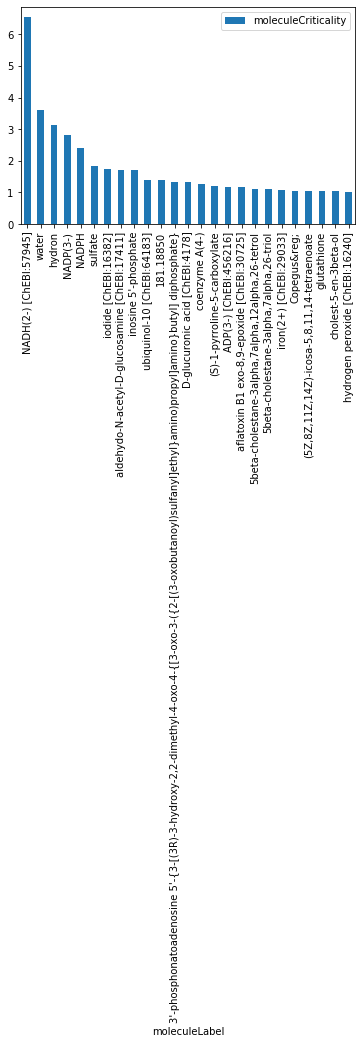

In [84]:
dfMolecules[dfMolecules['moleculeCriticality'] != np.inf].dropna(subset=['moleculeCriticality']).sort_values(by="moleculeCriticality", ascending=False).head(25).plot.bar(x="moleculeLabel", y="moleculeCriticality")

### 3.2.1 Constraint 2 -- Strategy 1 (keep molecules over-represented in reactions from consecutive steps

In [85]:
dfMolecules['pValueNextStrategy1'] = scipy.stats.hypergeom.sf(dfMolecules['nbReactionPairsNext']-1, totalReactionPairsReferenceHierarchyAny, dfMolecules['nbReactionPairsAny'], totalReactionPairsReferenceHierarchyNext)

resultBH = statsmodels.stats.multitest.multipletests(dfMolecules['pValueNextStrategy1'], alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)
dfMolecules['adjPvalueNextStrategy1'] = resultBH[1]
dfMolecules

moleculeReference  \
0     http://www.reactome.org/biopax/79/48887#SmallM...   
1     http://www.reactome.org/biopax/79/48887#SmallM...   
2     http://www.reactome.org/biopax/79/48887#SmallM...   
3     http://www.reactome.org/biopax/79/48887#SmallM...   
4     http://www.reactome.org/biopax/79/48887#SmallM...   
...                                                 ...   
1145  http://www.reactome.org/biopax/79/48887#SmallM...   
1146  http://www.reactome.org/biopax/79/48887#SmallM...   
1147  http://www.reactome.org/biopax/79/48887#SmallM...   
1148  http://www.reactome.org/biopax/79/48887#SmallM...   
1149  http://www.reactome.org/biopax/79/48887#SmallM...   

                                          moleculeLabel    chebiIdent  \
0                                                 water   CHEBI:15377   
1                                                hydron   CHEBI:15378   
2                                ADP(3-) [ChEBI:456216]  CHEBI:456216   
3                                                   atp   CHEBI:30616   
4                             INORGANIC PHOSPHATE GROUP   CHEBI:43474   
...                                                 ...           ...   
1145                               methylselenenic acid   CHEBI:77062   
1146                                       aflatoxin M1   CHEBI:78576   
1147               indole-5,6-quinone-2-carboxylic acid   CHEBI:81394   
1148                           benzo[a]pyrene-7,8-dione   CHEBI:87752   
1149  alpha-D-Man-(1->3)-[alpha-D-Man-(1->6)]-beta-D...   CHEBI:91279   

      nbReactionPairsAny  criticalInNbReactionPairsAny  \
0                 659594                        656260   
1                 372384                        357234   
2                 284400                        278405   
3                 232625                        231985   
4                 145152                        138897   
...                  ...                           ...   
1145                   2                             2   
1146                   2                             2   
1147                   2                             2   
1148                   2                             2   
1149                   2                             2   

      moleculeCriticalityPairsAny  nbReactionPairsNext  \
0                        0.994945                   58   
1                        0.959316                  196   
2                        0.978921                   30   
3                        0.997249                   40   
4                        0.956907                   18   
...                           ...                  ...   
1145                     1.000000                    2   
1146                     1.000000                    2   
1147                     1.000000                    0   
1148                     1.000000                    0   
1149                     1.000000                    2   

      criticalInNbReactionPairsNext  moleculeCriticalityPairsNext  \
0                                16                      0.275862   
1                                60                      0.306122   
2                                25                      0.833333   
3                                40                      1.000000   
4                                18                      1.000000   
...                             ...                           ...   
1145                              2                      1.000000   
1146                              2                      1.000000   
1147                              0                           NaN   
1148                              0                           NaN   
1149                              2                      1.000000   

      moleculeCriticality  pValueNextStrategy1  adjPvalueNextStrategy1  
0                3.606677             1.000000                1.000000  
1                3.133766             1.000000                1.000000  
2         

In [86]:
# THE 21 MOLECULES THAT WERE REJECTED BY EA STRATEGY1

print("Nb of molecules connected by consecutive steps and rejected by strategy1: {} out of {}".format(len(dfMolecules[(dfMolecules['nbReactionPairsNext'] > 0) & (dfMolecules['adjPvalueNextStrategy1'] >= 0.05)]), len(dfMolecules[dfMolecules['nbReactionPairsNext'] > 0])))
dfMolecules[(dfMolecules['nbReactionPairsNext'] > 0) & (dfMolecules['adjPvalueNextStrategy1'] >= 0.05)]

Nb of molecules connected by consecutive steps and rejected by strategy1: 21 out of 826


moleculeReference  \
0    http://www.reactome.org/biopax/79/48887#SmallM...   
1    http://www.reactome.org/biopax/79/48887#SmallM...   
2    http://www.reactome.org/biopax/79/48887#SmallM...   
3    http://www.reactome.org/biopax/79/48887#SmallM...   
4    http://www.reactome.org/biopax/79/48887#SmallM...   
5    http://www.reactome.org/biopax/79/48887#SmallM...   
6    http://www.reactome.org/biopax/79/48887#SmallM...   
7    http://www.reactome.org/biopax/79/48887#SmallM...   
8    http://www.reactome.org/biopax/79/48887#SmallM...   
10   http://www.reactome.org/biopax/79/48887#SmallM...   
11   http://www.reactome.org/biopax/79/48887#SmallM...   
12   http://www.reactome.org/biopax/79/48887#SmallM...   
13   http://www.reactome.org/biopax/79/48887#SmallM...   
16   http://www.reactome.org/biopax/79/48887#SmallM...   
37   http://www.reactome.org/biopax/79/48887#SmallM...   
45   http://www.reactome.org/biopax/79/48887#SmallM...   
56   http://www.reactome.org/biopax/79/48887#SmallM...   
71   http://www.reactome.org/biopax/79/48887#SmallM...   
80   http://www.reactome.org/biopax/79/48887#SmallM...   
101  http://www.reactome.org/biopax/79/48887#SmallM...   
183  http://www.reactome.org/biopax/79/48887#SmallM...   

                                     moleculeLabel    chebiIdent  \
0                                            water   CHEBI:15377   
1                                           hydron   CHEBI:15378   
2                           ADP(3-) [ChEBI:456216]  CHEBI:456216   
3                                              atp   CHEBI:30616   
4                        INORGANIC PHOSPHATE GROUP   CHEBI:43474   
5                                            NADPH   CHEBI:57783   
6                                   coenzyme A(4-)   CHEBI:57287   
7                                         NADP(3-)   CHEBI:58349   
8                                       sodium(1+)   CHEBI:29101   
10                    guanosine 5'-diphosphate(3-)   CHEBI:58189   
11                                      acetyl-CoA   CHEBI:57288   
12                                          NAD(+)   CHEBI:57540   
13   adenosine 5'-monophosphate(2-) [ChEBI:456215]  CHEBI:456215   
16                                       Potassium   CHEBI:29103   
37                   alpha-D-glucose [ChEBI:17925]   CHEBI:17925   
45                          zinc(2+) [ChEBI:29105]   CHEBI:29105   
56                 hydrogencarbonate [ChEBI:17544]   CHEBI:17544   
71     nucleoside 5'-triphoshate(4-) [ChEBI:61557]   CHEBI:61557   
80                                        ammonium   CHEBI:28938   
101                     hexadecanoate [ChEBI:7896]    CHEBI:7896   
183                         glycerol [ChEBI:17754]   CHEBI:17754   

     nbReactionPairsAny  criticalInNbReactionPairsAny  \
0                659594                        656260   
1                372384                        357234   
2                284400                        278405   
3                232625                        231985   
4                145152                        138897   
5                 47300                         22695   
6                 43884                         42920   
7                 43650                         40975   
8                 29104                         27470   
10                25560                         25288   
11                18564                         16947   
12                18450                         16315   
13                17024                         15800   
16                12240                         11320   
37                 1728                          1712   
45                 1190                          1184   
56                  986                           748   
71                  696                           690   
80                  572                           510   
101                 416                           316   
183                 156                           156   

     mol

> **BUG???:** several molecule references have "NADPH" as a label
> - `CHEBI:57783` is NADPH(4-)
> - `CHEBI:16474` is NADPH

In [87]:
dfMolecules[dfMolecules['moleculeLabel'] == "NADPH"]

moleculeReference moleculeLabel  \
5    http://www.reactome.org/biopax/79/48887#SmallM...         NADPH   
169  http://www.reactome.org/biopax/79/48887#SmallM...         NADPH   

      chebiIdent  nbReactionPairsAny  criticalInNbReactionPairsAny  \
5    CHEBI:57783               47300                         22695   
169  CHEBI:16474                 177                           174   

     moleculeCriticalityPairsAny  nbReactionPairsNext  \
5                       0.479810                   25   
169                     0.983051                    0   

     criticalInNbReactionPairsNext  moleculeCriticalityPairsNext  \
5                                5                           0.2   
169                              0                           NaN   

     moleculeCriticality  pValueNextStrategy1  adjPvalueNextStrategy1  
5               2.399049                  1.0                     1.0  
169                  NaN                  1.0                     1.0

In [88]:
dfMolecules[dfMolecules['moleculeLabel'].duplicated()]

moleculeReference moleculeLabel  \
155  http://www.reactome.org/biopax/79/48887#SmallM...   glutathione   
169  http://www.reactome.org/biopax/79/48887#SmallM...         NADPH   

      chebiIdent  nbReactionPairsAny  criticalInNbReactionPairsAny  \
155  CHEBI:16856                 210                           208   
169  CHEBI:16474                 177                           174   

     moleculeCriticalityPairsAny  nbReactionPairsNext  \
155                     0.990476                    4   
169                     0.983051                    0   

     criticalInNbReactionPairsNext  moleculeCriticalityPairsNext  \
155                              4                           1.0   
169                              0                           NaN   

     moleculeCriticality  pValueNextStrategy1  adjPvalueNextStrategy1  
155             0.990476             0.005626                0.008179  
169                  NaN             1.000000                1.000000

In [89]:
for currentMoleculeReference in list(dfMolecules[dfMolecules['moleculeLabel'].duplicated()]['moleculeReference']):
    print(currentMoleculeReference)

http://www.reactome.org/biopax/79/48887#SmallMoleculeReference820
http://www.reactome.org/biopax/79/48887#SmallMoleculeReference478


> **TODO:** compare with the 46 `bp3:SmallMolecule` that were rejected and compute
> - how many of the 46 `bp3:SmallMolecule` point to one of the 27 `bp3:SmallMoleculeReference`
> - which of the `bp3:SmallMoleculeReference` are not associated with any of the 46 `bp3:SmallMolecule` (and are therefore new)

### 3.2.2 Constraint 2 -- Strategy 2 (remove molecules under-represented in reactions from consecutive steps

In [90]:
dfMolecules['pValueNextStrategy2'] = scipy.stats.hypergeom.cdf(dfMolecules['nbReactionPairsNext'], totalReactionPairsReferenceHierarchyAny, dfMolecules['nbReactionPairsAny'], totalReactionPairsReferenceHierarchyNext)

resultBH = statsmodels.stats.multitest.multipletests(dfMolecules['pValueNextStrategy2'], alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)
#print(resultBH)
#print(len(resultBH[1]))
dfMolecules['adjPvalueNextStrategy2'] = resultBH[1]
dfMolecules

moleculeReference  \
0     http://www.reactome.org/biopax/79/48887#SmallM...   
1     http://www.reactome.org/biopax/79/48887#SmallM...   
2     http://www.reactome.org/biopax/79/48887#SmallM...   
3     http://www.reactome.org/biopax/79/48887#SmallM...   
4     http://www.reactome.org/biopax/79/48887#SmallM...   
...                                                 ...   
1145  http://www.reactome.org/biopax/79/48887#SmallM...   
1146  http://www.reactome.org/biopax/79/48887#SmallM...   
1147  http://www.reactome.org/biopax/79/48887#SmallM...   
1148  http://www.reactome.org/biopax/79/48887#SmallM...   
1149  http://www.reactome.org/biopax/79/48887#SmallM...   

                                          moleculeLabel    chebiIdent  \
0                                                 water   CHEBI:15377   
1                                                hydron   CHEBI:15378   
2                                ADP(3-) [ChEBI:456216]  CHEBI:456216   
3                                                   atp   CHEBI:30616   
4                             INORGANIC PHOSPHATE GROUP   CHEBI:43474   
...                                                 ...           ...   
1145                               methylselenenic acid   CHEBI:77062   
1146                                       aflatoxin M1   CHEBI:78576   
1147               indole-5,6-quinone-2-carboxylic acid   CHEBI:81394   
1148                           benzo[a]pyrene-7,8-dione   CHEBI:87752   
1149  alpha-D-Man-(1->3)-[alpha-D-Man-(1->6)]-beta-D...   CHEBI:91279   

      nbReactionPairsAny  criticalInNbReactionPairsAny  \
0                 659594                        656260   
1                 372384                        357234   
2                 284400                        278405   
3                 232625                        231985   
4                 145152                        138897   
...                  ...                           ...   
1145                   2                             2   
1146                   2                             2   
1147                   2                             2   
1148                   2                             2   
1149                   2                             2   

      moleculeCriticalityPairsAny  nbReactionPairsNext  \
0                        0.994945                   58   
1                        0.959316                  196   
2                        0.978921                   30   
3                        0.997249                   40   
4                        0.956907                   18   
...                           ...                  ...   
1145                     1.000000                    2   
1146                     1.000000                    2   
1147                     1.000000                    0   
1148                     1.000000                    0   
1149                     1.000000                    2   

      criticalInNbReactionPairsNext  moleculeCriticalityPairsNext  \
0                                16                      0.275862   
1                                60                      0.306122   
2                                25                      0.833333   
3                                40                      1.000000   
4                                18                      1.000000   
...                             ...                           ...   
1145                              2                      1.000000   
1146                              2                      1.000000   
1147                              0                           NaN   
1148                              0                           NaN   
1149                              2                      1.000000   

      moleculeCriticality  pValueNextStrategy1  adjPvalueNextStrategy1  \
0                3.606677             1.000000                1.000000   
1                3.133766             1.000000                1.000000   
2      

In [91]:
# THE 13 MOLECULES THAT WERE REJECTED BY STRATEGY2
print("Nb of molecules connected by consecutive steps and rejected by strategy2: {} out of {}".format(len(dfMolecules[(dfMolecules['nbReactionPairsNext'] > 0) & (dfMolecules['adjPvalueNextStrategy2'] < 0.05)]), len(dfMolecules[dfMolecules['nbReactionPairsNext'] > 0])))
dfMolecules[(dfMolecules['nbReactionPairsNext'] > 0) & (dfMolecules['adjPvalueNextStrategy2'] < 0.05)]

Nb of molecules connected by consecutive steps and rejected by strategy2: 13 out of 826


moleculeReference  \
0   http://www.reactome.org/biopax/79/48887#SmallM...   
1   http://www.reactome.org/biopax/79/48887#SmallM...   
2   http://www.reactome.org/biopax/79/48887#SmallM...   
3   http://www.reactome.org/biopax/79/48887#SmallM...   
4   http://www.reactome.org/biopax/79/48887#SmallM...   
5   http://www.reactome.org/biopax/79/48887#SmallM...   
6   http://www.reactome.org/biopax/79/48887#SmallM...   
7   http://www.reactome.org/biopax/79/48887#SmallM...   
8   http://www.reactome.org/biopax/79/48887#SmallM...   
10  http://www.reactome.org/biopax/79/48887#SmallM...   
12  http://www.reactome.org/biopax/79/48887#SmallM...   
13  http://www.reactome.org/biopax/79/48887#SmallM...   
16  http://www.reactome.org/biopax/79/48887#SmallM...   

                                    moleculeLabel    chebiIdent  \
0                                           water   CHEBI:15377   
1                                          hydron   CHEBI:15378   
2                          ADP(3-) [ChEBI:456216]  CHEBI:456216   
3                                             atp   CHEBI:30616   
4                       INORGANIC PHOSPHATE GROUP   CHEBI:43474   
5                                           NADPH   CHEBI:57783   
6                                  coenzyme A(4-)   CHEBI:57287   
7                                        NADP(3-)   CHEBI:58349   
8                                      sodium(1+)   CHEBI:29101   
10                   guanosine 5'-diphosphate(3-)   CHEBI:58189   
12                                         NAD(+)   CHEBI:57540   
13  adenosine 5'-monophosphate(2-) [ChEBI:456215]  CHEBI:456215   
16                                      Potassium   CHEBI:29103   

    nbReactionPairsAny  criticalInNbReactionPairsAny  \
0               659594                        656260   
1               372384                        357234   
2               284400                        278405   
3               232625                        231985   
4               145152                        138897   
5                47300                         22695   
6                43884                         42920   
7                43650                         40975   
8                29104                         27470   
10               25560                         25288   
12               18450                         16315   
13               17024                         15800   
16               12240                         11320   

    moleculeCriticalityPairsAny  nbReactionPairsNext  \
0                      0.994945                   58   
1                      0.959316                  196   
2                      0.978921                   30   
3                      0.997249                   40   
4                      0.956907                   18   
5                      0.479810                   25   
6                      0.978033                   36   
7                      0.938717                   15   
8                      0.943857                    4   
10                     0.989358                    8   
12                     0.884282                   10   
13                     0.928102                   24   
16                     0.924837                    8   

    criticalInNbReactionPairsNext  moleculeCriticalityPairsNext  \
0                              16                      0.275862   
1                              60                      0.306122   
2                              25                      0.833333   
3                              40                      1.000000   
4                              18                      1.000000   
5                               5                      0.200000   
6                              28                      0.777778   
7                               5                      0.333333   
8                               0                      0.000000   
10                              0                      0.0

### 3.2.3 Constraint 2 -- Strategy 3 (remove molecules over-represented in reactions NOT from consecutive steps

In [92]:
dfMolecules['pValueNextStrategy3'] = scipy.stats.hypergeom.sf(dfMolecules['nbReactionPairsAny']-dfMolecules['nbReactionPairsNext']-1, totalReactionPairsReferenceHierarchyAny, dfMolecules['nbReactionPairsAny'], totalReactionPairsReferenceHierarchyAny-totalReactionPairsReferenceHierarchyNext)

resultBH = statsmodels.stats.multitest.multipletests(dfMolecules['pValueNextStrategy3'], alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)
dfMolecules['adjPvalueNextStrategy3'] = resultBH[1]
dfMolecules

moleculeReference  \
0     http://www.reactome.org/biopax/79/48887#SmallM...   
1     http://www.reactome.org/biopax/79/48887#SmallM...   
2     http://www.reactome.org/biopax/79/48887#SmallM...   
3     http://www.reactome.org/biopax/79/48887#SmallM...   
4     http://www.reactome.org/biopax/79/48887#SmallM...   
...                                                 ...   
1145  http://www.reactome.org/biopax/79/48887#SmallM...   
1146  http://www.reactome.org/biopax/79/48887#SmallM...   
1147  http://www.reactome.org/biopax/79/48887#SmallM...   
1148  http://www.reactome.org/biopax/79/48887#SmallM...   
1149  http://www.reactome.org/biopax/79/48887#SmallM...   

                                          moleculeLabel    chebiIdent  \
0                                                 water   CHEBI:15377   
1                                                hydron   CHEBI:15378   
2                                ADP(3-) [ChEBI:456216]  CHEBI:456216   
3                                                   atp   CHEBI:30616   
4                             INORGANIC PHOSPHATE GROUP   CHEBI:43474   
...                                                 ...           ...   
1145                               methylselenenic acid   CHEBI:77062   
1146                                       aflatoxin M1   CHEBI:78576   
1147               indole-5,6-quinone-2-carboxylic acid   CHEBI:81394   
1148                           benzo[a]pyrene-7,8-dione   CHEBI:87752   
1149  alpha-D-Man-(1->3)-[alpha-D-Man-(1->6)]-beta-D...   CHEBI:91279   

      nbReactionPairsAny  criticalInNbReactionPairsAny  \
0                 659594                        656260   
1                 372384                        357234   
2                 284400                        278405   
3                 232625                        231985   
4                 145152                        138897   
...                  ...                           ...   
1145                   2                             2   
1146                   2                             2   
1147                   2                             2   
1148                   2                             2   
1149                   2                             2   

      moleculeCriticalityPairsAny  nbReactionPairsNext  \
0                        0.994945                   58   
1                        0.959316                  196   
2                        0.978921                   30   
3                        0.997249                   40   
4                        0.956907                   18   
...                           ...                  ...   
1145                     1.000000                    2   
1146                     1.000000                    2   
1147                     1.000000                    0   
1148                     1.000000                    0   
1149                     1.000000                    2   

      criticalInNbReactionPairsNext  moleculeCriticalityPairsNext  \
0                                16                      0.275862   
1                                60                      0.306122   
2                                25                      0.833333   
3                                40                      1.000000   
4                                18                      1.000000   
...                             ...                           ...   
1145                              2                      1.000000   
1146                              2                      1.000000   
1147                              0                           NaN   
1148                              0                           NaN   
1149                              2                      1.000000   

      moleculeCriticality  pValueNextStrategy1  adjPvalueNextStrategy1  \
0                3.606677             1.000000                1.000000   
1                3.133766             1.000000                1.000000   
2      

In [93]:
# THE 13 MOLECULES THAT WERE REJECTED BY STRATEGY3

print("Nb of molecules connected by consecutive steps and rejected by strategy3: {} out of {}".format(len(dfMolecules[(dfMolecules['nbReactionPairsNext'] > 0) & (dfMolecules['adjPvalueNextStrategy3'] < 0.05)]), len(dfMolecules[dfMolecules['nbReactionPairsNext'] > 0])))
dfMolecules[(dfMolecules['nbReactionPairsNext'] > 0) & (dfMolecules['adjPvalueNextStrategy3'] < 0.05)]

Nb of molecules connected by consecutive steps and rejected by strategy3: 13 out of 826


moleculeReference  \
0   http://www.reactome.org/biopax/79/48887#SmallM...   
1   http://www.reactome.org/biopax/79/48887#SmallM...   
2   http://www.reactome.org/biopax/79/48887#SmallM...   
3   http://www.reactome.org/biopax/79/48887#SmallM...   
4   http://www.reactome.org/biopax/79/48887#SmallM...   
5   http://www.reactome.org/biopax/79/48887#SmallM...   
6   http://www.reactome.org/biopax/79/48887#SmallM...   
7   http://www.reactome.org/biopax/79/48887#SmallM...   
8   http://www.reactome.org/biopax/79/48887#SmallM...   
10  http://www.reactome.org/biopax/79/48887#SmallM...   
12  http://www.reactome.org/biopax/79/48887#SmallM...   
13  http://www.reactome.org/biopax/79/48887#SmallM...   
16  http://www.reactome.org/biopax/79/48887#SmallM...   

                                    moleculeLabel    chebiIdent  \
0                                           water   CHEBI:15377   
1                                          hydron   CHEBI:15378   
2                          ADP(3-) [ChEBI:456216]  CHEBI:456216   
3                                             atp   CHEBI:30616   
4                       INORGANIC PHOSPHATE GROUP   CHEBI:43474   
5                                           NADPH   CHEBI:57783   
6                                  coenzyme A(4-)   CHEBI:57287   
7                                        NADP(3-)   CHEBI:58349   
8                                      sodium(1+)   CHEBI:29101   
10                   guanosine 5'-diphosphate(3-)   CHEBI:58189   
12                                         NAD(+)   CHEBI:57540   
13  adenosine 5'-monophosphate(2-) [ChEBI:456215]  CHEBI:456215   
16                                      Potassium   CHEBI:29103   

    nbReactionPairsAny  criticalInNbReactionPairsAny  \
0               659594                        656260   
1               372384                        357234   
2               284400                        278405   
3               232625                        231985   
4               145152                        138897   
5                47300                         22695   
6                43884                         42920   
7                43650                         40975   
8                29104                         27470   
10               25560                         25288   
12               18450                         16315   
13               17024                         15800   
16               12240                         11320   

    moleculeCriticalityPairsAny  nbReactionPairsNext  \
0                      0.994945                   58   
1                      0.959316                  196   
2                      0.978921                   30   
3                      0.997249                   40   
4                      0.956907                   18   
5                      0.479810                   25   
6                      0.978033                   36   
7                      0.938717                   15   
8                      0.943857                    4   
10                     0.989358                    8   
12                     0.884282                   10   
13                     0.928102                   24   
16                     0.924837                    8   

    criticalInNbReactionPairsNext  moleculeCriticalityPairsNext  \
0                              16                      0.275862   
1                              60                      0.306122   
2                              25                      0.833333   
3                              40                      1.000000   
4                              18                      1.000000   
5                               5                      0.200000   
6                              28                      0.777778   
7                               5                      0.333333   
8                               0                      0.000000   
10                              0                      0.0

> **Interpretation:** 

> **Answer from Florence 2024-12-22:**
> - definitely blacklist
>     - water
>     - hydron H+
> - optionnaly blacklist
>     - coenzyme A
>     - adp
>     - atp
>     - amp (adénosine monophosphate)
>     - nad+
>     - nadph
>     - nadp
>     - inorganic phosphate (Pi)
> - definitely NOT blacklist
>     - guanosine 5 diphosphate
>     - sodium
>     - potassium

# 4. Criticality

## 4.1 Distribution of the number of molecules connecting consecutive reactions

### 4.1.1 Between any consecutive reactions

In [131]:
constraintBetweenReactionsClause = ""
#constraintBetweenReactionsClause = """
#  ?step1 bp3:stepProcess ?reaction1 .
#  ?step1 rdf:type bp3:PathwayStep .
#  ?step1 bp3:nextStep ?step2 .
#  ?step2 rdf:type bp3:PathwayStep .
#  ?step2 bp3:stepProcess ?reaction2 .
#"""

In [132]:
query = """
SELECT ?reaction1 ?reaction2 (COUNT(DISTINCT ?molecule) AS ?nbMolecules) 
WHERE {
  #constraintBetweenReactionsClause#
  
  ?reaction1 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
  ?reaction1 bp3:right ?molecule .
  ?reaction2 bp3:left ?molecule .
  ?reaction2 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
}
GROUP BY ?reaction1 ?reaction2
"""

df = sparqldataframe.query(endpointURL, prefixes+query.replace("#constraintBetweenReactionsClause#", constraintBetweenReactionsClause))
df['nbMolecules'] = pandas.to_numeric(df['nbMolecules'])
#df.sort_values(by='nbMolecules', ascending=False)
print("Nb of pairs of reactions: {}, {} of which ({:.2f}%) connected by >=1 molecules".format(df.shape[0], df[df['nbMolecules'] > 1].shape[0], df[df['nbMolecules'] > 1].shape[0]/df.shape[0]*100))
df.groupby(['nbMolecules']).count().drop(columns=['reaction2']).rename(columns={'reaction1': 'nbReactionsPairs'})

Nb of pairs of reactions: 281953, 5252 of which (1.86%) connected by >=1 molecules


nbReactionsPairs
nbMolecules                  
1                      276701
2                        5098
3                         105
4                          36
5                           5
6                           2
7                           3
8                           1
9                           1
12                          1

In [133]:
query = """
SELECT ?reaction1 ?reaction2 (COUNT(DISTINCT ?molecule) AS ?nbMolecules) 
WHERE {
  #constraintBetweenReactionsClause#
  
  {
    ?reaction1 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
    ?reaction1 bp3:right ?molecule .
    ?reaction2 bp3:left ?molecule .
    ?reaction2 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
  }
  UNION
  {
    ?reaction1 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
    ?reaction1 bp3:right ?molecule .
    ?molecule bp3:entityReference ?moleculeReference .
    ?reaction2 bp3:left/bp3:entityReference ?moleculeReference .
    ?reaction2 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
  }
  
}
GROUP BY ?reaction1 ?reaction2
"""

df = sparqldataframe.query(endpointURL, prefixes+query.replace("#constraintBetweenReactionsClause#", constraintBetweenReactionsClause))
df['nbMolecules'] = pandas.to_numeric(df['nbMolecules'])
#df.sort_values(by='nbMolecules', ascending=False)
print("Nb of pairs of reactions: {}, {} of which ({:.2f}%) connected by >=1 molecules".format(df.shape[0], df[df['nbMolecules'] > 1].shape[0], df[df['nbMolecules'] > 1].shape[0]/df.shape[0]*100))
df.groupby(['nbMolecules']).count().drop(columns=['reaction2']).rename(columns={'reaction1': 'nbReactionsPairs'})

Nb of pairs of reactions: 741165, 12286 of which (1.66%) connected by >=1 molecules


nbReactionsPairs
nbMolecules                  
1                      728879
2                       11865
3                         300
4                          67
5                          16
6                          12
7                           3
8                           2
9                          12
12                          9

In [134]:
query = """
SELECT ?reaction1 ?reaction2 (COUNT(DISTINCT ?molecule) AS ?nbMolecules) 
WHERE {
  #constraintBetweenReactionsClause#
  
  {
    ?reaction1 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
    ?reaction1 bp3:right ?molecule .
    ?reaction2 bp3:left ?molecule .
    ?reaction2 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
  }
  UNION
  {
    ?reaction1 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
    ?reaction1 bp3:right ?molecule .
    ?molecule bp3:entityReference ?moleculeReference .
    ?reaction2 bp3:left/bp3:entityReference ?moleculeReference .
    ?reaction2 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
  }
  UNION
  {
    ?reaction1 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
    ?reaction1 bp3:right ?molecule .
    ?molecule bp3:entityReference ?moleculeReference1 .
    ?moleculeReference1 bp3:xref ?moleculeXref1 .
    ?moleculeXref1 bp3:db "ChEBI" .
    ?moleculeXref1 bp3:id ?chebiID1 .    
    BIND(IRI(REPLACE(?chebiID1, "CHEBI:", "http://purl.obolibrary.org/obo/CHEBI_")) AS ?chebiMolecule1)
    # MAGIC HAPPENS HERE!
    ?chebiMolecule1 rdfs:subClassOf* ?chebiMolecule2 .
    BIND(REPLACE(STR(?chebiMolecule2), "http://purl.obolibrary.org/obo/CHEBI_", "CHEBI:") AS ?chebiID2)
    ?moleculeXref2 bp3:id ?chebiID2 .
    ?moleculeXref2 bp3:db "ChEBI" .
  
    ?reaction2 bp3:left/bp3:entityReference/bp3:xref ?moleculeXref2 .
    ?reaction2 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
  }
  
}
GROUP BY ?reaction1 ?reaction2
"""

df = sparqldataframe.query(endpointURL, prefixes+query.replace("#constraintBetweenReactionsClause#", constraintBetweenReactionsClause))
df['nbMolecules'] = pandas.to_numeric(df['nbMolecules'])
#df.sort_values(by='nbMolecules', ascending=False)
print("Nb of pairs of reactions: {}, {} of which ({:.2f}%) connected by >=1 molecules".format(df.shape[0], df[df['nbMolecules'] > 1].shape[0], df[df['nbMolecules'] > 1].shape[0]/df.shape[0]*100))
df.groupby(['nbMolecules']).count().drop(columns=['reaction2']).rename(columns={'reaction1': 'nbReactionsPairs'})

Nb of pairs of reactions: 774670, 14899 of which (1.92%) connected by >=1 molecules


nbReactionsPairs
nbMolecules                  
1                      759771
2                       14334
3                         424
4                          87
5                          16
6                          12
7                           3
8                           2
9                          12
12                          9

### 4.1.2 Between consecutive reactions from consecutive PathwaySteps

In [135]:
constraintBetweenReactionsClause = """
  ?step1 bp3:stepProcess ?reaction1 .
  ?step1 rdf:type bp3:PathwayStep .
  ?step1 bp3:nextStep ?step2 .
  ?step2 rdf:type bp3:PathwayStep .
  ?step2 bp3:stepProcess ?reaction2 .
"""

In [136]:
query = """
SELECT ?reaction1 ?reaction2 (COUNT(DISTINCT ?molecule) AS ?nbMolecules) 
WHERE {
  #constraintBetweenReactionsClause#
  
  ?reaction1 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
  ?reaction1 bp3:right ?molecule .
  ?reaction2 bp3:left ?molecule .
  ?reaction2 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
}
GROUP BY ?reaction1 ?reaction2
"""

df = sparqldataframe.query(endpointURL, prefixes+query.replace("#constraintBetweenReactionsClause#", constraintBetweenReactionsClause))
df['nbMolecules'] = pandas.to_numeric(df['nbMolecules'])
#df.sort_values(by='nbMolecules', ascending=False)
print("Nb of pairs of reactions: {}, {} of which ({:.2f}%) connected by >=1 molecules".format(df.shape[0], df[df['nbMolecules'] > 1].shape[0], df[df['nbMolecules'] > 1].shape[0]/df.shape[0]*100))
df.groupby(['nbMolecules']).count().drop(columns=['reaction2']).rename(columns={'reaction1': 'nbReactionsPairs'})

Nb of pairs of reactions: 9269, 137 of which (1.48%) connected by >=1 molecules


nbReactionsPairs
nbMolecules                  
1                        9132
2                         123
3                          12
4                           2

In [137]:
query = """
SELECT ?reaction1 ?reaction2 (COUNT(DISTINCT ?molecule) AS ?nbMolecules) 
WHERE {
  #constraintBetweenReactionsClause#
  
  {
    ?reaction1 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
    ?reaction1 bp3:right ?molecule .
    ?reaction2 bp3:left ?molecule .
    ?reaction2 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
  }
  UNION
  {
    ?reaction1 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
    ?reaction1 bp3:right ?molecule .
    ?molecule bp3:entityReference ?moleculeReference .
    ?reaction2 bp3:left/bp3:entityReference ?moleculeReference .
    ?reaction2 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
  }
  
}
GROUP BY ?reaction1 ?reaction2
"""

df = sparqldataframe.query(endpointURL, prefixes+query.replace("#constraintBetweenReactionsClause#", constraintBetweenReactionsClause))
df['nbMolecules'] = pandas.to_numeric(df['nbMolecules'])
#df.sort_values(by='nbMolecules', ascending=False)
print("Nb of pairs of reactions: {}, {} of which ({:.2f}%) connected by >=1 molecules".format(df.shape[0], df[df['nbMolecules'] > 1].shape[0], df[df['nbMolecules'] > 1].shape[0]/df.shape[0]*100))
df.groupby(['nbMolecules']).count().drop(columns=['reaction2']).rename(columns={'reaction1': 'nbReactionsPairs'})

Nb of pairs of reactions: 9366, 259 of which (2.77%) connected by >=1 molecules


nbReactionsPairs
nbMolecules                  
1                        9107
2                         224
3                          21
4                           4
9                          10

In [138]:
query = """
SELECT ?reaction1 ?reaction2 (COUNT(DISTINCT ?molecule) AS ?nbMolecules) 
WHERE {
  #constraintBetweenReactionsClause#
  
  {
    ?reaction1 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
    ?reaction1 bp3:right ?molecule .
    ?reaction2 bp3:left ?molecule .
    ?reaction2 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
  }
  UNION
  {
    ?reaction1 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
    ?reaction1 bp3:right ?molecule .
    ?molecule bp3:entityReference ?moleculeReference .
    ?reaction2 bp3:left/bp3:entityReference ?moleculeReference .
    ?reaction2 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
  }
  UNION
  {
    ?reaction1 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
    ?reaction1 bp3:right ?molecule .
    ?molecule bp3:entityReference ?moleculeReference1 .
    ?moleculeReference1 bp3:xref ?moleculeXref1 .
    ?moleculeXref1 bp3:db "ChEBI" .
    ?moleculeXref1 bp3:id ?chebiID1 .    
    BIND(IRI(REPLACE(?chebiID1, "CHEBI:", "http://purl.obolibrary.org/obo/CHEBI_")) AS ?chebiMolecule1)
    # MAGIC HAPPENS HERE!
    ?chebiMolecule1 rdfs:subClassOf* ?chebiMolecule2 .
    BIND(REPLACE(STR(?chebiMolecule2), "http://purl.obolibrary.org/obo/CHEBI_", "CHEBI:") AS ?chebiID2)
    ?moleculeXref2 bp3:id ?chebiID2 .
    ?moleculeXref2 bp3:db "ChEBI" .
  
    ?reaction2 bp3:left/bp3:entityReference/bp3:xref ?moleculeXref2 .
    ?reaction2 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
  }
  
}
GROUP BY ?reaction1 ?reaction2
"""

df = sparqldataframe.query(endpointURL, prefixes+query.replace("#constraintBetweenReactionsClause#", constraintBetweenReactionsClause))
df['nbMolecules'] = pandas.to_numeric(df['nbMolecules'])
#df.sort_values(by='nbMolecules', ascending=False)
print("Nb of pairs of reactions: {}, {} of which ({:.2f}%) connected by >=1 molecules".format(df.shape[0], df[df['nbMolecules'] > 1].shape[0], df[df['nbMolecules'] > 1].shape[0]/df.shape[0]*100))
df.groupby(['nbMolecules']).count().drop(columns=['reaction2']).rename(columns={'reaction1': 'nbReactionsPairs'})

Nb of pairs of reactions: 9369, 260 of which (2.78%) connected by >=1 molecules


nbReactionsPairs
nbMolecules                  
1                        9109
2                         225
3                          21
4                           4
9                          10

## 4.2 Distribution of the number of nextStep originating from a reaction (or of the degree in the various graphs of reactions?)

In [20]:
query = """
SELECT (COUNT(DISTINCT ?step) AS ?nbPathwaySteps) 
WHERE {
  ?step rdf:type bp3:PathwayStep .
}
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
#df['nbMolecules'] = pandas.to_numeric(df['nbMolecules'])
df

nbPathwaySteps
0          17999

In [75]:
query = """
# nb of pairs of PathwayStep connected by nextStep

#SELECT (COUNT(DISTINCT ?step ?nextStep) AS ?nbNextStepRelations) 
SELECT (COUNT(*) AS ?nbNextStepRelations) 

WHERE {
  ?step1 rdf:type bp3:PathwayStep .
  ?step1 bp3:nextStep ?step2 .
  ?step2 rdf:type bp3:PathwayStep .
}
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

nbNextStepRelations
0               14245

In [74]:
query = """
# nb of nextStep associated to pairs of reactions

#SELECT (COUNT(DISTINCT ?step ?nextStep) AS ?nbNextStepRelations) 
SELECT (COUNT(*) AS ?nbNextStepRelations) 

WHERE {
  SELECT DISTINCT ?step1 ?step2
  WHERE {
    ?step1 rdf:type bp3:PathwayStep .
    ?step1 bp3:nextStep ?step2 .
    ?step2 rdf:type bp3:PathwayStep .
    ?step1 bp3:stepProcess ?reaction1 .
    ?step2 bp3:stepProcess ?reaction2 .
  }
}
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

nbNextStepRelations
0               14245

In [21]:
query = """
# nb of nextStep associated to pairs of reactions

#SELECT (COUNT(DISTINCT ?step ?nextStep) AS ?nbNextStepRelations) 
SELECT (COUNT(*) AS ?nbNextStepRelations) 

WHERE {
  SELECT DISTINCT ?step1 ?step2
  WHERE {
    ?step1 rdf:type bp3:PathwayStep .
    ?step1 bp3:nextStep ?step2 .
    ?step2 rdf:type bp3:PathwayStep .
    
    ?step1 bp3:stepProcess ?reaction1 .
    ?reaction1 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
    
    ?step2 bp3:stepProcess ?reaction2 .
    ?reaction2 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
  }
}
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

nbNextStepRelations
0               13995

>  **Interpretation:**
> - 17,999 PathwaySteps
> - 14,245 nextStep connections
> => not all the PathwaySteps are connected by nextStep (cf.infra)

In [27]:
query = """
# Outdegree of nextStep

SELECT ?step (COUNT(DISTINCT ?step2) AS ?nbNextSteps) 
WHERE {
  ?step rdf:type bp3:PathwayStep .
  ?step bp3:nextStep ?step2 .
  ?step2 rdf:type bp3:PathwayStep .
}
GROUP BY ?step
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df['nbNextSteps'] = pandas.to_numeric(df['nbNextSteps'])
print("Nb of PathwaySteps having at least a nextStep: {}".format(df.shape[0]))
df.sort_values(by='nbNextSteps', ascending=False).head(25)

Nb of PathwaySteps having at least a nextStep: 8943


step  nbNextSteps
2249  http://www.reactome.org/biopax/79/48887#Pathwa...           95
3095  http://www.reactome.org/biopax/79/48887#Pathwa...           59
3096  http://www.reactome.org/biopax/79/48887#Pathwa...           59
4804  http://www.reactome.org/biopax/79/48887#Pathwa...           58
3303  http://www.reactome.org/biopax/79/48887#Pathwa...           47
672   http://www.reactome.org/biopax/79/48887#Pathwa...           45
8412  http://www.reactome.org/biopax/79/48887#Pathwa...           38
3384  http://www.reactome.org/biopax/79/48887#Pathwa...           36
2259  http://www.reactome.org/biopax/79/48887#Pathwa...           33
5048  http://www.reactome.org/biopax/79/48887#Pathwa...           32
5640  http://www.reactome.org/biopax/79/48887#Pathwa...           30
5763  http://www.reactome.org/biopax/79/48887#Pathwa...           30
7865  http://www.reactome.org/biopax/79/48887#Pathwa...           28
5646  http://www.reactome.org/biopax/79/48887#Pathwa...           28
5648  http://www.reactome.org/biopax/79/48887#Pathwa...           28
5642  http://www.reactome.org/biopax/79/48887#Pathwa...           28
5760  http://www.reactome.org/biopax/79/48887#Pathwa...           28
2263  http://www.reactome.org/biopax/79/48887#Pathwa...           27
3212  http://www.reactome.org/biopax/79/48887#Pathwa...           26
2771  http://www.reactome.org/biopax/79/48887#Pathwa...           25
4124  http://www.reactome.org/biopax/79/48887#Pathwa...           24
2933  http://www.reactome.org/biopax/79/48887#Pathwa...           23
6531  http://www.reactome.org/biopax/79/48887#Pathwa...           22
2062  http://www.reactome.org/biopax/79/48887#Pathwa...           22
6858  http://www.reactome.org/biopax/79/48887#Pathwa...           21

In [28]:
query = """
# Indegree of nextStep

SELECT ?step2 (COUNT(DISTINCT ?step) AS ?nbPreviousSteps) 
WHERE {
  ?step rdf:type bp3:PathwayStep .
  ?step bp3:nextStep ?step2 .
  ?step2 rdf:type bp3:PathwayStep .
}
GROUP BY ?step2
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df['nbPreviousSteps'] = pandas.to_numeric(df['nbPreviousSteps'])
print("Nb of PathwaySteps being a nextStep: {}".format(df.shape[0]))
df.sort_values(by='nbPreviousSteps', ascending=False).head(25)

Nb of PathwaySteps being a nextStep: 10627


step2  nbPreviousSteps
4395   http://www.reactome.org/biopax/79/48887#Pathwa...               59
3662   http://www.reactome.org/biopax/79/48887#Pathwa...               35
430    http://www.reactome.org/biopax/79/48887#Pathwa...               31
6663   http://www.reactome.org/biopax/79/48887#Pathwa...               30
4429   http://www.reactome.org/biopax/79/48887#Pathwa...               30
9403   http://www.reactome.org/biopax/79/48887#Pathwa...               28
5949   http://www.reactome.org/biopax/79/48887#Pathwa...               23
8416   http://www.reactome.org/biopax/79/48887#Pathwa...               21
8406   http://www.reactome.org/biopax/79/48887#Pathwa...               21
4486   http://www.reactome.org/biopax/79/48887#Pathwa...               16
10103  http://www.reactome.org/biopax/79/48887#Pathwa...               16
6230   http://www.reactome.org/biopax/79/48887#Pathwa...               15
1531   http://www.reactome.org/biopax/79/48887#Pathwa...               14
2980   http://www.reactome.org/biopax/79/48887#Pathwa...               12
3396   http://www.reactome.org/biopax/79/48887#Pathwa...               12
9381   http://www.reactome.org/biopax/79/48887#Pathwa...               12
5816   http://www.reactome.org/biopax/79/48887#Pathwa...               12
3831   http://www.reactome.org/biopax/79/48887#Pathwa...               11
3830   http://www.reactome.org/biopax/79/48887#Pathwa...               11
5618   http://www.reactome.org/biopax/79/48887#Pathwa...               10
3794   http://www.reactome.org/biopax/79/48887#Pathwa...               10
783    http://www.reactome.org/biopax/79/48887#Pathwa...               10
5851   http://www.reactome.org/biopax/79/48887#Pathwa...               10
8350   http://www.reactome.org/biopax/79/48887#Pathwa...                9
3394   http://www.reactome.org/biopax/79/48887#Pathwa...                9

In [29]:
query = """
# Intermediate PathwaySteps (having >=1 previous step AND >=1 next step)

SELECT (COUNT(DISTINCT ?step2) AS ?nbIntermediateSteps) 
WHERE {
  ?step rdf:type bp3:PathwayStep .
  ?step bp3:nextStep ?step2 .
  ?step2 rdf:type bp3:PathwayStep .
  ?step2 bp3:nextStep ?step3 .
  ?step3 rdf:type bp3:PathwayStep .
}
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

nbIntermediateSteps
0                7086

> **CONTROL:**
> - 17,999 PathwaySteps
>     - 5,515 isolated
>     - 12,484 are connected
>         - 7,086 intermediate
>         - 8943 having >=1 nextStep
>             - 8943-7086 = 1,857 are sources
>         - 10,627 being a nextStep
>             - 10627-7086 = 3541 are sinks
> - **5515+7086+1857+3541 = 17,999**

In [4]:
query = """
# sources

SELECT ?step (COUNT(DISTINCT ?step2) AS ?nbNextSteps) 
WHERE {
  ?step rdf:type bp3:PathwayStep .
  ?step bp3:nextStep ?step2 .
  ?step2 rdf:type bp3:PathwayStep .
  FILTER NOT EXISTS {
    ?prevStep rdf:type bp3:PathwayStep .
    ?prevStep bp3:nextStep ?step .
  }
}
GROUP BY ?step
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df['nbNextSteps'] = pandas.to_numeric(df['nbNextSteps'])
print("Nb of PathwaySteps having at least a nextStep: {}".format(df.shape[0]))
df.sort_values(by='nbNextSteps', ascending=False).head(25)

Nb of PathwaySteps having at least a nextStep: 1857


step  nbNextSteps
249   http://www.reactome.org/biopax/79/48887#Pathwa...           32
1644  http://www.reactome.org/biopax/79/48887#Pathwa...           15
510   http://www.reactome.org/biopax/79/48887#Pathwa...           14
1808  http://www.reactome.org/biopax/79/48887#Pathwa...           11
166   http://www.reactome.org/biopax/79/48887#Pathwa...           10
691   http://www.reactome.org/biopax/79/48887#Pathwa...           10
1741  http://www.reactome.org/biopax/79/48887#Pathwa...            9
1480  http://www.reactome.org/biopax/79/48887#Pathwa...            9
1630  http://www.reactome.org/biopax/79/48887#Pathwa...            9
19    http://www.reactome.org/biopax/79/48887#Pathwa...            8
1792  http://www.reactome.org/biopax/79/48887#Pathwa...            7
1182  http://www.reactome.org/biopax/79/48887#Pathwa...            7
539   http://www.reactome.org/biopax/79/48887#Pathwa...            7
148   http://www.reactome.org/biopax/79/48887#Pathwa...            7
1711  http://www.reactome.org/biopax/79/48887#Pathwa...            6
1720  http://www.reactome.org/biopax/79/48887#Pathwa...            6
1121  http://www.reactome.org/biopax/79/48887#Pathwa...            6
14    http://www.reactome.org/biopax/79/48887#Pathwa...            6
579   http://www.reactome.org/biopax/79/48887#Pathwa...            6
1150  http://www.reactome.org/biopax/79/48887#Pathwa...            6
1818  http://www.reactome.org/biopax/79/48887#Pathwa...            5
1810  http://www.reactome.org/biopax/79/48887#Pathwa...            5
1122  http://www.reactome.org/biopax/79/48887#Pathwa...            5
293   http://www.reactome.org/biopax/79/48887#Pathwa...            5
1239  http://www.reactome.org/biopax/79/48887#Pathwa...            5

In [5]:
query = """
# sinks

SELECT ?step2 (COUNT(DISTINCT ?step) AS ?nbPreviousSteps) 
WHERE {
  ?step rdf:type bp3:PathwayStep .
  ?step bp3:nextStep ?step2 .
  ?step2 rdf:type bp3:PathwayStep .
  FILTER NOT EXISTS {
    ?step2 bp3:nextStep ?step3 .
    ?step3 rdf:type bp3:PathwayStep .
  }
}
GROUP BY ?step2
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df['nbPreviousSteps'] = pandas.to_numeric(df['nbPreviousSteps'])
print("Nb of PathwaySteps being a nextStep: {}".format(df.shape[0]))
df.sort_values(by='nbPreviousSteps', ascending=False).head(25)

Nb of PathwaySteps being a nextStep: 3541


step2  nbPreviousSteps
2467  http://www.reactome.org/biopax/79/48887#Pathwa...               28
1687  http://www.reactome.org/biopax/79/48887#Pathwa...               21
1692  http://www.reactome.org/biopax/79/48887#Pathwa...               21
3052  http://www.reactome.org/biopax/79/48887#Pathwa...               16
2759  http://www.reactome.org/biopax/79/48887#Pathwa...               16
350   http://www.reactome.org/biopax/79/48887#Pathwa...               15
542   http://www.reactome.org/biopax/79/48887#Pathwa...               10
2409  http://www.reactome.org/biopax/79/48887#Pathwa...                7
665   http://www.reactome.org/biopax/79/48887#Pathwa...                7
2858  http://www.reactome.org/biopax/79/48887#Pathwa...                7
3297  http://www.reactome.org/biopax/79/48887#Pathwa...                7
637   http://www.reactome.org/biopax/79/48887#Pathwa...                6
272   http://www.reactome.org/biopax/79/48887#Pathwa...                6
3244  http://www.reactome.org/biopax/79/48887#Pathwa...                6
1125  http://www.reactome.org/biopax/79/48887#Pathwa...                6
3123  http://www.reactome.org/biopax/79/48887#Pathwa...                6
1480  http://www.reactome.org/biopax/79/48887#Pathwa...                6
2363  http://www.reactome.org/biopax/79/48887#Pathwa...                5
1459  http://www.reactome.org/biopax/79/48887#Pathwa...                5
275   http://www.reactome.org/biopax/79/48887#Pathwa...                5
3190  http://www.reactome.org/biopax/79/48887#Pathwa...                5
569   http://www.reactome.org/biopax/79/48887#Pathwa...                5
493   http://www.reactome.org/biopax/79/48887#Pathwa...                5
1369  http://www.reactome.org/biopax/79/48887#Pathwa...                5
3184  http://www.reactome.org/biopax/79/48887#Pathwa...                5

In [65]:
query = """
# isolated steps

SELECT (COUNT(DISTINCT ?step) AS ?nbIsolatedSteps) 
WHERE {
  ?step rdf:type bp3:PathwayStep .
  FILTER NOT EXISTS {
    ?prevStep rdf:type bp3:PathwayStep .
    ?prevStep bp3:nextStep ?step .
  }
  FILTER NOT EXISTS {
    ?step bp3:nextStep ?nextStep .
    ?nextStep rdf:type bp3:PathwayStep .
  }
}
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

nbIsolatedSteps
0            5515

>  **Interpretation:**
> - 17,999 PathwaySteps
>     - 5,515 isolated
>     - 12,484 connected to some other(s) PathwayStep(s) via bp3:nextStep
>         - 1,857 sources
>         - 7,086 intermediate
>         - 3,541 sinks
> - 14,245 nextStep connections
> => not all the PathwaySteps are connected by nextStep (cf.infra)
> - all the 12,484 PathwaySteps connected to some other(s) PathwayStep(s) via bp3:nextStep are associated to some bp3:BiochemicalReaction

In [11]:
query = """
# degree of PathwaySteps

SELECT ?step1 ?reactionIdent (COUNT(DISTINCT ?step2) AS ?nbNeighbors) 

WHERE {
  ?step1 rdf:type bp3:PathwayStep .
  ?step1 bp3:nextStep|^bp3:nextStep ?step2 .
  ?step2 rdf:type bp3:PathwayStep .
  
  ?step1 bp3:stepProcess ?reaction1 .
  ?reaction1 bp3:xref [ 
    rdf:type bp3:UnificationXref ;
    bp3:db "Reactome" ;
    bp3:id ?reactionIdent 
  ] .
  
  # Do not retrieve the control associated to the reaction of a PathwayStep
  FILTER NOT EXISTS {
    ?reaction1 bp3:controlled/^bp3:stepProcess ?step1 .
  }
  
}
GROUP BY ?step1 ?reactionIdent
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df['nbNeighbors'] = pandas.to_numeric(df['nbNeighbors'])
#df.sort_values(by='nbNeighbors', ascending=False).plot.bar(x="step1", y="nbNeighbors")
df.sort_values(by='nbNeighbors', ascending=False)#.head(25)

step1  reactionIdent  \
2076   http://www.reactome.org/biopax/79/48887#Pathwa...  R-HSA-2993780   
12039  http://www.reactome.org/biopax/79/48887#Pathwa...  R-HSA-6799246   
11935  http://www.reactome.org/biopax/79/48887#Pathwa...    R-HSA-69685   
789    http://www.reactome.org/biopax/79/48887#Pathwa...  R-HSA-6805285   
1335   http://www.reactome.org/biopax/79/48887#Pathwa...   R-HSA-749456   
...                                                  ...            ...   
8456   http://www.reactome.org/biopax/79/48887#Pathwa...  R-HSA-2022368   
3390   http://www.reactome.org/biopax/79/48887#Pathwa...  R-HSA-9024993   
3394   http://www.reactome.org/biopax/79/48887#Pathwa...  R-HSA-8951552   
8452   http://www.reactome.org/biopax/79/48887#Pathwa...    R-HSA-73946   
12483  http://www.reactome.org/biopax/79/48887#Pathwa...  R-HSA-9796051   

       nbNeighbors  
2076            96  
12039           64  
11935           63  
789             62  
1335            60  
...            ...  
8456             1  
3390             1  
3394             1  
8452             1  
12483            1  

[12484 rows x 3 columns]

> **PROBLEM:**
> - 13,995 pairs of PathwaySteps connected by nextStep and associated to reactions
> - 4.1.2 found 9,369 pairs of consecutive reactions
> **=> are there (13995-9369=4,626?) pairs of consecutive PathwaySteps for which the reactions are not connected by molecules?**

In [22]:
query = """
# pairs of consecutive PathwaySteps for which the reactions are not connected by molecules?

SELECT DISTINCT ?step1 ?step2 

WHERE {
  ?step1 rdf:type bp3:PathwayStep .
  ?step1 bp3:nextStep ?step2 .
  ?step2 rdf:type bp3:PathwayStep .
  
  ?step1 bp3:stepProcess ?reaction1 .
  ?reaction1 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
  ?reaction1 bp3:xref [ 
    rdf:type bp3:UnificationXref ;
    bp3:db "Reactome" ;
    bp3:id ?reaction1Ident 
  ] .
  # Do not retrieve the control associated to the reaction of a PathwayStep
  FILTER NOT EXISTS {
    ?reaction1 bp3:controlled/^bp3:stepProcess ?step1 .
  }
  
  ?step2 bp3:stepProcess ?reaction2 .
  ?reaction2 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
  ?reaction2 bp3:xref [ 
    rdf:type bp3:UnificationXref ;
    bp3:db "Reactome" ;
    bp3:id ?reaction2Ident 
  ] .
  # Do not retrieve the control associated to the reaction of a PathwayStep
  FILTER NOT EXISTS {
    ?reaction2 bp3:controlled/^bp3:stepProcess ?step2 .
  }
  
  # reaction1 and reaction2 are not connected
  FILTER NOT EXISTS {
    {
      ?reaction1 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
      ?reaction1 bp3:right ?molecule .
      ?reaction2 bp3:left ?molecule .
      ?reaction2 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
    }
    UNION
    {
      ?reaction1 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
      ?reaction1 bp3:right ?molecule .
      ?molecule bp3:entityReference ?moleculeReference .
      ?reaction2 bp3:left/bp3:entityReference ?moleculeReference .
      ?reaction2 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
    }
    UNION
    {
      ?reaction1 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
      ?reaction1 bp3:right ?molecule .
      ?molecule bp3:entityReference ?moleculeReference1 .
      ?moleculeReference1 bp3:xref ?moleculeXref1 .
      ?moleculeXref1 bp3:db "ChEBI" .
      ?moleculeXref1 bp3:id ?chebiID1 .    
      BIND(IRI(REPLACE(?chebiID1, "CHEBI:", "http://purl.obolibrary.org/obo/CHEBI_")) AS ?chebiMolecule1)
      # MAGIC HAPPENS HERE!
      ?chebiMolecule1 rdfs:subClassOf* ?chebiMolecule2 .
      BIND(REPLACE(STR(?chebiMolecule2), "http://purl.obolibrary.org/obo/CHEBI_", "CHEBI:") AS ?chebiID2)
      ?moleculeXref2 bp3:id ?chebiID2 .
      ?moleculeXref2 bp3:db "ChEBI" .
  
      ?reaction2 bp3:left/bp3:entityReference/bp3:xref ?moleculeXref2 .
      ?reaction2 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
    }
  }
  
}
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

step1  \
0     http://www.reactome.org/biopax/79/48887#Pathwa...   
1     http://www.reactome.org/biopax/79/48887#Pathwa...   
2     http://www.reactome.org/biopax/79/48887#Pathwa...   
3     http://www.reactome.org/biopax/79/48887#Pathwa...   
4     http://www.reactome.org/biopax/79/48887#Pathwa...   
...                                                 ...   
4621  http://www.reactome.org/biopax/79/48887#Pathwa...   
4622  http://www.reactome.org/biopax/79/48887#Pathwa...   
4623  http://www.reactome.org/biopax/79/48887#Pathwa...   
4624  http://www.reactome.org/biopax/79/48887#Pathwa...   
4625  http://www.reactome.org/biopax/79/48887#Pathwa...   

                                                  step2  
0     http://www.reactome.org/biopax/79/48887#Pathwa...  
1     http://www.reactome.org/biopax/79/48887#Pathwa...  
2     http://www.reactome.org/biopax/79/48887#Pathwa...  
3     http://www.reactome.org/biopax/79/48887#Pathwa...  
4     http://www.reactome.org/biopax/79/48887#Pathwa...  
...                                                 ...  
4621  http://www.reactome.org/biopax/79/48887#Pathwa...  
4622  http://www.reactome.org/biopax/79/48887#Pathwa...  
4623  http://www.reactome.org/biopax/79/48887#Pathwa...  
4624  http://www.reactome.org/biopax/79/48887#Pathwa...  
4625  http://www.reactome.org/biopax/79/48887#Pathwa...  

[4626 rows x 2 columns]

In [23]:
query = """
# pairs of consecutive PathwaySteps for which the reactions are not connected by molecules?

#SELECT DISTINCT ?step1 ?step2 
SELECT DISTINCT ?reaction1Ident ?reaction2Ident 


WHERE {
  ?step1 rdf:type bp3:PathwayStep .
  ?step1 bp3:nextStep ?step2 .
  ?step2 rdf:type bp3:PathwayStep .
  
  ?step1 bp3:stepProcess ?reaction1 .
  ?reaction1 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
  ?reaction1 bp3:xref [ 
    rdf:type bp3:UnificationXref ;
    bp3:db "Reactome" ;
    bp3:id ?reaction1Ident 
  ] .
  # Do not retrieve the control associated to the reaction of a PathwayStep
  FILTER NOT EXISTS {
    ?reaction1 bp3:controlled/^bp3:stepProcess ?step1 .
  }
  
  ?step2 bp3:stepProcess ?reaction2 .
  ?reaction2 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
  ?reaction2 bp3:xref [ 
    rdf:type bp3:UnificationXref ;
    bp3:db "Reactome" ;
    bp3:id ?reaction2Ident 
  ] .
  # Do not retrieve the control associated to the reaction of a PathwayStep
  FILTER NOT EXISTS {
    ?reaction2 bp3:controlled/^bp3:stepProcess ?step2 .
  }
  
  # reaction1 and reaction2 are not connected
  FILTER NOT EXISTS {
    {
      ?reaction1 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
      ?reaction1 bp3:right ?molecule .
      ?reaction2 bp3:left ?molecule .
      ?reaction2 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
    }
    UNION
    {
      ?reaction1 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
      ?reaction1 bp3:right ?molecule .
      ?molecule bp3:entityReference ?moleculeReference .
      ?reaction2 bp3:left/bp3:entityReference ?moleculeReference .
      ?reaction2 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
    }
    UNION
    {
      ?reaction1 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
      ?reaction1 bp3:right ?molecule .
      ?molecule bp3:entityReference ?moleculeReference1 .
      ?moleculeReference1 bp3:xref ?moleculeXref1 .
      ?moleculeXref1 bp3:db "ChEBI" .
      ?moleculeXref1 bp3:id ?chebiID1 .    
      BIND(IRI(REPLACE(?chebiID1, "CHEBI:", "http://purl.obolibrary.org/obo/CHEBI_")) AS ?chebiMolecule1)
      # MAGIC HAPPENS HERE!
      ?chebiMolecule1 rdfs:subClassOf* ?chebiMolecule2 .
      BIND(REPLACE(STR(?chebiMolecule2), "http://purl.obolibrary.org/obo/CHEBI_", "CHEBI:") AS ?chebiID2)
      ?moleculeXref2 bp3:id ?chebiID2 .
      ?moleculeXref2 bp3:db "ChEBI" .
  
      ?reaction2 bp3:left/bp3:entityReference/bp3:xref ?moleculeXref2 .
      ?reaction2 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
    }
  }
  
}
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

reaction1Ident reaction2Ident
0     R-HSA-9031518  R-HSA-9031510
1     R-HSA-2396599  R-HSA-5672965
2     R-HSA-2396599  R-HSA-2424477
3     R-HSA-8944220  R-HSA-2022073
4     R-HSA-9007467  R-HSA-9007462
...             ...            ...
4621   R-HSA-400143  R-HSA-1989764
4622   R-HSA-400143  R-HSA-1989745
4623   R-HSA-400143  R-HSA-1989757
4624   R-HSA-400143  R-HSA-1989768
4625  R-HSA-8964471   R-HSA-188345

[4626 rows x 2 columns]

In [24]:
query = """
# pairs of consecutive PathwaySteps for which the reactions are not connected by molecules?

#SELECT DISTINCT ?step1 ?step2 
SELECT DISTINCT ?reaction1Ident ?reaction2Ident 


WHERE {
  ?step1 rdf:type bp3:PathwayStep .
  ?step1 bp3:nextStep ?step2 .
  ?step2 rdf:type bp3:PathwayStep .
  
  ?step1 bp3:stepProcess ?reaction1 .
  ?reaction1 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
  ?reaction1 bp3:xref [ 
    rdf:type bp3:UnificationXref ;
    bp3:db "Reactome" ;
    bp3:id ?reaction1Ident 
  ] .
  # Do not retrieve the control associated to the reaction of a PathwayStep
  FILTER NOT EXISTS {
    ?reaction1 bp3:controlled/^bp3:stepProcess ?step1 .
  }
  
  ?step2 bp3:stepProcess ?reaction2 .
  ?reaction2 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
  ?reaction2 bp3:xref [ 
    rdf:type bp3:UnificationXref ;
    bp3:db "Reactome" ;
    bp3:id ?reaction2Ident 
  ] .
  # Do not retrieve the control associated to the reaction of a PathwayStep
  FILTER NOT EXISTS {
    ?reaction2 bp3:controlled/^bp3:stepProcess ?step2 .
  }
  
  # reaction1 and reaction2 are connected
  #FILTER NOT EXISTS {
    {
      ?reaction1 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
      ?reaction1 bp3:right ?molecule .
      ?reaction2 bp3:left ?molecule .
      ?reaction2 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
    }
    UNION
    {
      ?reaction1 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
      ?reaction1 bp3:right ?molecule .
      ?molecule bp3:entityReference ?moleculeReference .
      ?reaction2 bp3:left/bp3:entityReference ?moleculeReference .
      ?reaction2 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
    }
    UNION
    {
      ?reaction1 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
      ?reaction1 bp3:right ?molecule .
      ?molecule bp3:entityReference ?moleculeReference1 .
      ?moleculeReference1 bp3:xref ?moleculeXref1 .
      ?moleculeXref1 bp3:db "ChEBI" .
      ?moleculeXref1 bp3:id ?chebiID1 .    
      BIND(IRI(REPLACE(?chebiID1, "CHEBI:", "http://purl.obolibrary.org/obo/CHEBI_")) AS ?chebiMolecule1)
      # MAGIC HAPPENS HERE!
      ?chebiMolecule1 rdfs:subClassOf* ?chebiMolecule2 .
      BIND(REPLACE(STR(?chebiMolecule2), "http://purl.obolibrary.org/obo/CHEBI_", "CHEBI:") AS ?chebiID2)
      ?moleculeXref2 bp3:id ?chebiID2 .
      ?moleculeXref2 bp3:db "ChEBI" .
  
      ?reaction2 bp3:left/bp3:entityReference/bp3:xref ?moleculeXref2 .
      ?reaction2 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
    }
  #}
  
}
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

reaction1Ident reaction2Ident
0      R-HSA-975880   R-HSA-975873
1     R-HSA-2396599  R-HSA-2396561
2     R-HSA-5693598  R-HSA-5693602
3     R-HSA-2468040  R-HSA-2470935
4      R-HSA-179410   R-HSA-179417
...             ...            ...
9364   R-HSA-727807  R-HSA-4085033
9365   R-HSA-727807  R-HSA-4084978
9366   R-HSA-727807  R-HSA-4084980
9367   R-HSA-727807  R-HSA-9844860
9368  R-HSA-3371422  R-HSA-3371503

[9369 rows x 2 columns]

# 5. Laplacian centrality

> **A LIRE:** https://olizardo.github.io/networks-textbook/

In [12]:
query = """
# pairs of consecutive PathwaySteps for which the reactions are connected by molecules

#SELECT DISTINCT ?step1 ?step2 
SELECT DISTINCT ?reaction1Ident ?reaction2Ident 


WHERE {
  ?step1 rdf:type bp3:PathwayStep .
  ?step1 bp3:nextStep ?step2 .
  ?step2 rdf:type bp3:PathwayStep .
  
  ?step1 bp3:stepProcess ?reaction1 .
  ?reaction1 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
  ?reaction1 bp3:xref [ 
    rdf:type bp3:UnificationXref ;
    bp3:db "Reactome" ;
    bp3:id ?reaction1Ident 
  ] .
  # Do not retrieve the control associated to the reaction of a PathwayStep
  FILTER NOT EXISTS {
    ?reaction1 bp3:controlled/^bp3:stepProcess ?step1 .
  }
  
  ?step2 bp3:stepProcess ?reaction2 .
  ?reaction2 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
  ?reaction2 bp3:xref [ 
    rdf:type bp3:UnificationXref ;
    bp3:db "Reactome" ;
    bp3:id ?reaction2Ident 
  ] .
  # Do not retrieve the control associated to the reaction of a PathwayStep
  FILTER NOT EXISTS {
    ?reaction2 bp3:controlled/^bp3:stepProcess ?step2 .
  }
  
  # reaction1 and reaction2 are connected
  #FILTER NOT EXISTS {
    {
      ?reaction1 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
      ?reaction1 bp3:right ?molecule .
      ?reaction2 bp3:left ?molecule .
      ?reaction2 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
      #?molecule bp3:entityReference ?moleculeReference1 .
      #?moleculeReference1 bp3:xref ?moleculeXref1 .
      #?moleculeXref1 bp3:db "ChEBI" .
      #?moleculeXref1 bp3:id ?chebiID1 .
    }
    UNION
    {
      ?reaction1 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
      ?reaction1 bp3:right ?molecule .
      ?molecule bp3:entityReference ?moleculeReference .
      ?reaction2 bp3:left/bp3:entityReference ?moleculeReference .
      ?reaction2 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
      #?molecule bp3:entityReference ?moleculeReference1 .
      #?moleculeReference1 bp3:xref ?moleculeXref1 .
      #?moleculeXref1 bp3:db "ChEBI" .
      #?moleculeXref1 bp3:id ?chebiID1 .
    }
    UNION
    {
      ?reaction1 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
      ?reaction1 bp3:right ?molecule .
      ?molecule bp3:entityReference ?moleculeReference1 .
      ?moleculeReference1 bp3:xref ?moleculeXref1 .
      ?moleculeXref1 bp3:db "ChEBI" .
      ?moleculeXref1 bp3:id ?chebiID1 .    
      BIND(IRI(REPLACE(?chebiID1, "CHEBI:", "http://purl.obolibrary.org/obo/CHEBI_")) AS ?chebiMolecule1)
      # MAGIC HAPPENS HERE!
      ?chebiMolecule1 rdfs:subClassOf* ?chebiMolecule2 .
      BIND(REPLACE(STR(?chebiMolecule2), "http://purl.obolibrary.org/obo/CHEBI_", "CHEBI:") AS ?chebiID2)
      ?moleculeXref2 bp3:id ?chebiID2 .
      ?moleculeXref2 bp3:db "ChEBI" .
  
      ?reaction2 bp3:left/bp3:entityReference/bp3:xref ?moleculeXref2 .
      ?reaction2 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
    }
  #}
  
}
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

reaction1Ident reaction2Ident
0      R-HSA-975880   R-HSA-975873
1     R-HSA-2396599  R-HSA-2396561
2     R-HSA-5693598  R-HSA-5693602
3     R-HSA-2468040  R-HSA-2470935
4      R-HSA-179410   R-HSA-179417
...             ...            ...
9364   R-HSA-727807  R-HSA-4085033
9365   R-HSA-727807  R-HSA-4084978
9366   R-HSA-727807  R-HSA-4084980
9367   R-HSA-727807  R-HSA-9844860
9368  R-HSA-3371422  R-HSA-3371503

[9369 rows x 2 columns]

In [13]:
query = """
# pairs of consecutive PathwaySteps for which the reactions are connected by molecules and have a moleculeReference

#SELECT DISTINCT ?step1 ?step2 
SELECT DISTINCT ?reaction1Ident ?reaction2Ident 


WHERE {
  ?step1 rdf:type bp3:PathwayStep .
  ?step1 bp3:nextStep ?step2 .
  ?step2 rdf:type bp3:PathwayStep .
  
  ?step1 bp3:stepProcess ?reaction1 .
  ?reaction1 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
  ?reaction1 bp3:xref [ 
    rdf:type bp3:UnificationXref ;
    bp3:db "Reactome" ;
    bp3:id ?reaction1Ident 
  ] .
  # Do not retrieve the control associated to the reaction of a PathwayStep
  FILTER NOT EXISTS {
    ?reaction1 bp3:controlled/^bp3:stepProcess ?step1 .
  }
  
  ?step2 bp3:stepProcess ?reaction2 .
  ?reaction2 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
  ?reaction2 bp3:xref [ 
    rdf:type bp3:UnificationXref ;
    bp3:db "Reactome" ;
    bp3:id ?reaction2Ident 
  ] .
  # Do not retrieve the control associated to the reaction of a PathwayStep
  FILTER NOT EXISTS {
    ?reaction2 bp3:controlled/^bp3:stepProcess ?step2 .
  }
  
  # reaction1 and reaction2 are connected
  #FILTER NOT EXISTS {
    {
      ?reaction1 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
      ?reaction1 bp3:right ?molecule .
      ?reaction2 bp3:left ?molecule .
      ?reaction2 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
      ?molecule bp3:entityReference ?moleculeReference1 .
      #?moleculeReference1 bp3:xref ?moleculeXref1 .
      #?moleculeXref1 bp3:db "ChEBI" .
      #?moleculeXref1 bp3:id ?chebiID1 .
    }
    UNION
    {
      ?reaction1 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
      ?reaction1 bp3:right ?molecule .
      ?molecule bp3:entityReference ?moleculeReference1 .
      ?reaction2 bp3:left/bp3:entityReference ?moleculeReference1 .
      ?reaction2 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
      #?molecule bp3:entityReference ?moleculeReference1 .
      #?moleculeReference1 bp3:xref ?moleculeXref1 .
      #?moleculeXref1 bp3:db "ChEBI" .
      #?moleculeXref1 bp3:id ?chebiID1 .
    }
    UNION
    {
      ?reaction1 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
      ?reaction1 bp3:right ?molecule .
      ?molecule bp3:entityReference ?moleculeReference1 .
      ?moleculeReference1 bp3:xref ?moleculeXref1 .
      ?moleculeXref1 bp3:db "ChEBI" .
      ?moleculeXref1 bp3:id ?chebiID1 .    
      BIND(IRI(REPLACE(?chebiID1, "CHEBI:", "http://purl.obolibrary.org/obo/CHEBI_")) AS ?chebiMolecule1)
      # MAGIC HAPPENS HERE!
      ?chebiMolecule1 rdfs:subClassOf* ?chebiMolecule2 .
      BIND(REPLACE(STR(?chebiMolecule2), "http://purl.obolibrary.org/obo/CHEBI_", "CHEBI:") AS ?chebiID2)
      ?moleculeXref2 bp3:id ?chebiID2 .
      ?moleculeXref2 bp3:db "ChEBI" .
  
      ?reaction2 bp3:left/bp3:entityReference/bp3:xref ?moleculeXref2 .
      ?reaction2 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
    }
  #}
  
}
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

reaction1Ident reaction2Ident
0     R-HSA-6784436  R-HSA-6784434
1      R-HSA-429698   R-HSA-429714
2     R-HSA-5684864  R-HSA-6791016
3     R-HSA-9734713    R-HSA-68615
4      R-HSA-202245   R-HSA-202212
...             ...            ...
3751   R-HSA-727807  R-HSA-4084984
3752   R-HSA-727807  R-HSA-4085033
3753   R-HSA-727807  R-HSA-4084978
3754   R-HSA-727807  R-HSA-4084980
3755   R-HSA-727807  R-HSA-9844860

[3756 rows x 2 columns]

> **Interpretation:**
> - 9,369 pairs of reactions connected by >= molecule
> - **for only 3,756 of them the molecule has a moleculeReference**

In [17]:
query = """
# pairs of consecutive PathwaySteps for which the reactions are connected by molecules that do NOT have a moleculeReference

#SELECT DISTINCT ?step1 ?step2 
SELECT DISTINCT ?reaction1Ident ?reaction2Ident ?molecule 


WHERE {
  ?step1 rdf:type bp3:PathwayStep .
  ?step1 bp3:nextStep ?step2 .
  ?step2 rdf:type bp3:PathwayStep .
  
  ?step1 bp3:stepProcess ?reaction1 .
  ?reaction1 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
  ?reaction1 bp3:xref [ 
    rdf:type bp3:UnificationXref ;
    bp3:db "Reactome" ;
    bp3:id ?reaction1Ident 
  ] .
  # Do not retrieve the control associated to the reaction of a PathwayStep
  FILTER NOT EXISTS {
    ?reaction1 bp3:controlled/^bp3:stepProcess ?step1 .
  }
  
  ?step2 bp3:stepProcess ?reaction2 .
  ?reaction2 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
  ?reaction2 bp3:xref [ 
    rdf:type bp3:UnificationXref ;
    bp3:db "Reactome" ;
    bp3:id ?reaction2Ident 
  ] .
  # Do not retrieve the control associated to the reaction of a PathwayStep
  FILTER NOT EXISTS {
    ?reaction2 bp3:controlled/^bp3:stepProcess ?step2 .
  }
  
  # reaction1 and reaction2 are connected
  #FILTER NOT EXISTS {
    {
      ?reaction1 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
      ?reaction1 bp3:right ?molecule .
      ?reaction2 bp3:left ?molecule .
      ?reaction2 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
      FILTER NOT EXISTS {
        ?molecule bp3:entityReference ?moleculeReference1 .
      }
      #?moleculeReference1 bp3:xref ?moleculeXref1 .
      #?moleculeXref1 bp3:db "ChEBI" .
      #?moleculeXref1 bp3:id ?chebiID1 .
    }

  #}
  
}
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

reaction1Ident reaction2Ident  \
0      R-HSA-975880   R-HSA-975873   
1     R-HSA-2396599  R-HSA-2396561   
2     R-HSA-5693598  R-HSA-5693602   
3     R-HSA-2468040  R-HSA-2470935   
4      R-HSA-179410   R-HSA-179417   
...             ...            ...   
5653   R-HSA-182279   R-HSA-182286   
5654   R-HSA-173111   R-HSA-173771   
5655  R-HSA-9645394  R-HSA-9645406   
5656  R-HSA-6785126  R-HSA-6785342   
5657  R-HSA-3371422  R-HSA-3371503   

                                               molecule  
0     http://www.reactome.org/biopax/79/48887#Comple...  
1     http://www.reactome.org/biopax/79/48887#Comple...  
2     http://www.reactome.org/biopax/79/48887#Comple...  
3     http://www.reactome.org/biopax/79/48887#Comple...  
4     http://www.reactome.org/biopax/79/48887#Comple...  
...                                                 ...  
5653  http://www.reactome.org/biopax/79/48887#Comple...  
5654  http://www.reactome.org/biopax/79/48887#Comple...  
5655  http://www.reactome.org/biopax/79/48887#Physic...  
5656  http://www.reactome.org/biopax/79/48887#Comple...  
5657  http://www.reactome.org/biopax/79/48887#Comple...  

[5658 rows x 3 columns]

In [7]:
query = """
# pairs of consecutive PathwaySteps for which the reactions are connected by molecules that do NOT have a moleculeReference

#SELECT DISTINCT ?step1 ?step2 
SELECT  ?moleculeType (COUNT(*) AS ?nbPairs)
WHERE {

  SELECT ?reaction1Ident ?reaction2Ident ?moleculeType
  WHERE {
  ?step1 rdf:type bp3:PathwayStep .
  ?step1 bp3:nextStep ?step2 .
  ?step2 rdf:type bp3:PathwayStep .
  
  ?step1 bp3:stepProcess ?reaction1 .
  ?reaction1 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
  ?reaction1 bp3:xref [ 
    rdf:type bp3:UnificationXref ;
    bp3:db "Reactome" ;
    bp3:id ?reaction1Ident 
  ] .
  # Do not retrieve the control associated to the reaction of a PathwayStep
  FILTER NOT EXISTS {
    ?reaction1 bp3:controlled/^bp3:stepProcess ?step1 .
  }
  
  ?step2 bp3:stepProcess ?reaction2 .
  ?reaction2 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
  ?reaction2 bp3:xref [ 
    rdf:type bp3:UnificationXref ;
    bp3:db "Reactome" ;
    bp3:id ?reaction2Ident 
  ] .
  # Do not retrieve the control associated to the reaction of a PathwayStep
  FILTER NOT EXISTS {
    ?reaction2 bp3:controlled/^bp3:stepProcess ?step2 .
  }
  
  # reaction1 and reaction2 are connected
  #FILTER NOT EXISTS {
    {
      ?reaction1 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
      ?reaction1 bp3:right ?molecule .
      ?reaction2 bp3:left ?molecule .
      ?reaction2 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
      FILTER NOT EXISTS {
        ?molecule bp3:entityReference ?moleculeReference1 .
      }
      ?molecule rdf:type ?moleculeType .
      #?moleculeReference1 bp3:xref ?moleculeXref1 .
      #?moleculeXref1 bp3:db "ChEBI" .
      #?moleculeXref1 bp3:id ?chebiID1 .
    }

  #}
  }
}
GROUP BY ?moleculeType
ORDER BY DESC(?nbPairs)
"""

#df = sparqldataframe.query(endpointURL, prefixes+query)
#df

sparql = SPARQLWrapper(endpointURL)
sparql.setQuery(prefixes+query)
sparql.setReturnFormat(JSON)
results = sparql.query().convert()
#for result in results["results"]["bindings"]:
#    print("{}\t{}".format(result["property"]["value"], result["propertyLabel"]["value"]))
displaySparqlResults(results)

> **Interpretation:** The molecules that connect reactions linked by nextStep but do NOT have a moleculeReference are mostly molecular complexes and proteins

In [13]:
query = """
# pairs of consecutive PathwaySteps for which the reactions are connected by molecules that have a ChEBI mapping

#SELECT DISTINCT ?step1 ?step2 
SELECT DISTINCT ?reaction1Ident ?reaction2Ident ?chebiID1 # ?moleculeReference1


WHERE {
  ?step1 rdf:type bp3:PathwayStep .
  ?step1 bp3:nextStep ?step2 .
  ?step2 rdf:type bp3:PathwayStep .
  
  ?step1 bp3:stepProcess ?reaction1 .
  ?reaction1 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
  ?reaction1 bp3:xref [ 
    rdf:type bp3:UnificationXref ;
    bp3:db "Reactome" ;
    bp3:id ?reaction1Ident 
  ] .
  # Do not retrieve the control associated to the reaction of a PathwayStep
  FILTER NOT EXISTS {
    ?reaction1 bp3:controlled/^bp3:stepProcess ?step1 .
  }
  
  ?step2 bp3:stepProcess ?reaction2 .
  ?reaction2 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
  ?reaction2 bp3:xref [ 
    rdf:type bp3:UnificationXref ;
    bp3:db "Reactome" ;
    bp3:id ?reaction2Ident 
  ] .
  # Do not retrieve the control associated to the reaction of a PathwayStep
  FILTER NOT EXISTS {
    ?reaction2 bp3:controlled/^bp3:stepProcess ?step2 .
  }
  
  # reaction1 and reaction2 are connected
  #FILTER NOT EXISTS {
    {
      ?reaction1 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
      ?reaction1 bp3:right ?molecule .
      ?reaction2 bp3:left ?molecule .
      ?reaction2 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
      ?molecule bp3:entityReference ?moleculeReference1 .
      ?moleculeReference1 bp3:xref ?moleculeXref1 .
      ?moleculeXref1 bp3:db "ChEBI" .
      ?moleculeXref1 bp3:id ?chebiID1 .
    }
    UNION
    {
      ?reaction1 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
      ?reaction1 bp3:right ?molecule .
      ?molecule bp3:entityReference ?moleculeReference1 .
      ?reaction2 bp3:left/bp3:entityReference ?moleculeReference1 .
      ?reaction2 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
      ?moleculeReference1 bp3:xref ?moleculeXref1 .
      ?moleculeXref1 bp3:db "ChEBI" .
      ?moleculeXref1 bp3:id ?chebiID1 .
    }
    UNION
    {
      ?reaction1 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
      ?reaction1 bp3:right ?molecule .
      ?molecule bp3:entityReference ?moleculeReference1 .
      ?moleculeReference1 bp3:xref ?moleculeXref1 .
      ?moleculeXref1 bp3:db "ChEBI" .
      ?moleculeXref1 bp3:id ?chebiID1 .    
      BIND(IRI(REPLACE(?chebiID1, "CHEBI:", "http://purl.obolibrary.org/obo/CHEBI_")) AS ?chebiMolecule1)
      # MAGIC HAPPENS HERE!
      ?chebiMolecule1 rdfs:subClassOf* ?chebiMolecule2 .
      BIND(REPLACE(STR(?chebiMolecule2), "http://purl.obolibrary.org/obo/CHEBI_", "CHEBI:") AS ?chebiID2)
      ?moleculeXref2 bp3:id ?chebiID2 .
      ?moleculeXref2 bp3:db "ChEBI" .
  
      ?reaction2 bp3:left/bp3:entityReference/bp3:xref ?moleculeXref2 .
      ?reaction2 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
    }
  #}
  
}
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

reaction1Ident reaction2Ident     chebiID1
0     R-HSA-6784436  R-HSA-6784434  CHEBI:16891
1      R-HSA-193727   R-HSA-193761  CHEBI:27458
2      R-HSA-389632   R-HSA-389897  CHEBI:77250
3       R-HSA-70941    R-HSA-70952  CHEBI:58672
4      R-HSA-265296  R-HSA-2161946  CHEBI:57450
...             ...            ...          ...
2539   R-HSA-727807  R-HSA-4084984  CHEBI:57812
2540   R-HSA-727807  R-HSA-4085033  CHEBI:57812
2541   R-HSA-727807  R-HSA-4084978  CHEBI:57812
2542   R-HSA-727807  R-HSA-4084980  CHEBI:57812
2543   R-HSA-727807  R-HSA-9844860  CHEBI:57812

[2544 rows x 3 columns]

In [14]:
df["chebiID1"].value_counts()

CHEBI:15378     98
CHEBI:57836     45
CHEBI:203600    42
CHEBI:57880     39
CHEBI:29108     34
                ..
CHEBI:58672      1
CHEBI:147286     1
CHEBI:140397     1
CHEBI:180690     1
CHEBI:63539      1
Name: chebiID1, Length: 813, dtype: int64

In [15]:
query = """
# pairs of consecutive PathwaySteps for which the reactions are connected by >=1 SmallMolecule

#SELECT DISTINCT ?step1 ?step2 
SELECT DISTINCT ?reaction1Ident ?reaction2Ident 


WHERE {
  ?step1 rdf:type bp3:PathwayStep .
  ?step1 bp3:nextStep ?step2 .
  ?step2 rdf:type bp3:PathwayStep .
  
  ?step1 bp3:stepProcess ?reaction1 .
  ?reaction1 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
  ?reaction1 bp3:xref [ 
    rdf:type bp3:UnificationXref ;
    bp3:db "Reactome" ;
    bp3:id ?reaction1Ident 
  ] .
  # Do not retrieve the control associated to the reaction of a PathwayStep
  FILTER NOT EXISTS {
    ?reaction1 bp3:controlled/^bp3:stepProcess ?step1 .
  }
  
  ?step2 bp3:stepProcess ?reaction2 .
  ?reaction2 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
  ?reaction2 bp3:xref [ 
    rdf:type bp3:UnificationXref ;
    bp3:db "Reactome" ;
    bp3:id ?reaction2Ident 
  ] .
  # Do not retrieve the control associated to the reaction of a PathwayStep
  FILTER NOT EXISTS {
    ?reaction2 bp3:controlled/^bp3:stepProcess ?step2 .
  }
  
  # reaction1 and reaction2 are connected
  #FILTER NOT EXISTS {
    {
      ?reaction1 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
      ?reaction1 bp3:right ?molecule .
      ?reaction2 bp3:left ?molecule .
      ?molecule rdf:type bp3:SmallMolecule .
      ?reaction2 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
      #?molecule bp3:entityReference ?moleculeReference1 .
      #?moleculeReference1 bp3:xref ?moleculeXref1 .
      #?moleculeXref1 bp3:db "ChEBI" .
      #?moleculeXref1 bp3:id ?chebiID1 .
    }
    UNION
    {
      ?reaction1 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
      ?reaction1 bp3:right ?molecule .
      ?molecule bp3:entityReference ?moleculeReference .
      ?reaction2 bp3:left/bp3:entityReference ?moleculeReference .
      ?reaction2 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
      ?molecule rdf:type bp3:SmallMolecule .
      #?molecule bp3:entityReference ?moleculeReference1 .
      #?moleculeReference1 bp3:xref ?moleculeXref1 .
      #?moleculeXref1 bp3:db "ChEBI" .
      #?moleculeXref1 bp3:id ?chebiID1 .
    }
    UNION
    {
      ?reaction1 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
      ?reaction1 bp3:right ?molecule .
      ?molecule rdf:type bp3:SmallMolecule .
      ?molecule bp3:entityReference ?moleculeReference1 .
      ?moleculeReference1 bp3:xref ?moleculeXref1 .
      ?moleculeXref1 bp3:db "ChEBI" .
      ?moleculeXref1 bp3:id ?chebiID1 .    
      BIND(IRI(REPLACE(?chebiID1, "CHEBI:", "http://purl.obolibrary.org/obo/CHEBI_")) AS ?chebiMolecule1)
      # MAGIC HAPPENS HERE!
      ?chebiMolecule1 rdfs:subClassOf* ?chebiMolecule2 .
      BIND(REPLACE(STR(?chebiMolecule2), "http://purl.obolibrary.org/obo/CHEBI_", "CHEBI:") AS ?chebiID2)
      ?moleculeXref2 bp3:id ?chebiID2 .
      ?moleculeXref2 bp3:db "ChEBI" .
  
      ?reaction2 bp3:left/bp3:entityReference/bp3:xref ?moleculeXref2 .
      ?reaction2 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
    }
  #}
  
}
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

reaction1Ident reaction2Ident
0     R-HSA-6784436  R-HSA-6784434
1      R-HSA-193727   R-HSA-193761
2      R-HSA-389632   R-HSA-389897
3       R-HSA-70941    R-HSA-70952
4      R-HSA-265296  R-HSA-2161946
...             ...            ...
2509   R-HSA-727807  R-HSA-4084984
2510   R-HSA-727807  R-HSA-4085033
2511   R-HSA-727807  R-HSA-4084978
2512   R-HSA-727807  R-HSA-4084980
2513   R-HSA-727807  R-HSA-9844860

[2514 rows x 2 columns]

> **Interpretation:**
> - 9,369 pairs of reactions linked by nextStep and connected by >=1 molecule
> - **2514 pairs of reactions linked by nextStep and connected by >=1 SmallMolecule**

## 5.1 Graph generation

In [11]:
query = """
# pairs of consecutive PathwaySteps for which the reactions are connected by >=1 SmallMolecule

#SELECT DISTINCT ?step1 ?step2 
SELECT DISTINCT ?reaction1Ident ?reaction2Ident ?chebiID1


WHERE {
  ?step1 rdf:type bp3:PathwayStep .
  ?step1 bp3:nextStep ?step2 .
  ?step2 rdf:type bp3:PathwayStep .
  
  ?step1 bp3:stepProcess ?reaction1 .
  ?reaction1 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
  ?reaction1 bp3:xref [ 
    rdf:type bp3:UnificationXref ;
    bp3:db "Reactome" ;
    bp3:id ?reaction1Ident 
  ] .
  # Do not retrieve the control associated to the reaction of a PathwayStep
  FILTER NOT EXISTS {
    ?reaction1 bp3:controlled/^bp3:stepProcess ?step1 .
  }
  
  ?step2 bp3:stepProcess ?reaction2 .
  ?reaction2 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
  ?reaction2 bp3:xref [ 
    rdf:type bp3:UnificationXref ;
    bp3:db "Reactome" ;
    bp3:id ?reaction2Ident 
  ] .
  # Do not retrieve the control associated to the reaction of a PathwayStep
  FILTER NOT EXISTS {
    ?reaction2 bp3:controlled/^bp3:stepProcess ?step2 .
  }
  
  # reaction1 and reaction2 are connected
  #FILTER NOT EXISTS {
    {
      ?reaction1 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
      ?reaction1 bp3:right ?molecule .
      ?molecule rdf:type bp3:SmallMolecule .
      ?reaction2 bp3:left ?molecule .
      ?reaction2 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
      ?molecule bp3:entityReference ?moleculeReference1 .
      ?moleculeReference1 bp3:xref ?moleculeXref1 .
      ?moleculeXref1 bp3:db "ChEBI" .
      ?moleculeXref1 bp3:id ?chebiID1 .
    }
    UNION
    {
      ?reaction1 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
      ?reaction1 bp3:right ?molecule .
      ?molecule rdf:type bp3:SmallMolecule .
      ?molecule bp3:entityReference ?moleculeReference .
      ?reaction2 bp3:left/bp3:entityReference ?moleculeReference .
      ?reaction2 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
      ?molecule rdf:type bp3:SmallMolecule .
      ?molecule bp3:entityReference ?moleculeReference1 .
      ?moleculeReference1 bp3:xref ?moleculeXref1 .
      ?moleculeXref1 bp3:db "ChEBI" .
      ?moleculeXref1 bp3:id ?chebiID1 .
    }
    UNION
    {
      ?reaction1 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
      ?reaction1 bp3:right ?molecule .
      ?molecule rdf:type bp3:SmallMolecule .
      ?molecule bp3:entityReference ?moleculeReference1 .
      ?moleculeReference1 bp3:xref ?moleculeXref1 .
      ?moleculeXref1 bp3:db "ChEBI" .
      ?moleculeXref1 bp3:id ?chebiID1 .    
      BIND(IRI(REPLACE(?chebiID1, "CHEBI:", "http://purl.obolibrary.org/obo/CHEBI_")) AS ?chebiMolecule1)
      # MAGIC HAPPENS HERE!
      ?chebiMolecule1 rdfs:subClassOf* ?chebiMolecule2 .
      BIND(REPLACE(STR(?chebiMolecule2), "http://purl.obolibrary.org/obo/CHEBI_", "CHEBI:") AS ?chebiID2)
      ?moleculeXref2 bp3:id ?chebiID2 .
      ?moleculeXref2 bp3:db "ChEBI" .
  
      ?reaction2 bp3:left/bp3:entityReference/bp3:xref ?moleculeXref2 .
      ?reaction2 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
    }
  #}
  
}
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df.head(25)

reaction1Ident reaction2Ident     chebiID1
0   R-HSA-6784436  R-HSA-6784434  CHEBI:16891
1    R-HSA-193727   R-HSA-193761  CHEBI:27458
2    R-HSA-389632   R-HSA-389897  CHEBI:77250
3     R-HSA-70941    R-HSA-70952  CHEBI:58672
4    R-HSA-265296  R-HSA-2161946  CHEBI:57450
5    R-HSA-265296   R-HSA-266051  CHEBI:57450
6   R-HSA-2453863  R-HSA-5362564  CHEBI:17336
7   R-HSA-2453863    R-HSA-74843  CHEBI:17336
8   R-HSA-2453863  R-HSA-5362518  CHEBI:17336
9     R-HSA-71515  R-HSA-9638125  CHEBI:58601
10   R-HSA-177157   R-HSA-177160  CHEBI:57390
11   R-HSA-379382   R-HSA-379464  CHEBI:17612
12    R-HSA-74255    R-HSA-74258  CHEBI:17712
13    R-HSA-74255  R-HSA-9727349  CHEBI:17712
14   R-HSA-390251  R-HSA-9856871  CHEBI:15378
15   R-HSA-390251  R-HSA-9856871  CHEBI:57945
16   R-HSA-390251   R-HSA-390250  CHEBI:73980
17  R-HSA-1855179  R-HSA-1855188  CHEBI:58130
18  R-HSA-1855179  R-HSA-1855227  CHEBI:58130
19  R-HSA-1855179  R-HSA-9687638  CHEBI:58130
20  R-HSA-1855179  R-HSA-1855216  CHEBI:58130
21  R-HSA-1855179  R-HSA-1855164  CHEBI:58130
22  R-HSA-8949145  R-HSA-8949178  CHEBI:29108
23   R-HSA-174401   R-HSA-174374  CHEBI:58199
24   R-HSA-174401  R-HSA-1614524  CHEBI:58199

In [12]:
for index, row in df.iterrows():
    if index >= 15:
        break
    print("{}\t{}\t{}".format(row['reaction1Ident'], row['reaction2Ident'], row['chebiID1']))

R-HSA-6784436	R-HSA-6784434	CHEBI:16891
R-HSA-193727	R-HSA-193761	CHEBI:27458
R-HSA-389632	R-HSA-389897	CHEBI:77250
R-HSA-70941	R-HSA-70952	CHEBI:58672
R-HSA-265296	R-HSA-2161946	CHEBI:57450
R-HSA-265296	R-HSA-266051	CHEBI:57450
R-HSA-2453863	R-HSA-5362564	CHEBI:17336
R-HSA-2453863	R-HSA-74843	CHEBI:17336
R-HSA-2453863	R-HSA-5362518	CHEBI:17336
R-HSA-71515	R-HSA-9638125	CHEBI:58601
R-HSA-177157	R-HSA-177160	CHEBI:57390
R-HSA-379382	R-HSA-379464	CHEBI:17612
R-HSA-74255	R-HSA-74258	CHEBI:17712
R-HSA-74255	R-HSA-9727349	CHEBI:17712
R-HSA-390251	R-HSA-9856871	CHEBI:15378


In [39]:
reactionGraph = nx.DiGraph()
reactionMoleculeGraph = nx.DiGraph()
#moleculeBlackList = []
moleculeBlackList = ["CHEBI:15377", "CHEBI:15378", "CHEBI:456216", "CHEBI:30616", "CHEBI:43474", "CHEBI:57783", "CHEBI:57287", "CHEBI:58349", "CHEBI:29101", "CHEBI:58189", "CHEBI:57540", "CHEBI:456215", "CHEBI:29103"]

for index, row in df.iterrows():
    #if index >= 15:
    #    break
    #print("{}\t{}\t{}".format(row['reaction1Ident'], row['reaction2Ident'], row['chebiID1']))
    addReactionToGraph(reactionGraph, row['reaction1Ident'])
    addReactionToGraph(reactionGraph, row['reaction2Ident'])
    reactionGraph.add_edge(row['reaction1Ident'], row['reaction2Ident'])
    
    addReactionToGraph(reactionMoleculeGraph, row['reaction1Ident'])
    addReactionToGraph(reactionMoleculeGraph, row['reaction2Ident'])
    addMoleculeToGraph(reactionMoleculeGraph, currentMolecule, moleculeBlacklist=moleculeBlackList)
    reactionMoleculeGraph.add_edge(row['reaction1Ident'], row['chebiID1'])
    reactionMoleculeGraph.add_edge(row['chebiID1'], row['reaction2Ident'])

nx.write_graphml_lxml(reactionGraph, "results/graph_reactions_nextStep_reactome-v{}.graphml".format(reactomeVersion))
nx.write_graphml_lxml(reactionMoleculeGraph, "results/graph_reactions-molecules_nextStep_reactome-v{}.graphml".format(reactomeVersion))

In [30]:
getEntityNameByIdentifier("R-HSA-6784436")

'An unknown carrier transports mitochondrial glyoxylate to the cytosol'

In [37]:
moleculeGraph = nx.Graph()
#moleculeBlackList = []
moleculeBlackList = ["CHEBI:15377", "CHEBI:15378", "CHEBI:456216", "CHEBI:30616", "CHEBI:43474", "CHEBI:57783", "CHEBI:57287", "CHEBI:58349", "CHEBI:29101", "CHEBI:58189", "CHEBI:57540", "CHEBI:456215", "CHEBI:29103"]
for (name, group) in df.groupby(["reaction1Ident", "reaction2Ident"], sort=True):
    #print(name)
    #print(len(group))
    #print(list(group['chebiID1']))
    #print()
    groupList = list(group['chebiID1'])
    if len(groupList) > 1:
        for currentMolecule in groupList:
            addMoleculeToGraph(moleculeGraph, currentMolecule, moleculeBlacklist=moleculeBlackList)
        for i in range(len(groupList)-1):
            currentMolecule1 = groupList[i]
            for j in range(i+1, len(groupList)):
                currentMolecule2 = groupList[j]
                if (currentMolecule1, currentMolecule2) in moleculeGraph.edges():
                    moleculeGraph[currentMolecule1][currentMolecule2]['nbOccurrences'] += 1
                else:
                    moleculeGraph.add_edge(currentMolecule1, currentMolecule2, nbOccurrences=1)
                    
nx.write_graphml_lxml(moleculeGraph, "results/graph_molecules_nextStep_reactome-v{}.graphml".format(reactomeVersion))

KeyError: 'chebiID1'

![Graph of co-occurrence of molecules linked by nextStep, with blacklisted molecules in red](results/reactome-77_molecules_nextStep.png)

> **Interpretation:** Graph of molecule co-occurrence for connecting reactions. There is an edge between two molecules if they are simultaneously involved in the connection of a pair of reactions. The weight of the edge is proportional to the number of pairs of reactions connected by the two molecules. This graph is restricted to SmallMolecules.

# DEBUG GRAPH

In [43]:
query = """
# identifiers of molecules connecting directly reactions linked by nextStep

#SELECT DISTINCT ?step1 ?step2 
#SELECT DISTINCT ?reaction1Ident ?reaction2Ident
SELECT DISTINCT ?reaction1Ident ?reaction2Ident ?molecule ?moleculeIdent
#SELECT (COUNT(DISTINCT ?molecule) AS ?nbMolecules)


WHERE {
  #VALUES ?moleculeType { bp3:Complex } 
  # Nb distinct pairs of reactions: 5193
  # Nb distinct pairs of reactions and molecules: 5201
  # Nb distinct molecules: 3841
  # Nb distinct molecules with identifier: 3841
  # Nb distinct molecule identifiers: 3841
  
  VALUES ?moleculeType { bp3:PhysicalEntity } 
  # Nb distinct pairs of reactions: 160
  # Nb distinct pairs of reactions and molecules: 161
  # Nb distinct molecules: 127
  # Nb distinct molecules with identifier: 127
  # Nb distinct molecule identifiers: 127
  
  #VALUES ?moleculeType { bp3:SmallMolecule } 
  # Nb distinct pairs of reactions: 2435
  # Nb distinct pairs of reactions and molecules: 2527
  # Nb distinct molecules: 1089
  # Nb distinct molecules with identifier: 1089
  # Nb distinct molecule identifiers: 1089

  ?step1 rdf:type bp3:PathwayStep .
  ?step1 bp3:nextStep ?step2 .
  ?step2 rdf:type bp3:PathwayStep .
  
  ?step1 bp3:stepProcess ?reaction1 .
  ?reaction1 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
  ?reaction1 bp3:xref [ 
    rdf:type bp3:UnificationXref ;
    bp3:db "Reactome" ;
    bp3:id ?reaction1Ident 
  ] .
  # Do not retrieve the control associated to the reaction of a PathwayStep
  FILTER NOT EXISTS {
    ?reaction1 bp3:controlled/^bp3:stepProcess ?step1 .
  }
  
  ?step2 bp3:stepProcess ?reaction2 .
  ?reaction2 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
  ?reaction2 bp3:xref [ 
    rdf:type bp3:UnificationXref ;
    bp3:db "Reactome" ;
    bp3:id ?reaction2Ident 
  ] .
  # Do not retrieve the control associated to the reaction of a PathwayStep
  FILTER NOT EXISTS {
    ?reaction2 bp3:controlled/^bp3:stepProcess ?step2 .
  }
  
  ?reaction1 bp3:right ?molecule .
  ?molecule rdf:type ?moleculeType .
  ?reaction2 bp3:left ?molecule .
  
  OPTIONAL {
    ?molecule bp3:xref [ 
      rdf:type bp3:UnificationXref ;
      bp3:db "Reactome" ;
      bp3:id ?moleculeIdent 
    ] .
  }
}
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
nbReactionPairsMolecules = len(df)
dfReactionPairs = df.groupby(['reaction1Ident', 'reaction2Ident']).size().reset_index(name='nbCommonMolecules')
nbReactionPairs = len(dfReactionPairs)
nbMolecules = df['molecule'].nunique()
nbMoleculesWithIdent = df[df['moleculeIdent'] != ""]['molecule'].nunique()
nbIdents = df['moleculeIdent'].nunique()
print("Nb distinct pairs of reactions: {}".format(nbReactionPairs))
print("Nb distinct pairs of reactions and molecules: {}".format(nbReactionPairsMolecules))
print("Nb distinct molecules: {}".format(nbMolecules))
print("Nb distinct molecules with identifier: {}".format(nbMoleculesWithIdent))
print("Nb distinct molecule identifiers: {}".format(nbIdents))
#df

Nb distinct pairs of reactions: 160
Nb distinct pairs of reactions and molecules: 161
Nb distinct molecules: 127
Nb distinct molecules with identifier: 127
Nb distinct molecule identifiers: 127


In [41]:
df.groupby(['reaction1Ident', 'reaction2Ident']).size().reset_index(name='nbCommonMolecules').sort_values(by='nbCommonMolecules', ascending=False)

reaction1Ident reaction2Ident  nbCommonMolecules
2350  R-HSA-5625421  R-HSA-5624952                  3
627    R-HSA-168869   R-HSA-168871                  3
8     R-HSA-1028821  R-HSA-1028816                  3
600   R-HSA-1678927  R-HSA-1678920                  2
2820  R-HSA-6788556  R-HSA-6800870                  2
...             ...            ...                ...
1731   R-HSA-381091   R-HSA-381116                  1
1730   R-HSA-380905   R-HSA-380901                  1
1729   R-HSA-380574   R-HSA-380869                  1
1728   R-HSA-380508   R-HSA-380316                  1
5192   R-HSA-997311   R-HSA-997314                  1

[5193 rows x 3 columns]

In [14]:
df['molecule'].value_counts()

http://www.reactome.org/biopax/79/48887#SmallMolecule19      45
http://www.reactome.org/biopax/79/48887#SmallMolecule71      40
http://www.reactome.org/biopax/79/48887#SmallMolecule33      38
http://www.reactome.org/biopax/79/48887#SmallMolecule492     29
http://www.reactome.org/biopax/79/48887#SmallMolecule58      29
                                                             ..
http://www.reactome.org/biopax/79/48887#SmallMolecule3362     1
http://www.reactome.org/biopax/79/48887#SmallMolecule4358     1
http://www.reactome.org/biopax/79/48887#SmallMolecule4201     1
http://www.reactome.org/biopax/79/48887#SmallMolecule3452     1
http://www.reactome.org/biopax/79/48887#SmallMolecule4392     1
Name: molecule, Length: 1089, dtype: int64

In [14]:
query = """
# identifiers of molecules connecting (in-)directly reactions linked by nextStep

#SELECT DISTINCT ?step1 ?step2 
#SELECT DISTINCT ?reaction1Ident ?reaction2Ident
SELECT DISTINCT ?reaction1Ident ?reaction2Ident ?moleculeURI ?moleculeIdent ?moleculeType ?moleculeExternalIdent
#SELECT (COUNT(DISTINCT ?moleculeURI) AS ?nbMolecules)


WHERE {
  #VALUES ?moleculeType { bp3:SmallMolecule bp3:Protein bp3:Rna bp3:Dna } 
  VALUES ?moleculeType { bp3:SmallMolecule bp3:Protein bp3:Rna bp3:Dna bp3:Complex bp3:PhysicalEntity } 
  #
  #VALUES ?moleculeType { bp3:SmallMolecule } 
  #VALUES ?moleculeType { bp3:Protein } 
  #VALUES ?moleculeType { bp3:Rna } 
  #VALUES ?moleculeType { bp3:Dna } 
  #
  #VALUES ?moleculeType { bp3:Complex } 
  #VALUES ?moleculeType { bp3:PhysicalEntity } 
  #
  # Nb distinct pairs of reactions: 9369
  # Nb distinct pairs of reactions and molecules: 9728
  # Nb distinct molecules: 6096
  # Nb distinct molecules with identifier: 6096
  # Nb distinct molecule identifiers: 6096

  ?step1 rdf:type bp3:PathwayStep .
  ?step1 bp3:nextStep ?step2 .
  ?step2 rdf:type bp3:PathwayStep .
  
  ?step1 bp3:stepProcess ?reaction1 .
  ?reaction1 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
  ?reaction1 bp3:xref [ 
    rdf:type bp3:UnificationXref ;
    bp3:db "Reactome" ;
    bp3:id ?reaction1Ident 
  ] .
  # Do not retrieve the control associated to the reaction of a PathwayStep
  FILTER NOT EXISTS {
    ?reaction1 bp3:controlled/^bp3:stepProcess ?step1 .
  }
  
  ?step2 bp3:stepProcess ?reaction2 .
  ?reaction2 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
  ?reaction2 bp3:xref [ 
    rdf:type bp3:UnificationXref ;
    bp3:db "Reactome" ;
    bp3:id ?reaction2Ident 
  ] .
  # Do not retrieve the control associated to the reaction of a PathwayStep
  FILTER NOT EXISTS {
    ?reaction2 bp3:controlled/^bp3:stepProcess ?step2 .
  }
  
  # reaction1 and reaction2 are connected
        {
          ?reaction1 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
          ?reaction1 bp3:right ?moleculeURI .
          #?moleculeURI bp3:entityReference ?moleculeReference1 .
          ?moleculeURI rdf:type ?moleculeType .
          ?reaction2 bp3:left ?moleculeURI .
          ?reaction2 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
        }
        UNION
        {
          ?reaction1 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
          ?reaction1 bp3:right ?moleculeURI .
          ?moleculeURI bp3:entityReference ?moleculeReference1 .
          ?moleculeURI rdf:type ?moleculeType .
          ?molecule2 bp3:entityReference ?moleculeReference1 .
          ?reaction2 bp3:left ?molecule2 .
          ?reaction2 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
          #FILTER (?moleculeURI != ?molecule2)
        }
        UNION
        {
          ?reaction1 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
          ?reaction1 bp3:right ?moleculeURI .
          ?moleculeURI bp3:entityReference ?moleculeReference1 .
          ?moleculeURI rdf:type ?moleculeType .
          ?moleculeReference1 bp3:xref ?moleculeXref1 .
          ?moleculeXref1 bp3:db "ChEBI" .
          ?moleculeXref1 bp3:id ?chebiID1 .    
          BIND(IRI(REPLACE(?chebiID1, "CHEBI:", "http://purl.obolibrary.org/obo/CHEBI_")) AS ?chebiMolecule1)
          # MAGIC HAPPENS HERE!
          ?chebiMolecule1 rdfs:subClassOf* ?chebiMolecule2 .
          BIND(REPLACE(STR(?chebiMolecule2), "http://purl.obolibrary.org/obo/CHEBI_", "CHEBI:") AS ?chebiID2)
          ?moleculeXref2 bp3:id ?chebiID2 .
          ?moleculeXref2 bp3:db "ChEBI" .
  
          ?reaction2 bp3:left/bp3:entityReference/bp3:xref ?moleculeXref2 .
          ?reaction2 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
          #FILTER (?chebiMolecule1 != ?chebiMolecule2)
        }
  
  OPTIONAL {
    ?moleculeURI bp3:xref [ 
      rdf:type bp3:UnificationXref ;
      bp3:db "Reactome" ;
      bp3:id ?moleculeIdent 
    ] .
  }
  
  OPTIONAL {
    {
      ?moleculeURI bp3:entityReference/bp3:xref [
        rdf:type bp3:UnificationXref ;
        bp3:db "ChEBI" ;
        bp3:id ?moleculeExternalIdent
      ]
    }
    UNION
    {
     ?moleculeURI bp3:entityReference/bp3:xref [
        rdf:type bp3:UnificationXref ;
        bp3:db "UniProt" ;
        bp3:id ?moleculeExternalIdent
      ]
    }
    UNION
    {
     ?moleculeURI bp3:entityReference/bp3:xref [
        rdf:type bp3:UnificationXref ;
        bp3:db "UniProt Isoform" ;
        bp3:id ?moleculeExternalIdent
      ]
    }
  }
}
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
nbReactionPairsMolecules = len(df)
dfReactionPairs = df.groupby(['reaction1Ident', 'reaction2Ident']).size().reset_index(name='nbCommonMolecules')
nbReactionPairs = len(dfReactionPairs)
nbMolecules = df['moleculeURI'].nunique()
nbMoleculesWithIdent = df[df['moleculeIdent'] != ""]['moleculeURI'].nunique()
nbIdents = df['moleculeIdent'].nunique()
print("Nb distinct pairs of reactions: {}".format(nbReactionPairs))
print("Nb distinct pairs of reactions and molecules: {}".format(nbReactionPairsMolecules))
print("Nb distinct molecules: {}".format(nbMolecules))
print("Nb distinct molecules with identifier: {}".format(nbMoleculesWithIdent))
print("Nb distinct molecule identifiers: {}".format(nbIdents))
#df

Nb distinct pairs of reactions: 9369
Nb distinct pairs of reactions and molecules: 9728
Nb distinct molecules: 6096
Nb distinct molecules with identifier: 6096
Nb distinct molecule identifiers: 6096


In [15]:
df['moleculeType'].unique()

array(['http://www.biopax.org/release/biopax-level3.owl#SmallMolecule',
       'http://www.biopax.org/release/biopax-level3.owl#Protein',
       'http://www.biopax.org/release/biopax-level3.owl#Rna',
       'http://www.biopax.org/release/biopax-level3.owl#Dna',
       'http://www.biopax.org/release/biopax-level3.owl#Complex',
       'http://www.biopax.org/release/biopax-level3.owl#PhysicalEntity'],
      dtype=object)

In [16]:
df.head(25)

reaction1Ident reaction2Ident  \
0   R-HSA-6784436  R-HSA-6784434   
1    R-HSA-193727   R-HSA-193761   
2    R-HSA-389632   R-HSA-389897   
3     R-HSA-70941    R-HSA-70952   
4    R-HSA-265296  R-HSA-2161946   
5    R-HSA-265296   R-HSA-266051   
6   R-HSA-2453863  R-HSA-5362564   
7   R-HSA-2453863    R-HSA-74843   
8   R-HSA-2453863  R-HSA-5362518   
9     R-HSA-71515  R-HSA-9638125   
10  R-HSA-8851234  R-HSA-8851225   
11   R-HSA-177157   R-HSA-177160   
12   R-HSA-379382   R-HSA-379464   
13    R-HSA-74255    R-HSA-74258   
14    R-HSA-74255  R-HSA-9727349   
15   R-HSA-390251  R-HSA-9856871   
16   R-HSA-390251  R-HSA-9856871   
17   R-HSA-390251   R-HSA-390250   
18  R-HSA-1855179  R-HSA-1855188   
19  R-HSA-1855179  R-HSA-1855227   
20  R-HSA-1855179  R-HSA-9687638   
21  R-HSA-1855179  R-HSA-1855216   
22  R-HSA-1855179  R-HSA-1855164   
23  R-HSA-8949145  R-HSA-8949178   
24   R-HSA-174401   R-HSA-174374   

                                          moleculeURI  moleculeIdent  \
0   http://www.reactome.org/biopax/79/48887#SmallM...  R-ALL-5367039   
1   http://www.reactome.org/biopax/79/48887#SmallM...   R-ALL-193741   
2   http://www.reactome.org/biopax/79/48887#SmallM...   R-ALL-389569   
3   http://www.reactome.org/biopax/79/48887#SmallM...   R-ALL-508531   
4   http://www.reactome.org/biopax/79/48887#SmallM...   R-ALL-266010   
5   http://www.reactome.org/biopax/79/48887#SmallM...   R-ALL-266010   
6   http://www.reactome.org/biopax/79/48887#SmallM...  R-ALL-2473604   
7   http://www.reactome.org/biopax/79/48887#SmallM...  R-ALL-2473604   
8   http://www.reactome.org/biopax/79/48887#SmallM...  R-ALL-2473604   
9   http://www.reactome.org/biopax/79/48887#SmallM...    R-ALL-29548   
10  http://www.reactome.org/biopax/79/48887#SmallM...  R-ALL-8851224   
11  http://www.reactome.org/biopax/79/48887#SmallM...   R-ALL-177137   
12  http://www.reactome.org/biopax/79/48887#SmallM...  R-ALL-9677997   
13  http://www.reactome.org/biopax/79/48887#SmallM...    R-ALL-30064   
14  http://www.reactome.org/biopax/79/48887#SmallM...    R-ALL-30064   
15  http://www.reactome.org/biopax/79/48887#SmallM...   R-ALL-193465   
16  http://www.reactome.org/biopax/79/48887#SmallM...   R-ALL-192305   
17  http://www.reactome.org/biopax/79/48887#SmallM...   R-ALL-390241   
18  http://www.reactome.org/biopax/79/48887#SmallM...  R-ALL-1629770   
19  http://www.reactome.org/biopax/79/48887#SmallM...  R-ALL-1629770   
20  http://www.reactome.org/biopax/79/48887#SmallM...  R-ALL-1629770   
21  http://www.reactome.org/biopax/79/48887#SmallM...  R-ALL-1629770   
22  http://www.reactome.org/biopax/79/48887#SmallM...  R-ALL-1629770   
23  http://www.reactome.org/biopax/79/48887#SmallM...  R-ALL-8949232   
24  http://www.reactome.org/biopax/79/48887#SmallM...   R-ALL-174369   

                                         moleculeType moleculeExternalIdent  
0   http://www.biopax.org/release/biopax-level3.ow...           CHEBI:16891  
1   http://www.biopax.org/release/biopax-level3.ow...           CHEBI:27458  
2   http://www.biopax.org/release/biopax-level3.ow...           CHEBI:77250  
3   http://www.biopax.org/release/biopax-level3.ow...           CHEBI:58672  
4   http://www.biopax.org/release/biopax-level3.ow...           CHEBI:57450  
5   http://www.biopax.org/release/biopax-level3.ow...           CHEBI:57450  
6   http://www.biopax.org/release/biopax-level3.ow...           CHEBI:17336  
7   http://www.biopax.org/release/biopax-level3.ow...           CHEBI:17336  
8   http://www.biopax.org/release/biopax-level3.ow...           CHEBI:17336  
9   http://www.biopax.org/release/biopax-level3.ow...           CHEBI:58601  
10  http://www.biopax.org/release/biopax-level3.ow...                  None  
11  http://www.biopax.org/release/biopax-level3.ow...           CHEBI:57390  
12  http://www.biopax.org/release/biopax-level3.ow...           CHEBI:17612  
13  http://www.biopax.org/release/biopax-level3.ow...           CHEBI:17712  
14  http://www.biopax.o

In [17]:
df.groupby(['moleculeType']).size().reset_index(name='nbReactionPairs').sort_values(by='nbReactionPairs', ascending=False)

moleculeType  nbReactionPairs
0  http://www.biopax.org/release/biopax-level3.ow...             5201
5  http://www.biopax.org/release/biopax-level3.ow...             2631
3  http://www.biopax.org/release/biopax-level3.ow...             1623
2  http://www.biopax.org/release/biopax-level3.ow...              161
4  http://www.biopax.org/release/biopax-level3.ow...              110
1  http://www.biopax.org/release/biopax-level3.ow...                2

In [79]:
df.groupby(['reaction1Ident', 'reaction2Ident']).size().reset_index(name='nbCommonMolecules').sort_values(by='nbCommonMolecules', ascending=False)

reaction1Ident reaction2Ident  nbCommonMolecules
8298  R-HSA-9694732  R-HSA-9694520                  9
8297  R-HSA-9694732  R-HSA-9694445                  9
8300  R-HSA-9694732  R-HSA-9694542                  9
8296  R-HSA-9694732  R-HSA-9694436                  9
8295  R-HSA-9694732  R-HSA-9694406                  9
...             ...            ...                ...
3173  R-HSA-2889036  R-HSA-2972978                  1
3174  R-HSA-2889036  R-HSA-2972979                  1
3175  R-HSA-2889036   R-HSA-480204                  1
3176  R-HSA-2889036   R-HSA-480685                  1
9368   R-HSA-997381   R-HSA-965067                  1

[9369 rows x 3 columns]

In [80]:
df.groupby(['reaction1Ident', 'reaction2Ident']).size().reset_index(name='nbCommonMolecules').sort_values(by='nbCommonMolecules', ascending=False).head(25)

reaction1Ident reaction2Ident  nbCommonMolecules
8298  R-HSA-9694732  R-HSA-9694520                  9
8297  R-HSA-9694732  R-HSA-9694445                  9
8300  R-HSA-9694732  R-HSA-9694542                  9
8296  R-HSA-9694732  R-HSA-9694436                  9
8295  R-HSA-9694732  R-HSA-9694406                  9
8301  R-HSA-9694732  R-HSA-9705082                  9
8302  R-HSA-9694732  R-HSA-9730483                  9
8303  R-HSA-9694732  R-HSA-9730488                  9
8304  R-HSA-9694732  R-HSA-9731274                  9
8299  R-HSA-9694732  R-HSA-9694524                  9
6571  R-HSA-8863914  R-HSA-8863858                  4
9122  R-HSA-9840334  R-HSA-9840488                  4
3888   R-HSA-416639   R-HSA-416985                  4
4158   R-HSA-448678   R-HSA-448673                  4
2775  R-HSA-2161779  R-HSA-2161844                  3
8305  R-HSA-9694732  R-HSA-9771686                  3
7796  R-HSA-9636128  R-HSA-9698932                  3
3437   R-HSA-349638   R-HSA-349657                  3
8999  R-HSA-9829200  R-HSA-9829183                  3
1393   R-HSA-168869   R-HSA-168871                  3
2561   R-HSA-204647   R-HSA-204662                  3
7217  R-HSA-9012689  R-HSA-9012542                  3
7582  R-HSA-9603534  R-HSA-9603548                  3
3935   R-HSA-421007   R-HSA-416639                  3
8222  R-HSA-9694441  R-HSA-9694551                  3

In [32]:
criticallyConnectedReactionPairs = df.groupby(['reaction1Ident', 'reaction2Ident']).size().reset_index(name='nbCommonMolecules')
criticallyConnectedReactionPairs = criticallyConnectedReactionPairs[criticallyConnectedReactionPairs['nbCommonMolecules'] == 1]
#criticallyConnectedReactionPairs[['reaction1Ident', 'reaction2Ident']]
criticallyConnectedReactionPairs = [tuple(x) for x in criticallyConnectedReactionPairs[['reaction1Ident', 'reaction2Ident']].values.tolist()]
len(criticallyConnectedReactionPairs)

9109

> **Interpretation:** among the 9,369 pairs of reactions linked by nextStep, 
> - 9,109 (97%) are connected by exactly 1 molecule
> - 260 (3%) pairs of reactions are connected by 2 molecules or more
> **=>for counting the number of critical reactions connected by a molecule of interest, it will probably be faster to consider the list of multiplyConnectedReactionPairs**

In [33]:
multiplyConnectedReactionPairs = df.groupby(['reaction1Ident', 'reaction2Ident']).size().reset_index(name='nbCommonMolecules')
multiplyConnectedReactionPairs = multiplyConnectedReactionPairs[multiplyConnectedReactionPairs['nbCommonMolecules'] > 1]
#multiplyConnectedReactionPairs[['reaction1Ident', 'reaction2Ident']]
multiplyConnectedReactionPairs = [tuple(x) for x in multiplyConnectedReactionPairs[['reaction1Ident', 'reaction2Ident']].values.tolist()]
len(multiplyConnectedReactionPairs)

260

In [47]:
multiplyConnectedReactionPairs[:3]

[('R-HSA-1028821', 'R-HSA-1028816'),
 ('R-HSA-109339', 'R-HSA-163217'),
 ('R-HSA-109342', 'R-HSA-163217')]

In [69]:
dfMoleculesToReactionPairs = df.groupby(['moleculeExternalIdent'])['reaction1Ident', 'reaction2Ident'].apply(lambda x: [tuple(y) for y in x.values.tolist()])
#sum([(lambda y: 0 if y in multiplyConnectedReactionPairs else 1)(x) for x in dfMoleculesToReactionPairs['CHEBI:15377']])
dfMoleculesToReactionPairs.head()

moleculeExternalIdent
A6NI15         [(R-HSA-9793375, R-HSA-9824216), (R-HSA-979337...
CHEBI:10723    [(R-HSA-109998, R-HSA-77344), (R-HSA-109998, R...
CHEBI:10986    [(R-HSA-196857, R-HSA-196753), (R-HSA-199203, ...
CHEBI:11750    [(R-HSA-1483170, R-HSA-1483212), (R-HSA-148308...
CHEBI:11892                         [(R-HSA-73589, R-HSA-73591)]
dtype: object

In [75]:
dfMoleculesToReactionPairs.apply(lambda x: [0 if y in multiplyConnectedReactionPairs else 1 for y in x]).apply(sum)

moleculeExternalIdent
A6NI15          5
CHEBI:10723     3
CHEBI:10986     2
CHEBI:11750    17
CHEBI:11892     0
               ..
Q9Y5R6          3
Q9Y6E0          0
Q9Y6N5          2
Q9Y6N7          2
Q9Y6Q9          1
Length: 1273, dtype: int64

In [46]:
# Check that there are 29 pairs of reactions connected by water
df.groupby(['moleculeExternalIdent'])['reaction1Ident', 'reaction2Ident'].size()['CHEBI:15377']

29

In [82]:
dfMoleculeToNbReactionPairs = df.groupby(['moleculeExternalIdent'])['reaction1Ident', 'reaction2Ident'].size()
#dfMoleculeToNbReactionPairs['CHEBI:15378'] # H+
dfMoleculeToNbReactionPairs['CHEBI:15377'] # water

29

In [107]:
dfMoleculeToNbCriticalReactionPairs = dfMoleculesToReactionPairs.apply(lambda x: [0 if y in multiplyConnectedReactionPairs else 1 for y in x]).apply(sum)
#dfMoleculeToNbCriticalReactionPairs['CHEBI:15378'] # H+
dfMoleculeToNbCriticalReactionPairs['CHEBI:15377'] # water

7

In [108]:
dfMoleculeCriticalityLinked = dfMoleculeToNbReactionPairs.to_frame(name='nbReactionPairs').join(dfMoleculeToNbCriticalReactionPairs.to_frame(name='nbCriticalReactionPairs'))
#dfMoleculeCriticalityLinked.loc[['CHEBI:15378']] # H+
dfMoleculeCriticalityLinked.loc[['CHEBI:15377', 'CHEBI:15378']]

nbReactionPairs  nbCriticalReactionPairs
moleculeExternalIdent                                          
CHEBI:15377                         29                        7
CHEBI:15378                         98                       20

In [109]:
dfMoleculeCriticalityLinked['criticality'] = dfMoleculeCriticalityLinked['nbCriticalReactionPairs'] / dfMoleculeCriticalityLinked['nbReactionPairs']
#dfMoleculeCriticalityLinked.loc[['CHEBI:15378']] # H+
#dfMoleculeCriticalityLinked.loc[['CHEBI:15377']] # water
dfMoleculeCriticalityLinked.loc[['CHEBI:15377', 'CHEBI:15378']]

nbReactionPairs  nbCriticalReactionPairs  criticality
moleculeExternalIdent                                                       
CHEBI:15377                         29                        7     0.241379
CHEBI:15378                         98                       20     0.204082

In [112]:
dfMoleculeCriticalityLinked.sort_values(by='criticality', ascending=False)#.plot.bar(y='criticality')

nbReactionPairs  nbCriticalReactionPairs  criticality
moleculeExternalIdent                                                       
A6NI15                               5                        5          1.0
O43364                               1                        1          1.0
CHEBI:90722                          2                        2          1.0
CHEBI:90720                          2                        2          1.0
CHEBI:90696                          1                        1          1.0
...                                ...                      ...          ...
Q99075                               3                        0          0.0
P14780                               2                        0          0.0
P21583-1                             2                        0          0.0
CHEBI:17899                          2                        0          0.0
CHEBI:58189                          1                        0          0.0

[1273 rows x 3 columns]

In [119]:
dfMoleculeCriticalityLinked[(dfMoleculeCriticalityLinked['criticality'] < 1) & (dfMoleculeCriticalityLinked['criticality'] > 0)].sort_values(by='criticality', ascending=False)#.plot.bar(y='criticality')

nbReactionPairs  nbCriticalReactionPairs  criticality
moleculeExternalIdent                                                       
CHEBI:57613                         29                       28     0.965517
CHEBI:16240                         28                       27     0.964286
CHEBI:16526                         27                       26     0.962963
CHEBI:17336                         19                       18     0.947368
CHEBI:29108                         34                       32     0.941176
...                                ...                      ...          ...
CHEBI:17388                          5                        1     0.200000
Q68CJ9                               7                        1     0.142857
P08138                               7                        1     0.142857
P57764                              21                        3     0.142857
CHEBI:57945                         18                        1     0.055556

[94 rows x 3 columns]

In [124]:
dfMoleculeCriticalityLinked[dfMoleculeCriticalityLinked['criticality'] == 0.].sort_values(by='nbReactionPairs', ascending=False).head(25)

nbReactionPairs  nbCriticalReactionPairs  criticality
moleculeExternalIdent                                                       
P0DTD1-1                            90                        0          0.0
Q9NZH6                               8                        0          0.0
Q9H4I9                               4                        0          0.0
P03956                               4                        0          0.0
P07602                               4                        0          0.0
Q14118                               4                        0          0.0
P29466                               4                        0          0.0
Q9NRD5                               4                        0          0.0
Q99075                               3                        0          0.0
Q16288                               3                        0          0.0
P14780                               2                        0          0.0
P10323                               2                        0          0.0
P21583-1                             2                        0          0.0
CHEBI:63838                          2                        0          0.0
P09237                               2                        0          0.0
P43146                               2                        0          0.0
P08254                               2                        0          0.0
P81605                               2                        0          0.0
Q03405                               2                        0          0.0
Q14005                               2                        0          0.0
P08253                               2                        0          0.0
CHEBI:57483                          2                        0          0.0
Q9Y6E0                               2                        0          0.0
P06681                               2                        0          0.0
CHEBI:17654                          2                        0          0.0

> **Interpretation:** among the 1,273 molecules:
> - 1,093 (86%) have a criticality of 1.0
> - 94 (7%) have a 0.0 < criticality < 1.0
> - 86 (7%) have a criticality of 0.0
> - **Should we blacklist the 86 molecules that are never critical?**
>     - the smallMolecules appear in at most 2 pairs of reactions

In [35]:
df['moleculeURI'].value_counts().head(25)

http://www.reactome.org/biopax/79/48887#Complex4072          162
http://www.reactome.org/biopax/79/48887#Complex6690           93
http://www.reactome.org/biopax/79/48887#SmallMolecule33       46
http://www.reactome.org/biopax/79/48887#SmallMolecule19       45
http://www.reactome.org/biopax/79/48887#Complex1629           43
http://www.reactome.org/biopax/79/48887#SmallMolecule71       40
http://www.reactome.org/biopax/79/48887#Complex2500           32
http://www.reactome.org/biopax/79/48887#SmallMolecule58       31
http://www.reactome.org/biopax/79/48887#SmallMolecule560      30
http://www.reactome.org/biopax/79/48887#SmallMolecule492      29
http://www.reactome.org/biopax/79/48887#Complex1755           26
http://www.reactome.org/biopax/79/48887#SmallMolecule1190     25
http://www.reactome.org/biopax/79/48887#SmallMolecule15       25
http://www.reactome.org/biopax/79/48887#Protein12736          24
http://www.reactome.org/biopax/79/48887#Complex1823           23
http://www.reactome.org/b

In [82]:
df['moleculeExternalIdent'].value_counts(ascending=False).head(25)

CHEBI:15378     98
P0DTD1-1        90
CHEBI:57836     45
P01019          44
CHEBI:203600    42
CHEBI:57880     39
CHEBI:17815     34
CHEBI:29108     34
CHEBI:15361     33
CHEBI:57733     32
CHEBI:58339     31
CHEBI:57643     30
CHEBI:57613     29
CHEBI:15377     29
CHEBI:17526     28
CHEBI:16240     28
CHEBI:58088     27
CHEBI:16526     27
CHEBI:59789     22
CHEBI:58165     21
P57764          21
CHEBI:83273     20
CHEBI:64716     20
CHEBI:58130     19
CHEBI:32395     19
Name: moleculeExternalIdent, dtype: int64

In [22]:
df['moleculeExternalIdent'].value_counts(ascending=False).head(25).index

Index(['CHEBI:15378', 'P0DTD1-1', 'CHEBI:57836', 'P01019', 'CHEBI:203600',
       'CHEBI:57880', 'CHEBI:29108', 'CHEBI:17815', 'CHEBI:15361',
       'CHEBI:57733', 'CHEBI:58339', 'CHEBI:57643', 'CHEBI:15377',
       'CHEBI:57613', 'CHEBI:16240', 'CHEBI:17526', 'CHEBI:58088',
       'CHEBI:16526', 'CHEBI:59789', 'P57764', 'CHEBI:58165', 'CHEBI:83273',
       'CHEBI:64716', 'CHEBI:32395', 'CHEBI:58130'],
      dtype='object')

> **Interpretation:** gives the number of pairs of reactions connected by a molecule (possibly among others)

In [20]:
df[df['moleculeExternalIdent'] != "CHEBI:15378"][['reaction1Ident', 'reaction2Ident']]

reaction1Ident reaction2Ident
0     R-HSA-6784436  R-HSA-6784434
1      R-HSA-193727   R-HSA-193761
2      R-HSA-389632   R-HSA-389897
3       R-HSA-70941    R-HSA-70952
4      R-HSA-265296  R-HSA-2161946
...             ...            ...
9723  R-HSA-3928578  R-HSA-3928584
9724   R-HSA-203906   R-HSA-203862
9725  R-HSA-9909305  R-HSA-9909347
9726  R-HSA-3785704  R-HSA-3785768
9727  R-HSA-9645394  R-HSA-9645406

[9630 rows x 2 columns]

In [83]:
df[df['moleculeURI'] == "http://www.reactome.org/biopax/79/48887#SmallMolecule58"][['moleculeURI', 'moleculeIdent']].head(1)

moleculeURI moleculeIdent
110  http://www.reactome.org/biopax/79/48887#SmallM...   R-ALL-74016

In [20]:
reactionGraph = nx.DiGraph()
reactionMoleculeGraph = nx.DiGraph()
moleculeGraph = nx.Graph()
#moleculeBlackList = []
moleculeBlackList = ["CHEBI:15377", "CHEBI:15378", "CHEBI:456216", "CHEBI:30616", "CHEBI:43474", "CHEBI:57783", "CHEBI:57287", "CHEBI:58349", "CHEBI:29101", "CHEBI:58189", "CHEBI:57540", "CHEBI:456215", "CHEBI:29103"]

#for index, row in df.head(25).iterrows():
for index, row in df.iterrows():
    print("{}\t{}\t{}\t{}".format(row['reaction1Ident'], row['reaction2Ident'], row['moleculeIdent'], row['moleculeType']))
    
    addReactionToGraph(reactionMoleculeGraph, row['reaction1Ident'])
    addReactionToGraph(reactionMoleculeGraph, row['reaction2Ident'])
    addMoleculeToGraphFIXED(reactionMoleculeGraph, row['moleculeIdent'], moleculeBlacklist=moleculeBlackList)
    reactionMoleculeGraph.add_edge(row['reaction1Ident'], row['moleculeIdent'])
    reactionMoleculeGraph.add_edge(row['moleculeIdent'], row['reaction2Ident'])

nx.write_graphml_lxml(reactionMoleculeGraph, "results/TEST_graph_reactions-molecules_nextStep_reactome-v{}.graphml".format(reactomeVersion))

R-HSA-6784436	R-HSA-6784434	R-ALL-5367039	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-193727	R-HSA-193761	R-ALL-193741	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-389632	R-HSA-389897	R-ALL-389569	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-70941	R-HSA-70952	R-ALL-508531	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-265296	R-HSA-2161946	R-ALL-266010	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-265296	R-HSA-266051	R-ALL-266010	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-2453863	R-HSA-5362564	R-ALL-2473604	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-2453863	R-HSA-74843	R-ALL-2473604	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-2453863	R-HSA-5362518	R-ALL-2473604	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-71515	R-HSA-9638125	R-ALL-29548	http://www.biopax.org/release/biopax-level3.

R-HSA-1483099	R-HSA-1483165	R-ALL-1524101	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-2046088	R-HSA-2046089	R-ALL-2046051	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-70555	R-HSA-70560	R-ALL-29676	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-381091	R-HSA-381116	R-ALL-29370	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-432065	R-HSA-445714	R-ALL-29356	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-432065	R-HSA-432067	R-ALL-29356	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-1675921	R-HSA-1676005	R-ALL-1806290	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-212642	R-HSA-212651	R-ALL-29472	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-1483063	R-HSA-1482794	R-ALL-1524072	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-1483063	R-HSA-1482894	R-ALL-1524072	http://www.biopax.org/release/biopax-level3.

R-HSA-9794414	R-HSA-9794523	R-ALL-9794119	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-9794414	R-HSA-9794444	R-ALL-9794119	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-9794414	R-HSA-9794830	R-ALL-9794119	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-9794414	R-HSA-9794352	R-ALL-9794119	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-9794414	R-HSA-9795207	R-ALL-9794119	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-9855161	R-HSA-9860787	R-ALL-114570	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-9855161	R-HSA-9905952	R-ALL-114570	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-2023971	R-HSA-1855188	R-ALL-1629770	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-2023971	R-HSA-1855227	R-ALL-1629770	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-2023971	R-HSA-1855216	R-ALL-1629770	http://www.biopax.org/re

R-HSA-75848	R-HSA-8848215	R-ALL-76183	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-75848	R-HSA-200555	R-ALL-76183	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-75848	R-HSA-75851	R-ALL-76183	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-70667	R-HSA-70679	R-ALL-31339	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-70667	R-HSA-70666	R-ALL-31339	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-1855221	R-HSA-1855174	R-ALL-114520	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-1855221	R-HSA-1855190	R-ALL-114520	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-1855221	R-HSA-1855153	R-ALL-114520	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-1855221	R-HSA-169680	R-ALL-114520	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-1855221	R-HSA-1855222	R-ALL-114520	http://www.biopax.org/release/biopax-level3.owl#SmallMo

R-HSA-9695949	R-HSA-9695890	R-ALL-5279322	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-888577	R-HSA-888592	R-ALL-352011	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-191299	R-HSA-191366	R-ALL-191309	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-176517	R-HSA-176606	R-ALL-158466	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-163551	R-HSA-5334794	R-ALL-8876730	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-163551	R-HSA-163402	R-ALL-163414	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-6814165	R-HSA-1655453	R-ALL-1655445	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-9749583	R-HSA-9757451	R-ALL-9749576	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-163810	R-HSA-159790	R-ALL-6806366	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-2046098	R-HSA-2046096	R-ALL-2046063	http://www.biopax.org/release/biopax-

R-HSA-194642	R-HSA-194689	R-ALL-70106	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-194642	R-HSA-194689	R-ALL-194667	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-5662473	R-HSA-5661240	R-ALL-5660036	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-70899	R-HSA-70903	R-ALL-30721	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-2046101	R-HSA-2066782	R-ALL-2066764	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-197187	R-HSA-197268	R-ALL-197238	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-8853391	R-HSA-8853686	R-ALL-8853396	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-166215	R-HSA-166223	R-ALL-166226	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-204647	R-HSA-204662	R-ALL-70106	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-204647	R-HSA-204662	R-ALL-73473	http://www.biopax.org/release/biopax-level3.owl#S

R-HSA-2076220	R-HSA-2317332	R-ALL-179838	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-193763	R-HSA-193455	R-ALL-193422	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-1482973	R-HSA-1483087	R-ALL-429785	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-9757441	R-HSA-9749590	R-ALL-9749598	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-9757441	R-HSA-9749609	R-ALL-9749598	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-9717205	R-HSA-9717214	R-ALL-114520	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-9020262	R-HSA-9020257	R-ALL-9024893	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-77321	R-HSA-77319	R-ALL-77318	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-75887	R-HSA-549112	R-ALL-76114	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-75887	R-HSA-1482695	R-ALL-76114	http://www.biopax.org/release/biopax-level3

R-HSA-191999	R-HSA-192042	R-ALL-192201	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-77277	R-HSA-77283	R-ALL-77276	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-73800	R-HSA-73798	R-ALL-111409	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-9020264	R-HSA-9020249	R-ALL-9024797	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-9020264	R-HSA-9020277	R-ALL-9024797	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-1855169	R-HSA-1855171	R-ALL-994146	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-1855169	R-HSA-1855201	R-ALL-994146	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-1855169	R-HSA-1855159	R-ALL-994146	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-200735	R-HSA-200676	R-ALL-200739	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-2404137	R-HSA-2404133	R-ALL-2864099	http://www.biopax.org/release/biopax-level

R-HSA-947531	R-HSA-947499	R-ALL-947539	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-191352	R-HSA-191380	R-ALL-191424	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-70844	R-HSA-70975	R-ALL-113559	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-70844	R-HSA-71031	R-ALL-70843	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-71249	R-HSA-71260	R-ALL-31311	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-73616	R-HSA-73618	R-ALL-73541	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-71218	R-HSA-197187	R-ALL-36027	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-71218	R-HSA-71223	R-ALL-36027	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-1638032	R-HSA-9638078	R-ALL-2105012	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-1638032	R-HSA-1638053	R-ALL-2105012	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule


R-HSA-159431	R-HSA-193362	R-ALL-193416	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-8953430	R-HSA-389842	R-ALL-389822	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-199626	R-HSA-196761	R-ALL-196934	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-74241	R-HSA-74242	R-ALL-500172	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-9756138	R-HSA-9756136	R-ALL-9756330	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-9756138	R-HSA-9756136	R-ALL-29356	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-446204	R-HSA-446191	R-ALL-162756	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-2408543	R-HSA-2408524	R-ALL-5357697	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-9856718	R-HSA-9856737	R-ALL-9856722	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-9026901	R-HSA-9026912	R-ALL-9026903	http://www.biopax.org/release/biopax-lev

R-HSA-1667005	R-HSA-1678716	R-ALL-2090033	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-189381	R-HSA-159194	R-ALL-159151	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-189381	R-HSA-9632039	R-ALL-159151	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-197271	R-HSA-197198	R-ALL-29360	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-2066788	R-HSA-2066779	R-ALL-2066765	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-192335	R-HSA-192331	R-ALL-192342	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-5218819	R-HSA-2316429	R-ALL-179838	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-5218819	R-HSA-434637	R-ALL-179838	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-5218819	R-HSA-2029465	R-ALL-179838	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-196125	R-HSA-196060	R-ALL-196095	http://www.biopax.org/release/biopax-leve

R-HSA-1482827	R-HSA-1482629	R-ALL-975614	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-1482827	R-HSA-1482612	R-ALL-975614	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-1482827	R-HSA-1482533	R-ALL-975614	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-2090038	R-HSA-1678854	R-ALL-2065212	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-6787533	R-HSA-742345	R-ALL-742368	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-9749971	R-HSA-9750001	R-ALL-9749985	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-432074	R-HSA-432049	R-ALL-192438	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-192422	R-HSA-192434	R-ALL-174675	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-372519	R-HSA-444433	R-ALL-264638	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-9757010	R-HSA-9756156	R-ALL-9705596	http://www.biopax.org/release/biopax

R-HSA-2465941	R-HSA-2465934	R-ALL-2473606	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-6807053	R-HSA-6807055	R-ALL-6807057	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-6807053	R-HSA-209754	R-ALL-6807057	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-5223313	R-HSA-3095901	R-ALL-9759394	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-380901	R-HSA-390929	R-ALL-114523	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-380901	R-HSA-9693347	R-ALL-114523	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-9912889	R-HSA-8863761	R-ALL-1889970	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-9661408	R-HSA-9756470	R-ALL-71185	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-9661408	R-HSA-189398	R-ALL-71185	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-435349	R-HSA-904830	R-ALL-71067	http://www.biopax.org/release/biopax-

R-HSA-446188	R-HSA-446215	R-ALL-449315	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-2466749	R-HSA-2466718	R-ALL-2466716	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-9026777	R-HSA-9026757	R-ALL-9026761	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-9020255	R-HSA-9020258	R-ALL-9024768	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-1497869	R-HSA-1497796	R-ALL-1497857	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-1497869	R-HSA-1497794	R-ALL-1497857	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-2046093	R-HSA-2046101	R-ALL-2046055	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-9027043	R-HSA-9027044	R-ALL-9027049	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-9027043	R-HSA-9027321	R-ALL-9027049	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-6808496	R-HSA-200735	R-ALL-197969	http://www.biopax.org/relea

R-HSA-392129	R-HSA-9629675	R-ALL-30389	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-392129	R-HSA-9705507	R-ALL-30389	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-392129	R-HSA-9708261	R-ALL-30389	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-392129	R-HSA-418553	R-ALL-30389	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-392129	R-HSA-8951727	R-ALL-30389	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-71334	R-HSA-71335	R-ALL-29878	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-1222462	R-HSA-1222341	R-ALL-29408	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-1222462	R-HSA-1222704	R-ALL-29408	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-1222462	R-HSA-1222346	R-ALL-29408	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-428259	R-HSA-428231	R-ALL-29356	http://www.biopax.org/release/biopax-level3.owl#SmallM

R-HSA-194689	R-HSA-194669	R-ALL-194723	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-2090037	R-HSA-2090043	R-ALL-2090070	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-70830	R-HSA-70837	R-ALL-70829	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-2161768	R-HSA-2161945	R-ALL-2142726	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-1483222	R-HSA-1483190	R-ALL-428686	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-1483222	R-HSA-5696415	R-ALL-428686	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-1483222	R-HSA-1483096	R-ALL-428686	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-1855213	R-HSA-1855172	R-ALL-994123	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-1855213	R-HSA-1855232	R-ALL-994123	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-1855213	R-HSA-1855197	R-ALL-994123	http://www.biopax.org/release/biopax-

R-HSA-8939205	R-HSA-8939204	R-ALL-1254400	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-8939205	R-HSA-9709547	R-ALL-1254400	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-193780	R-HSA-193713	R-ALL-193785	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-209868	R-HSA-209765	R-ALL-209800	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-209868	R-HSA-8963913	R-ALL-209800	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-1467466	R-HSA-2464803	R-ALL-975622	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-1467466	R-HSA-2464822	R-ALL-975622	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-193508	R-HSA-193533	R-ALL-193403	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-196929	R-HSA-196955	R-ALL-29386	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-2161659	R-HSA-2161666	R-ALL-2299726	http://www.biopax.org/release/biopax-le

R-HSA-174389	R-HSA-176588	R-ALL-158471	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-174389	R-HSA-741449	R-ALL-158471	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-174389	R-HSA-158849	R-ALL-158471	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-174389	R-HSA-176664	R-ALL-158471	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-174389	R-HSA-158860	R-ALL-158471	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-1222594	R-HSA-1222583	R-ALL-70106	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-1222594	R-HSA-1222583	R-ALL-1222631	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-71275	R-HSA-71286	R-ALL-113543	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-977348	R-HSA-9856871	R-ALL-70106	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-977348	R-HSA-9856871	R-ALL-73473	http://www.biopax.org/release/biopax-level3.owl#Sm

R-HSA-389639	R-HSA-389611	R-ALL-389594	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-6786245	R-HSA-8876789	R-ALL-6786250	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-1475435	R-HSA-1237038	R-ALL-111627	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-1675939	R-HSA-1676141	R-ALL-1806200	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-1675939	R-HSA-6809720	R-ALL-1806200	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-1675939	R-HSA-1676168	R-ALL-1806200	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-199206	R-HSA-196857	R-ALL-196820	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-199206	R-HSA-199203	R-ALL-196820	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-73920	R-HSA-74177	R-ALL-73909	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-71735	R-HSA-71732	R-ALL-111294	http://www.biopax.org/release/biopax-level3

R-HSA-3299691	R-HSA-3343700	R-ALL-29408	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-3299691	R-HSA-3341277	R-ALL-29408	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-3299691	R-HSA-71676	R-ALL-29408	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-3000263	R-HSA-9759206	R-ALL-9759390	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-389897	R-HSA-389891	R-ALL-389893	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-389897	R-HSA-389889	R-ALL-389893	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-9640302	R-HSA-9640316	R-ALL-198827	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-9640302	R-HSA-9640307	R-ALL-198827	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-196773	R-HSA-199216	R-ALL-76194	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-196773	R-HSA-199202	R-ALL-76194	http://www.biopax.org/release/biopax-level3.ow

R-HSA-741449	R-HSA-2076419	R-ALL-741440	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-741449	R-HSA-2022860	R-ALL-741440	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-1614544	R-HSA-1614546	R-ALL-1614584	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-1483170	R-HSA-1483212	R-ALL-9025386	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-71850	R-HSA-8955794	R-ALL-29728	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-71850	R-HSA-71654	R-ALL-29728	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-9837354	R-HSA-9837419	R-ALL-9837343	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-1482939	R-HSA-1483197	R-ALL-1524059	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-9659515	R-HSA-9662114	R-ALL-74016	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-9659515	R-HSA-9662096	R-ALL-74016	http://www.biopax.org/release/biopax-lev

R-HSA-9661446	R-HSA-5679041	R-ALL-5679042	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-3095889	R-HSA-9759549	R-ALL-70106	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-9018868	R-HSA-9018858	R-ALL-9020474	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-9018868	R-HSA-9020610	R-ALL-9020474	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-9754974	R-HSA-9755078	R-ALL-9755028	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-9754974	R-HSA-9754978	R-ALL-9755028	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-9025999	R-HSA-9026000	R-ALL-9026046	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-2408556	R-HSA-2408542	R-ALL-5357667	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-2046089	R-HSA-2046100	R-ALL-2046059	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-1483096	R-HSA-1483222	R-ALL-1498751	http://www.biopax.org/re

R-HSA-193737	R-HSA-193786	R-ALL-193757	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-351201	R-HSA-141348	R-ALL-141349	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-191972	R-HSA-193816	R-ALL-192194	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-8875623	R-HSA-70613	R-ALL-113552	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-2046085	R-HSA-2046084	R-ALL-2046062	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-9793564	R-HSA-9793628	R-ALL-9793566	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-9793564	R-HSA-9794270	R-ALL-9793566	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-200555	R-HSA-75872	R-ALL-70106	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-200555	R-HSA-75872	R-ALL-29508	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-9748969	R-HSA-9750555	R-ALL-9749032	http://www.biopax.org/release/biopax-level3.

R-HSA-189457	R-HSA-189465	R-ALL-189487	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-77325	R-HSA-77323	R-ALL-77322	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-70342	R-HSA-70454	R-ALL-75970	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-70342	R-HSA-70349	R-ALL-30393	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-70342	R-HSA-6813749	R-ALL-30393	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-196753	R-HSA-196840	R-ALL-70106	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-196753	R-HSA-196840	R-ALL-196834	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-71682	R-HSA-71676	R-ALL-29450	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-209754	R-HSA-8963872	R-ALL-8963870	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-6797653	R-HSA-6797913	R-ALL-6797917	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule

R-HSA-2309773	R-HSA-2161613	R-ALL-30138	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-2309773	R-HSA-2299725	R-ALL-30138	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-2309773	R-HSA-76500	R-ALL-30138	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-2309773	R-HSA-2161620	R-ALL-30138	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-6788975	R-HSA-9626753	R-ALL-1222719	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-6788975	R-HSA-6789077	R-ALL-1222719	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-2046095	R-HSA-2046097	R-ALL-2046048	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-70837	R-HSA-70844	R-ALL-70836	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-1675776	R-HSA-1855221	R-ALL-179856	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-1675776	R-HSA-2316434	R-ALL-179856	http://www.biopax.org/release/biopax-lev

R-HSA-71200	R-HSA-71217	R-ALL-29356	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-77342	R-HSA-163217	R-ALL-113529	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-77342	R-HSA-163217	R-ALL-29362	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-77342	R-HSA-77340	R-ALL-77339	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-1482920	R-HSA-1482635	R-ALL-1498730	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-71241	R-HSA-8949413	R-ALL-113546	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-1855186	R-HSA-1855200	R-ALL-2024002	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-193068	R-HSA-193070	R-ALL-193124	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-193068	R-HSA-196372	R-ALL-193124	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-189488	R-HSA-189425	R-ALL-189407	http://www.biopax.org/release/biopax-level3.owl#SmallMo

R-HSA-192010	R-HSA-191999	R-ALL-192078	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-9027033	R-HSA-9027302	R-ALL-9027029	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-9027033	R-HSA-9027042	R-ALL-9027029	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-2161620	R-HSA-2161673	R-ALL-2161634	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-2161620	R-HSA-2161733	R-ALL-2161634	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-209840	R-HSA-209772	R-ALL-352326	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-198440	R-HSA-9012036	R-ALL-198498	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-163764	R-HSA-163741	R-ALL-29578	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-163764	R-HSA-163741	R-ALL-29882	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-8955817	R-HSA-70667	R-ALL-113521	http://www.biopax.org/release/biopax-leve

R-HSA-2046094	R-HSA-2046092	R-ALL-2046045	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-159826	R-HSA-159790	R-ALL-6806366	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-73569	R-HSA-73567	R-ALL-76632	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-71261	R-HSA-164967	R-ALL-30235	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-1793182	R-HSA-9638075	R-ALL-2065269	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-1793182	R-HSA-2105001	R-ALL-2065269	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-2161775	R-HSA-2161779	R-ALL-2161759	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-8851538	R-HSA-8851550	R-ALL-9726189	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-9749647	R-HSA-9757445	R-ALL-9749593	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-2466846	R-HSA-2466764	R-ALL-2466859	http://www.biopax.org/release/biopa

R-HSA-2161950	R-HSA-2161959	R-ALL-2142790	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-2161950	R-HSA-8942208	R-ALL-2142790	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-1482533	R-HSA-1482856	R-ALL-426925	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-1482533	R-HSA-1482827	R-ALL-426925	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-1482533	R-HSA-1482816	R-ALL-426925	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-1482533	R-HSA-1483142	R-ALL-426925	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-1482533	R-HSA-1483182	R-ALL-426925	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-1482533	R-HSA-1483186	R-ALL-426925	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-1482533	R-HSA-1482862	R-ALL-426925	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-1483212	R-HSA-1483077	R-ALL-1524083	http://www.biopax.org/release

R-HSA-74180	R-HSA-73912	R-ALL-73909	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-1676162	R-HSA-1676141	R-ALL-1806200	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-1676162	R-HSA-6809720	R-ALL-1806200	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-1676162	R-HSA-1676168	R-ALL-1806200	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-6799545	R-HSA-8853391	R-ALL-6799543	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-389550	R-HSA-390347	R-ALL-389537	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-389550	R-HSA-389639	R-ALL-389537	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-192331	R-HSA-193455	R-ALL-193422	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-8869607	R-HSA-197235	R-ALL-197220	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-8869607	R-HSA-200512	R-ALL-197220	http://www.biopax.org/release/biopax-leve

R-HSA-2395872	R-HSA-71732	R-ALL-111294	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-6803998	R-HSA-6803999	R-ALL-6804043	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-1482775	R-HSA-1482794	R-ALL-1524072	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-1482775	R-HSA-1482894	R-ALL-1524072	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-1482775	R-HSA-1482778	R-ALL-1524072	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-163213	R-HSA-164651	R-ALL-2162198	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-8869633	R-HSA-8939959	R-ALL-8869353	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-2466085	R-HSA-2465940	R-ALL-975622	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-2995330	R-HSA-2995334	R-ALL-9865393	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-189384	R-HSA-9661405	R-ALL-189386	http://www.biopax.org/release/

R-HSA-1236940	R-HSA-1236968	R-ALL-1236715	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-210404	R-HSA-210444	R-ALL-29404	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-1855228	R-HSA-1855181	R-ALL-2023901	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-1855228	R-HSA-1855161	R-ALL-2023901	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-1855228	R-HSA-1855176	R-ALL-2023901	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-744231	R-HSA-2025724	R-ALL-914003	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-744231	R-HSA-2022919	R-ALL-914003	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-1112666	R-HSA-1168374	R-ALL-114519	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-1112666	R-HSA-1168373	R-ALL-114519	http://www.biopax.org/release/biopax-level3.owl#SmallMolecule
R-HSA-1112666	R-HSA-169680	R-ALL-114520	http://www.biopax.org/release/biop

R-HSA-8874201	R-HSA-8874202	R-HSA-8874183	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-9690404	R-HSA-9692150	R-HSA-3214954	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-9690404	R-HSA-9692135	R-HSA-3214954	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-9690404	R-HSA-9692131	R-HSA-3214954	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-9690404	R-HSA-9690395	R-HSA-3214954	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-9690404	R-HSA-9690896	R-HSA-3214954	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-9690404	R-HSA-9692154	R-HSA-3214954	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-2076383	R-HSA-2076371	R-HSA-2076491	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-9729260	R-HSA-9729318	R-COV-9729335	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-169919	R-HSA-169847	R-FLU-195815	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-9694447	R-HSA-969

R-HSA-452838	R-HSA-6800120	R-HSA-452586	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-452838	R-HSA-1112609	R-HSA-452586	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-452838	R-HSA-2972967	R-HSA-452586	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-452838	R-HSA-2972949	R-HSA-452586	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-452838	R-HSA-2972964	R-HSA-452586	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-452838	R-HSA-2972966	R-HSA-452586	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-452838	R-HSA-480685	R-HSA-452586	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-452838	R-HSA-2972965	R-HSA-452586	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-452838	R-HSA-2972962	R-HSA-452586	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-6800490	R-HSA-6800793	R-HSA-6800485	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-211164	R-HSA-211178	R-HSA-199306	

R-HSA-2022405	R-HSA-2022379	R-HSA-374187	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-2022405	R-HSA-374173	R-HSA-374187	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-2022405	R-HSA-2022399	R-HSA-374187	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-2022405	R-HSA-9615348	R-HSA-374187	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-9662837	R-HSA-9665525	R-HSA-9662833	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-9662837	R-HSA-9665525	R-HSA-9662797	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-173680	R-HSA-375395	R-HSA-173677	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-73646	R-HSA-111804	R-HSA-66000	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-73646	R-HSA-3341343	R-HSA-66000	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-73646	R-HSA-111751	R-HSA-66000	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-73646	R-HSA-3697882	R-HSA-66000	http

R-HSA-9694732	R-HSA-9731274	R-COV-9694697	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-9694732	R-HSA-9731274	R-COV-9694504	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-9694732	R-HSA-9731274	R-COV-9694642	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-9694732	R-HSA-9731274	R-COV-9694372	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-9694732	R-HSA-9731274	R-COV-9694695	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-9694732	R-HSA-9731274	R-COV-9694537	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-9694732	R-HSA-9731274	R-COV-9694335	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-9694732	R-HSA-9731274	R-COV-9694425	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-9694732	R-HSA-9694524	R-COV-9694642	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-9694732	R-HSA-9694524	R-COV-9694697	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-9694732	R-HSA-

R-HSA-9007999	R-HSA-8938356	R-HSA-9007751	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-9007999	R-HSA-9008215	R-HSA-9007751	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-9007999	R-HSA-8865425	R-HSA-9007751	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-9007999	R-HSA-8939688	R-HSA-9007751	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-9007999	R-HSA-8985343	R-HSA-9007751	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-9007999	R-HSA-9007816	R-HSA-9007751	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-9007999	R-HSA-8985460	R-HSA-9007751	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-9007999	R-HSA-9008326	R-HSA-9007751	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-9007999	R-HSA-8877902	R-HSA-9007751	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-9665525	R-HSA-9663426	R-HSA-9663456	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-435244	R-HSA-2

R-HSA-1433374	R-HSA-1433395	R-HSA-708322	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-1592246	R-HSA-1592229	R-HSA-1592203	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-5635859	R-HSA-5635842	R-HSA-5621782	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-163688	R-HSA-163666	R-HSA-163683	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-163689	R-HSA-163670	R-HSA-164365	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-9841247	R-HSA-9857083	R-HSA-9653719	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-9841247	R-HSA-9857071	R-HSA-9653719	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-9828100	R-HSA-9828024	R-HSA-5625834	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-9828100	R-HSA-9827862	R-HSA-5625834	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-9828100	R-HSA-9827994	R-HSA-5625834	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-9828100	R-HSA-9828027

R-HSA-5678315	R-HSA-1632843	R-HSA-1632854	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-9632182	R-HSA-9021170	R-HSA-9637789	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-68947	R-HSA-68948	R-HSA-9032195	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-9694401	R-HSA-9694529	R-COV-9694305	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-381158	R-HSA-381186	R-HSA-381222	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-6798268	R-HSA-75809	R-HSA-69741	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-6798268	R-HSA-75010	R-HSA-69741	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-6798268	R-HSA-6802973	R-HSA-69741	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-6798268	R-HSA-156678	R-HSA-69741	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-74743	R-HSA-74748	R-HSA-74684	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-74743	R-HSA-74746	R-HSA-74684	http://www

R-HSA-418846	R-HSA-374699	R-HSA-418784	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-418846	R-HSA-374699	R-HSA-418780	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-5251555	R-HSA-195251	R-HSA-195249	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-2203516	R-HSA-2168881	R-HSA-2168855	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-157926	R-HSA-9762102	R-HSA-157939	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-157926	R-HSA-1912396	R-HSA-157939	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-157926	R-HSA-1912388	R-HSA-157939	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-8864431	R-HSA-378978	R-HSA-8936343	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-6803437	R-HSA-6803719	R-HSA-6803421	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-9694338	R-HSA-9729849	R-COV-9694741	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-9694338	R-HSA-9694331	R-COV-9

R-HSA-5684868	R-HSA-5685902	R-HSA-5685298	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-8848818	R-HSA-8848829	R-HSA-912656	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-9759859	R-HSA-9759920	R-HSA-400553	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-3134804	R-HSA-3134800	R-HSA-3134805	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-5693081	R-HSA-5693092	R-HSA-5693106	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-5693081	R-HSA-5693092	R-HSA-5693069	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-5195402	R-HSA-4419948	R-HSA-4419938	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-8874195	R-HSA-8874218	R-HSA-8874188	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-8874195	R-HSA-8874218	R-HSA-8874221	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-3002798	R-HSA-3002811	R-HSA-3002800	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-3002798	R-HSA-40

R-HSA-164056	R-HSA-163666	R-HSA-163683	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-211207	R-HSA-211193	R-HSA-211195	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-5610752	R-HSA-5617408	R-HSA-5610371	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-5610752	R-HSA-5617410	R-HSA-5610371	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-5610752	R-HSA-9008215	R-HSA-5610371	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-5610752	R-HSA-5612508	R-HSA-5610371	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-264758	R-HSA-216727	R-HSA-174720	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-5668481	R-HSA-5668545	R-HSA-168189	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-5668481	R-HSA-5607721	R-HSA-168189	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-193682	R-HSA-193700	R-HSA-194458	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-193682	R-HSA-193700	R-HSA-19

R-HSA-162836	R-HSA-162729	R-HSA-162687	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-162836	R-HSA-162729	R-HSA-162707	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-9626034	R-HSA-9626038	R-HSA-9626022	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-9626034	R-HSA-9626046	R-HSA-9626054	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-9626034	R-HSA-9626046	R-HSA-9626022	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-9626034	R-HSA-9626039	R-HSA-9626054	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-2065355	R-HSA-2022379	R-HSA-374187	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-2065355	R-HSA-374173	R-HSA-374187	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-2065355	R-HSA-2022399	R-HSA-374187	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-2065355	R-HSA-9615348	R-HSA-374187	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-5637686	R-HSA-5244692	R-H

R-HSA-139905	R-HSA-139897	R-HSA-114242	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-193705	R-HSA-209536	R-HSA-177677	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-2022403	R-HSA-2022405	R-HSA-2022346	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-2022403	R-HSA-2028294	R-HSA-2022346	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-2022403	R-HSA-2065355	R-HSA-2022346	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-2022403	R-HSA-2022378	R-HSA-2022346	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-2022403	R-HSA-2022383	R-HSA-2022346	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-2022403	R-HSA-2022381	R-HSA-2022346	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-2022403	R-HSA-2022396	R-HSA-2022346	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-2022403	R-HSA-2022411	R-HSA-2022346	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-8852331	R-HSA-885233

R-HSA-8848005	R-HSA-8848864	R-HSA-8848007	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-8848005	R-HSA-8849428	R-HSA-8848007	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-8848005	R-HSA-8848110	R-HSA-8848007	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-2889036	R-HSA-2972956	R-HSA-452472	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-2889036	R-HSA-2972960	R-HSA-452472	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-2889036	R-HSA-2972948	R-HSA-452472	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-2889036	R-HSA-2895778	R-HSA-452472	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-2889036	R-HSA-2972975	R-HSA-452472	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-2889036	R-HSA-2972979	R-HSA-452472	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-2889036	R-HSA-480204	R-HSA-452472	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-2889036	R-HSA-2972952	

R-HSA-190693	R-HSA-190681	R-HSA-190656	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-9683720	R-HSA-9683679	R-COV-9683597	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-400496	R-HSA-421426	R-HSA-400512	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-2404144	R-HSA-2404142	R-HSA-74841	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-139918	R-HSA-139919	R-HSA-140525	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-140221	R-HSA-139914	R-HSA-140220	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-9793901	R-HSA-9793852	R-HSA-9793813	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-6806394	R-HSA-5444511	R-HSA-5357525	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-6806394	R-HSA-5444516	R-HSA-5357525	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-9604606	R-HSA-9604629	R-HSA-9604611	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-9624526	R-HSA-9624527	R-HSA-

R-HSA-201669	R-HSA-9756724	R-HSA-3451168	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-201669	R-HSA-9754480	R-HSA-3451168	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-201669	R-HSA-3299569	R-HSA-3451168	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-201669	R-HSA-9835496	R-HSA-3451168	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-201669	R-HSA-9754191	R-HSA-3451168	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-201669	R-HSA-9756948	R-HSA-3451168	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-201669	R-HSA-5626938	R-HSA-3451168	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-8961619	R-HSA-68688	R-HSA-68542	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-5617479	R-HSA-9010503	R-HSA-5617494	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-1889981	R-HSA-1889978	R-HSA-2064058	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-201717	R-HSA-3772435	R-HS

R-HSA-3322995	R-HSA-3323050	R-HSA-3323059	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-9674127	R-HSA-9664888	R-HSA-113595	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-6798004	R-HSA-6801195	R-HSA-6798001	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-3858480	R-HSA-3858489	R-HSA-3858467	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-3858480	R-HSA-3858475	R-HSA-3858467	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-9683624	R-HSA-9683755	R-COV-9682868	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-5693086	R-HSA-5692934	R-HSA-5692933	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-933525	R-HSA-933533	R-HSA-450318	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-9759892	R-HSA-9794058	R-HSA-8858573	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-9759882	R-HSA-9759860	R-HSA-9759879	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-9696807	R-HSA-9694

R-HSA-9708557	R-HSA-9759137	R-HSA-1008242	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-9708557	R-HSA-9759141	R-HSA-1008242	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-9708557	R-HSA-9760097	R-HSA-1008242	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-5607745	R-HSA-5607755	R-HSA-5607631	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-163672	R-HSA-164423	R-HSA-164349	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-1614665	R-HSA-1614618	R-HSA-1614576	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-1614665	R-HSA-1614605	R-HSA-1614576	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-5687088	R-HSA-5687123	R-HSA-5687026	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-429714	R-HSA-429732	R-HSA-429695	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-5684006	R-HSA-75174	R-HSA-75163	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-9725345	R-HSA-9851084	R-

R-HSA-1604712	R-HSA-1604763	R-HSA-1604759	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-205112	R-HSA-205118	R-HSA-3006405	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-6798139	R-HSA-141310	R-HSA-933453	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-6798139	R-HSA-141316	R-HSA-933453	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-1368140	R-HSA-5663273	R-HSA-442481	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-1368140	R-HSA-1368087	R-HSA-442481	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-171106	R-HSA-171087	R-HSA-171127	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-8874209	R-HSA-8874186	R-HSA-8874128	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-9858590	R-HSA-9858589	R-HSA-9853485	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-9008694	R-HSA-8848335	R-HSA-9008576	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-9008694	R-HSA-9008587	R-H

R-HSA-9839367	R-HSA-9839368	R-HSA-9839380	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-190686	R-HSA-190662	R-HSA-190649	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-381135	R-HSA-420818	R-HSA-420815	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-381135	R-HSA-420818	R-HSA-420814	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-9762343	R-HSA-9757578	R-HSA-194115	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-2022919	R-HSA-2022856	R-HSA-2076465	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-2993763	R-HSA-2993781	R-HSA-2984269	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-8848804	R-HSA-8847995	R-HSA-8848000	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-9906955	R-HSA-6799197	R-HSA-60561	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-418852	R-HSA-418849	R-HSA-418801	http://www.biopax.org/release/biopax-level3.owl#Protein
R-HSA-418852	R-HSA-418849	R-HSA-418

R-HSA-9011950	R-HSA-9011961	R-HSA-9011854	http://www.biopax.org/release/biopax-level3.owl#Rna
R-HSA-9911229	R-HSA-9925730	R-HSA-9925723	http://www.biopax.org/release/biopax-level3.owl#Rna
R-HSA-9834736	R-HSA-9837448	R-RSY-9834740	http://www.biopax.org/release/biopax-level3.owl#Rna
R-HSA-427366	R-HSA-427394	R-HSA-427364	http://www.biopax.org/release/biopax-level3.owl#Rna
R-HSA-9694723	R-HSA-9694274	R-COV-9694393	http://www.biopax.org/release/biopax-level3.owl#Rna
R-HSA-9694723	R-HSA-9694454	R-COV-9694393	http://www.biopax.org/release/biopax-level3.owl#Rna
R-HSA-9694723	R-HSA-9694334	R-COV-9694393	http://www.biopax.org/release/biopax-level3.owl#Rna
R-HSA-9694723	R-HSA-9694677	R-COV-9694393	http://www.biopax.org/release/biopax-level3.owl#Rna
R-HSA-1912416	R-HSA-1606682	R-HSA-1606559	http://www.biopax.org/release/biopax-level3.owl#Rna
R-HSA-1912416	R-HSA-1606561	R-HSA-1606559	http://www.biopax.org/release/biopax-level3.owl#Rna
R-HSA-1912416	R-HSA-1912412	R-HSA-1606559	http://www.biopax.org

R-HSA-5696655	R-HSA-5691000	R-HSA-5696681	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-418172	R-HSA-418176	R-HSA-418167	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-9694444	R-HSA-9694553	R-COV-9694491	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-9610867	R-HSA-9611147	R-HSA-9609688	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-9913330	R-HSA-9913338	R-HSA-9913293	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-8951966	R-HSA-8951977	R-HSA-8951959	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-8867288	R-HSA-1022127	R-HSA-8867287	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-176318	R-HSA-176298	R-HSA-176229	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-5693578	R-HSA-5693574	R-HSA-5687345	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-375161	R-HSA-391867	R-HSA-375103	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-9712210	R-HSA-9712201	R

R-HSA-6805470	R-HSA-6805285	R-HSA-349474	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-1370505	R-HSA-1370500	R-HSA-1977946	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-1254251	R-HSA-1254248	R-HSA-1253341	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-8851888	R-HSA-8851890	R-HSA-8851882	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-976801	R-HSA-977359	R-HSA-976749	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-976801	R-HSA-976810	R-HSA-976749	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-5228940	R-HSA-5244397	R-CBO-5228599	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-5218829	R-HSA-5218832	R-HSA-449518	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-186765	R-HSA-1524186	R-HSA-186795	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-190245	R-HSA-190427	R-HSA-190226	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-5358510	R-HSA-5358518	R-HSA

R-HSA-1225952	R-HSA-1225961	R-HSA-1225854	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-4420143	R-HSA-4420140	R-HSA-4420137	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-381091	R-HSA-381116	R-HSA-381154	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-2395257	R-HSA-2243926	R-HSA-2396268	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-2187388	R-HSA-209055	R-HSA-2187392	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-8959573	R-HSA-8959571	R-HSA-8959568	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-1236398	R-HSA-1977958	R-HSA-1236393	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-1236398	R-HSA-1250220	R-HSA-1236393	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-1236398	R-HSA-1977959	R-HSA-1236393	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-9664881	R-HSA-9664880	R-HSA-9665165	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-9749253	R-HSA-9749

R-HSA-912757	R-HSA-914182	R-HSA-914180	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-8857565	R-HSA-8857577	R-HSA-8857567	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-388833	R-HSA-388829	R-HSA-388795	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-8937744	R-HSA-8937767	R-HSA-8937751	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-1632857	R-HSA-5678315	R-HSA-5678316	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-870479	R-HSA-870437	R-HSA-870520	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-9696275	R-HSA-9696266	R-HSA-9696291	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-174757	R-HSA-174690	R-HSA-174798	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-9818578	R-HSA-9676255	R-HSA-9818619	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-399942	R-HSA-399933	R-HSA-399837	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-9607304	R-HSA-5672950	R-HSA-1

R-HSA-8848596	R-HSA-8848606	R-HSA-8848597	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-6790087	R-HSA-389919	R-HSA-389920	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-6790087	R-HSA-389941	R-HSA-389920	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-68603	R-HSA-68610	R-HSA-9735402	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-5674018	R-HSA-5674022	R-HSA-5674003	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-419166	R-HSA-419049	R-HSA-419161	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-9839378	R-HSA-9839358	R-HSA-9839392	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-3640844	R-HSA-3640861	R-HSA-3640845	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-3601585	R-HSA-201685	R-HSA-4416737	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-166286	R-HSA-166363	R-HSA-166360	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-9908019	R-HSA-9908026	R-HSA-9

R-HSA-9010648	R-HSA-9010641	R-HSA-9010687	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-9010648	R-HSA-9010645	R-HSA-9010687	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-3965441	R-HSA-3965444	R-HSA-3965393	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-5689861	R-HSA-5696670	R-HSA-5689300	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-870538	R-HSA-870449	R-HSA-870446	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-168337	R-HSA-168310	R-HSA-188844	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-6786155	R-HSA-6786166	R-HSA-6786156	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-5637796	R-HSA-5637798	R-HSA-5637703	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-5683425	R-HSA-5683405	R-HSA-5683417	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-5683425	R-HSA-5683384	R-HSA-5683417	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-8849350	R-HSA-884935

R-HSA-418576	R-HSA-398040	R-HSA-167434	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-418576	R-HSA-416510	R-HSA-114534	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-418576	R-HSA-416516	R-HSA-114534	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-418576	R-HSA-418582	R-HSA-114534	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-8941895	R-HSA-8941915	R-HSA-8941896	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-9683670	R-HSA-9683635	R-COV-9683623	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-170057	R-HSA-170055	R-HSA-170077	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-3858489	R-HSA-3858495	R-HSA-3858472	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-3858489	R-HSA-3965450	R-HSA-3858472	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-5693615	R-HSA-5693575	R-HSA-75907	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-825631	R-HSA-163617	R-HSA-16435

R-HSA-9013990	R-HSA-9828204	R-HSA-9013976	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-9013990	R-HSA-9828196	R-HSA-9013976	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-2130151	R-HSA-2272668	R-HSA-548940	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-2130151	R-HSA-2426566	R-HSA-548940	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-2130151	R-HSA-210292	R-HSA-548940	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-2130151	R-HSA-210295	R-HSA-548940	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-2130151	R-HSA-210298	R-HSA-548940	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-2130151	R-HSA-210271	R-HSA-548940	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-2130151	R-HSA-210273	R-HSA-548940	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-2130151	R-HSA-210300	R-HSA-548940	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-2130151	R-HSA-2272795	R-HSA-

R-HSA-2730872	R-HSA-2730849	R-HSA-2025947	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-167072	R-HSA-167083	R-HSA-167086	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-8848316	R-HSA-8848314	R-HSA-8848321	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-8869568	R-HSA-8869549	R-HSA-8869555	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-8869568	R-HSA-8869542	R-HSA-8869555	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-8869568	R-HSA-8869543	R-HSA-8869555	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-9694304	R-HSA-9694524	R-COV-9694597	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-9694553	R-HSA-9694528	R-COV-9694321	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-2408509	R-HSA-2408529	R-HSA-5359036	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-8870466	R-HSA-8870469	R-HSA-8870467	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-9796691	R-HSA-979

R-HSA-5693583	R-HSA-5693536	R-HSA-5693594	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-432712	R-HSA-432706	R-HSA-432700	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-9866132	R-HSA-9866162	R-HSA-9866126	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-9021306	R-HSA-8852481	R-HSA-8959915	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-9684218	R-HSA-9684238	R-COV-9684216	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-73736	R-HSA-73739	R-HSA-73693	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-73736	R-HSA-5211239	R-HSA-73693	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-112434	R-HSA-113407	R-HSA-112420	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-112434	R-HSA-167083	R-HSA-112420	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-9665034	R-HSA-9665032	R-HSA-9665033	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-9700149	R-HSA-9700171	R-HSA-96999

R-HSA-5368279	R-HSA-5389849	R-HSA-5368269	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-5689317	R-HSA-5690991	R-HSA-5691043	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-9011984	R-HSA-9011985	R-HSA-9011901	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-1220612	R-HSA-1220613	R-HSA-1220578	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-164515	R-HSA-164521	R-HSA-173639	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-202328	R-HSA-202307	R-HSA-202187	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-202328	R-HSA-2730882	R-HSA-202187	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-6784319	R-HSA-6784324	R-HSA-6784339	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-164834	R-HSA-164840	R-HSA-74186	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-975874	R-HSA-975853	R-HSA-975883	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-109638	R-HSA-75095	R-HSA-1096

R-HSA-111237	R-HSA-75090	R-HSA-111236	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-9821476	R-HSA-9821941	R-HSA-9821472	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-9705925	R-HSA-5618080	R-HSA-9705909	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-187575	R-HSA-187574	R-HSA-187568	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-158145	R-HSA-158419	R-HSA-158162	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-158145	R-HSA-158300	R-HSA-158162	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-5655142	R-HSA-5655170	R-HSA-5655139	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-1980233	R-HSA-8948226	R-HSA-2022426	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-174438	R-HSA-174445	R-HSA-174431	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-5653766	R-HSA-5653770	R-HSA-5653773	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-202168	R-HSA-202174	R-HSA-2023

R-HSA-8875661	R-HSA-8875659	R-HSA-8875665	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-5610732	R-HSA-5610746	R-HSA-5610587	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-1067646	R-HSA-8983518	R-HSA-1067690	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-1067646	R-HSA-1067651	R-HSA-1067690	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-1067646	R-HSA-6783530	R-HSA-1067690	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-1067646	R-HSA-6809140	R-HSA-1067690	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-1067646	R-HSA-1067688	R-HSA-1067690	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-9615901	R-HSA-9618378	R-HSA-9615902	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-9654525	R-HSA-9654523	R-HSA-9654515	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-2545196	R-HSA-202723	R-HSA-266103	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-5358525	R-HSA-53

R-HSA-9680242	R-HSA-9680248	R-HSA-9680199	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-5624494	R-HSA-5624492	R-HSA-5624478	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-167115	R-HSA-167111	R-HSA-167120	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-5654603	R-HSA-5654605	R-HSA-5654277	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-6799246	R-HSA-6791387	R-HSA-3222171	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-6799246	R-HSA-6804191	R-HSA-3222171	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-6799246	R-HSA-6801087	R-HSA-3222171	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-6799246	R-HSA-6791302	R-HSA-3222171	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-6799246	R-HSA-9749464	R-HSA-3222171	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-6799246	R-HSA-6803719	R-HSA-3222171	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-6799246	R-HSA-679

R-HSA-2453876	R-HSA-2453863	R-HSA-2453850	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-9629365	R-HSA-9629492	R-HSA-9629414	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-193694	R-HSA-209566	R-HSA-209577	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-193694	R-HSA-193641	R-HSA-209577	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-9611030	R-HSA-9611368	R-HSA-9611031	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-5358513	R-HSA-5358919	R-HSA-5358532	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-202110	R-HSA-202129	R-HSA-202116	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-2730841	R-HSA-2730840	R-HSA-2685666	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-2065550	R-HSA-1655831	R-HSA-2065556	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-5685838	R-HSA-5693593	R-HSA-5685826	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-5246506	R-HSA-5246509	R

R-HSA-202129	R-HSA-202144	R-HSA-202130	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-5213462	R-HSA-5213464	R-HSA-5218862	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-9677585	R-HSA-9674546	R-HSA-9677578	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-1234183	R-HSA-1234163	R-HSA-1234125	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-8857555	R-HSA-8857565	R-HSA-8857556	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-6794345	R-HSA-6794338	R-HSA-6797306	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-9020616	R-HSA-5682893	R-HSA-5682668	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-5678315	R-HSA-5679266	R-HSA-5676032	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-5678315	R-HSA-5678313	R-HSA-5676032	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-5682629	R-HSA-5682863	R-HSA-5682623	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-9728748	R-HSA-972

R-HSA-983703	R-HSA-9606151	R-HSA-983687	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-372505	R-HSA-372529	R-HSA-372534	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-400219	R-HSA-400267	R-HSA-400368	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-2201322	R-HSA-166072	R-HSA-2201325	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-3928588	R-HSA-3928610	R-HSA-3928544	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-75081	R-HSA-75079	R-HSA-77470	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-216756	R-HSA-266089	R-HSA-216752	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-216756	R-HSA-264678	R-HSA-216752	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-606349	R-HSA-606326	R-HSA-606342	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-9668405	R-HSA-9668389	R-HSA-9668517	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-9603801	R-HSA-9603797	R-HSA-9603799	ht

R-HSA-5635864	R-HSA-5635868	R-HSA-5635836	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-9694281	R-HSA-9694444	R-COV-9694612	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-983422	R-HSA-983421	R-HSA-983412	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-158311	R-HSA-158399	R-HSA-158140	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-158311	R-HSA-158340	R-HSA-158140	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-158311	R-HSA-9651467	R-HSA-158140	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-199404	R-HSA-5676597	R-HSA-199402	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-8935740	R-HSA-8936481	R-HSA-8935737	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-6804379	R-HSA-6804383	R-HSA-6804371	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-5684096	R-HSA-5684140	R-HSA-5684095	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-9686731	R-HSA-9686699	R-COV

R-HSA-201476	R-HSA-201453	R-HSA-201467	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-9851946	R-HSA-9851972	R-HSA-9851951	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-5637795	R-HSA-5637800	R-HSA-5637706	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-9861293	R-HSA-163617	R-HSA-164358	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-2395314	R-HSA-2250301	R-HSA-2447200	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-2395314	R-HSA-2395322	R-HSA-2447200	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-9825783	R-HSA-9825782	R-HSA-9825717	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-5621356	R-HSA-5621363	R-HSA-5621157	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-110316	R-HSA-110317	R-HSA-110288	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-983266	R-HSA-983259	R-HSA-983245	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-2467811	R-HSA-2545203	R-H

R-HSA-9908034	R-HSA-9907912	R-HSA-9908035	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-443779	R-HSA-445089	R-HSA-443655	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-74733	R-HSA-74734	R-HSA-74706	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-6790454	R-HSA-6790487	R-HSA-6790468	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-109860	R-HSA-109863	R-HSA-109843	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-5684862	R-HSA-5686335	R-HSA-6792856	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-9698988	R-HSA-9694723	R-COV-9694461	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-74448	R-HSA-9865670	R-HSA-74294	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-74448	R-HSA-2730872	R-HSA-74294	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-74448	R-HSA-111966	R-HSA-74294	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-74448	R-HSA-202110	R-HSA-74294	http://w

R-HSA-9842115	R-HSA-9840470	R-HSA-9842117	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-9013023	R-HSA-9013022	R-HSA-8981459	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-9013023	R-HSA-9690494	R-HSA-8981459	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-9013023	R-HSA-9013024	R-HSA-8981459	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-975156	R-HSA-975170	R-HSA-975183	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-1226016	R-HSA-1226012	R-HSA-1226015	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-449200	R-HSA-448957	R-HSA-449191	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-975878	R-HSA-975874	R-HSA-975872	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-193647	R-HSA-193695	R-HSA-209572	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-5654397	R-HSA-5654612	R-HSA-5654201	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-9018756	R-HSA-9018754	R-HS

R-HSA-9757574	R-HSA-9762343	R-HSA-9757547	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-9761095	R-HSA-9761110	R-HSA-9761090	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-5218851	R-HSA-5218838	R-HSA-5218757	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-5218851	R-HSA-5218855	R-HSA-5218757	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-8865482	R-HSA-8865491	R-HSA-8865480	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-173626	R-HSA-173631	R-HSA-173619	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-8983059	R-HSA-8983078	R-HSA-8982894	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-113442	R-HSA-113451	R-HSA-112479	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-1299478	R-HSA-1299475	R-HSA-1299474	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-8983519	R-HSA-8983870	R-HSA-8983520	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-399946	R-HSA-399944	

R-HSA-9664950	R-HSA-9664976	R-HSA-9664947	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-8856808	R-HSA-8856813	R-HSA-8868048	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-427514	R-HSA-427527	R-HSA-3211736	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-9646347	R-HSA-9646354	R-HSA-9646356	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-9606624	R-HSA-9606622	R-HSA-9606619	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-8985943	R-HSA-8985983	R-HSA-8985970	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-2993780	R-HSA-4656914	R-HSA-2993783	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-2993780	R-HSA-4551649	R-HSA-2993783	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-2993780	R-HSA-4551724	R-HSA-2993783	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-2993780	R-HSA-3232162	R-HSA-2993783	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-2993780	R-HSA-40

R-HSA-2993780	R-HSA-4551721	R-HSA-2993783	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-2993780	R-HSA-4641342	R-HSA-2993783	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-2993780	R-HSA-4341070	R-HSA-2993783	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-2993780	R-HSA-2997709	R-HSA-2993783	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-2993780	R-HSA-2997723	R-HSA-2993783	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-2993780	R-HSA-4546386	R-HSA-2993783	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-2993780	R-HSA-4655404	R-HSA-2993783	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-2993780	R-HSA-4570528	R-HSA-2993783	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-2993780	R-HSA-4615873	R-HSA-2993783	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-2993780	R-HSA-4086088	R-HSA-2993783	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-2993780	R-HSA-

R-HSA-2173778	R-HSA-2507854	R-HSA-2173774	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-164519	R-HSA-182859	R-HSA-182804	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-5625849	R-HSA-5625848	R-HSA-5625850	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-5250979	R-HSA-5250972	R-HSA-5250976	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-5649655	R-HSA-5649658	R-HSA-5649652	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-202216	R-HSA-202331	R-HSA-202162	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-202216	R-HSA-202375	R-HSA-202162	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-2574845	R-HSA-2574840	R-HSA-2574836	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-5654730	R-HSA-5654679	R-HSA-5654307	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-873921	R-HSA-873922	R-HSA-873828	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-110217	R-HSA-110349	R-HSA-

R-HSA-9680811	R-HSA-9682258	R-COV-9680807	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-9694662	R-HSA-9694572	R-COV-9694598	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-9694662	R-HSA-9754518	R-COV-9694598	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-9694662	R-HSA-9730505	R-COV-9694598	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-9694662	R-HSA-9694528	R-COV-9694598	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-1839065	R-HSA-1839078	R-HSA-1839020	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-180687	R-HSA-180728	R-HSA-180738	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-180687	R-HSA-165034	R-HSA-180738	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-9828639	R-HSA-9830848	R-RSY-9834004	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-9690494	R-HSA-9690493	R-HSA-5666081	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-2134506	R-HSA-213451

R-HSA-109807	R-HSA-170986	R-HSA-109783	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-190788	R-HSA-190790	R-HSA-191068	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-5218643	R-HSA-5218826	R-HSA-5218637	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-8866269	R-HSA-8866283	R-HSA-8866263	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-8876472	R-HSA-8876484	R-HSA-8876460	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-5607757	R-HSA-5607732	R-HSA-5607695	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-72670	R-HSA-72722	R-HSA-72529	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-5620921	R-HSA-5623513	R-HSA-5623434	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-5654584	R-HSA-5654587	R-HSA-5654268	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-167630	R-HSA-167633	R-HSA-167629	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-1912393	R-HSA-1912391	R-HSA-1

R-HSA-909724	R-HSA-912680	R-HSA-909703	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-450400	R-HSA-450463	R-HSA-450365	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-450400	R-HSA-450431	R-HSA-450365	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-5626469	R-HSA-5626507	R-HSA-5626465	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-5626469	R-HSA-5626549	R-HSA-5626465	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-9013693	R-HSA-9604451	R-HSA-9013697	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-164510	R-HSA-164507	R-HSA-173648	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-873919	R-HSA-873918	R-HSA-873811	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-873919	R-HSA-877269	R-HSA-873811	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-400027	R-HSA-400023	R-HSA-400008	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-5679266	R-HSA-5679205	R-HSA-5683379

R-HSA-9860264	R-HSA-9860290	R-HSA-9860291	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-5684882	R-HSA-5684887	R-HSA-5684883	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-9660824	R-HSA-9660819	R-HSA-9660820	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-2317314	R-HSA-198270	R-HSA-2317313	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-9759209	R-HSA-9759202	R-HSA-9759208	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-6786058	R-HSA-6786096	R-HSA-6786090	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-4088130	R-HSA-4088134	R-HSA-4088136	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-917744	R-HSA-888589	R-HSA-917774	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-9668395	R-HSA-9668405	R-HSA-9668528	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-166072	R-HSA-937079	R-HSA-166062	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-164524	R-HSA-173642	R

R-HSA-6791219	R-HSA-6791218	R-HSA-6791568	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-2454264	R-HSA-74872	R-HSA-2454078	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-2454264	R-HSA-2454081	R-HSA-2454078	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-77085	R-HSA-77090	R-HSA-77067	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-5624951	R-HSA-5624948	R-HSA-5624928	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-114256	R-HSA-9627056	R-HSA-6804619	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-114256	R-HSA-6804596	R-HSA-6804619	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-2172194	R-HSA-2214351	R-HSA-2172193	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-6782211	R-HSA-6782224	R-HSA-6782219	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-9646679	R-HSA-9646685	R-HSA-9646684	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-6787737	R-HSA-8854738	R-

R-HSA-6805573	R-HSA-6806613	R-HSA-6809664	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-77068	R-HSA-77073	R-HSA-77056	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-9646383	R-HSA-9646679	R-HSA-9646389	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-69685	R-HSA-6791387	R-HSA-3222171	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-69685	R-HSA-6804191	R-HSA-3222171	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-69685	R-HSA-6801087	R-HSA-3222171	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-69685	R-HSA-6791302	R-HSA-3222171	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-69685	R-HSA-9749464	R-HSA-3222171	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-69685	R-HSA-6803719	R-HSA-3222171	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-69685	R-HSA-6798282	R-HSA-3222171	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-69685	R-HSA-6797766	R-HSA-3222171	

R-HSA-1168635	R-HSA-1168644	R-HSA-1168616	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-9011983	R-HSA-9011984	R-HSA-9011891	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-8964242	R-HSA-8964329	R-HSA-8964231	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-418574	R-HSA-751039	R-HSA-418570	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-6791227	R-HSA-6791228	R-HSA-6791211	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-873927	R-HSA-873917	R-HSA-873827	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-606326	R-HSA-606289	R-HSA-606282	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-6784861	R-HSA-8857928	R-HSA-8867477	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-9698003	R-HSA-9698008	R-HSA-9697977	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-192912	R-HSA-168326	R-FLU-193302	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-8876240	R-HSA-8876246	R-HS

R-HSA-6806974	R-HSA-8851866	R-HSA-6806977	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-6806974	R-HSA-8851919	R-HSA-6806977	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-6806974	R-HSA-8851804	R-HSA-6806977	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-174227	R-HSA-174157	R-HSA-174131	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-164513	R-HSA-173769	R-HSA-182880	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-2214324	R-HSA-2214330	R-HSA-2127449	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-9701488	R-HSA-9701507	R-HSA-9701475	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-5654404	R-HSA-5654407	R-HSA-5654279	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-1462014	R-HSA-1461971	R-HSA-1471331	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-180725	R-HSA-180710	R-HSA-180724	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-6811428	R-HSA-6811429	R

R-HSA-6782069	R-HSA-6782131	R-HSA-6782066	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-9691335	R-HSA-9691363	R-COV-9691348	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-418845	R-HSA-211219	R-HSA-350870	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-169901	R-HSA-9612980	R-HSA-9612981	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-5684108	R-HSA-5693608	R-HSA-5684107	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-2167917	R-HSA-2167924	R-HSA-2167913	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-981535	R-HSA-977619	R-HSA-981657	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-9034796	R-HSA-9034814	R-HSA-9034798	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-6810139	R-HSA-5621010	R-HSA-6810133	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-6810139	R-HSA-5617484	R-HSA-6810133	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-112271	R-HSA-167415	R

R-HSA-177934	R-HSA-212706	R-HSA-9624425	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-177934	R-HSA-9625482	R-HSA-9624425	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-177934	R-HSA-177941	R-HSA-9624425	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-177934	R-HSA-183067	R-HSA-9624425	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-177934	R-HSA-183055	R-HSA-9624425	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-177934	R-HSA-177925	R-HSA-9624425	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-177934	R-HSA-177943	R-HSA-9624425	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-165179	R-HSA-380927	R-HSA-165175	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-77083	R-HSA-77085	R-HSA-77066	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-202165	R-HSA-202344	R-HSA-203494	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-202165	R-HSA-389758	R-HSA-203494	http:/

R-HSA-6805122	R-HSA-6805126	R-HSA-6805123	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-9018747	R-HSA-9018836	R-HSA-2316453	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-9018747	R-HSA-9018745	R-HSA-2316453	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-9018747	R-HSA-9018746	R-HSA-2316453	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-8852136	R-HSA-8852131	R-HSA-8852095	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-9018817	R-HSA-9018815	R-HSA-9020413	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-9018817	R-HSA-9018814	R-HSA-9020413	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-173739	R-HSA-173740	R-HSA-182450	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-9697064	R-HSA-9697077	R-MTU-9636408	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-9818501	R-HSA-9818495	R-HSA-9818448	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-392263	R-HSA-4321

R-HSA-5685953	R-HSA-5684081	R-HSA-5684097	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-5685953	R-HSA-5687465	R-HSA-5684097	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-6784735	R-HSA-6784729	R-HSA-6784733	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-112435	R-HSA-112436	R-HSA-112424	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-373707	R-HSA-373720	R-HSA-373678	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-373707	R-HSA-418866	R-HSA-373678	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-3371554	R-HSA-5082369	R-HSA-5082373	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-2404195	R-HSA-2404193	R-HSA-2404185	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-1168768	R-HSA-1168767	R-HSA-1169146	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-9694539	R-HSA-9694576	R-COV-9694740	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-5218814	R-HSA-5218812	R

R-HSA-205205	R-HSA-1472121	R-HSA-205271	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-205205	R-HSA-205238	R-HSA-205271	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-9664270	R-HSA-9664278	R-HSA-9664266	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-180739	R-HSA-165028	R-HSA-180718	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-9613490	R-HSA-167113	R-HSA-167119	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-3769393	R-HSA-3769391	R-HSA-3769389	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-6784323	R-HSA-6784006	R-HSA-6784795	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-2730836	R-HSA-2730899	R-HSA-2685688	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-8857549	R-HSA-8857555	R-HSA-8857546	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-9606159	R-HSA-9606162	R-HSA-9606153	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-9749320	R-HSA-9749350	R-

R-HSA-9697057	R-HSA-9635666	R-MTU-9635686	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-9840488	R-HSA-9842115	R-HSA-9840482	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-5672966	R-HSA-5672969	R-HSA-5672733	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-5672966	R-HSA-9653108	R-HSA-5672733	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-5218815	R-HSA-5218824	R-HSA-5218798	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-141671	R-HSA-5691512	R-ALL-5691496	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-5679205	R-HSA-5682385	R-HSA-5679242	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-975170	R-HSA-975115	R-HSA-975159	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-3928615	R-HSA-3928580	R-HSA-3928568	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-5624952	R-HSA-5625426	R-HSA-5625425	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-9794542	R-HSA-9770

R-HSA-109857	R-HSA-109860	R-HSA-109838	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-168312	R-HSA-168306	R-FLU-189138	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-72180	R-HSA-72185	R-HSA-72177	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-1112708	R-HSA-1112690	R-HSA-1112758	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-1112708	R-HSA-1112703	R-HSA-1112758	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-5690996	R-HSA-6790454	R-HSA-5691018	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-9908775	R-HSA-9908777	R-HSA-9908774	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-5357780	R-HSA-5357757	R-HSA-5357866	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-77094	R-HSA-77095	R-HSA-77088	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-5693564	R-HSA-5686642	R-HSA-5693590	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-8987063	R-HSA-8987096	R-HSA-8987

R-HSA-9604738	R-HSA-9606624	R-HSA-9604756	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-9604738	R-HSA-9607301	R-HSA-9604756	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-8985929	R-HSA-8985988	R-HSA-8985893	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-1433488	R-HSA-1433428	R-HSA-1433530	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-9866162	R-HSA-9866164	R-HSA-9866174	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-982778	R-HSA-982768	R-HSA-982813	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-982778	R-HSA-1168456	R-HSA-982813	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-936947	R-HSA-936951	R-HSA-936954	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-176956	R-HSA-176942	R-HSA-176952	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-2584246	R-HSA-74882	R-HSA-74062	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-5687464	R-HSA-5687484	R-HSA-5

R-HSA-6799191	R-HSA-6799202	R-HSA-6799189	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-6814549	R-HSA-6814559	R-HSA-6814534	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-9683648	R-HSA-9684241	R-COV-9683768	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-159046	R-HSA-159050	R-HSA-159045	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-9686922	R-HSA-9686920	R-HSA-9686923	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-211716	R-HSA-211731	R-HSA-211701	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-9842868	R-HSA-9842876	R-HSA-9842852	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-9842868	R-HSA-9843978	R-HSA-9842852	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-9842868	R-HSA-9842839	R-HSA-9842852	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-8863721	R-HSA-8863723	R-HSA-8863731	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-3095889	R-HSA-975954

R-HSA-5654673	R-HSA-5654672	R-HSA-5654267	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-879937	R-HSA-913370	R-HSA-879945	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-879937	R-HSA-450031	R-HSA-879945	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-879937	R-HSA-913371	R-HSA-879945	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-9645608	R-HSA-9646468	R-HSA-9645607	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-203712	R-HSA-203716	R-HSA-202128	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-203712	R-HSA-202110	R-HSA-202128	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-5685242	R-HSA-5693561	R-HSA-9763139	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-187697	R-HSA-187746	R-HSA-187690	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-9670155	R-HSA-2197691	R-HSA-442584	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-912503	R-HSA-912458	R-HSA-912507	

R-HSA-2168883	R-HSA-2230938	R-HSA-2168879	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-6811417	R-HSA-6811418	R-HSA-6811375	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-448728	R-HSA-8987084	R-HSA-448743	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-1912406	R-HSA-1606682	R-HSA-1606685	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-1912406	R-HSA-1912367	R-HSA-1606685	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-9749350	R-HSA-9749351	R-HSA-9749356	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-2730835	R-HSA-2730863	R-HSA-2685674	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-9666430	R-HSA-2029465	R-HSA-442641	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-5617452	R-HSA-5693644	R-HSA-5617470	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-202453	R-HSA-202510	R-HSA-202456	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-5682588	R-HSA-568258

R-HSA-1022127	R-HSA-8853379	R-HSA-8866894	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-1022127	R-HSA-8850594	R-HSA-8866894	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-2033479	R-HSA-2033490	R-HSA-2033349	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-976810	R-HSA-976743	R-HSA-976770	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-452091	R-HSA-452100	R-HSA-452095	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-5660753	R-HSA-5660757	R-HSA-5660743	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-2130504	R-HSA-2130349	R-HSA-2130723	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-2467809	R-HSA-2467811	R-HSA-2467806	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-9021068	R-HSA-9021079	R-HSA-9021067	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-9855212	R-HSA-9855252	R-HSA-9855213	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-1433454	R-HSA-156264

R-HSA-397891	R-HSA-8964605	R-HSA-167434	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-397891	R-HSA-392295	R-HSA-167434	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-397891	R-HSA-8964241	R-HSA-167434	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-397891	R-HSA-418574	R-HSA-418572	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-397891	R-HSA-398040	R-HSA-167434	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-397891	R-HSA-398184	R-HSA-418572	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-9712079	R-HSA-9712085	R-HSA-9711935	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-5653770	R-HSA-5653780	R-HSA-5653772	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-9615501	R-HSA-9021182	R-HSA-9021177	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-5675868	R-HSA-5679239	R-HSA-5675837	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-8866308	R-HSA-8866304	R-HSA-88

R-HSA-6800315	R-HSA-8852522	R-HSA-6800284	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-9694454	R-HSA-9694265	R-COV-9694731	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-9686969	R-HSA-188191	R-HSA-188192	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-110356	R-HSA-110359	R-HSA-110332	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-1483219	R-HSA-1483229	R-HSA-1524117	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-1364044	R-HSA-976991	R-HSA-1364076	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-9029150	R-HSA-9029151	R-HSA-9029110	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-167084	R-HSA-167077	R-HSA-167075	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-9727284	R-HSA-9727300	R-COV-9727285	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-2029473	R-HSA-1861595	R-HSA-1861699	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-2730860	R-HSA-2730842	R

R-HSA-9606151	R-HSA-9606163	R-HSA-9606167	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-8938829	R-HSA-8938815	R-HSA-8938812	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-9854415	R-HSA-9854463	R-HSA-9854462	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-9842659	R-HSA-9842667	R-HSA-9842602	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-9013109	R-HSA-9714363	R-HSA-5665750	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-9013109	R-HSA-9013111	R-HSA-5665750	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-9013109	R-HSA-9013110	R-HSA-5665750	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-428909	R-HSA-428917	R-HSA-428905	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-180709	R-HSA-180725	R-HSA-180707	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-349426	R-HSA-6804724	R-HSA-6804936	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-9676071	R-HSA-9674562

R-HSA-110172	R-HSA-110232	R-HSA-110170	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-2025890	R-HSA-2025882	R-HSA-2025899	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-5624492	R-HSA-5624486	R-HSA-5624470	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-1678921	R-HSA-1678998	R-HSA-1678926	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-167429	R-HSA-112271	R-HSA-167426	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-8878220	R-HSA-8878237	R-HSA-8878230	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-158354	R-HSA-158218	R-HSA-158172	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-9023171	R-HSA-9023173	R-HSA-9023192	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-8986446	R-HSA-8986480	R-HSA-8986483	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-452097	R-HSA-919404	R-HSA-507943	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-391868	R-HSA-391871	R-HSA-

R-HSA-5654147	R-HSA-5654157	R-HSA-5654150	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-5357927	R-HSA-5620975	R-HSA-5357794	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-75869	R-HSA-75873	R-HSA-75881	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-3000112	R-HSA-3000263	R-HSA-3000242	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-3371503	R-HSA-5618107	R-HSA-3371444	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-8987015	R-HSA-8987220	R-HSA-8986991	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-9666435	R-HSA-9666425	R-HSA-9666421	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-164528	R-HSA-182795	R-HSA-173789	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-5662606	R-HSA-5662613	R-HSA-5662573	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-9760081	R-HSA-9760103	R-HSA-9760062	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-9760081	R-HSA-9761812	R

R-HSA-5694417	R-HSA-204008	R-HSA-5694339	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-2559464	R-HSA-168950	R-HSA-2559461	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-158942	R-HSA-159005	R-HSA-158969	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-158942	R-HSA-159001	R-HSA-158969	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-5244424	R-HSA-5244428	R-HSA-5244507	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-8983671	R-HSA-8983688	R-HSA-8983690	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-72672	R-HSA-72671	R-HSA-72504	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-8852522	R-HSA-8852552	R-HSA-8852534	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-927832	R-HSA-927889	R-HSA-927767	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-195251	R-HSA-5229343	R-HSA-195250	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-5654573	R-HSA-5654582	R-HSA-56542

R-HSA-3781011	R-HSA-3780995	R-HSA-3780991	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-5625426	R-HSA-5625424	R-HSA-5624947	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-9610153	R-HSA-9610156	R-HSA-9610136	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-983161	R-HSA-983138	R-HSA-983132	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-416588	R-HSA-419049	R-HSA-419161	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-450074	R-HSA-450031	R-HSA-450048	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-112392	R-HSA-113412	R-HSA-113719	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-9906017	R-HSA-9906042	R-HSA-9906014	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-1839098	R-HSA-1839100	R-HSA-1839062	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-6782004	R-HSA-6782069	R-HSA-6782063	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-5668789	R-HSA-5676591	R-HS

R-HSA-168280	R-HSA-168301	R-FLU-192756	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-8848077	R-HSA-8848087	R-HSA-8848073	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-873922	R-HSA-909552	R-HSA-873817	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-8987012	R-HSA-8987063	R-HSA-8986999	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-983153	R-HSA-983152	R-HSA-976164	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-5618098	R-HSA-5618073	R-HSA-5618074	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-5610718	R-HSA-5610730	R-HSA-5610598	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-8982645	R-HSA-8851797	R-HSA-8982633	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-990528	R-HSA-990526	R-HSA-983462	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-445077	R-HSA-445071	R-HSA-445022	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-9749286	R-HSA-9749320	R-HSA-9

R-HSA-8987039	R-HSA-8986446	R-HSA-8987071	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-5362412	R-HSA-5362459	R-HSA-5362408	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-549385	R-HSA-400256	R-HSA-400277	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-389523	R-HSA-6790087	R-HSA-389525	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-432707	R-HSA-432688	R-HSA-432691	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-9641127	R-HSA-9641109	R-HSA-9641113	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-9907898	R-HSA-9907919	R-HSA-9908077	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-4551571	R-HSA-4551570	R-HSA-4551543	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-5672972	R-HSA-9657599	R-HSA-5672720	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-5672972	R-HSA-5672978	R-HSA-5672720	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-3371360	R-HSA-9697747	

R-HSA-2029459	R-HSA-2029452	R-HSA-2029128	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-5578712	R-HSA-5578744	R-HSA-5578743	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-5653974	R-HSA-8952716	R-HSA-5653979	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-5610746	R-HSA-5610754	R-HSA-5610526	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-9013889	R-HSA-9013895	R-HSA-9013891	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-3149519	R-HSA-3149494	R-HSA-3095903	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-8853322	R-HSA-8853325	R-HSA-8853271	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-83805	R-HSA-112150	R-HSA-83750	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-2197690	R-HSA-2029473	R-HSA-2197686	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-9684018	R-HSA-9684030	R-COV-9713306	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-114354	R-HSA-114392

R-HSA-164520	R-HSA-164528	R-HSA-173786	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-9038161	R-HSA-9038163	R-HSA-9038156	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-8867044	R-HSA-8867041	R-HSA-8867034	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-6802912	R-HSA-6802911	R-HSA-6802662	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-9825751	R-HSA-9825782	R-HSA-9825723	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-5653838	R-HSA-5653840	R-HSA-5653837	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-2404131	R-HSA-2429643	R-HSA-2429682	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-622415	R-HSA-741386	R-HSA-688994	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-9624876	R-HSA-9624893	R-HSA-9624877	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-5672843	R-HSA-377186	R-HSA-5672831	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-5218826	R-HSA-5218851

R-HSA-9648880	R-HSA-9648883	R-HSA-9648893	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-5218854	R-HSA-5218847	R-HSA-5218780	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-9842839	R-HSA-9842833	R-HSA-9842840	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-449115	R-HSA-8983300	R-HSA-449120	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-981658	R-HSA-981637	R-HSA-981633	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-5649726	R-HSA-5649705	R-HSA-5649729	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-187895	R-HSA-188002	R-HSA-1679087	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-3781001	R-HSA-3781018	R-HSA-3780999	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-9701531	R-HSA-9851064	R-HSA-9701465	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-9701531	R-HSA-9701557	R-HSA-9701465	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-9701531	R-HSA-9701565

R-HSA-9820887	R-HSA-9820895	R-HSA-9820857	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-9024334	R-HSA-9029551	R-HSA-9024330	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-6807864	R-HSA-6807866	R-HSA-6807800	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-389976	R-HSA-389964	R-HSA-391236	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-9908014	R-HSA-9908019	R-HSA-9908012	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-912291	R-HSA-901074	R-HSA-912283	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-167019	R-HSA-167217	R-HSA-167015	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-168921	R-HSA-2562541	R-HSA-168912	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-168921	R-HSA-168915	R-HSA-168912	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-8867754	R-HSA-8868230	R-HSA-8867751	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-3640861	R-HSA-3640872	R-HSA-

R-HSA-6805035	R-HSA-3222006	R-HSA-6805036	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-112436	R-HSA-112379	R-HSA-112425	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-112436	R-HSA-167077	R-HSA-112425	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-112436	R-HSA-167196	R-HSA-112425	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-6811431	R-HSA-6814682	R-HSA-6811357	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-6785178	R-HSA-6785213	R-HSA-6785179	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-5358336	R-HSA-5358340	R-HSA-5490380	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-5444516	R-HSA-5358525	R-HSA-5357523	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-2395512	R-HSA-1362408	R-HSA-2408372	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-2127257	R-HSA-9736984	R-HSA-2127250	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-2559468	R-HSA-168951	R-

R-HSA-1220610	R-HSA-1220611	R-HSA-1220585	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-8987214	R-HSA-8987052	R-HSA-8987257	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-3928610	R-HSA-3928598	R-HSA-3928549	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-9793472	R-HSA-9793485	R-HSA-9793473	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-9025969	R-HSA-1295540	R-HSA-9025978	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-1067659	R-HSA-1112514	R-HSA-1112588	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-9866164	R-HSA-9906017	R-HSA-9906021	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-9012556	R-HSA-9012689	R-HSA-9012554	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-8856813	R-HSA-8867756	R-HSA-8856806	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-6811427	R-HSA-6811425	R-HSA-6811343	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-6794338	R-HSA-

R-HSA-110322	R-HSA-5652151	R-HSA-110279	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-1799326	R-HSA-1799329	R-HSA-1799322	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-5654608	R-HSA-5654607	R-HSA-5654290	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-188371	R-HSA-174079	R-HSA-188374	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-167085	R-HSA-167478	R-HSA-167078	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-167085	R-HSA-167087	R-HSA-167078	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-167085	R-HSA-167084	R-HSA-167078	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-9839073	R-HSA-9839110	R-HSA-9839125	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-75172	R-HSA-75174	R-HSA-75161	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-8951656	R-HSA-8951766	R-HSA-8951658	http://www.biopax.org/release/biopax-level3.owl#Complex
R-HSA-8951656	R-HSA-8951751	R-HSA-895165

R-HSA-936986	R-HSA-936960	R-HSA-450152	http://www.biopax.org/release/biopax-level3.owl#PhysicalEntity
R-HSA-874079	R-HSA-844620	R-HSA-1296424	http://www.biopax.org/release/biopax-level3.owl#PhysicalEntity
R-HSA-9732692	R-HSA-5657651	R-HSA-5657606	http://www.biopax.org/release/biopax-level3.owl#PhysicalEntity
R-HSA-6782895	R-HSA-6782893	R-HSA-6782898	http://www.biopax.org/release/biopax-level3.owl#PhysicalEntity
R-HSA-9014587	R-HSA-9014610	R-HSA-9014585	http://www.biopax.org/release/biopax-level3.owl#PhysicalEntity
R-HSA-9014587	R-HSA-9014652	R-HSA-9014585	http://www.biopax.org/release/biopax-level3.owl#PhysicalEntity
R-HSA-9628444	R-HSA-177690	R-HSA-450152	http://www.biopax.org/release/biopax-level3.owl#PhysicalEntity
R-HSA-9695834	R-HSA-9695841	R-HSA-9695782	http://www.biopax.org/release/biopax-level3.owl#PhysicalEntity
R-HSA-1296421	R-HSA-844610	R-NUL-1296409	http://www.biopax.org/release/biopax-level3.owl#PhysicalEntity
R-HSA-1236949	R-HSA-1236971	R-ALL-1236721	http://www.biopax.org

R-HSA-9757698	R-HSA-9758682	R-ALL-9759400	http://www.biopax.org/release/biopax-level3.owl#PhysicalEntity
R-HSA-9757698	R-HSA-9758674	R-ALL-9759400	http://www.biopax.org/release/biopax-level3.owl#PhysicalEntity
R-HSA-5220952	R-HSA-5221061	R-ALL-5220996	http://www.biopax.org/release/biopax-level3.owl#PhysicalEntity
R-HSA-9730736	R-HSA-110238	R-HSA-110201	http://www.biopax.org/release/biopax-level3.owl#PhysicalEntity
R-HSA-6782893	R-HSA-6782879	R-HSA-6782880	http://www.biopax.org/release/biopax-level3.owl#PhysicalEntity
R-HSA-1222341	R-HSA-1222526	R-ALL-1222300	http://www.biopax.org/release/biopax-level3.owl#PhysicalEntity
R-HSA-9820840	R-HSA-9820853	R-HSA-9820890	http://www.biopax.org/release/biopax-level3.owl#PhysicalEntity
R-HSA-983147	R-HSA-983150	R-ALL-983123	http://www.biopax.org/release/biopax-level3.owl#PhysicalEntity
R-HSA-9619024	R-HSA-9619034	R-ALL-9619021	http://www.biopax.org/release/biopax-level3.owl#PhysicalEntity
R-HSA-72697	R-HSA-72619	R-ALL-72617	http://www.biopax.org/re

In [24]:
reactionGraph = nx.DiGraph()
#for index, row in df.iterrows():
for index, row in df.groupby(['reaction1Ident', 'reaction2Ident']).size().reset_index(name='nbCommonMolecules').iterrows():
    addReactionToGraph(reactionGraph, row['reaction1Ident'])
    addReactionToGraph(reactionGraph, row['reaction2Ident'])
    reactionGraph.add_edge(row['reaction1Ident'], row['reaction2Ident'], nbCommonMolecules=row['nbCommonMolecules'])

nx.write_graphml_lxml(reactionGraph, "results/TEST_graph_reactions_nextStep_reactome-v{}.graphml".format(reactomeVersion))

In [41]:
moleculeGraph = nx.Graph()
#moleculeBlackList = []
for (name, group) in df.groupby(["reaction1Ident", "reaction2Ident"], sort=True):
    #print(name)
    #print(len(group))
    #print(list(group['chebiID1']))
    #print()
    groupList = list(group['moleculeIdent'])
    if len(groupList) > 1:
        for currentMolecule in groupList:
            addMoleculeToGraphFIXED(moleculeGraph, currentMolecule, moleculeBlacklist=moleculeBlackList)
        for i in range(len(groupList)-1):
            currentMolecule1 = groupList[i]
            for j in range(i+1, len(groupList)):
                currentMolecule2 = groupList[j]
                if (currentMolecule1, currentMolecule2) in moleculeGraph.edges():
                    moleculeGraph[currentMolecule1][currentMolecule2]['nbOccurrences'] += 1
                else:
                    moleculeGraph.add_edge(currentMolecule1, currentMolecule2, nbOccurrences=1)
                    
nx.write_graphml_lxml(moleculeGraph, "results/TEST_graph_molecules_nextStep_reactome-v{}.graphml".format(reactomeVersion))

In [102]:
moleculeGraph = nx.Graph()
#moleculeBlackList = []
moleculeBlackList = ["CHEBI:15377", "CHEBI:15378", "CHEBI:456216", "CHEBI:30616", "CHEBI:43474", "CHEBI:57783", "CHEBI:57287", "CHEBI:58349", "CHEBI:29101", "CHEBI:58189", "CHEBI:57540", "CHEBI:456215", "CHEBI:29103"]
for (name, group) in df.groupby(["reaction1Ident", "reaction2Ident"], sort=True):
    currentGroup = group[['moleculeIdent', 'moleculeExternalIdent']]
    groupLength = len(currentGroup)
    if groupLength > 1:
        #print("GROUP LENGTH >= 2")
        moleculeIdentList = list(currentGroup['moleculeIdent'])
        moleculeExternalIdentList = list(currentGroup['moleculeExternalIdent'])
        #print(str(moleculeIdentList))
        #print()
        #print(str(moleculeExternalIdentList))
        #if "R-HSA-9913257" in moleculeExternalIdentList:
        #    print("??? moleculeIdentList contains R-HSA-9913257")
        if "P0DTD1-1" in moleculeExternalIdentList:
            print("??? moleculeExternalIdentList contains P0DTD1-1")
        for currentMolecule in moleculeIdentList:
            addMoleculeToGraphFIXED(moleculeGraph, currentMolecule, moleculeBlacklist=moleculeBlackList)
            if currentMolecule == "P0DTD1-1":
                print("!!!!! adding P0DTD1-1 via addMoleculeToGraphFIXED(...)")
                print(str(moleculeIdentList))
                #print()
                print(str(moleculeExternalIdentList))
                print()
            #if currentMolecule == "R-HSA-9913257":
            #    print("!!!!! adding R-HSA-9913257 via addMoleculeToGraphFIXED(...)")
            #    print(str(moleculeIdentList))
            #    #print()
            #    print(str(moleculeExternalIdentList))
            #    print()
        for i in range(groupLength-1):
            currentMolecule1 = moleculeExternalIdentList[i] if moleculeExternalIdentList[i] != None else moleculeIdentList[i]
            for j in range(i+1, groupLength):
                currentMolecule2 = moleculeExternalIdentList[j] if moleculeExternalIdentList[j] != None else moleculeIdentList[j]
                if (currentMolecule1, currentMolecule2) in moleculeGraph.edges():
                    moleculeGraph[currentMolecule1][currentMolecule2]['nbOccurrences'] += 1
                else:
                    moleculeGraph.add_edge(currentMolecule1, currentMolecule2, nbOccurrences=1)
                if currentMolecule1 == "P0DTD1-1" or currentMolecule2 == "P0DTD1-1":
                    print("!!!!! adding P0DTD1-1 via add_edge(...): ({} ; {})".format(currentMolecule1, currentMolecule2))
                #if currentMolecule1 == "R-HSA-9913257" or currentMolecule2 == "R-HSA-9913257":
                #    print("!!!!! adding R-HSA-9913257 via add_edge(...): ({} ; {})".format(currentMolecule1, currentMolecule2))
nx.write_graphml_lxml(moleculeGraph, "results/TEST2_graph_molecules_nextStep_reactome-v{}.graphml".format(reactomeVersion))

??? moleculeExternalIdentList contains P0DTD1-1
***** adding to the graph: R-COV-9694537
***** moleculeRefIdent: P0DTD1-1
***** moleculeRefIdent: P0DTD1-1
!!!!! adding P0DTD1-1 via add_edge(...): (P0DTD1-1 ; P0DTD1-1)
!!!!! adding P0DTD1-1 via add_edge(...): (P0DTD1-1 ; P0DTD1-1)
!!!!! adding P0DTD1-1 via add_edge(...): (P0DTD1-1 ; P0DTD1-1)
!!!!! adding P0DTD1-1 via add_edge(...): (P0DTD1-1 ; P0DTD1-1)
!!!!! adding P0DTD1-1 via add_edge(...): (P0DTD1-1 ; P0DTD1-1)
!!!!! adding P0DTD1-1 via add_edge(...): (P0DTD1-1 ; P0DTD1-1)
!!!!! adding P0DTD1-1 via add_edge(...): (P0DTD1-1 ; P0DTD1-1)
!!!!! adding P0DTD1-1 via add_edge(...): (P0DTD1-1 ; P0DTD1-1)
!!!!! adding P0DTD1-1 via add_edge(...): (P0DTD1-1 ; P0DTD1-1)
!!!!! adding P0DTD1-1 via add_edge(...): (P0DTD1-1 ; P0DTD1-1)
!!!!! adding P0DTD1-1 via add_edge(...): (P0DTD1-1 ; P0DTD1-1)
!!!!! adding P0DTD1-1 via add_edge(...): (P0DTD1-1 ; P0DTD1-1)
!!!!! adding P0DTD1-1 via add_edge(...): (P0DTD1-1 ; P0DTD1-1)
!!!!! adding P0DTD1-1 via 

***** adding to the graph: R-COV-9694537
***** moleculeRefIdent: P0DTD1-1
***** moleculeRefIdent: P0DTD1-1
!!!!! adding P0DTD1-1 via add_edge(...): (P0DTD1-1 ; P0DTD1-1)
!!!!! adding P0DTD1-1 via add_edge(...): (P0DTD1-1 ; P0DTD1-1)
!!!!! adding P0DTD1-1 via add_edge(...): (P0DTD1-1 ; P0DTD1-1)
!!!!! adding P0DTD1-1 via add_edge(...): (P0DTD1-1 ; P0DTD1-1)
!!!!! adding P0DTD1-1 via add_edge(...): (P0DTD1-1 ; P0DTD1-1)
!!!!! adding P0DTD1-1 via add_edge(...): (P0DTD1-1 ; P0DTD1-1)
!!!!! adding P0DTD1-1 via add_edge(...): (P0DTD1-1 ; P0DTD1-1)
!!!!! adding P0DTD1-1 via add_edge(...): (P0DTD1-1 ; P0DTD1-1)
!!!!! adding P0DTD1-1 via add_edge(...): (P0DTD1-1 ; P0DTD1-1)
!!!!! adding P0DTD1-1 via add_edge(...): (P0DTD1-1 ; P0DTD1-1)
!!!!! adding P0DTD1-1 via add_edge(...): (P0DTD1-1 ; P0DTD1-1)
!!!!! adding P0DTD1-1 via add_edge(...): (P0DTD1-1 ; P0DTD1-1)
!!!!! adding P0DTD1-1 via add_edge(...): (P0DTD1-1 ; P0DTD1-1)
!!!!! adding P0DTD1-1 via add_edge(...): (P0DTD1-1 ; P0DTD1-1)
!!!!! addin

***** adding to the graph: R-COV-9694537
***** moleculeRefIdent: P0DTD1-1
***** moleculeRefIdent: P0DTD1-1
!!!!! adding P0DTD1-1 via add_edge(...): (P0DTD1-1 ; P0DTD1-1)
!!!!! adding P0DTD1-1 via add_edge(...): (P0DTD1-1 ; P0DTD1-1)
!!!!! adding P0DTD1-1 via add_edge(...): (P0DTD1-1 ; P0DTD1-1)
!!!!! adding P0DTD1-1 via add_edge(...): (P0DTD1-1 ; P0DTD1-1)
!!!!! adding P0DTD1-1 via add_edge(...): (P0DTD1-1 ; P0DTD1-1)
!!!!! adding P0DTD1-1 via add_edge(...): (P0DTD1-1 ; P0DTD1-1)
!!!!! adding P0DTD1-1 via add_edge(...): (P0DTD1-1 ; P0DTD1-1)
!!!!! adding P0DTD1-1 via add_edge(...): (P0DTD1-1 ; P0DTD1-1)
!!!!! adding P0DTD1-1 via add_edge(...): (P0DTD1-1 ; P0DTD1-1)
!!!!! adding P0DTD1-1 via add_edge(...): (P0DTD1-1 ; P0DTD1-1)
!!!!! adding P0DTD1-1 via add_edge(...): (P0DTD1-1 ; P0DTD1-1)
!!!!! adding P0DTD1-1 via add_edge(...): (P0DTD1-1 ; P0DTD1-1)
!!!!! adding P0DTD1-1 via add_edge(...): (P0DTD1-1 ; P0DTD1-1)
!!!!! adding P0DTD1-1 via add_edge(...): (P0DTD1-1 ; P0DTD1-1)
!!!!! addin

In [86]:
df[df['moleculeExternalIdent'] == "P0DTD1-1"]

reaction1Ident reaction2Ident  \
2880  R-HSA-9694732  R-HSA-9694542   
2881  R-HSA-9694732  R-HSA-9694542   
2882  R-HSA-9694732  R-HSA-9694542   
2883  R-HSA-9694732  R-HSA-9694542   
2884  R-HSA-9694732  R-HSA-9694542   
...             ...            ...   
2968  R-HSA-9694732  R-HSA-9705082   
2969  R-HSA-9694732  R-HSA-9705082   
2970  R-HSA-9694732  R-HSA-9705082   
2971  R-HSA-9694732  R-HSA-9705082   
2972  R-HSA-9694732  R-HSA-9705082   

                                            moleculeURI  moleculeIdent  \
2880  http://www.reactome.org/biopax/79/48887#Protei...  R-COV-9694537   
2881  http://www.reactome.org/biopax/79/48887#Protei...  R-COV-9694697   
2882  http://www.reactome.org/biopax/79/48887#Protei...  R-COV-9694504   
2883  http://www.reactome.org/biopax/79/48887#Protei...  R-COV-9694642   
2884  http://www.reactome.org/biopax/79/48887#Protei...  R-COV-9694372   
...                                                 ...            ...   
2968  http://www.reactome.org/biopax/79/48887#Protei...  R-COV-9694695   
2969  http://www.reactome.org/biopax/79/48887#Protei...  R-COV-9694647   
2970  http://www.reactome.org/biopax/79/48887#Protei...  R-COV-9694537   
2971  http://www.reactome.org/biopax/79/48887#Protei...  R-COV-9694335   
2972  http://www.reactome.org/biopax/79/48887#Protei...  R-COV-9694425   

                                           moleculeType moleculeExternalIdent  
2880  http://www.biopax.org/release/biopax-level3.ow...              P0DTD1-1  
2881  http://www.biopax.org/release/biopax-level3.ow...              P0DTD1-1  
2882  http://www.biopax.org/release/biopax-level3.ow...              P0DTD1-1  
2883  http://www.biopax.org/release/biopax-level3.ow...              P0DTD1-1  
2884  http://www.biopax.org/release/biopax-level3.ow...              P0DTD1-1  
...                                                 ...                   ...  
2968  http://www.biopax.org/release/biopax-level3.ow...              P0DTD1-1  
2969  http://www.biopax.org/release/biopax-level3.ow...              P0DTD1-1  
2970  http://www.biopax.org/release/biopax-level3.ow...              P0DTD1-1  
2971  http://www.biopax.org/release/biopax-level3.ow...              P0DTD1-1  
2972  http://www.biopax.org/release/biopax-level3.ow...              P0DTD1-1  

[90 rows x 6 columns]

In [94]:
df[df['moleculeIdent'] == "R-COV-9694537"]

reaction1Ident reaction2Ident  \
2880  R-HSA-9694732  R-HSA-9694542   
2895  R-HSA-9694732  R-HSA-9694520   
2904  R-HSA-9694732  R-HSA-9730483   
2914  R-HSA-9694732  R-HSA-9694436   
2922  R-HSA-9694732  R-HSA-9731274   
2931  R-HSA-9694732  R-HSA-9694524   
2940  R-HSA-9694732  R-HSA-9730488   
2949  R-HSA-9694732  R-HSA-9694406   
2958  R-HSA-9694732  R-HSA-9694445   
2970  R-HSA-9694732  R-HSA-9705082   

                                            moleculeURI  moleculeIdent  \
2880  http://www.reactome.org/biopax/79/48887#Protei...  R-COV-9694537   
2895  http://www.reactome.org/biopax/79/48887#Protei...  R-COV-9694537   
2904  http://www.reactome.org/biopax/79/48887#Protei...  R-COV-9694537   
2914  http://www.reactome.org/biopax/79/48887#Protei...  R-COV-9694537   
2922  http://www.reactome.org/biopax/79/48887#Protei...  R-COV-9694537   
2931  http://www.reactome.org/biopax/79/48887#Protei...  R-COV-9694537   
2940  http://www.reactome.org/biopax/79/48887#Protei...  R-COV-9694537   
2949  http://www.reactome.org/biopax/79/48887#Protei...  R-COV-9694537   
2958  http://www.reactome.org/biopax/79/48887#Protei...  R-COV-9694537   
2970  http://www.reactome.org/biopax/79/48887#Protei...  R-COV-9694537   

                                           moleculeType moleculeExternalIdent  
2880  http://www.biopax.org/release/biopax-level3.ow...              P0DTD1-1  
2895  http://www.biopax.org/release/biopax-level3.ow...              P0DTD1-1  
2904  http://www.biopax.org/release/biopax-level3.ow...              P0DTD1-1  
2914  http://www.biopax.org/release/biopax-level3.ow...              P0DTD1-1  
2922  http://www.biopax.org/release/biopax-level3.ow...              P0DTD1-1  
2931  http://www.biopax.org/release/biopax-level3.ow...              P0DTD1-1  
2940  http://www.biopax.org/release/biopax-level3.ow...              P0DTD1-1  
2949  http://www.biopax.org/release/biopax-level3.ow...              P0DTD1-1  
2958  http://www.biopax.org/release/biopax-level3.ow...              P0DTD1-1  
2970  http://www.biopax.org/release/biopax-level3.ow...              P0DTD1-1

In [64]:
getEntityNameByIdentifier("R-HSA-9913257")

'DAG1_HUMAN'

In [21]:
getEntityTypeByIdentifier("R-ALL-5367039", dbName="Reactome")

'http://www.biopax.org/release/biopax-level3.owl#SmallMolecule'

In [89]:
getEntityExternalIdentifier("R-COV-9694537", dbName="UniProt Isoform")

'P0DTD1-1'

In [93]:
queryDebug = """
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs:<http://www.w3.org/2000/01/rdf-schema#>
PREFIX owl: <http://www.w3.org/2002/07/owl#>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
PREFIX dc: <http://purl.org/dc/elements/1.1/>
PREFIX dcterms: <http://purl.org/dc/terms/>

SELECT DISTINCT ?entityStableIdent
WHERE {
  VALUES ?entityIdent { "R-COV-9694537" }
  
  ?entityURI bp3:xref [
    rdf:type bp3:UnificationXref ;
    bp3:id ?entityIdent
  ] .
  
  ?entityURI bp3:entityReference/bp3:xref [
    rdf:type bp3:UnificationXref ;
    bp3:db "UniProt Isoform" ;
    bp3:id ?entityStableIdent
  ]
}
"""

dfDebug = sparqldataframe.query(endpointURL, prefixes+queryDebug)
dfDebug

entityStableIdent
0          P0DTD1-1

In [21]:
queryDebug = """
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs:<http://www.w3.org/2000/01/rdf-schema#>
PREFIX owl: <http://www.w3.org/2002/07/owl#>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
PREFIX dc: <http://purl.org/dc/elements/1.1/>
PREFIX dcterms: <http://purl.org/dc/terms/>

SELECT DISTINCT ?entityIdent
WHERE {
  #VALUES ?entityIdent { "R-ALL-5367039" }
  VALUES ?entityStableIdent { "CHEBI:15378" } # H+
  
  ?entityURI bp3:xref [
    rdf:type bp3:UnificationXref ;
    bp3:db "Reactome" ;
    bp3:id ?entityIdent
  ] .
  
  ?entityURI bp3:entityReference/bp3:xref [
    rdf:type bp3:UnificationXref ;
    bp3:db "ChEBI" ;
    bp3:id ?entityStableIdent
  ]
}
"""

dfDebug = sparqldataframe.query(endpointURL, prefixes+queryDebug)
dfDebug

entityIdent
0    R-ALL-374900
1    R-ALL-156540
2    R-ALL-428040
3   R-ALL-9683057
4   R-ALL-1132304
5    R-ALL-428548
6   R-ALL-9631150
7    R-ALL-194688
8   R-ALL-5244410
9   R-ALL-2872447
10    R-ALL-74722
11  R-ALL-1614597
12    R-ALL-70106
13   R-ALL-163953
14   R-ALL-351626
15  R-ALL-2429673
16  R-ALL-5668577
17  R-ALL-5228597
18  R-ALL-1470067
19   R-ALL-425999
20  R-ALL-2000349
21   R-ALL-193465
22  R-ALL-9668967
23   R-ALL-113529
24   R-ALL-425969
25   R-ALL-425978
26   R-ALL-427899
27   R-ALL-372511

# 6. Impact (/validation)

> confusion matrices using the consecutive reactions from nextStep as ground truth, and computing how removing ancillary molecules from the original graph affects the resulting graph (in particular for the pairs of reactions from 4.1.x)

In [9]:
query = """
# pairs of consecutive PathwaySteps for which the reactions are only connected by water

#SELECT DISTINCT ?step1 ?step2 
SELECT DISTINCT ?reaction1Ident ?reaction2Ident 


WHERE {
  ?step1 rdf:type bp3:PathwayStep .
  ?step1 bp3:nextStep ?step2 .
  ?step2 rdf:type bp3:PathwayStep .
  
  ?step1 bp3:stepProcess ?reaction1 .
  ?reaction1 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
  ?reaction1 bp3:xref [ 
    rdf:type bp3:UnificationXref ;
    bp3:db "Reactome" ;
    bp3:id ?reaction1Ident 
  ] .
  # Do not retrieve the control associated to the reaction of a PathwayStep
  FILTER NOT EXISTS {
    ?reaction1 bp3:controlled/^bp3:stepProcess ?step1 .
  }
  
  ?step2 bp3:stepProcess ?reaction2 .
  ?reaction2 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
  ?reaction2 bp3:xref [ 
    rdf:type bp3:UnificationXref ;
    bp3:db "Reactome" ;
    bp3:id ?reaction2Ident 
  ] .
  # Do not retrieve the control associated to the reaction of a PathwayStep
  FILTER NOT EXISTS {
    ?reaction2 bp3:controlled/^bp3:stepProcess ?step2 .
  }
  
  #VALUES ?commonMoleculeIdent { "CHEBI:15377" } # water
  VALUES ?commonMoleculeIdent { "CHEBI:15378" } # hydon (H+) 
  ?commonMolecule bp3:entityReference ?commonMoleculeReference .
  ?commonMoleculeReference bp3:xref [ 
    rdf:type bp3:UnificationXref ;
    bp3:db "ChEBI" ;
    bp3:id ?commonMoleculeIdent 
  ] .
  ?reaction1 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
  ?reaction1 bp3:right ?commonMolecule .
  ?reaction2 bp3:left ?commonMolecule .
  ?reaction2 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
  
  
  # reaction1 and reaction2 are NOT connected by a molecule different from water
  FILTER NOT EXISTS {
      ?reaction1 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
      ?reaction1 bp3:right ?molecule .
      ?reaction2 bp3:left ?molecule .
      ?reaction2 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
      FILTER (?molecule != ?commonMolecule)
  }
  FILTER NOT EXISTS {
      ?reaction1 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
      ?reaction1 bp3:right ?molecule .
      ?molecule bp3:entityReference ?moleculeReference .
      ?reaction2 bp3:left/bp3:entityReference ?moleculeReference .
      ?reaction2 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
      FILTER (?moleculeReference != ?commonMoleculeReference)
  }
  FILTER NOT EXISTS {
      ?reaction1 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
      ?reaction1 bp3:right ?molecule .
      ?molecule bp3:entityReference ?moleculeReference1 .
      ?moleculeReference1 bp3:xref ?moleculeXref1 .
      ?moleculeXref1 bp3:db "ChEBI" .
      ?moleculeXref1 bp3:id ?chebiID1 .    
      BIND(IRI(REPLACE(?chebiID1, "CHEBI:", "http://purl.obolibrary.org/obo/CHEBI_")) AS ?chebiMolecule1)
      # MAGIC HAPPENS HERE!
      ?chebiMolecule1 rdfs:subClassOf* ?chebiMolecule2 .
      BIND(REPLACE(STR(?chebiMolecule2), "http://purl.obolibrary.org/obo/CHEBI_", "CHEBI:") AS ?chebiID2)
      ?moleculeXref2 bp3:id ?chebiID2 .
      ?moleculeXref2 bp3:db "ChEBI" .
  
      ?reaction2 bp3:left/bp3:entityReference/bp3:xref ?moleculeXref2 .
      ?reaction2 rdf:type/(rdfs:subClassOf*) bp3:BiochemicalReaction .
      FILTER (?moleculeReference1 != ?commonMoleculeReference)
  }
  
}
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

reaction1Ident reaction2Ident
0    R-HSA-163214   R-HSA-164834
1    R-HSA-163214  R-HSA-9864415
2    R-HSA-163214   R-HSA-166219
3    R-HSA-163214   R-HSA-170026
4    R-HSA-163217   R-HSA-164834
5    R-HSA-163217  R-HSA-9864415
6    R-HSA-163217   R-HSA-166219
7    R-HSA-163217   R-HSA-170026
8   R-HSA-1247668  R-HSA-1475436
9   R-HSA-1222516  R-HSA-1222353
10   R-HSA-450971    R-HSA-71401
11   R-HSA-164651   R-HSA-164834
12   R-HSA-164651  R-HSA-9864415
13   R-HSA-164651   R-HSA-166219
14   R-HSA-164651   R-HSA-170026
15  R-HSA-9757434  R-HSA-9645220
16  R-HSA-2161662  R-HSA-2161692
17    R-HSA-70979    R-HSA-71401
18   R-HSA-349520   R-HSA-264615

> **Interpretation:**
> - water
>     - 29 pairs of reactions connected directly by water
>     - 7 pairs of reactions connected directly by water and not connected directly by another molecule
>     - 7 pairs of reactions connected directly by water and not connected (in-)directly by another molecule
> - hydron (H+)
>     - 19 pairs of reactions connected directly by hydron and not connected (in-)directly by another molecule

In [52]:
getEntityExternalIdentifier("R-HSA-708330", dbName="UniProt")

'R-HSA-708330'

In [67]:
queryDebug = """
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs:<http://www.w3.org/2000/01/rdf-schema#>
PREFIX owl: <http://www.w3.org/2002/07/owl#>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
PREFIX dc: <http://purl.org/dc/elements/1.1/>
PREFIX dcterms: <http://purl.org/dc/terms/>

SELECT DISTINCT *
WHERE {
  VALUES ?entityIdent { "R-HSA-9913257" }
  
  ?entityURI bp3:xref [
    rdf:type bp3:UnificationXref ;
    bp3:db "Reactome" ;
    bp3:id ?entityIdent
  ] .
  
  OPTIONAL {
    ?entityURI bp3:entityReference/bp3:xref [
      rdf:type bp3:UnificationXref ;
      bp3:db ?entityStableIdentDb ;
      bp3:id ?entityStableIdent
    ]
  }
}
ORDER BY ?entityStableIdentDb
"""

dfDebug = sparqldataframe.query(endpointURL, prefixes+queryDebug)
dfDebug

entityIdent                                          entityURI  \
0  R-HSA-9913257  http://www.reactome.org/biopax/79/48887#Protei...   

  entityStableIdentDb entityStableIdent  
0             UniProt            Q14118